In [3]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np
from scipy.misc import imread
from scipy.misc import imresize
from scipy.misc import imsave
import glob
import random

from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
#from keras.applications.resnet50 import preprocess_input

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
#from keras.applications.vgg19 import preprocess_input as preprocess_vgg
from keras.applications.inception_v3 import preprocess_input as inception_preprocess

#from keras.applications.inception_resnet_v2 import preprocess_input

import numpy as np

import keras
import copy
import cv2

In [4]:
path = '../data/nparrs/'
savepath = '../data/'
images = glob.glob(path+'*.npy')
totalImages = 1800

In [23]:
def myGenerator(batch_size):
    while True:
        index_list = random.sample(range(1, totalImages), batch_size)
        alldata_x = []
        alldata_y = []
        for i in index_list:
            frame = images[i]
            frame = np.load(frame)
            tile_index = np.random.randint(0, 199)
            print(i, tile_index, frame.shape)
            alldata_x.append(tile_index*totalImages+i)
            alldata_y.append(frame[tile_index])
        alldata_x = np.array(alldata_x)
        alldata_y = np.array(alldata_y)
        alldata_y = (alldata_y.astype(np.float32) - 127.5) / 127.5
        yield alldata_x, alldata_y
#x = myGenerator()
#xtrain, ytrain = next(x)
#print('xtrain shape:',xtrain.shape)
#print('ytrain shape:',ytrain.shape)

In [6]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 192
        self.img_cols = 192
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 360000
        self.latent_dim  = 200
        self.embedding_layer = Embedding(self.num_classes, self.latent_dim)
        
        self.test_tiles = np.array([np.random.randint(0, 1800*200, 10)])
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['mse'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(1,))
        #label = Input(shape=(1,))
        img = self.generator(noise)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, noise])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(noise, valid)
        self.combined.compile(loss=['mse'],
            optimizer=optimizer)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(192 * 192 * 3, activation='relu', input_dim=self.latent_dim))
        model.add(Reshape((192, 192, 3)))
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        label           = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(self.embedding_layer(label))
        img             = model(label_embedding)

        model2 =  Model(label, img)
        print(model2.summary())
        return model2

    def build_discriminator(self):
        img   = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(self.embedding_layer(label))
        
        label_dense = Dense(100)(label_embedding)
        
        model = Sequential()
        model.add(Conv2D(64, (3, 3), input_shape=(192, 192, 3)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64,  (3, 3),  strides=(2, 2)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (6, 6),  strides=(2, 2)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3),  strides=(2, 2)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(100))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        
        dense100    = model(img)
        conditioned = multiply([dense100, label_dense])
        #dense64     = Dense(128)(conditioned)
        #dense64l    = LeakyReLU(alpha=0.2)(dense64)
        dense32     = Dense(32)(conditioned)
        dense32l    = LeakyReLU(alpha=0.2)(dense32)
        
        #For ls gan
        validity = Dense(1)(dense32l)
        #validity = Dense(1, activation='sigmoid')(dense32l)
        
        model3 = Model([img, label], validity) 
        print(model3.summary())
        return model3

    def train(self, epochs, batch_size=128, sample_interval=50):
        random.seed(10)
        
        # Load the dataset
        for epoch in range(epochs):
            X_train, y_train = next(myGenerator(batch_size))
            
            # Adversarial ground truths
            valid = np.ones((batch_size, 1))
            fake  = np.zeros((batch_size, 1))
            
            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            #idx = np.random.randint(0, X_train.shape[0], batch_size)
            noise, imgs = X_train, y_train

            # Sample noise as generator input
            # noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, noise], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, noise], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            #sampled_labels = np.random.randint(0, 7, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                #self.sample_images(epoch)
                self.generator.save_weights(savepath+'weights/generator_weights_'+str(epoch)+'.h5')
                self.discriminator.save_weights(savepath+'weights/discriminator_weights_'+str(epoch)+'.h5')

    def sample_images(self, epoch):
        r, c = 1, 7
        noise          = self.test_tiles

        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        temp = (0.5 * gen_imgs + 0.5)*255
        gen_imgs = temp.astype(int)
        #print(gen_imgs[0].shape)
        combined = np.array([gen_imgs[0], gen_imgs[1], gen_imgs[2], gen_imgs[3], gen_imgs[4], gen_imgs[5], gen_imgs[6]])
        #print(combined.shape)
        combined = np.hstack(combined.reshape(7,192,192, 3))
        imsave(savepath+"images/"+str(epoch)+".png", combined)

In [7]:
cgan = CGAN()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       72000000    input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 200)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
sequential

In [7]:
cgan.train(10000, batch_size=10, sample_interval=1000)

0 [D loss: 0.426035, acc.: 50.00%] [G loss: 0.736480]
1 [D loss: 0.454116, acc.: 50.00%] [G loss: 0.682353]
2 [D loss: 0.439750, acc.: 50.00%] [G loss: 0.646172]
3 [D loss: 0.398924, acc.: 50.00%] [G loss: 0.687595]
4 [D loss: 0.369145, acc.: 55.00%] [G loss: 0.516780]
5 [D loss: 0.396341, acc.: 50.00%] [G loss: 0.557979]
6 [D loss: 0.416612, acc.: 50.00%] [G loss: 0.593036]
7 [D loss: 0.371029, acc.: 50.00%] [G loss: 0.527829]
8 [D loss: 0.339106, acc.: 50.00%] [G loss: 0.557505]
9 [D loss: 0.341632, acc.: 50.00%] [G loss: 0.445864]
10 [D loss: 0.354653, acc.: 55.00%] [G loss: 0.489229]
11 [D loss: 0.328518, acc.: 50.00%] [G loss: 0.376544]
12 [D loss: 0.307437, acc.: 55.00%] [G loss: 0.390481]
13 [D loss: 0.377286, acc.: 35.00%] [G loss: 0.317583]
14 [D loss: 0.366653, acc.: 45.00%] [G loss: 0.395787]
15 [D loss: 0.340335, acc.: 50.00%] [G loss: 0.377513]
16 [D loss: 0.347185, acc.: 50.00%] [G loss: 0.351297]
17 [D loss: 0.268869, acc.: 65.00%] [G loss: 0.343631]
18 [D loss: 0.266360

149 [D loss: 0.119631, acc.: 80.00%] [G loss: 0.816122]
150 [D loss: 0.120417, acc.: 90.00%] [G loss: 0.805658]
151 [D loss: 0.155687, acc.: 75.00%] [G loss: 0.567500]
152 [D loss: 0.164161, acc.: 75.00%] [G loss: 0.757974]
153 [D loss: 0.183110, acc.: 80.00%] [G loss: 0.976950]
154 [D loss: 0.050877, acc.: 90.00%] [G loss: 0.909090]
155 [D loss: 0.091996, acc.: 90.00%] [G loss: 0.843868]
156 [D loss: 0.118960, acc.: 85.00%] [G loss: 0.883803]
157 [D loss: 0.134374, acc.: 80.00%] [G loss: 0.849309]
158 [D loss: 0.085463, acc.: 90.00%] [G loss: 0.787465]
159 [D loss: 0.063984, acc.: 95.00%] [G loss: 0.783770]
160 [D loss: 0.054994, acc.: 100.00%] [G loss: 0.764833]
161 [D loss: 0.120183, acc.: 90.00%] [G loss: 0.773226]
162 [D loss: 0.083108, acc.: 90.00%] [G loss: 0.731245]
163 [D loss: 0.053622, acc.: 100.00%] [G loss: 0.789911]
164 [D loss: 0.093464, acc.: 95.00%] [G loss: 0.834433]
165 [D loss: 0.186985, acc.: 75.00%] [G loss: 0.744236]
166 [D loss: 0.087084, acc.: 90.00%] [G loss: 

295 [D loss: 0.082294, acc.: 95.00%] [G loss: 0.854214]
296 [D loss: 0.090677, acc.: 90.00%] [G loss: 0.797136]
297 [D loss: 0.054135, acc.: 95.00%] [G loss: 0.879240]
298 [D loss: 0.026711, acc.: 100.00%] [G loss: 0.886744]
299 [D loss: 0.028554, acc.: 100.00%] [G loss: 0.825194]
300 [D loss: 0.085284, acc.: 80.00%] [G loss: 0.840492]
301 [D loss: 0.109862, acc.: 85.00%] [G loss: 0.833130]
302 [D loss: 0.059265, acc.: 95.00%] [G loss: 0.850103]
303 [D loss: 0.042481, acc.: 95.00%] [G loss: 0.913074]
304 [D loss: 0.047612, acc.: 95.00%] [G loss: 0.905694]
305 [D loss: 0.092075, acc.: 95.00%] [G loss: 0.850005]
306 [D loss: 0.080480, acc.: 90.00%] [G loss: 0.907594]
307 [D loss: 0.024575, acc.: 100.00%] [G loss: 0.956179]
308 [D loss: 0.027019, acc.: 95.00%] [G loss: 0.908397]
309 [D loss: 0.043335, acc.: 100.00%] [G loss: 0.938581]
310 [D loss: 0.076083, acc.: 85.00%] [G loss: 0.946507]
311 [D loss: 0.090894, acc.: 90.00%] [G loss: 0.901841]
312 [D loss: 0.052892, acc.: 100.00%] [G los

441 [D loss: 0.174768, acc.: 75.00%] [G loss: 0.761264]
442 [D loss: 0.214970, acc.: 65.00%] [G loss: 0.777586]
443 [D loss: 0.078752, acc.: 80.00%] [G loss: 0.805840]
444 [D loss: 0.108699, acc.: 90.00%] [G loss: 0.828080]
445 [D loss: 0.237029, acc.: 60.00%] [G loss: 0.711991]
446 [D loss: 0.121150, acc.: 90.00%] [G loss: 0.829449]
447 [D loss: 0.111013, acc.: 80.00%] [G loss: 0.763346]
448 [D loss: 0.067343, acc.: 100.00%] [G loss: 0.763547]
449 [D loss: 0.024729, acc.: 100.00%] [G loss: 0.828505]
450 [D loss: 0.043749, acc.: 100.00%] [G loss: 0.775134]
451 [D loss: 0.077256, acc.: 95.00%] [G loss: 0.820835]
452 [D loss: 0.038565, acc.: 100.00%] [G loss: 0.848865]
453 [D loss: 0.072076, acc.: 85.00%] [G loss: 0.846860]
454 [D loss: 0.028326, acc.: 100.00%] [G loss: 0.878066]
455 [D loss: 0.032303, acc.: 95.00%] [G loss: 0.835031]
456 [D loss: 0.022571, acc.: 100.00%] [G loss: 0.884020]
457 [D loss: 0.059618, acc.: 95.00%] [G loss: 0.855161]
458 [D loss: 0.113086, acc.: 90.00%] [G lo

587 [D loss: 0.034841, acc.: 100.00%] [G loss: 0.836724]
588 [D loss: 0.069351, acc.: 95.00%] [G loss: 0.976518]
589 [D loss: 0.026999, acc.: 100.00%] [G loss: 0.925582]
590 [D loss: 0.019592, acc.: 100.00%] [G loss: 0.959749]
591 [D loss: 0.014911, acc.: 100.00%] [G loss: 0.956188]
592 [D loss: 0.029091, acc.: 100.00%] [G loss: 0.913483]
593 [D loss: 0.035256, acc.: 95.00%] [G loss: 0.913364]
594 [D loss: 0.025155, acc.: 100.00%] [G loss: 0.876851]
595 [D loss: 0.035311, acc.: 95.00%] [G loss: 0.903673]
596 [D loss: 0.101706, acc.: 95.00%] [G loss: 0.835416]
597 [D loss: 0.065684, acc.: 95.00%] [G loss: 0.866091]
598 [D loss: 0.031991, acc.: 95.00%] [G loss: 0.896632]
599 [D loss: 0.040593, acc.: 95.00%] [G loss: 0.963723]
600 [D loss: 0.049449, acc.: 95.00%] [G loss: 0.798135]
601 [D loss: 0.056078, acc.: 95.00%] [G loss: 0.855016]
602 [D loss: 0.056108, acc.: 95.00%] [G loss: 0.895689]
603 [D loss: 0.046109, acc.: 90.00%] [G loss: 0.892879]
604 [D loss: 0.024068, acc.: 100.00%] [G l

732 [D loss: 0.012901, acc.: 100.00%] [G loss: 0.937626]
733 [D loss: 0.016279, acc.: 100.00%] [G loss: 0.932987]
734 [D loss: 0.027938, acc.: 95.00%] [G loss: 0.958253]
735 [D loss: 0.023759, acc.: 95.00%] [G loss: 0.920549]
736 [D loss: 0.035906, acc.: 100.00%] [G loss: 0.953640]
737 [D loss: 0.037164, acc.: 95.00%] [G loss: 0.904545]
738 [D loss: 0.109873, acc.: 80.00%] [G loss: 0.683691]
739 [D loss: 0.257501, acc.: 45.00%] [G loss: 0.812607]
740 [D loss: 0.031016, acc.: 95.00%] [G loss: 0.972073]
741 [D loss: 0.043071, acc.: 95.00%] [G loss: 0.978016]
742 [D loss: 0.039510, acc.: 100.00%] [G loss: 0.924301]
743 [D loss: 0.056234, acc.: 95.00%] [G loss: 0.944055]
744 [D loss: 0.016086, acc.: 100.00%] [G loss: 0.902169]
745 [D loss: 0.050936, acc.: 95.00%] [G loss: 0.887788]
746 [D loss: 0.016073, acc.: 100.00%] [G loss: 0.919314]
747 [D loss: 0.039324, acc.: 100.00%] [G loss: 0.893448]
748 [D loss: 0.031976, acc.: 100.00%] [G loss: 0.898593]
749 [D loss: 0.031928, acc.: 100.00%] [G

877 [D loss: 0.018382, acc.: 100.00%] [G loss: 1.000744]
878 [D loss: 0.013742, acc.: 100.00%] [G loss: 0.993451]
879 [D loss: 0.004098, acc.: 100.00%] [G loss: 1.019083]
880 [D loss: 0.010732, acc.: 100.00%] [G loss: 1.010282]
881 [D loss: 0.011302, acc.: 100.00%] [G loss: 1.016632]
882 [D loss: 0.007427, acc.: 100.00%] [G loss: 0.983929]
883 [D loss: 0.016821, acc.: 100.00%] [G loss: 0.977822]
884 [D loss: 0.019533, acc.: 100.00%] [G loss: 0.936196]
885 [D loss: 0.008679, acc.: 100.00%] [G loss: 0.976888]
886 [D loss: 0.012343, acc.: 100.00%] [G loss: 0.972167]
887 [D loss: 0.007238, acc.: 100.00%] [G loss: 1.000181]
888 [D loss: 0.026646, acc.: 100.00%] [G loss: 0.930466]
889 [D loss: 0.016170, acc.: 100.00%] [G loss: 0.955781]
890 [D loss: 0.011854, acc.: 100.00%] [G loss: 0.950413]
891 [D loss: 0.015134, acc.: 100.00%] [G loss: 0.917911]
892 [D loss: 0.011997, acc.: 100.00%] [G loss: 0.969734]
893 [D loss: 0.009397, acc.: 100.00%] [G loss: 0.964958]
894 [D loss: 0.017064, acc.: 10

1021 [D loss: 0.014065, acc.: 100.00%] [G loss: 0.990162]
1022 [D loss: 0.026396, acc.: 95.00%] [G loss: 0.994393]
1023 [D loss: 0.050417, acc.: 95.00%] [G loss: 1.016965]
1024 [D loss: 0.014354, acc.: 100.00%] [G loss: 1.015486]
1025 [D loss: 0.015472, acc.: 100.00%] [G loss: 0.986559]
1026 [D loss: 0.017029, acc.: 100.00%] [G loss: 1.007338]
1027 [D loss: 0.013181, acc.: 100.00%] [G loss: 1.000845]
1028 [D loss: 0.004725, acc.: 100.00%] [G loss: 1.013413]
1029 [D loss: 0.014339, acc.: 100.00%] [G loss: 0.956341]
1030 [D loss: 0.027800, acc.: 100.00%] [G loss: 1.011359]
1031 [D loss: 0.027177, acc.: 100.00%] [G loss: 1.011737]
1032 [D loss: 0.010173, acc.: 100.00%] [G loss: 0.994968]
1033 [D loss: 0.006375, acc.: 100.00%] [G loss: 1.006357]
1034 [D loss: 0.029592, acc.: 100.00%] [G loss: 1.033444]
1035 [D loss: 0.005348, acc.: 100.00%] [G loss: 1.016296]
1036 [D loss: 0.008748, acc.: 100.00%] [G loss: 1.019677]
1037 [D loss: 0.005311, acc.: 100.00%] [G loss: 0.991016]
1038 [D loss: 0.

1163 [D loss: 0.003141, acc.: 100.00%] [G loss: 0.997623]
1164 [D loss: 0.003812, acc.: 100.00%] [G loss: 0.982175]
1165 [D loss: 0.007067, acc.: 100.00%] [G loss: 1.001368]
1166 [D loss: 0.009931, acc.: 100.00%] [G loss: 1.026141]
1167 [D loss: 0.033621, acc.: 90.00%] [G loss: 0.970263]
1168 [D loss: 0.007531, acc.: 100.00%] [G loss: 1.011483]
1169 [D loss: 0.002601, acc.: 100.00%] [G loss: 1.014060]
1170 [D loss: 0.046791, acc.: 95.00%] [G loss: 0.998506]
1171 [D loss: 0.007977, acc.: 100.00%] [G loss: 0.961277]
1172 [D loss: 0.012294, acc.: 100.00%] [G loss: 1.005698]
1173 [D loss: 0.006018, acc.: 100.00%] [G loss: 1.003245]
1174 [D loss: 0.332090, acc.: 55.00%] [G loss: 0.938023]
1175 [D loss: 0.082752, acc.: 95.00%] [G loss: 1.108112]
1176 [D loss: 0.014316, acc.: 100.00%] [G loss: 1.069303]
1177 [D loss: 0.013699, acc.: 100.00%] [G loss: 1.050471]
1178 [D loss: 0.010386, acc.: 100.00%] [G loss: 1.006126]
1179 [D loss: 0.006146, acc.: 100.00%] [G loss: 0.917691]
1180 [D loss: 0.30

1305 [D loss: 0.011064, acc.: 100.00%] [G loss: 1.020007]
1306 [D loss: 0.013489, acc.: 100.00%] [G loss: 1.012922]
1307 [D loss: 0.006712, acc.: 100.00%] [G loss: 1.002518]
1308 [D loss: 0.003419, acc.: 100.00%] [G loss: 1.007199]
1309 [D loss: 0.008255, acc.: 100.00%] [G loss: 1.053648]
1310 [D loss: 0.053668, acc.: 95.00%] [G loss: 1.074116]
1311 [D loss: 0.027964, acc.: 100.00%] [G loss: 1.003935]
1312 [D loss: 0.014759, acc.: 100.00%] [G loss: 1.011776]
1313 [D loss: 0.009091, acc.: 100.00%] [G loss: 0.993480]
1314 [D loss: 0.008616, acc.: 100.00%] [G loss: 0.995437]
1315 [D loss: 0.015059, acc.: 100.00%] [G loss: 1.003119]
1316 [D loss: 0.020129, acc.: 100.00%] [G loss: 0.985312]
1317 [D loss: 0.007789, acc.: 100.00%] [G loss: 1.004703]
1318 [D loss: 0.031258, acc.: 95.00%] [G loss: 0.977874]
1319 [D loss: 0.010889, acc.: 100.00%] [G loss: 0.983829]
1320 [D loss: 0.003610, acc.: 100.00%] [G loss: 0.996899]
1321 [D loss: 0.010208, acc.: 100.00%] [G loss: 0.962770]
1322 [D loss: 0.

1447 [D loss: 0.002782, acc.: 100.00%] [G loss: 0.931514]
1448 [D loss: 0.003420, acc.: 100.00%] [G loss: 0.931702]
1449 [D loss: 0.006939, acc.: 100.00%] [G loss: 0.949232]
1450 [D loss: 0.007031, acc.: 100.00%] [G loss: 0.959209]
1451 [D loss: 0.008935, acc.: 100.00%] [G loss: 1.012461]
1452 [D loss: 0.006516, acc.: 100.00%] [G loss: 0.950352]
1453 [D loss: 0.008571, acc.: 100.00%] [G loss: 0.973668]
1454 [D loss: 0.006288, acc.: 100.00%] [G loss: 0.958490]
1455 [D loss: 0.009246, acc.: 100.00%] [G loss: 0.974490]
1456 [D loss: 0.009067, acc.: 100.00%] [G loss: 0.958740]
1457 [D loss: 0.005189, acc.: 100.00%] [G loss: 0.951727]
1458 [D loss: 0.004303, acc.: 100.00%] [G loss: 0.972336]
1459 [D loss: 0.002614, acc.: 100.00%] [G loss: 0.972855]
1460 [D loss: 0.002550, acc.: 100.00%] [G loss: 0.968415]
1461 [D loss: 0.004486, acc.: 100.00%] [G loss: 0.960798]
1462 [D loss: 0.003986, acc.: 100.00%] [G loss: 0.943131]
1463 [D loss: 0.003246, acc.: 100.00%] [G loss: 0.938001]
1464 [D loss: 

1589 [D loss: 0.004284, acc.: 100.00%] [G loss: 0.957926]
1590 [D loss: 0.001593, acc.: 100.00%] [G loss: 0.969719]
1591 [D loss: 0.003289, acc.: 100.00%] [G loss: 0.982993]
1592 [D loss: 0.005846, acc.: 100.00%] [G loss: 0.966632]
1593 [D loss: 0.012391, acc.: 100.00%] [G loss: 0.993643]
1594 [D loss: 0.003001, acc.: 100.00%] [G loss: 0.992002]
1595 [D loss: 0.004379, acc.: 100.00%] [G loss: 0.978552]
1596 [D loss: 0.003444, acc.: 100.00%] [G loss: 0.961461]
1597 [D loss: 0.002785, acc.: 100.00%] [G loss: 0.974300]
1598 [D loss: 0.002578, acc.: 100.00%] [G loss: 0.963020]
1599 [D loss: 0.003225, acc.: 100.00%] [G loss: 0.966825]
1600 [D loss: 0.011948, acc.: 100.00%] [G loss: 0.971328]
1601 [D loss: 0.004878, acc.: 100.00%] [G loss: 0.975109]
1602 [D loss: 0.003647, acc.: 100.00%] [G loss: 0.968808]
1603 [D loss: 0.005908, acc.: 100.00%] [G loss: 0.978912]
1604 [D loss: 0.004222, acc.: 100.00%] [G loss: 0.968553]
1605 [D loss: 0.005229, acc.: 100.00%] [G loss: 0.978898]
1606 [D loss: 

1731 [D loss: 0.136473, acc.: 75.00%] [G loss: 1.083856]
1732 [D loss: 0.188064, acc.: 75.00%] [G loss: 1.022367]
1733 [D loss: 0.079322, acc.: 90.00%] [G loss: 0.910596]
1734 [D loss: 0.089981, acc.: 90.00%] [G loss: 0.921068]
1735 [D loss: 0.114539, acc.: 85.00%] [G loss: 1.008018]
1736 [D loss: 0.172811, acc.: 80.00%] [G loss: 0.996207]
1737 [D loss: 0.086543, acc.: 90.00%] [G loss: 0.950008]
1738 [D loss: 0.031491, acc.: 100.00%] [G loss: 0.955263]
1739 [D loss: 0.057034, acc.: 95.00%] [G loss: 0.854519]
1740 [D loss: 0.096683, acc.: 80.00%] [G loss: 0.799808]
1741 [D loss: 0.006685, acc.: 100.00%] [G loss: 0.924225]
1742 [D loss: 0.039462, acc.: 100.00%] [G loss: 0.847137]
1743 [D loss: 0.072786, acc.: 90.00%] [G loss: 0.832443]
1744 [D loss: 0.036274, acc.: 100.00%] [G loss: 0.801865]
1745 [D loss: 0.107899, acc.: 90.00%] [G loss: 0.939579]
1746 [D loss: 0.059111, acc.: 100.00%] [G loss: 1.053604]
1747 [D loss: 0.061345, acc.: 95.00%] [G loss: 1.014943]
1748 [D loss: 0.029970, ac

1873 [D loss: 0.007833, acc.: 100.00%] [G loss: 1.019941]
1874 [D loss: 0.006083, acc.: 100.00%] [G loss: 0.988942]
1875 [D loss: 0.024499, acc.: 95.00%] [G loss: 0.877829]
1876 [D loss: 0.080088, acc.: 85.00%] [G loss: 1.031328]
1877 [D loss: 0.032859, acc.: 100.00%] [G loss: 1.019046]
1878 [D loss: 0.008609, acc.: 100.00%] [G loss: 1.024129]
1879 [D loss: 0.014165, acc.: 100.00%] [G loss: 0.968351]
1880 [D loss: 0.008364, acc.: 100.00%] [G loss: 0.984261]
1881 [D loss: 0.016081, acc.: 100.00%] [G loss: 0.945007]
1882 [D loss: 0.015417, acc.: 100.00%] [G loss: 0.932617]
1883 [D loss: 0.016784, acc.: 100.00%] [G loss: 0.901851]
1884 [D loss: 0.005336, acc.: 100.00%] [G loss: 0.977557]
1885 [D loss: 0.008717, acc.: 100.00%] [G loss: 0.962242]
1886 [D loss: 0.026565, acc.: 95.00%] [G loss: 0.936271]
1887 [D loss: 0.005357, acc.: 100.00%] [G loss: 0.984830]
1888 [D loss: 0.034539, acc.: 95.00%] [G loss: 0.924795]
1889 [D loss: 0.034860, acc.: 95.00%] [G loss: 0.982486]
1890 [D loss: 0.006

2015 [D loss: 0.004506, acc.: 100.00%] [G loss: 1.009539]
2016 [D loss: 0.014918, acc.: 100.00%] [G loss: 1.004721]
2017 [D loss: 0.004124, acc.: 100.00%] [G loss: 1.000416]
2018 [D loss: 0.005350, acc.: 100.00%] [G loss: 1.001086]
2019 [D loss: 0.009844, acc.: 100.00%] [G loss: 1.003062]
2020 [D loss: 0.017581, acc.: 100.00%] [G loss: 0.999484]
2021 [D loss: 0.007368, acc.: 100.00%] [G loss: 0.977431]
2022 [D loss: 0.003636, acc.: 100.00%] [G loss: 0.987590]
2023 [D loss: 0.011652, acc.: 100.00%] [G loss: 1.004725]
2024 [D loss: 0.006096, acc.: 100.00%] [G loss: 1.003604]
2025 [D loss: 0.037565, acc.: 95.00%] [G loss: 0.967666]
2026 [D loss: 0.003252, acc.: 100.00%] [G loss: 0.984603]
2027 [D loss: 0.010129, acc.: 100.00%] [G loss: 0.977973]
2028 [D loss: 0.010305, acc.: 100.00%] [G loss: 0.978202]
2029 [D loss: 0.006747, acc.: 100.00%] [G loss: 0.996648]
2030 [D loss: 0.005138, acc.: 100.00%] [G loss: 0.993673]
2031 [D loss: 0.003668, acc.: 100.00%] [G loss: 0.997463]
2032 [D loss: 0

2157 [D loss: 0.004867, acc.: 100.00%] [G loss: 0.987308]
2158 [D loss: 0.002315, acc.: 100.00%] [G loss: 0.978088]
2159 [D loss: 0.016158, acc.: 100.00%] [G loss: 0.964648]
2160 [D loss: 0.006571, acc.: 100.00%] [G loss: 0.975143]
2161 [D loss: 0.008333, acc.: 100.00%] [G loss: 0.998276]
2162 [D loss: 0.005145, acc.: 100.00%] [G loss: 1.000957]
2163 [D loss: 0.004170, acc.: 100.00%] [G loss: 0.997779]
2164 [D loss: 0.009565, acc.: 100.00%] [G loss: 1.002038]
2165 [D loss: 0.006635, acc.: 100.00%] [G loss: 0.996154]
2166 [D loss: 0.005414, acc.: 100.00%] [G loss: 0.988221]
2167 [D loss: 0.005702, acc.: 100.00%] [G loss: 0.993659]
2168 [D loss: 0.006462, acc.: 100.00%] [G loss: 1.000752]
2169 [D loss: 0.007505, acc.: 100.00%] [G loss: 0.973378]
2170 [D loss: 0.018174, acc.: 100.00%] [G loss: 1.032864]
2171 [D loss: 0.004861, acc.: 100.00%] [G loss: 1.032906]
2172 [D loss: 0.003997, acc.: 100.00%] [G loss: 1.016494]
2173 [D loss: 0.009648, acc.: 100.00%] [G loss: 1.017928]
2174 [D loss: 

2299 [D loss: 0.003852, acc.: 100.00%] [G loss: 0.990624]
2300 [D loss: 0.018698, acc.: 100.00%] [G loss: 0.959799]
2301 [D loss: 0.005349, acc.: 100.00%] [G loss: 0.982265]
2302 [D loss: 0.004277, acc.: 100.00%] [G loss: 0.994765]
2303 [D loss: 0.006676, acc.: 100.00%] [G loss: 0.967650]
2304 [D loss: 0.028518, acc.: 100.00%] [G loss: 0.858601]
2305 [D loss: 0.037328, acc.: 100.00%] [G loss: 1.047064]
2306 [D loss: 0.004448, acc.: 100.00%] [G loss: 1.042121]
2307 [D loss: 0.491407, acc.: 35.00%] [G loss: 0.683300]
2308 [D loss: 0.166515, acc.: 70.00%] [G loss: 0.866226]
2309 [D loss: 0.123596, acc.: 85.00%] [G loss: 0.827088]
2310 [D loss: 0.127498, acc.: 85.00%] [G loss: 0.877117]
2311 [D loss: 0.133095, acc.: 90.00%] [G loss: 0.833584]
2312 [D loss: 0.142751, acc.: 90.00%] [G loss: 0.645124]
2313 [D loss: 0.078853, acc.: 95.00%] [G loss: 0.780096]
2314 [D loss: 0.134669, acc.: 75.00%] [G loss: 1.002466]
2315 [D loss: 0.272956, acc.: 60.00%] [G loss: 0.785688]
2316 [D loss: 0.122825,

2441 [D loss: 0.027021, acc.: 100.00%] [G loss: 0.964066]
2442 [D loss: 0.011701, acc.: 100.00%] [G loss: 0.965942]
2443 [D loss: 0.033589, acc.: 100.00%] [G loss: 1.017440]
2444 [D loss: 0.023078, acc.: 100.00%] [G loss: 0.869264]
2445 [D loss: 0.035410, acc.: 95.00%] [G loss: 0.971628]
2446 [D loss: 0.006981, acc.: 100.00%] [G loss: 1.039702]
2447 [D loss: 0.009866, acc.: 100.00%] [G loss: 0.994178]
2448 [D loss: 0.033453, acc.: 95.00%] [G loss: 0.957370]
2449 [D loss: 0.014445, acc.: 100.00%] [G loss: 0.943536]
2450 [D loss: 0.014519, acc.: 100.00%] [G loss: 1.047393]
2451 [D loss: 0.012848, acc.: 100.00%] [G loss: 1.010580]
2452 [D loss: 0.005109, acc.: 100.00%] [G loss: 1.040586]
2453 [D loss: 0.028478, acc.: 95.00%] [G loss: 0.974015]
2454 [D loss: 0.409733, acc.: 35.00%] [G loss: 0.684697]
2455 [D loss: 0.040110, acc.: 95.00%] [G loss: 0.858256]
2456 [D loss: 0.045435, acc.: 95.00%] [G loss: 0.780405]
2457 [D loss: 0.065523, acc.: 95.00%] [G loss: 0.864437]
2458 [D loss: 0.06718

2583 [D loss: 0.029373, acc.: 100.00%] [G loss: 0.963023]
2584 [D loss: 0.013689, acc.: 100.00%] [G loss: 1.005872]
2585 [D loss: 0.020389, acc.: 100.00%] [G loss: 0.933457]
2586 [D loss: 0.004113, acc.: 100.00%] [G loss: 0.947159]
2587 [D loss: 0.014077, acc.: 100.00%] [G loss: 0.976272]
2588 [D loss: 0.008683, acc.: 100.00%] [G loss: 0.974819]
2589 [D loss: 0.020749, acc.: 100.00%] [G loss: 0.932285]
2590 [D loss: 0.011220, acc.: 100.00%] [G loss: 0.985712]
2591 [D loss: 0.011318, acc.: 100.00%] [G loss: 0.944209]
2592 [D loss: 0.008456, acc.: 100.00%] [G loss: 0.982653]
2593 [D loss: 0.007613, acc.: 100.00%] [G loss: 0.979384]
2594 [D loss: 0.009322, acc.: 100.00%] [G loss: 0.956401]
2595 [D loss: 0.002439, acc.: 100.00%] [G loss: 0.981476]
2596 [D loss: 0.006990, acc.: 100.00%] [G loss: 0.939006]
2597 [D loss: 0.013062, acc.: 100.00%] [G loss: 0.936252]
2598 [D loss: 0.007493, acc.: 100.00%] [G loss: 0.978094]
2599 [D loss: 0.081559, acc.: 90.00%] [G loss: 0.962649]
2600 [D loss: 0

2725 [D loss: 0.002644, acc.: 100.00%] [G loss: 0.975397]
2726 [D loss: 0.003619, acc.: 100.00%] [G loss: 0.984432]
2727 [D loss: 0.017782, acc.: 100.00%] [G loss: 0.974669]
2728 [D loss: 0.011758, acc.: 100.00%] [G loss: 0.975583]
2729 [D loss: 0.006910, acc.: 100.00%] [G loss: 0.977920]
2730 [D loss: 0.003093, acc.: 100.00%] [G loss: 0.980238]
2731 [D loss: 0.006421, acc.: 100.00%] [G loss: 0.856624]
2732 [D loss: 0.027211, acc.: 100.00%] [G loss: 0.980109]
2733 [D loss: 0.003278, acc.: 100.00%] [G loss: 1.018563]
2734 [D loss: 0.007954, acc.: 100.00%] [G loss: 0.979100]
2735 [D loss: 0.012440, acc.: 100.00%] [G loss: 0.989800]
2736 [D loss: 0.004243, acc.: 100.00%] [G loss: 0.889591]
2737 [D loss: 0.025079, acc.: 100.00%] [G loss: 1.030433]
2738 [D loss: 0.035300, acc.: 95.00%] [G loss: 0.977863]
2739 [D loss: 0.011256, acc.: 100.00%] [G loss: 0.982765]
2740 [D loss: 0.011341, acc.: 100.00%] [G loss: 0.983000]
2741 [D loss: 0.029179, acc.: 100.00%] [G loss: 1.019822]
2742 [D loss: 0

2867 [D loss: 0.006030, acc.: 100.00%] [G loss: 0.910542]
2868 [D loss: 0.008500, acc.: 100.00%] [G loss: 0.806863]
2869 [D loss: 0.042825, acc.: 95.00%] [G loss: 1.082253]
2870 [D loss: 0.004283, acc.: 100.00%] [G loss: 1.063066]
2871 [D loss: 0.010433, acc.: 100.00%] [G loss: 1.044405]
2872 [D loss: 0.008425, acc.: 100.00%] [G loss: 1.021964]
2873 [D loss: 0.016262, acc.: 100.00%] [G loss: 0.994746]
2874 [D loss: 0.018366, acc.: 100.00%] [G loss: 0.973196]
2875 [D loss: 0.010912, acc.: 100.00%] [G loss: 0.979565]
2876 [D loss: 0.011957, acc.: 100.00%] [G loss: 1.007321]
2877 [D loss: 0.005599, acc.: 100.00%] [G loss: 1.003450]
2878 [D loss: 0.005483, acc.: 100.00%] [G loss: 0.993984]
2879 [D loss: 0.003889, acc.: 100.00%] [G loss: 0.993581]
2880 [D loss: 0.008404, acc.: 100.00%] [G loss: 0.982731]
2881 [D loss: 0.003640, acc.: 100.00%] [G loss: 0.992553]
2882 [D loss: 0.007588, acc.: 100.00%] [G loss: 0.991795]
2883 [D loss: 0.011984, acc.: 100.00%] [G loss: 1.000323]
2884 [D loss: 0

3009 [D loss: 0.003942, acc.: 100.00%] [G loss: 1.004255]
3010 [D loss: 0.006925, acc.: 100.00%] [G loss: 1.003353]
3011 [D loss: 0.012774, acc.: 100.00%] [G loss: 1.003171]
3012 [D loss: 0.008103, acc.: 100.00%] [G loss: 0.998342]
3013 [D loss: 0.003763, acc.: 100.00%] [G loss: 0.999694]
3014 [D loss: 0.003112, acc.: 100.00%] [G loss: 0.973205]
3015 [D loss: 0.003185, acc.: 100.00%] [G loss: 0.958524]
3016 [D loss: 0.003212, acc.: 100.00%] [G loss: 1.030734]
3017 [D loss: 0.003777, acc.: 100.00%] [G loss: 1.031916]
3018 [D loss: 0.007864, acc.: 100.00%] [G loss: 1.002713]
3019 [D loss: 0.006788, acc.: 100.00%] [G loss: 1.071260]
3020 [D loss: 0.003341, acc.: 100.00%] [G loss: 0.993441]
3021 [D loss: 0.002397, acc.: 100.00%] [G loss: 1.013877]
3022 [D loss: 0.002475, acc.: 100.00%] [G loss: 0.981143]
3023 [D loss: 0.003103, acc.: 100.00%] [G loss: 1.025949]
3024 [D loss: 0.006520, acc.: 100.00%] [G loss: 0.967136]
3025 [D loss: 0.002873, acc.: 100.00%] [G loss: 0.964914]
3026 [D loss: 

3151 [D loss: 0.007851, acc.: 100.00%] [G loss: 0.998279]
3152 [D loss: 0.003264, acc.: 100.00%] [G loss: 0.991791]
3153 [D loss: 0.005071, acc.: 100.00%] [G loss: 0.989540]
3154 [D loss: 0.002276, acc.: 100.00%] [G loss: 0.964515]
3155 [D loss: 0.002765, acc.: 100.00%] [G loss: 1.002081]
3156 [D loss: 0.005387, acc.: 100.00%] [G loss: 1.000870]
3157 [D loss: 0.001843, acc.: 100.00%] [G loss: 0.983928]
3158 [D loss: 0.001254, acc.: 100.00%] [G loss: 0.993408]
3159 [D loss: 0.003392, acc.: 100.00%] [G loss: 1.008388]
3160 [D loss: 0.010015, acc.: 100.00%] [G loss: 1.000642]
3161 [D loss: 0.002723, acc.: 100.00%] [G loss: 1.010226]
3162 [D loss: 0.004141, acc.: 100.00%] [G loss: 1.003083]
3163 [D loss: 0.004918, acc.: 100.00%] [G loss: 1.007729]
3164 [D loss: 0.002638, acc.: 100.00%] [G loss: 1.006560]
3165 [D loss: 0.001116, acc.: 100.00%] [G loss: 1.008778]
3166 [D loss: 0.002825, acc.: 100.00%] [G loss: 0.996451]
3167 [D loss: 0.002284, acc.: 100.00%] [G loss: 0.990401]
3168 [D loss: 

3293 [D loss: 0.006831, acc.: 100.00%] [G loss: 0.988394]
3294 [D loss: 0.002847, acc.: 100.00%] [G loss: 0.978855]
3295 [D loss: 0.001432, acc.: 100.00%] [G loss: 1.003172]
3296 [D loss: 0.001915, acc.: 100.00%] [G loss: 0.994330]
3297 [D loss: 0.003219, acc.: 100.00%] [G loss: 1.006295]
3298 [D loss: 0.002160, acc.: 100.00%] [G loss: 1.004518]
3299 [D loss: 0.001708, acc.: 100.00%] [G loss: 1.010048]
3300 [D loss: 0.003330, acc.: 100.00%] [G loss: 1.005785]
3301 [D loss: 0.002893, acc.: 100.00%] [G loss: 0.995673]
3302 [D loss: 0.001759, acc.: 100.00%] [G loss: 0.985160]
3303 [D loss: 0.002894, acc.: 100.00%] [G loss: 1.005103]
3304 [D loss: 0.003081, acc.: 100.00%] [G loss: 0.989211]
3305 [D loss: 0.004085, acc.: 100.00%] [G loss: 0.993755]
3306 [D loss: 0.001120, acc.: 100.00%] [G loss: 0.984602]
3307 [D loss: 0.001959, acc.: 100.00%] [G loss: 0.989928]
3308 [D loss: 0.003046, acc.: 100.00%] [G loss: 0.996260]
3309 [D loss: 0.003555, acc.: 100.00%] [G loss: 0.997798]
3310 [D loss: 

3435 [D loss: 0.001565, acc.: 100.00%] [G loss: 1.002120]
3436 [D loss: 0.002820, acc.: 100.00%] [G loss: 0.998432]
3437 [D loss: 0.001850, acc.: 100.00%] [G loss: 0.983792]
3438 [D loss: 0.002562, acc.: 100.00%] [G loss: 0.996207]
3439 [D loss: 0.001054, acc.: 100.00%] [G loss: 1.004136]
3440 [D loss: 0.002973, acc.: 100.00%] [G loss: 1.009870]
3441 [D loss: 0.001622, acc.: 100.00%] [G loss: 0.994492]
3442 [D loss: 0.003931, acc.: 100.00%] [G loss: 0.980138]
3443 [D loss: 0.002665, acc.: 100.00%] [G loss: 0.989717]
3444 [D loss: 0.004594, acc.: 100.00%] [G loss: 1.008212]
3445 [D loss: 0.005813, acc.: 100.00%] [G loss: 0.992984]
3446 [D loss: 0.006994, acc.: 100.00%] [G loss: 0.991637]
3447 [D loss: 0.003096, acc.: 100.00%] [G loss: 1.005490]
3448 [D loss: 0.004474, acc.: 100.00%] [G loss: 0.998954]
3449 [D loss: 0.002581, acc.: 100.00%] [G loss: 0.993226]
3450 [D loss: 0.001912, acc.: 100.00%] [G loss: 0.999631]
3451 [D loss: 0.005554, acc.: 100.00%] [G loss: 0.989041]
3452 [D loss: 

3577 [D loss: 0.001521, acc.: 100.00%] [G loss: 0.991742]
3578 [D loss: 0.002342, acc.: 100.00%] [G loss: 0.981108]
3579 [D loss: 0.003638, acc.: 100.00%] [G loss: 1.027721]
3580 [D loss: 0.003865, acc.: 100.00%] [G loss: 0.991426]
3581 [D loss: 0.003988, acc.: 100.00%] [G loss: 1.007624]
3582 [D loss: 0.004561, acc.: 100.00%] [G loss: 1.033746]
3583 [D loss: 0.001885, acc.: 100.00%] [G loss: 0.966215]
3584 [D loss: 0.003103, acc.: 100.00%] [G loss: 1.057095]
3585 [D loss: 0.011102, acc.: 100.00%] [G loss: 1.100127]
3586 [D loss: 0.019067, acc.: 100.00%] [G loss: 1.158979]
3587 [D loss: 0.004531, acc.: 100.00%] [G loss: 1.042608]
3588 [D loss: 0.009761, acc.: 100.00%] [G loss: 1.000058]
3589 [D loss: 0.012874, acc.: 100.00%] [G loss: 1.014942]
3590 [D loss: 0.023773, acc.: 95.00%] [G loss: 0.998211]
3591 [D loss: 0.013824, acc.: 100.00%] [G loss: 0.986266]
3592 [D loss: 0.026831, acc.: 95.00%] [G loss: 1.128013]
3593 [D loss: 0.067341, acc.: 95.00%] [G loss: 1.010499]
3594 [D loss: 0.0

3719 [D loss: 0.010110, acc.: 100.00%] [G loss: 0.981830]
3720 [D loss: 0.031329, acc.: 95.00%] [G loss: 0.974646]
3721 [D loss: 0.020669, acc.: 100.00%] [G loss: 1.046011]
3722 [D loss: 0.004230, acc.: 100.00%] [G loss: 1.068108]
3723 [D loss: 0.015691, acc.: 100.00%] [G loss: 1.043981]
3724 [D loss: 0.004111, acc.: 100.00%] [G loss: 1.013107]
3725 [D loss: 0.002192, acc.: 100.00%] [G loss: 0.980951]
3726 [D loss: 0.002829, acc.: 100.00%] [G loss: 1.026085]
3727 [D loss: 0.006442, acc.: 100.00%] [G loss: 0.982942]
3728 [D loss: 0.040148, acc.: 95.00%] [G loss: 0.996833]
3729 [D loss: 0.009922, acc.: 100.00%] [G loss: 0.991512]
3730 [D loss: 0.003752, acc.: 100.00%] [G loss: 0.976673]
3731 [D loss: 0.009816, acc.: 100.00%] [G loss: 0.989882]
3732 [D loss: 0.013018, acc.: 100.00%] [G loss: 0.998173]
3733 [D loss: 0.007567, acc.: 100.00%] [G loss: 0.980532]
3734 [D loss: 0.005424, acc.: 100.00%] [G loss: 0.984831]
3735 [D loss: 0.006314, acc.: 100.00%] [G loss: 0.974263]
3736 [D loss: 0.

3861 [D loss: 0.010359, acc.: 100.00%] [G loss: 0.972388]
3862 [D loss: 0.007301, acc.: 100.00%] [G loss: 1.024365]
3863 [D loss: 0.002430, acc.: 100.00%] [G loss: 1.003307]
3864 [D loss: 0.003586, acc.: 100.00%] [G loss: 1.013296]
3865 [D loss: 0.001587, acc.: 100.00%] [G loss: 0.997622]
3866 [D loss: 0.002441, acc.: 100.00%] [G loss: 1.014099]
3867 [D loss: 0.004322, acc.: 100.00%] [G loss: 1.005788]
3868 [D loss: 0.002220, acc.: 100.00%] [G loss: 1.008158]
3869 [D loss: 0.017026, acc.: 100.00%] [G loss: 0.995335]
3870 [D loss: 0.001804, acc.: 100.00%] [G loss: 0.998861]
3871 [D loss: 0.004239, acc.: 100.00%] [G loss: 0.987427]
3872 [D loss: 0.004138, acc.: 100.00%] [G loss: 0.989012]
3873 [D loss: 0.003350, acc.: 100.00%] [G loss: 0.988119]
3874 [D loss: 0.003701, acc.: 100.00%] [G loss: 0.997151]
3875 [D loss: 0.020315, acc.: 95.00%] [G loss: 0.970953]
3876 [D loss: 0.004462, acc.: 100.00%] [G loss: 0.993590]
3877 [D loss: 0.003492, acc.: 100.00%] [G loss: 0.998051]
3878 [D loss: 0

4003 [D loss: 0.002462, acc.: 100.00%] [G loss: 0.997319]
4004 [D loss: 0.002964, acc.: 100.00%] [G loss: 0.978795]
4005 [D loss: 0.004394, acc.: 100.00%] [G loss: 0.997887]
4006 [D loss: 0.003714, acc.: 100.00%] [G loss: 1.007417]
4007 [D loss: 0.005396, acc.: 100.00%] [G loss: 1.013391]
4008 [D loss: 0.008568, acc.: 100.00%] [G loss: 1.002045]
4009 [D loss: 0.013395, acc.: 100.00%] [G loss: 1.010397]
4010 [D loss: 0.008384, acc.: 100.00%] [G loss: 1.008036]
4011 [D loss: 0.002863, acc.: 100.00%] [G loss: 0.991232]
4012 [D loss: 0.002919, acc.: 100.00%] [G loss: 0.996546]
4013 [D loss: 0.001482, acc.: 100.00%] [G loss: 1.003941]
4014 [D loss: 0.001263, acc.: 100.00%] [G loss: 0.983145]
4015 [D loss: 0.003466, acc.: 100.00%] [G loss: 0.984508]
4016 [D loss: 0.004714, acc.: 100.00%] [G loss: 0.991104]
4017 [D loss: 0.003576, acc.: 100.00%] [G loss: 1.002000]
4018 [D loss: 0.001707, acc.: 100.00%] [G loss: 0.996367]
4019 [D loss: 0.001337, acc.: 100.00%] [G loss: 1.005481]
4020 [D loss: 

4145 [D loss: 0.030844, acc.: 95.00%] [G loss: 0.925995]
4146 [D loss: 0.012785, acc.: 100.00%] [G loss: 0.918379]
4147 [D loss: 0.044922, acc.: 100.00%] [G loss: 1.104931]
4148 [D loss: 0.008459, acc.: 100.00%] [G loss: 1.097249]
4149 [D loss: 0.017318, acc.: 100.00%] [G loss: 1.080074]
4150 [D loss: 0.012964, acc.: 100.00%] [G loss: 1.054372]
4151 [D loss: 0.006635, acc.: 100.00%] [G loss: 1.016632]
4152 [D loss: 0.004877, acc.: 100.00%] [G loss: 1.011382]
4153 [D loss: 0.011289, acc.: 100.00%] [G loss: 1.004174]
4154 [D loss: 0.010562, acc.: 100.00%] [G loss: 0.990501]
4155 [D loss: 0.003867, acc.: 100.00%] [G loss: 0.989024]
4156 [D loss: 0.012597, acc.: 100.00%] [G loss: 0.985795]
4157 [D loss: 0.003289, acc.: 100.00%] [G loss: 0.996350]
4158 [D loss: 0.003931, acc.: 100.00%] [G loss: 0.969756]
4159 [D loss: 0.002565, acc.: 100.00%] [G loss: 0.987900]
4160 [D loss: 0.002894, acc.: 100.00%] [G loss: 0.992184]
4161 [D loss: 0.003430, acc.: 100.00%] [G loss: 0.995526]
4162 [D loss: 0

4287 [D loss: 0.006166, acc.: 100.00%] [G loss: 0.953330]
4288 [D loss: 0.006090, acc.: 100.00%] [G loss: 0.887689]
4289 [D loss: 0.002777, acc.: 100.00%] [G loss: 0.805260]
4290 [D loss: 0.012878, acc.: 100.00%] [G loss: 0.568636]
4291 [D loss: 0.006872, acc.: 100.00%] [G loss: 0.961508]
4292 [D loss: 0.031198, acc.: 100.00%] [G loss: 1.083327]
4293 [D loss: 0.006401, acc.: 100.00%] [G loss: 1.054493]
4294 [D loss: 0.016784, acc.: 100.00%] [G loss: 1.041575]
4295 [D loss: 0.031530, acc.: 95.00%] [G loss: 0.994060]
4296 [D loss: 0.004962, acc.: 100.00%] [G loss: 1.018320]
4297 [D loss: 0.005124, acc.: 100.00%] [G loss: 0.988598]
4298 [D loss: 0.006099, acc.: 100.00%] [G loss: 0.977358]
4299 [D loss: 0.008036, acc.: 100.00%] [G loss: 0.985626]
4300 [D loss: 0.010005, acc.: 100.00%] [G loss: 0.979708]
4301 [D loss: 0.002044, acc.: 100.00%] [G loss: 0.993698]
4302 [D loss: 0.001632, acc.: 100.00%] [G loss: 0.984932]
4303 [D loss: 0.002573, acc.: 100.00%] [G loss: 0.993984]
4304 [D loss: 0

4429 [D loss: 0.002754, acc.: 100.00%] [G loss: 0.974773]
4430 [D loss: 0.006166, acc.: 100.00%] [G loss: 0.926639]
4431 [D loss: 0.003658, acc.: 100.00%] [G loss: 0.990020]
4432 [D loss: 0.003008, acc.: 100.00%] [G loss: 0.961789]
4433 [D loss: 0.006635, acc.: 100.00%] [G loss: 0.963734]
4434 [D loss: 0.002624, acc.: 100.00%] [G loss: 0.950870]
4435 [D loss: 0.005112, acc.: 100.00%] [G loss: 0.946064]
4436 [D loss: 0.001721, acc.: 100.00%] [G loss: 0.953751]
4437 [D loss: 0.002444, acc.: 100.00%] [G loss: 0.931986]
4438 [D loss: 0.000900, acc.: 100.00%] [G loss: 0.945097]
4439 [D loss: 0.001931, acc.: 100.00%] [G loss: 0.945297]
4440 [D loss: 0.002147, acc.: 100.00%] [G loss: 0.933877]
4441 [D loss: 0.008561, acc.: 100.00%] [G loss: 0.911884]
4442 [D loss: 0.003530, acc.: 100.00%] [G loss: 1.038318]
4443 [D loss: 0.003541, acc.: 100.00%] [G loss: 0.985207]
4444 [D loss: 0.000953, acc.: 100.00%] [G loss: 1.022416]
4445 [D loss: 0.003564, acc.: 100.00%] [G loss: 0.997543]
4446 [D loss: 

4571 [D loss: 0.000950, acc.: 100.00%] [G loss: 0.988091]
4572 [D loss: 0.002929, acc.: 100.00%] [G loss: 0.986796]
4573 [D loss: 0.008830, acc.: 100.00%] [G loss: 0.961553]
4574 [D loss: 0.003402, acc.: 100.00%] [G loss: 0.969783]
4575 [D loss: 0.006652, acc.: 100.00%] [G loss: 0.955935]
4576 [D loss: 0.003043, acc.: 100.00%] [G loss: 0.982067]
4577 [D loss: 0.003678, acc.: 100.00%] [G loss: 0.947425]
4578 [D loss: 0.003174, acc.: 100.00%] [G loss: 0.944521]
4579 [D loss: 0.004040, acc.: 100.00%] [G loss: 0.940262]
4580 [D loss: 0.001094, acc.: 100.00%] [G loss: 0.959771]
4581 [D loss: 0.003132, acc.: 100.00%] [G loss: 0.951376]
4582 [D loss: 0.001586, acc.: 100.00%] [G loss: 0.990426]
4583 [D loss: 0.001319, acc.: 100.00%] [G loss: 0.961778]
4584 [D loss: 0.002996, acc.: 100.00%] [G loss: 0.972553]
4585 [D loss: 0.013616, acc.: 100.00%] [G loss: 1.005471]
4586 [D loss: 0.003877, acc.: 100.00%] [G loss: 1.006256]
4587 [D loss: 0.001995, acc.: 100.00%] [G loss: 1.021388]
4588 [D loss: 

4713 [D loss: 0.001649, acc.: 100.00%] [G loss: 1.038179]
4714 [D loss: 0.003236, acc.: 100.00%] [G loss: 1.005540]
4715 [D loss: 0.000987, acc.: 100.00%] [G loss: 0.987484]
4716 [D loss: 0.000967, acc.: 100.00%] [G loss: 0.999688]
4717 [D loss: 0.001490, acc.: 100.00%] [G loss: 0.999524]
4718 [D loss: 0.001978, acc.: 100.00%] [G loss: 0.994651]
4719 [D loss: 0.001593, acc.: 100.00%] [G loss: 1.007276]
4720 [D loss: 0.001662, acc.: 100.00%] [G loss: 0.987269]
4721 [D loss: 0.000976, acc.: 100.00%] [G loss: 0.966630]
4722 [D loss: 0.001893, acc.: 100.00%] [G loss: 0.990598]
4723 [D loss: 0.002246, acc.: 100.00%] [G loss: 0.999796]
4724 [D loss: 0.002578, acc.: 100.00%] [G loss: 0.994103]
4725 [D loss: 0.001463, acc.: 100.00%] [G loss: 0.983104]
4726 [D loss: 0.001150, acc.: 100.00%] [G loss: 0.988649]
4727 [D loss: 0.001331, acc.: 100.00%] [G loss: 0.999974]
4728 [D loss: 0.001882, acc.: 100.00%] [G loss: 0.996314]
4729 [D loss: 0.002448, acc.: 100.00%] [G loss: 0.979402]
4730 [D loss: 

4855 [D loss: 0.000759, acc.: 100.00%] [G loss: 1.004639]
4856 [D loss: 0.003275, acc.: 100.00%] [G loss: 0.974743]
4857 [D loss: 0.001756, acc.: 100.00%] [G loss: 0.985791]
4858 [D loss: 0.001086, acc.: 100.00%] [G loss: 0.968163]
4859 [D loss: 0.001868, acc.: 100.00%] [G loss: 0.999178]
4860 [D loss: 0.001619, acc.: 100.00%] [G loss: 1.001850]
4861 [D loss: 0.003497, acc.: 100.00%] [G loss: 0.982119]
4862 [D loss: 0.001339, acc.: 100.00%] [G loss: 1.002074]
4863 [D loss: 0.000738, acc.: 100.00%] [G loss: 0.964601]
4864 [D loss: 0.001025, acc.: 100.00%] [G loss: 0.972638]
4865 [D loss: 0.000811, acc.: 100.00%] [G loss: 0.975356]
4866 [D loss: 0.000939, acc.: 100.00%] [G loss: 0.982499]
4867 [D loss: 0.001220, acc.: 100.00%] [G loss: 0.968148]
4868 [D loss: 0.002594, acc.: 100.00%] [G loss: 0.985742]
4869 [D loss: 0.004230, acc.: 100.00%] [G loss: 0.989207]
4870 [D loss: 0.003611, acc.: 100.00%] [G loss: 0.994773]
4871 [D loss: 0.000728, acc.: 100.00%] [G loss: 0.979309]
4872 [D loss: 

4997 [D loss: 0.002393, acc.: 100.00%] [G loss: 0.991197]
4998 [D loss: 0.001625, acc.: 100.00%] [G loss: 0.994037]
4999 [D loss: 0.001217, acc.: 100.00%] [G loss: 0.992574]
5000 [D loss: 0.000619, acc.: 100.00%] [G loss: 0.981055]
5001 [D loss: 0.001870, acc.: 100.00%] [G loss: 0.995322]
5002 [D loss: 0.000549, acc.: 100.00%] [G loss: 1.001313]
5003 [D loss: 0.001541, acc.: 100.00%] [G loss: 1.013809]
5004 [D loss: 0.007639, acc.: 100.00%] [G loss: 1.110678]
5005 [D loss: 0.003103, acc.: 100.00%] [G loss: 1.027007]
5006 [D loss: 0.000773, acc.: 100.00%] [G loss: 0.999368]
5007 [D loss: 0.000902, acc.: 100.00%] [G loss: 1.015154]
5008 [D loss: 0.001469, acc.: 100.00%] [G loss: 1.015866]
5009 [D loss: 0.001254, acc.: 100.00%] [G loss: 1.038679]
5010 [D loss: 0.002779, acc.: 100.00%] [G loss: 0.988903]
5011 [D loss: 0.001303, acc.: 100.00%] [G loss: 0.988929]
5012 [D loss: 0.003778, acc.: 100.00%] [G loss: 0.977711]
5013 [D loss: 0.001870, acc.: 100.00%] [G loss: 0.997798]
5014 [D loss: 

5139 [D loss: 0.001906, acc.: 100.00%] [G loss: 0.977841]
5140 [D loss: 0.010741, acc.: 100.00%] [G loss: 0.968496]
5141 [D loss: 0.004213, acc.: 100.00%] [G loss: 0.994780]
5142 [D loss: 0.001311, acc.: 100.00%] [G loss: 0.983936]
5143 [D loss: 0.010932, acc.: 100.00%] [G loss: 1.068104]
5144 [D loss: 0.008286, acc.: 100.00%] [G loss: 0.987727]
5145 [D loss: 0.002633, acc.: 100.00%] [G loss: 0.990090]
5146 [D loss: 0.002217, acc.: 100.00%] [G loss: 1.006095]
5147 [D loss: 0.001427, acc.: 100.00%] [G loss: 0.991730]
5148 [D loss: 0.000875, acc.: 100.00%] [G loss: 1.020351]
5149 [D loss: 0.004413, acc.: 100.00%] [G loss: 0.983416]
5150 [D loss: 0.001998, acc.: 100.00%] [G loss: 1.003913]
5151 [D loss: 0.011093, acc.: 100.00%] [G loss: 1.093085]
5152 [D loss: 0.001987, acc.: 100.00%] [G loss: 1.036621]
5153 [D loss: 0.004908, acc.: 100.00%] [G loss: 1.011861]
5154 [D loss: 0.002744, acc.: 100.00%] [G loss: 0.994456]
5155 [D loss: 0.002167, acc.: 100.00%] [G loss: 1.002368]
5156 [D loss: 

5281 [D loss: 0.000762, acc.: 100.00%] [G loss: 0.989568]
5282 [D loss: 0.000967, acc.: 100.00%] [G loss: 0.992148]
5283 [D loss: 0.000851, acc.: 100.00%] [G loss: 0.988910]
5284 [D loss: 0.003063, acc.: 100.00%] [G loss: 0.995712]
5285 [D loss: 0.003590, acc.: 100.00%] [G loss: 0.984678]
5286 [D loss: 0.005694, acc.: 100.00%] [G loss: 0.992518]
5287 [D loss: 0.004459, acc.: 100.00%] [G loss: 0.972081]
5288 [D loss: 0.001421, acc.: 100.00%] [G loss: 0.970684]
5289 [D loss: 0.001560, acc.: 100.00%] [G loss: 0.977885]
5290 [D loss: 0.002562, acc.: 100.00%] [G loss: 0.991834]
5291 [D loss: 0.004655, acc.: 100.00%] [G loss: 0.994755]
5292 [D loss: 0.005572, acc.: 100.00%] [G loss: 0.998820]
5293 [D loss: 0.011016, acc.: 100.00%] [G loss: 0.993288]
5294 [D loss: 0.003235, acc.: 100.00%] [G loss: 1.014254]
5295 [D loss: 0.001001, acc.: 100.00%] [G loss: 0.977757]
5296 [D loss: 0.000858, acc.: 100.00%] [G loss: 1.007280]
5297 [D loss: 0.001746, acc.: 100.00%] [G loss: 1.003558]
5298 [D loss: 

5423 [D loss: 0.000719, acc.: 100.00%] [G loss: 0.990898]
5424 [D loss: 0.001712, acc.: 100.00%] [G loss: 0.992298]
5425 [D loss: 0.002898, acc.: 100.00%] [G loss: 0.982930]
5426 [D loss: 0.002405, acc.: 100.00%] [G loss: 0.974746]
5427 [D loss: 0.002484, acc.: 100.00%] [G loss: 0.988481]
5428 [D loss: 0.003153, acc.: 100.00%] [G loss: 1.010412]
5429 [D loss: 0.000791, acc.: 100.00%] [G loss: 0.999820]
5430 [D loss: 0.000688, acc.: 100.00%] [G loss: 0.997663]
5431 [D loss: 0.001188, acc.: 100.00%] [G loss: 0.981092]
5432 [D loss: 0.001510, acc.: 100.00%] [G loss: 0.971030]
5433 [D loss: 0.001545, acc.: 100.00%] [G loss: 0.999133]
5434 [D loss: 0.004349, acc.: 100.00%] [G loss: 0.974841]
5435 [D loss: 0.003521, acc.: 100.00%] [G loss: 0.978185]
5436 [D loss: 0.001489, acc.: 100.00%] [G loss: 0.986064]
5437 [D loss: 0.001071, acc.: 100.00%] [G loss: 0.997443]
5438 [D loss: 0.001545, acc.: 100.00%] [G loss: 0.998680]
5439 [D loss: 0.002132, acc.: 100.00%] [G loss: 0.977624]
5440 [D loss: 

5565 [D loss: 0.002115, acc.: 100.00%] [G loss: 1.045121]
5566 [D loss: 0.004384, acc.: 100.00%] [G loss: 1.041853]
5567 [D loss: 0.001303, acc.: 100.00%] [G loss: 1.003523]
5568 [D loss: 0.002514, acc.: 100.00%] [G loss: 1.014326]
5569 [D loss: 0.004003, acc.: 100.00%] [G loss: 1.008284]
5570 [D loss: 0.001273, acc.: 100.00%] [G loss: 1.016948]
5571 [D loss: 0.002045, acc.: 100.00%] [G loss: 0.998900]
5572 [D loss: 0.002014, acc.: 100.00%] [G loss: 0.996175]
5573 [D loss: 0.002104, acc.: 100.00%] [G loss: 1.004797]
5574 [D loss: 0.001622, acc.: 100.00%] [G loss: 0.995617]
5575 [D loss: 0.002262, acc.: 100.00%] [G loss: 0.991599]
5576 [D loss: 0.001184, acc.: 100.00%] [G loss: 0.999645]
5577 [D loss: 0.000230, acc.: 100.00%] [G loss: 0.995934]
5578 [D loss: 0.002849, acc.: 100.00%] [G loss: 0.981437]
5579 [D loss: 0.000570, acc.: 100.00%] [G loss: 0.992455]
5580 [D loss: 0.001808, acc.: 100.00%] [G loss: 0.994134]
5581 [D loss: 0.000520, acc.: 100.00%] [G loss: 0.996015]
5582 [D loss: 

5707 [D loss: 0.001673, acc.: 100.00%] [G loss: 0.982513]
5708 [D loss: 0.001092, acc.: 100.00%] [G loss: 0.981147]
5709 [D loss: 0.004163, acc.: 100.00%] [G loss: 0.995585]
5710 [D loss: 0.003587, acc.: 100.00%] [G loss: 0.979735]
5711 [D loss: 0.001413, acc.: 100.00%] [G loss: 0.982936]
5712 [D loss: 0.002467, acc.: 100.00%] [G loss: 0.986175]
5713 [D loss: 0.000954, acc.: 100.00%] [G loss: 0.989990]
5714 [D loss: 0.000504, acc.: 100.00%] [G loss: 0.982155]
5715 [D loss: 0.000711, acc.: 100.00%] [G loss: 0.982261]
5716 [D loss: 0.003724, acc.: 100.00%] [G loss: 0.987768]
5717 [D loss: 0.001550, acc.: 100.00%] [G loss: 0.993279]
5718 [D loss: 0.001779, acc.: 100.00%] [G loss: 0.995188]
5719 [D loss: 0.001508, acc.: 100.00%] [G loss: 1.003815]
5720 [D loss: 0.000659, acc.: 100.00%] [G loss: 0.996986]
5721 [D loss: 0.001882, acc.: 100.00%] [G loss: 0.978661]
5722 [D loss: 0.002349, acc.: 100.00%] [G loss: 0.993425]
5723 [D loss: 0.004069, acc.: 100.00%] [G loss: 1.003911]
5724 [D loss: 

5849 [D loss: 0.003418, acc.: 100.00%] [G loss: 1.012400]
5850 [D loss: 0.005004, acc.: 100.00%] [G loss: 1.025673]
5851 [D loss: 0.001989, acc.: 100.00%] [G loss: 1.029341]
5852 [D loss: 0.002421, acc.: 100.00%] [G loss: 1.004480]
5853 [D loss: 0.001586, acc.: 100.00%] [G loss: 1.010237]
5854 [D loss: 0.003015, acc.: 100.00%] [G loss: 1.005471]
5855 [D loss: 0.002745, acc.: 100.00%] [G loss: 1.015305]
5856 [D loss: 0.000996, acc.: 100.00%] [G loss: 1.009023]
5857 [D loss: 0.001487, acc.: 100.00%] [G loss: 1.021759]
5858 [D loss: 0.000775, acc.: 100.00%] [G loss: 0.997309]
5859 [D loss: 0.000899, acc.: 100.00%] [G loss: 1.016641]
5860 [D loss: 0.004568, acc.: 100.00%] [G loss: 0.993227]
5861 [D loss: 0.001932, acc.: 100.00%] [G loss: 0.989046]
5862 [D loss: 0.002862, acc.: 100.00%] [G loss: 1.029968]
5863 [D loss: 0.001930, acc.: 100.00%] [G loss: 1.024725]
5864 [D loss: 0.002114, acc.: 100.00%] [G loss: 0.999086]
5865 [D loss: 0.000541, acc.: 100.00%] [G loss: 1.004400]
5866 [D loss: 

5991 [D loss: 0.001309, acc.: 100.00%] [G loss: 0.995886]
5992 [D loss: 0.001801, acc.: 100.00%] [G loss: 0.996763]
5993 [D loss: 0.006131, acc.: 100.00%] [G loss: 1.003964]
5994 [D loss: 0.007831, acc.: 100.00%] [G loss: 1.013062]
5995 [D loss: 0.001692, acc.: 100.00%] [G loss: 1.011503]
5996 [D loss: 0.001377, acc.: 100.00%] [G loss: 1.012419]
5997 [D loss: 0.004652, acc.: 100.00%] [G loss: 0.996677]
5998 [D loss: 0.001117, acc.: 100.00%] [G loss: 1.016618]
5999 [D loss: 0.002385, acc.: 100.00%] [G loss: 0.997263]
6000 [D loss: 0.003246, acc.: 100.00%] [G loss: 1.005055]
6001 [D loss: 0.003057, acc.: 100.00%] [G loss: 1.001267]
6002 [D loss: 0.001486, acc.: 100.00%] [G loss: 0.995842]
6003 [D loss: 0.005930, acc.: 100.00%] [G loss: 1.004606]
6004 [D loss: 0.003453, acc.: 100.00%] [G loss: 1.000448]
6005 [D loss: 0.005562, acc.: 100.00%] [G loss: 1.002958]
6006 [D loss: 0.001685, acc.: 100.00%] [G loss: 1.014351]
6007 [D loss: 0.001255, acc.: 100.00%] [G loss: 1.003266]
6008 [D loss: 

6133 [D loss: 0.001441, acc.: 100.00%] [G loss: 0.981569]
6134 [D loss: 0.000906, acc.: 100.00%] [G loss: 0.972342]
6135 [D loss: 0.000872, acc.: 100.00%] [G loss: 0.990453]
6136 [D loss: 0.000844, acc.: 100.00%] [G loss: 0.988979]
6137 [D loss: 0.008229, acc.: 100.00%] [G loss: 0.997750]
6138 [D loss: 0.006383, acc.: 100.00%] [G loss: 0.984971]
6139 [D loss: 0.002664, acc.: 100.00%] [G loss: 0.984204]
6140 [D loss: 0.004534, acc.: 100.00%] [G loss: 0.992307]
6141 [D loss: 0.003817, acc.: 100.00%] [G loss: 0.989106]
6142 [D loss: 0.004316, acc.: 100.00%] [G loss: 0.984877]
6143 [D loss: 0.001821, acc.: 100.00%] [G loss: 0.995975]
6144 [D loss: 0.004409, acc.: 100.00%] [G loss: 0.995008]
6145 [D loss: 0.006740, acc.: 100.00%] [G loss: 0.976902]
6146 [D loss: 0.007750, acc.: 100.00%] [G loss: 0.987212]
6147 [D loss: 0.002330, acc.: 100.00%] [G loss: 0.989537]
6148 [D loss: 0.001692, acc.: 100.00%] [G loss: 0.993871]
6149 [D loss: 0.003204, acc.: 100.00%] [G loss: 0.988022]
6150 [D loss: 

6275 [D loss: 0.001652, acc.: 100.00%] [G loss: 0.984290]
6276 [D loss: 0.001601, acc.: 100.00%] [G loss: 0.994685]
6277 [D loss: 0.001546, acc.: 100.00%] [G loss: 0.991007]
6278 [D loss: 0.004413, acc.: 100.00%] [G loss: 0.994791]
6279 [D loss: 0.001935, acc.: 100.00%] [G loss: 0.988382]
6280 [D loss: 0.002400, acc.: 100.00%] [G loss: 1.003811]
6281 [D loss: 0.001970, acc.: 100.00%] [G loss: 0.997869]
6282 [D loss: 0.000770, acc.: 100.00%] [G loss: 0.998452]
6283 [D loss: 0.001433, acc.: 100.00%] [G loss: 0.982982]
6284 [D loss: 0.000765, acc.: 100.00%] [G loss: 1.009704]
6285 [D loss: 0.001143, acc.: 100.00%] [G loss: 0.983592]
6286 [D loss: 0.000873, acc.: 100.00%] [G loss: 0.977075]
6287 [D loss: 0.002355, acc.: 100.00%] [G loss: 0.976099]
6288 [D loss: 0.003654, acc.: 100.00%] [G loss: 0.989117]
6289 [D loss: 0.001931, acc.: 100.00%] [G loss: 1.001445]
6290 [D loss: 0.003701, acc.: 100.00%] [G loss: 1.005591]
6291 [D loss: 0.000687, acc.: 100.00%] [G loss: 0.992491]
6292 [D loss: 

6417 [D loss: 0.002069, acc.: 100.00%] [G loss: 1.002783]
6418 [D loss: 0.000952, acc.: 100.00%] [G loss: 1.000490]
6419 [D loss: 0.001305, acc.: 100.00%] [G loss: 1.008108]
6420 [D loss: 0.000638, acc.: 100.00%] [G loss: 1.015076]
6421 [D loss: 0.001322, acc.: 100.00%] [G loss: 0.997980]
6422 [D loss: 0.000965, acc.: 100.00%] [G loss: 0.994779]
6423 [D loss: 0.001075, acc.: 100.00%] [G loss: 0.979936]
6424 [D loss: 0.002033, acc.: 100.00%] [G loss: 1.000848]
6425 [D loss: 0.000383, acc.: 100.00%] [G loss: 0.991889]
6426 [D loss: 0.000725, acc.: 100.00%] [G loss: 1.005262]
6427 [D loss: 0.001291, acc.: 100.00%] [G loss: 1.001731]
6428 [D loss: 0.001645, acc.: 100.00%] [G loss: 1.002565]
6429 [D loss: 0.000960, acc.: 100.00%] [G loss: 0.994655]
6430 [D loss: 0.001918, acc.: 100.00%] [G loss: 0.979102]
6431 [D loss: 0.001672, acc.: 100.00%] [G loss: 1.002775]
6432 [D loss: 0.002627, acc.: 100.00%] [G loss: 0.999984]
6433 [D loss: 0.001750, acc.: 100.00%] [G loss: 1.001699]
6434 [D loss: 

6559 [D loss: 0.000666, acc.: 100.00%] [G loss: 1.015372]
6560 [D loss: 0.002288, acc.: 100.00%] [G loss: 1.003630]
6561 [D loss: 0.000761, acc.: 100.00%] [G loss: 1.000703]
6562 [D loss: 0.001383, acc.: 100.00%] [G loss: 1.008675]
6563 [D loss: 0.001908, acc.: 100.00%] [G loss: 1.006992]
6564 [D loss: 0.001937, acc.: 100.00%] [G loss: 0.997181]
6565 [D loss: 0.001102, acc.: 100.00%] [G loss: 0.988352]
6566 [D loss: 0.001205, acc.: 100.00%] [G loss: 0.999737]
6567 [D loss: 0.001331, acc.: 100.00%] [G loss: 1.003432]
6568 [D loss: 0.000511, acc.: 100.00%] [G loss: 0.993214]
6569 [D loss: 0.000466, acc.: 100.00%] [G loss: 1.006865]
6570 [D loss: 0.000391, acc.: 100.00%] [G loss: 0.996302]
6571 [D loss: 0.000821, acc.: 100.00%] [G loss: 1.022907]
6572 [D loss: 0.001302, acc.: 100.00%] [G loss: 1.017062]
6573 [D loss: 0.000654, acc.: 100.00%] [G loss: 1.000847]
6574 [D loss: 0.003374, acc.: 100.00%] [G loss: 0.998672]
6575 [D loss: 0.002785, acc.: 100.00%] [G loss: 0.989072]
6576 [D loss: 

6701 [D loss: 0.002700, acc.: 100.00%] [G loss: 0.994958]
6702 [D loss: 0.001169, acc.: 100.00%] [G loss: 1.004333]
6703 [D loss: 0.001171, acc.: 100.00%] [G loss: 0.989904]
6704 [D loss: 0.002960, acc.: 100.00%] [G loss: 1.003294]
6705 [D loss: 0.008538, acc.: 100.00%] [G loss: 0.999170]
6706 [D loss: 0.024655, acc.: 100.00%] [G loss: 1.000991]
6707 [D loss: 0.005185, acc.: 100.00%] [G loss: 0.983696]
6708 [D loss: 0.003749, acc.: 100.00%] [G loss: 0.989174]
6709 [D loss: 0.006313, acc.: 100.00%] [G loss: 1.017054]
6710 [D loss: 0.008667, acc.: 100.00%] [G loss: 1.007115]
6711 [D loss: 0.005441, acc.: 100.00%] [G loss: 0.981862]
6712 [D loss: 0.004736, acc.: 100.00%] [G loss: 1.010521]
6713 [D loss: 0.001649, acc.: 100.00%] [G loss: 0.995685]
6714 [D loss: 0.000433, acc.: 100.00%] [G loss: 0.990205]
6715 [D loss: 0.001073, acc.: 100.00%] [G loss: 0.991149]
6716 [D loss: 0.001781, acc.: 100.00%] [G loss: 1.002126]
6717 [D loss: 0.002050, acc.: 100.00%] [G loss: 0.992897]
6718 [D loss: 

6843 [D loss: 0.000756, acc.: 100.00%] [G loss: 1.003865]
6844 [D loss: 0.001298, acc.: 100.00%] [G loss: 1.059529]
6845 [D loss: 0.000955, acc.: 100.00%] [G loss: 1.018402]
6846 [D loss: 0.000932, acc.: 100.00%] [G loss: 0.998043]
6847 [D loss: 0.000894, acc.: 100.00%] [G loss: 0.972138]
6848 [D loss: 0.001004, acc.: 100.00%] [G loss: 1.016626]
6849 [D loss: 0.000559, acc.: 100.00%] [G loss: 0.996572]
6850 [D loss: 0.010699, acc.: 100.00%] [G loss: 0.976912]
6851 [D loss: 0.005387, acc.: 100.00%] [G loss: 0.985752]
6852 [D loss: 0.002652, acc.: 100.00%] [G loss: 0.990035]
6853 [D loss: 0.003941, acc.: 100.00%] [G loss: 0.986350]
6854 [D loss: 0.003474, acc.: 100.00%] [G loss: 0.998050]
6855 [D loss: 0.001556, acc.: 100.00%] [G loss: 1.002975]
6856 [D loss: 0.001206, acc.: 100.00%] [G loss: 0.997266]
6857 [D loss: 0.001961, acc.: 100.00%] [G loss: 1.014781]
6858 [D loss: 0.003156, acc.: 100.00%] [G loss: 0.980307]
6859 [D loss: 0.001428, acc.: 100.00%] [G loss: 0.987007]
6860 [D loss: 

6985 [D loss: 0.002353, acc.: 100.00%] [G loss: 1.008244]
6986 [D loss: 0.002061, acc.: 100.00%] [G loss: 0.992524]
6987 [D loss: 0.001481, acc.: 100.00%] [G loss: 1.004383]
6988 [D loss: 0.001077, acc.: 100.00%] [G loss: 1.010927]
6989 [D loss: 0.001349, acc.: 100.00%] [G loss: 0.998734]
6990 [D loss: 0.002058, acc.: 100.00%] [G loss: 0.989154]
6991 [D loss: 0.005116, acc.: 100.00%] [G loss: 1.003465]
6992 [D loss: 0.002399, acc.: 100.00%] [G loss: 0.988418]
6993 [D loss: 0.000854, acc.: 100.00%] [G loss: 1.002701]
6994 [D loss: 0.001298, acc.: 100.00%] [G loss: 1.006612]
6995 [D loss: 0.001631, acc.: 100.00%] [G loss: 0.990049]
6996 [D loss: 0.001241, acc.: 100.00%] [G loss: 0.999449]
6997 [D loss: 0.000749, acc.: 100.00%] [G loss: 0.994172]
6998 [D loss: 0.002604, acc.: 100.00%] [G loss: 0.990771]
6999 [D loss: 0.025632, acc.: 95.00%] [G loss: 0.986147]
7000 [D loss: 0.001652, acc.: 100.00%] [G loss: 1.009541]
7001 [D loss: 0.002223, acc.: 100.00%] [G loss: 0.996128]
7002 [D loss: 0

7127 [D loss: 0.005734, acc.: 100.00%] [G loss: 0.930207]
7128 [D loss: 0.012969, acc.: 100.00%] [G loss: 0.975248]
7129 [D loss: 0.001861, acc.: 100.00%] [G loss: 0.996715]
7130 [D loss: 0.005633, acc.: 100.00%] [G loss: 0.976887]
7131 [D loss: 0.004357, acc.: 100.00%] [G loss: 0.986466]
7132 [D loss: 0.002692, acc.: 100.00%] [G loss: 0.980325]
7133 [D loss: 0.005222, acc.: 100.00%] [G loss: 0.982571]
7134 [D loss: 0.014317, acc.: 100.00%] [G loss: 0.971786]
7135 [D loss: 0.006974, acc.: 100.00%] [G loss: 0.949532]
7136 [D loss: 0.002128, acc.: 100.00%] [G loss: 0.984137]
7137 [D loss: 0.001560, acc.: 100.00%] [G loss: 0.956663]
7138 [D loss: 0.002590, acc.: 100.00%] [G loss: 0.961251]
7139 [D loss: 0.002767, acc.: 100.00%] [G loss: 0.980007]
7140 [D loss: 0.004055, acc.: 100.00%] [G loss: 0.985532]
7141 [D loss: 0.002441, acc.: 100.00%] [G loss: 1.000026]
7142 [D loss: 0.002919, acc.: 100.00%] [G loss: 0.967440]
7143 [D loss: 0.004277, acc.: 100.00%] [G loss: 0.990744]
7144 [D loss: 

7269 [D loss: 0.003465, acc.: 100.00%] [G loss: 0.998750]
7270 [D loss: 0.002693, acc.: 100.00%] [G loss: 1.015334]
7271 [D loss: 0.001114, acc.: 100.00%] [G loss: 1.019422]
7272 [D loss: 0.002464, acc.: 100.00%] [G loss: 0.992691]
7273 [D loss: 0.000777, acc.: 100.00%] [G loss: 0.999288]
7274 [D loss: 0.001061, acc.: 100.00%] [G loss: 1.009495]
7275 [D loss: 0.001176, acc.: 100.00%] [G loss: 0.993976]
7276 [D loss: 0.001736, acc.: 100.00%] [G loss: 0.982531]
7277 [D loss: 0.001188, acc.: 100.00%] [G loss: 0.982953]
7278 [D loss: 0.001003, acc.: 100.00%] [G loss: 1.000773]
7279 [D loss: 0.001447, acc.: 100.00%] [G loss: 0.999499]
7280 [D loss: 0.016629, acc.: 100.00%] [G loss: 0.991310]
7281 [D loss: 0.003416, acc.: 100.00%] [G loss: 1.005454]
7282 [D loss: 0.002425, acc.: 100.00%] [G loss: 0.994709]
7283 [D loss: 0.002218, acc.: 100.00%] [G loss: 1.018236]
7284 [D loss: 0.023272, acc.: 95.00%] [G loss: 1.034111]
7285 [D loss: 0.001923, acc.: 100.00%] [G loss: 0.978301]
7286 [D loss: 0

7411 [D loss: 0.001836, acc.: 100.00%] [G loss: 1.001068]
7412 [D loss: 0.000535, acc.: 100.00%] [G loss: 1.001546]
7413 [D loss: 0.001469, acc.: 100.00%] [G loss: 1.009076]
7414 [D loss: 0.006457, acc.: 100.00%] [G loss: 1.009340]
7415 [D loss: 0.002264, acc.: 100.00%] [G loss: 1.006809]
7416 [D loss: 0.002343, acc.: 100.00%] [G loss: 0.995336]
7417 [D loss: 0.001011, acc.: 100.00%] [G loss: 1.010536]
7418 [D loss: 0.001253, acc.: 100.00%] [G loss: 1.034512]
7419 [D loss: 0.000750, acc.: 100.00%] [G loss: 1.015104]
7420 [D loss: 0.003135, acc.: 100.00%] [G loss: 1.002578]
7421 [D loss: 0.003266, acc.: 100.00%] [G loss: 0.988505]
7422 [D loss: 0.000986, acc.: 100.00%] [G loss: 0.991068]
7423 [D loss: 0.001906, acc.: 100.00%] [G loss: 1.007676]
7424 [D loss: 0.001561, acc.: 100.00%] [G loss: 0.991412]
7425 [D loss: 0.005359, acc.: 100.00%] [G loss: 1.004063]
7426 [D loss: 0.001817, acc.: 100.00%] [G loss: 0.992742]
7427 [D loss: 0.002068, acc.: 100.00%] [G loss: 1.020496]
7428 [D loss: 

7553 [D loss: 0.004012, acc.: 100.00%] [G loss: 0.984935]
7554 [D loss: 0.001915, acc.: 100.00%] [G loss: 0.992746]
7555 [D loss: 0.000704, acc.: 100.00%] [G loss: 0.998753]
7556 [D loss: 0.001904, acc.: 100.00%] [G loss: 1.001640]
7557 [D loss: 0.001827, acc.: 100.00%] [G loss: 1.003002]
7558 [D loss: 0.000459, acc.: 100.00%] [G loss: 1.003458]
7559 [D loss: 0.001168, acc.: 100.00%] [G loss: 0.999180]
7560 [D loss: 0.001975, acc.: 100.00%] [G loss: 0.992231]
7561 [D loss: 0.001380, acc.: 100.00%] [G loss: 0.999317]
7562 [D loss: 0.001410, acc.: 100.00%] [G loss: 0.989842]
7563 [D loss: 0.001514, acc.: 100.00%] [G loss: 1.003931]
7564 [D loss: 0.000673, acc.: 100.00%] [G loss: 1.012789]
7565 [D loss: 0.003235, acc.: 100.00%] [G loss: 1.007970]
7566 [D loss: 0.001782, acc.: 100.00%] [G loss: 1.000113]
7567 [D loss: 0.000661, acc.: 100.00%] [G loss: 0.995435]
7568 [D loss: 0.000639, acc.: 100.00%] [G loss: 1.004563]
7569 [D loss: 0.000998, acc.: 100.00%] [G loss: 1.000278]
7570 [D loss: 

7695 [D loss: 0.001137, acc.: 100.00%] [G loss: 1.002632]
7696 [D loss: 0.000518, acc.: 100.00%] [G loss: 0.995169]
7697 [D loss: 0.000911, acc.: 100.00%] [G loss: 1.004404]
7698 [D loss: 0.003689, acc.: 100.00%] [G loss: 0.995738]
7699 [D loss: 0.001295, acc.: 100.00%] [G loss: 1.004240]
7700 [D loss: 0.001747, acc.: 100.00%] [G loss: 1.001850]
7701 [D loss: 0.002515, acc.: 100.00%] [G loss: 0.988120]
7702 [D loss: 0.002578, acc.: 100.00%] [G loss: 0.996783]
7703 [D loss: 0.001407, acc.: 100.00%] [G loss: 0.999760]
7704 [D loss: 0.001570, acc.: 100.00%] [G loss: 0.998107]
7705 [D loss: 0.001475, acc.: 100.00%] [G loss: 0.995945]
7706 [D loss: 0.000589, acc.: 100.00%] [G loss: 1.007218]
7707 [D loss: 0.001136, acc.: 100.00%] [G loss: 1.000056]
7708 [D loss: 0.000400, acc.: 100.00%] [G loss: 1.001503]
7709 [D loss: 0.000680, acc.: 100.00%] [G loss: 1.003344]
7710 [D loss: 0.001720, acc.: 100.00%] [G loss: 0.997832]
7711 [D loss: 0.000526, acc.: 100.00%] [G loss: 0.990254]
7712 [D loss: 

7837 [D loss: 0.004652, acc.: 100.00%] [G loss: 1.085134]
7838 [D loss: 0.001573, acc.: 100.00%] [G loss: 1.005817]
7839 [D loss: 0.000664, acc.: 100.00%] [G loss: 1.004787]
7840 [D loss: 0.002875, acc.: 100.00%] [G loss: 1.003589]
7841 [D loss: 0.001423, acc.: 100.00%] [G loss: 1.000627]
7842 [D loss: 0.000802, acc.: 100.00%] [G loss: 1.009444]
7843 [D loss: 0.001038, acc.: 100.00%] [G loss: 1.001214]
7844 [D loss: 0.001062, acc.: 100.00%] [G loss: 0.999972]
7845 [D loss: 0.000527, acc.: 100.00%] [G loss: 0.993139]
7846 [D loss: 0.000676, acc.: 100.00%] [G loss: 0.992912]
7847 [D loss: 0.000936, acc.: 100.00%] [G loss: 0.997714]
7848 [D loss: 0.003030, acc.: 100.00%] [G loss: 0.997965]
7849 [D loss: 0.000935, acc.: 100.00%] [G loss: 0.996255]
7850 [D loss: 0.000765, acc.: 100.00%] [G loss: 1.007868]
7851 [D loss: 0.001287, acc.: 100.00%] [G loss: 1.000120]
7852 [D loss: 0.001382, acc.: 100.00%] [G loss: 1.003144]
7853 [D loss: 0.000510, acc.: 100.00%] [G loss: 1.001677]
7854 [D loss: 

7979 [D loss: 0.000978, acc.: 100.00%] [G loss: 0.996280]
7980 [D loss: 0.000797, acc.: 100.00%] [G loss: 0.998871]
7981 [D loss: 0.000860, acc.: 100.00%] [G loss: 0.990896]
7982 [D loss: 0.000922, acc.: 100.00%] [G loss: 0.987908]
7983 [D loss: 0.001276, acc.: 100.00%] [G loss: 1.004350]
7984 [D loss: 0.000914, acc.: 100.00%] [G loss: 0.999074]
7985 [D loss: 0.000848, acc.: 100.00%] [G loss: 0.998931]
7986 [D loss: 0.000603, acc.: 100.00%] [G loss: 1.006535]
7987 [D loss: 0.000926, acc.: 100.00%] [G loss: 1.000299]
7988 [D loss: 0.000584, acc.: 100.00%] [G loss: 0.999916]
7989 [D loss: 0.000629, acc.: 100.00%] [G loss: 1.000715]
7990 [D loss: 0.001557, acc.: 100.00%] [G loss: 1.001715]
7991 [D loss: 0.000590, acc.: 100.00%] [G loss: 1.007901]
7992 [D loss: 0.000749, acc.: 100.00%] [G loss: 1.013950]
7993 [D loss: 0.000630, acc.: 100.00%] [G loss: 1.007596]
7994 [D loss: 0.000422, acc.: 100.00%] [G loss: 0.998305]
7995 [D loss: 0.000225, acc.: 100.00%] [G loss: 1.004110]
7996 [D loss: 

8121 [D loss: 0.001587, acc.: 100.00%] [G loss: 1.015707]
8122 [D loss: 0.001733, acc.: 100.00%] [G loss: 0.956316]
8123 [D loss: 0.001408, acc.: 100.00%] [G loss: 0.985738]
8124 [D loss: 0.001506, acc.: 100.00%] [G loss: 0.991488]
8125 [D loss: 0.001086, acc.: 100.00%] [G loss: 0.995514]
8126 [D loss: 0.001779, acc.: 100.00%] [G loss: 1.005596]
8127 [D loss: 0.002169, acc.: 100.00%] [G loss: 1.030396]
8128 [D loss: 0.002490, acc.: 100.00%] [G loss: 0.989914]
8129 [D loss: 0.001523, acc.: 100.00%] [G loss: 1.010573]
8130 [D loss: 0.001900, acc.: 100.00%] [G loss: 0.990586]
8131 [D loss: 0.003262, acc.: 100.00%] [G loss: 1.048393]
8132 [D loss: 0.005150, acc.: 100.00%] [G loss: 1.017801]
8133 [D loss: 0.002937, acc.: 100.00%] [G loss: 0.996891]
8134 [D loss: 0.002493, acc.: 100.00%] [G loss: 1.015494]
8135 [D loss: 0.001170, acc.: 100.00%] [G loss: 0.996279]
8136 [D loss: 0.000579, acc.: 100.00%] [G loss: 0.982542]
8137 [D loss: 0.000811, acc.: 100.00%] [G loss: 0.991702]
8138 [D loss: 

8263 [D loss: 0.002539, acc.: 100.00%] [G loss: 1.000302]
8264 [D loss: 0.002116, acc.: 100.00%] [G loss: 1.009019]
8265 [D loss: 0.001962, acc.: 100.00%] [G loss: 1.007967]
8266 [D loss: 0.001268, acc.: 100.00%] [G loss: 1.006768]
8267 [D loss: 0.001472, acc.: 100.00%] [G loss: 0.990146]
8268 [D loss: 0.000516, acc.: 100.00%] [G loss: 1.006069]
8269 [D loss: 0.000482, acc.: 100.00%] [G loss: 1.003480]
8270 [D loss: 0.000427, acc.: 100.00%] [G loss: 1.000315]
8271 [D loss: 0.001107, acc.: 100.00%] [G loss: 0.993425]
8272 [D loss: 0.001279, acc.: 100.00%] [G loss: 0.998796]
8273 [D loss: 0.001017, acc.: 100.00%] [G loss: 1.002147]
8274 [D loss: 0.001606, acc.: 100.00%] [G loss: 0.999353]
8275 [D loss: 0.001729, acc.: 100.00%] [G loss: 1.004626]
8276 [D loss: 0.001873, acc.: 100.00%] [G loss: 1.004210]
8277 [D loss: 0.001430, acc.: 100.00%] [G loss: 1.002041]
8278 [D loss: 0.002316, acc.: 100.00%] [G loss: 1.000028]
8279 [D loss: 0.002176, acc.: 100.00%] [G loss: 0.998047]
8280 [D loss: 

8405 [D loss: 0.001143, acc.: 100.00%] [G loss: 0.998595]
8406 [D loss: 0.001828, acc.: 100.00%] [G loss: 1.000209]
8407 [D loss: 0.000415, acc.: 100.00%] [G loss: 0.995187]
8408 [D loss: 0.001920, acc.: 100.00%] [G loss: 0.999322]
8409 [D loss: 0.000575, acc.: 100.00%] [G loss: 0.990681]
8410 [D loss: 0.001013, acc.: 100.00%] [G loss: 1.001313]
8411 [D loss: 0.000400, acc.: 100.00%] [G loss: 0.998577]
8412 [D loss: 0.000709, acc.: 100.00%] [G loss: 1.004088]
8413 [D loss: 0.001475, acc.: 100.00%] [G loss: 0.997750]
8414 [D loss: 0.000529, acc.: 100.00%] [G loss: 0.997861]
8415 [D loss: 0.000750, acc.: 100.00%] [G loss: 0.999046]
8416 [D loss: 0.002719, acc.: 100.00%] [G loss: 1.006737]
8417 [D loss: 0.001345, acc.: 100.00%] [G loss: 1.002423]
8418 [D loss: 0.000374, acc.: 100.00%] [G loss: 1.001741]
8419 [D loss: 0.000726, acc.: 100.00%] [G loss: 1.000116]
8420 [D loss: 0.000459, acc.: 100.00%] [G loss: 1.002294]
8421 [D loss: 0.001168, acc.: 100.00%] [G loss: 0.998950]
8422 [D loss: 

8547 [D loss: 0.003582, acc.: 100.00%] [G loss: 0.999963]
8548 [D loss: 0.000435, acc.: 100.00%] [G loss: 1.005409]
8549 [D loss: 0.000431, acc.: 100.00%] [G loss: 0.991737]
8550 [D loss: 0.000538, acc.: 100.00%] [G loss: 0.992847]
8551 [D loss: 0.000815, acc.: 100.00%] [G loss: 0.999992]
8552 [D loss: 0.000424, acc.: 100.00%] [G loss: 0.998261]
8553 [D loss: 0.000697, acc.: 100.00%] [G loss: 0.990743]
8554 [D loss: 0.000568, acc.: 100.00%] [G loss: 0.996405]
8555 [D loss: 0.000733, acc.: 100.00%] [G loss: 1.002582]
8556 [D loss: 0.000652, acc.: 100.00%] [G loss: 1.013437]
8557 [D loss: 0.000374, acc.: 100.00%] [G loss: 0.993937]
8558 [D loss: 0.000197, acc.: 100.00%] [G loss: 0.998324]
8559 [D loss: 0.000700, acc.: 100.00%] [G loss: 0.997027]
8560 [D loss: 0.000572, acc.: 100.00%] [G loss: 0.998402]
8561 [D loss: 0.000743, acc.: 100.00%] [G loss: 1.001449]
8562 [D loss: 0.001012, acc.: 100.00%] [G loss: 0.998280]
8563 [D loss: 0.002842, acc.: 100.00%] [G loss: 1.006105]
8564 [D loss: 

8689 [D loss: 0.000758, acc.: 100.00%] [G loss: 0.990416]
8690 [D loss: 0.002437, acc.: 100.00%] [G loss: 0.974980]
8691 [D loss: 0.000883, acc.: 100.00%] [G loss: 0.978511]
8692 [D loss: 0.000869, acc.: 100.00%] [G loss: 0.970096]
8693 [D loss: 0.000784, acc.: 100.00%] [G loss: 0.972255]
8694 [D loss: 0.000931, acc.: 100.00%] [G loss: 0.981119]
8695 [D loss: 0.012546, acc.: 100.00%] [G loss: 0.976275]
8696 [D loss: 0.002567, acc.: 100.00%] [G loss: 0.957547]
8697 [D loss: 0.004615, acc.: 100.00%] [G loss: 0.985194]
8698 [D loss: 0.000394, acc.: 100.00%] [G loss: 0.981027]
8699 [D loss: 0.002871, acc.: 100.00%] [G loss: 0.979994]
8700 [D loss: 0.002805, acc.: 100.00%] [G loss: 1.001937]
8701 [D loss: 0.001277, acc.: 100.00%] [G loss: 0.986061]
8702 [D loss: 0.000820, acc.: 100.00%] [G loss: 0.977338]
8703 [D loss: 0.001146, acc.: 100.00%] [G loss: 0.996111]
8704 [D loss: 0.000791, acc.: 100.00%] [G loss: 0.979029]
8705 [D loss: 0.001247, acc.: 100.00%] [G loss: 0.986650]
8706 [D loss: 

8831 [D loss: 0.000559, acc.: 100.00%] [G loss: 0.984593]
8832 [D loss: 0.001211, acc.: 100.00%] [G loss: 0.990266]
8833 [D loss: 0.001978, acc.: 100.00%] [G loss: 1.004993]
8834 [D loss: 0.002021, acc.: 100.00%] [G loss: 1.011587]
8835 [D loss: 0.002128, acc.: 100.00%] [G loss: 0.982456]
8836 [D loss: 0.000991, acc.: 100.00%] [G loss: 1.002509]
8837 [D loss: 0.000796, acc.: 100.00%] [G loss: 0.997028]
8838 [D loss: 0.000869, acc.: 100.00%] [G loss: 0.991713]
8839 [D loss: 0.001284, acc.: 100.00%] [G loss: 0.984805]
8840 [D loss: 0.001183, acc.: 100.00%] [G loss: 0.997702]
8841 [D loss: 0.001094, acc.: 100.00%] [G loss: 1.002550]
8842 [D loss: 0.000486, acc.: 100.00%] [G loss: 0.996120]
8843 [D loss: 0.000780, acc.: 100.00%] [G loss: 1.011651]
8844 [D loss: 0.000773, acc.: 100.00%] [G loss: 1.002108]
8845 [D loss: 0.000641, acc.: 100.00%] [G loss: 0.989234]
8846 [D loss: 0.002079, acc.: 100.00%] [G loss: 1.012101]
8847 [D loss: 0.000913, acc.: 100.00%] [G loss: 0.998821]
8848 [D loss: 

8973 [D loss: 0.002646, acc.: 100.00%] [G loss: 1.008134]
8974 [D loss: 0.001204, acc.: 100.00%] [G loss: 0.986749]
8975 [D loss: 0.000774, acc.: 100.00%] [G loss: 0.992909]
8976 [D loss: 0.001045, acc.: 100.00%] [G loss: 1.013261]
8977 [D loss: 0.000626, acc.: 100.00%] [G loss: 0.991798]
8978 [D loss: 0.000518, acc.: 100.00%] [G loss: 1.001508]
8979 [D loss: 0.000599, acc.: 100.00%] [G loss: 1.013955]
8980 [D loss: 0.000789, acc.: 100.00%] [G loss: 1.024520]
8981 [D loss: 0.001099, acc.: 100.00%] [G loss: 1.001570]
8982 [D loss: 0.000738, acc.: 100.00%] [G loss: 0.979805]
8983 [D loss: 0.000779, acc.: 100.00%] [G loss: 1.002600]
8984 [D loss: 0.001168, acc.: 100.00%] [G loss: 1.006649]
8985 [D loss: 0.000374, acc.: 100.00%] [G loss: 1.005644]
8986 [D loss: 0.000513, acc.: 100.00%] [G loss: 1.026175]
8987 [D loss: 0.000511, acc.: 100.00%] [G loss: 1.004363]
8988 [D loss: 0.000844, acc.: 100.00%] [G loss: 1.007333]
8989 [D loss: 0.000418, acc.: 100.00%] [G loss: 0.990731]
8990 [D loss: 

9115 [D loss: 0.000617, acc.: 100.00%] [G loss: 0.996598]
9116 [D loss: 0.001842, acc.: 100.00%] [G loss: 1.004220]
9117 [D loss: 0.001314, acc.: 100.00%] [G loss: 0.999452]
9118 [D loss: 0.001119, acc.: 100.00%] [G loss: 0.993351]
9119 [D loss: 0.001240, acc.: 100.00%] [G loss: 0.988676]
9120 [D loss: 0.000808, acc.: 100.00%] [G loss: 1.002193]
9121 [D loss: 0.000277, acc.: 100.00%] [G loss: 1.008255]
9122 [D loss: 0.001382, acc.: 100.00%] [G loss: 0.994777]
9123 [D loss: 0.000966, acc.: 100.00%] [G loss: 1.002487]
9124 [D loss: 0.001695, acc.: 100.00%] [G loss: 1.004652]
9125 [D loss: 0.000796, acc.: 100.00%] [G loss: 1.001978]
9126 [D loss: 0.000366, acc.: 100.00%] [G loss: 1.001325]
9127 [D loss: 0.000853, acc.: 100.00%] [G loss: 0.992562]
9128 [D loss: 0.001694, acc.: 100.00%] [G loss: 0.998241]
9129 [D loss: 0.001816, acc.: 100.00%] [G loss: 0.989544]
9130 [D loss: 0.005983, acc.: 100.00%] [G loss: 0.996914]
9131 [D loss: 0.000645, acc.: 100.00%] [G loss: 1.015850]
9132 [D loss: 

9257 [D loss: 0.000720, acc.: 100.00%] [G loss: 0.990249]
9258 [D loss: 0.000749, acc.: 100.00%] [G loss: 1.012553]
9259 [D loss: 0.001182, acc.: 100.00%] [G loss: 0.981989]
9260 [D loss: 0.001059, acc.: 100.00%] [G loss: 0.985058]
9261 [D loss: 0.003117, acc.: 100.00%] [G loss: 1.050542]
9262 [D loss: 0.000263, acc.: 100.00%] [G loss: 0.986852]
9263 [D loss: 0.001088, acc.: 100.00%] [G loss: 0.987625]
9264 [D loss: 0.000612, acc.: 100.00%] [G loss: 0.973173]
9265 [D loss: 0.001539, acc.: 100.00%] [G loss: 0.975812]
9266 [D loss: 0.000401, acc.: 100.00%] [G loss: 1.006154]
9267 [D loss: 0.002628, acc.: 100.00%] [G loss: 0.972546]
9268 [D loss: 0.000338, acc.: 100.00%] [G loss: 1.005749]
9269 [D loss: 0.001417, acc.: 100.00%] [G loss: 1.009969]
9270 [D loss: 0.002477, acc.: 100.00%] [G loss: 0.988485]
9271 [D loss: 0.000976, acc.: 100.00%] [G loss: 0.973212]
9272 [D loss: 0.000714, acc.: 100.00%] [G loss: 0.987079]
9273 [D loss: 0.000832, acc.: 100.00%] [G loss: 0.999808]
9274 [D loss: 

9399 [D loss: 0.000979, acc.: 100.00%] [G loss: 1.010405]
9400 [D loss: 0.000369, acc.: 100.00%] [G loss: 0.997706]
9401 [D loss: 0.000710, acc.: 100.00%] [G loss: 0.993904]
9402 [D loss: 0.001143, acc.: 100.00%] [G loss: 0.980789]
9403 [D loss: 0.000612, acc.: 100.00%] [G loss: 1.001471]
9404 [D loss: 0.000751, acc.: 100.00%] [G loss: 0.986545]
9405 [D loss: 0.000553, acc.: 100.00%] [G loss: 0.981582]
9406 [D loss: 0.000602, acc.: 100.00%] [G loss: 0.990080]
9407 [D loss: 0.000296, acc.: 100.00%] [G loss: 0.988069]
9408 [D loss: 0.000763, acc.: 100.00%] [G loss: 1.014050]
9409 [D loss: 0.000838, acc.: 100.00%] [G loss: 0.998889]
9410 [D loss: 0.001113, acc.: 100.00%] [G loss: 0.977367]
9411 [D loss: 0.001178, acc.: 100.00%] [G loss: 1.001615]
9412 [D loss: 0.001230, acc.: 100.00%] [G loss: 1.013761]
9413 [D loss: 0.002994, acc.: 100.00%] [G loss: 0.994156]
9414 [D loss: 0.001161, acc.: 100.00%] [G loss: 0.999286]
9415 [D loss: 0.004486, acc.: 100.00%] [G loss: 0.981451]
9416 [D loss: 

9541 [D loss: 0.001462, acc.: 100.00%] [G loss: 0.998911]
9542 [D loss: 0.000636, acc.: 100.00%] [G loss: 1.003050]
9543 [D loss: 0.000455, acc.: 100.00%] [G loss: 1.004998]
9544 [D loss: 0.000745, acc.: 100.00%] [G loss: 0.990744]
9545 [D loss: 0.000948, acc.: 100.00%] [G loss: 1.001109]
9546 [D loss: 0.000783, acc.: 100.00%] [G loss: 1.017309]
9547 [D loss: 0.000649, acc.: 100.00%] [G loss: 1.002691]
9548 [D loss: 0.000861, acc.: 100.00%] [G loss: 1.000665]
9549 [D loss: 0.002152, acc.: 100.00%] [G loss: 0.978136]
9550 [D loss: 0.000723, acc.: 100.00%] [G loss: 1.008710]
9551 [D loss: 0.000900, acc.: 100.00%] [G loss: 0.999683]
9552 [D loss: 0.003029, acc.: 100.00%] [G loss: 0.996310]
9553 [D loss: 0.000332, acc.: 100.00%] [G loss: 0.979399]
9554 [D loss: 0.000358, acc.: 100.00%] [G loss: 1.003107]
9555 [D loss: 0.000374, acc.: 100.00%] [G loss: 1.002383]
9556 [D loss: 0.000871, acc.: 100.00%] [G loss: 0.998046]
9557 [D loss: 0.000315, acc.: 100.00%] [G loss: 1.012004]
9558 [D loss: 

9683 [D loss: 0.000445, acc.: 100.00%] [G loss: 0.992074]
9684 [D loss: 0.000191, acc.: 100.00%] [G loss: 0.992005]
9685 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.993640]
9686 [D loss: 0.000774, acc.: 100.00%] [G loss: 0.994457]
9687 [D loss: 0.000533, acc.: 100.00%] [G loss: 0.985002]
9688 [D loss: 0.000248, acc.: 100.00%] [G loss: 0.983266]
9689 [D loss: 0.000223, acc.: 100.00%] [G loss: 1.000619]
9690 [D loss: 0.001427, acc.: 100.00%] [G loss: 0.997181]
9691 [D loss: 0.001321, acc.: 100.00%] [G loss: 0.991910]
9692 [D loss: 0.000224, acc.: 100.00%] [G loss: 0.997416]
9693 [D loss: 0.000733, acc.: 100.00%] [G loss: 1.002611]
9694 [D loss: 0.001270, acc.: 100.00%] [G loss: 1.009444]
9695 [D loss: 0.000419, acc.: 100.00%] [G loss: 1.012097]
9696 [D loss: 0.000712, acc.: 100.00%] [G loss: 1.002310]
9697 [D loss: 0.001618, acc.: 100.00%] [G loss: 0.998054]
9698 [D loss: 0.001371, acc.: 100.00%] [G loss: 0.991678]
9699 [D loss: 0.000836, acc.: 100.00%] [G loss: 0.996602]
9700 [D loss: 

9825 [D loss: 0.000347, acc.: 100.00%] [G loss: 1.005878]
9826 [D loss: 0.000527, acc.: 100.00%] [G loss: 0.999815]
9827 [D loss: 0.001952, acc.: 100.00%] [G loss: 0.995379]
9828 [D loss: 0.001304, acc.: 100.00%] [G loss: 1.001856]
9829 [D loss: 0.001956, acc.: 100.00%] [G loss: 1.003460]
9830 [D loss: 0.000828, acc.: 100.00%] [G loss: 0.991328]
9831 [D loss: 0.001307, acc.: 100.00%] [G loss: 0.991169]
9832 [D loss: 0.001759, acc.: 100.00%] [G loss: 0.996399]
9833 [D loss: 0.000798, acc.: 100.00%] [G loss: 1.000113]
9834 [D loss: 0.000999, acc.: 100.00%] [G loss: 1.012291]
9835 [D loss: 0.000682, acc.: 100.00%] [G loss: 0.999111]
9836 [D loss: 0.000364, acc.: 100.00%] [G loss: 0.989436]
9837 [D loss: 0.000913, acc.: 100.00%] [G loss: 1.007372]
9838 [D loss: 0.000975, acc.: 100.00%] [G loss: 1.017782]
9839 [D loss: 0.001197, acc.: 100.00%] [G loss: 0.997255]
9840 [D loss: 0.000920, acc.: 100.00%] [G loss: 1.005180]
9841 [D loss: 0.001776, acc.: 100.00%] [G loss: 0.991099]
9842 [D loss: 

9967 [D loss: 0.001076, acc.: 100.00%] [G loss: 1.003717]
9968 [D loss: 0.000760, acc.: 100.00%] [G loss: 0.998963]
9969 [D loss: 0.000352, acc.: 100.00%] [G loss: 0.998294]
9970 [D loss: 0.000267, acc.: 100.00%] [G loss: 0.994122]
9971 [D loss: 0.000433, acc.: 100.00%] [G loss: 0.997377]
9972 [D loss: 0.000772, acc.: 100.00%] [G loss: 1.009605]
9973 [D loss: 0.000544, acc.: 100.00%] [G loss: 0.983055]
9974 [D loss: 0.000438, acc.: 100.00%] [G loss: 0.991175]
9975 [D loss: 0.001033, acc.: 100.00%] [G loss: 1.016009]
9976 [D loss: 0.000656, acc.: 100.00%] [G loss: 1.003472]
9977 [D loss: 0.000772, acc.: 100.00%] [G loss: 0.999605]
9978 [D loss: 0.000789, acc.: 100.00%] [G loss: 0.999758]
9979 [D loss: 0.000711, acc.: 100.00%] [G loss: 1.012424]
9980 [D loss: 0.000515, acc.: 100.00%] [G loss: 1.008755]
9981 [D loss: 0.000814, acc.: 100.00%] [G loss: 0.993789]
9982 [D loss: 0.001179, acc.: 100.00%] [G loss: 1.000745]
9983 [D loss: 0.000304, acc.: 100.00%] [G loss: 0.996997]
9984 [D loss: 

10107 [D loss: 0.001396, acc.: 100.00%] [G loss: 0.999391]
10108 [D loss: 0.000374, acc.: 100.00%] [G loss: 1.012476]
10109 [D loss: 0.001152, acc.: 100.00%] [G loss: 1.009183]
10110 [D loss: 0.001471, acc.: 100.00%] [G loss: 0.995091]
10111 [D loss: 0.000608, acc.: 100.00%] [G loss: 0.994366]
10112 [D loss: 0.001333, acc.: 100.00%] [G loss: 1.004250]
10113 [D loss: 0.000899, acc.: 100.00%] [G loss: 0.983672]
10114 [D loss: 0.001232, acc.: 100.00%] [G loss: 1.000932]
10115 [D loss: 0.000200, acc.: 100.00%] [G loss: 1.006326]
10116 [D loss: 0.001700, acc.: 100.00%] [G loss: 1.002160]
10117 [D loss: 0.000653, acc.: 100.00%] [G loss: 1.004720]
10118 [D loss: 0.000939, acc.: 100.00%] [G loss: 1.008155]
10119 [D loss: 0.000665, acc.: 100.00%] [G loss: 0.994562]
10120 [D loss: 0.000353, acc.: 100.00%] [G loss: 0.994096]
10121 [D loss: 0.004643, acc.: 100.00%] [G loss: 1.001340]
10122 [D loss: 0.001550, acc.: 100.00%] [G loss: 0.977006]
10123 [D loss: 0.000533, acc.: 100.00%] [G loss: 1.00775

10246 [D loss: 0.000643, acc.: 100.00%] [G loss: 0.987594]
10247 [D loss: 0.000289, acc.: 100.00%] [G loss: 1.003519]
10248 [D loss: 0.000848, acc.: 100.00%] [G loss: 0.987797]
10249 [D loss: 0.000636, acc.: 100.00%] [G loss: 0.993125]
10250 [D loss: 0.000323, acc.: 100.00%] [G loss: 1.018446]
10251 [D loss: 0.000375, acc.: 100.00%] [G loss: 0.991315]
10252 [D loss: 0.000397, acc.: 100.00%] [G loss: 0.995146]
10253 [D loss: 0.000491, acc.: 100.00%] [G loss: 0.996586]
10254 [D loss: 0.000505, acc.: 100.00%] [G loss: 1.002569]
10255 [D loss: 0.000885, acc.: 100.00%] [G loss: 0.994943]
10256 [D loss: 0.002029, acc.: 100.00%] [G loss: 0.992526]
10257 [D loss: 0.000729, acc.: 100.00%] [G loss: 1.003739]
10258 [D loss: 0.000325, acc.: 100.00%] [G loss: 1.001910]
10259 [D loss: 0.000296, acc.: 100.00%] [G loss: 0.990092]
10260 [D loss: 0.000937, acc.: 100.00%] [G loss: 1.007552]
10261 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.994672]
10262 [D loss: 0.000867, acc.: 100.00%] [G loss: 0.98872

10385 [D loss: 0.002964, acc.: 100.00%] [G loss: 0.992160]
10386 [D loss: 0.002100, acc.: 100.00%] [G loss: 1.011893]
10387 [D loss: 0.002800, acc.: 100.00%] [G loss: 0.999424]
10388 [D loss: 0.000770, acc.: 100.00%] [G loss: 1.007666]
10389 [D loss: 0.000657, acc.: 100.00%] [G loss: 0.992148]
10390 [D loss: 0.000322, acc.: 100.00%] [G loss: 0.990842]
10391 [D loss: 0.000147, acc.: 100.00%] [G loss: 0.986921]
10392 [D loss: 0.001185, acc.: 100.00%] [G loss: 1.002577]
10393 [D loss: 0.000846, acc.: 100.00%] [G loss: 1.003559]
10394 [D loss: 0.000434, acc.: 100.00%] [G loss: 0.999817]
10395 [D loss: 0.000617, acc.: 100.00%] [G loss: 1.002110]
10396 [D loss: 0.000622, acc.: 100.00%] [G loss: 0.995398]
10397 [D loss: 0.000500, acc.: 100.00%] [G loss: 0.995772]
10398 [D loss: 0.000512, acc.: 100.00%] [G loss: 1.001766]
10399 [D loss: 0.000259, acc.: 100.00%] [G loss: 0.996288]
10400 [D loss: 0.000440, acc.: 100.00%] [G loss: 0.999937]
10401 [D loss: 0.000770, acc.: 100.00%] [G loss: 1.00752

10524 [D loss: 0.000781, acc.: 100.00%] [G loss: 0.999631]
10525 [D loss: 0.001097, acc.: 100.00%] [G loss: 0.993045]
10526 [D loss: 0.000580, acc.: 100.00%] [G loss: 0.998163]
10527 [D loss: 0.000580, acc.: 100.00%] [G loss: 1.003618]
10528 [D loss: 0.000529, acc.: 100.00%] [G loss: 1.007293]
10529 [D loss: 0.000583, acc.: 100.00%] [G loss: 0.983483]
10530 [D loss: 0.000346, acc.: 100.00%] [G loss: 1.015236]
10531 [D loss: 0.000346, acc.: 100.00%] [G loss: 1.023399]
10532 [D loss: 0.001191, acc.: 100.00%] [G loss: 1.008968]
10533 [D loss: 0.000593, acc.: 100.00%] [G loss: 1.018795]
10534 [D loss: 0.000664, acc.: 100.00%] [G loss: 1.006212]
10535 [D loss: 0.000644, acc.: 100.00%] [G loss: 0.988200]
10536 [D loss: 0.001205, acc.: 100.00%] [G loss: 0.999420]
10537 [D loss: 0.000557, acc.: 100.00%] [G loss: 0.990048]
10538 [D loss: 0.001571, acc.: 100.00%] [G loss: 0.985130]
10539 [D loss: 0.000415, acc.: 100.00%] [G loss: 0.989975]
10540 [D loss: 0.000299, acc.: 100.00%] [G loss: 0.99340

10663 [D loss: 0.001146, acc.: 100.00%] [G loss: 1.025624]
10664 [D loss: 0.001618, acc.: 100.00%] [G loss: 1.001243]
10665 [D loss: 0.001715, acc.: 100.00%] [G loss: 0.988751]
10666 [D loss: 0.000490, acc.: 100.00%] [G loss: 1.005987]
10667 [D loss: 0.000702, acc.: 100.00%] [G loss: 0.999340]
10668 [D loss: 0.001630, acc.: 100.00%] [G loss: 0.992143]
10669 [D loss: 0.001056, acc.: 100.00%] [G loss: 1.000421]
10670 [D loss: 0.001080, acc.: 100.00%] [G loss: 0.999126]
10671 [D loss: 0.000448, acc.: 100.00%] [G loss: 0.993223]
10672 [D loss: 0.000228, acc.: 100.00%] [G loss: 1.009152]
10673 [D loss: 0.001075, acc.: 100.00%] [G loss: 1.002040]
10674 [D loss: 0.003472, acc.: 100.00%] [G loss: 0.998629]
10675 [D loss: 0.000795, acc.: 100.00%] [G loss: 1.002191]
10676 [D loss: 0.000452, acc.: 100.00%] [G loss: 1.007586]
10677 [D loss: 0.000816, acc.: 100.00%] [G loss: 1.001244]
10678 [D loss: 0.000444, acc.: 100.00%] [G loss: 0.989176]
10679 [D loss: 0.000514, acc.: 100.00%] [G loss: 1.00243

10802 [D loss: 0.000711, acc.: 100.00%] [G loss: 0.998961]
10803 [D loss: 0.000978, acc.: 100.00%] [G loss: 1.000963]
10804 [D loss: 0.000728, acc.: 100.00%] [G loss: 0.994560]
10805 [D loss: 0.000503, acc.: 100.00%] [G loss: 0.997788]
10806 [D loss: 0.001474, acc.: 100.00%] [G loss: 0.993695]
10807 [D loss: 0.000515, acc.: 100.00%] [G loss: 1.004887]
10808 [D loss: 0.000675, acc.: 100.00%] [G loss: 1.006310]
10809 [D loss: 0.000550, acc.: 100.00%] [G loss: 0.994065]
10810 [D loss: 0.000497, acc.: 100.00%] [G loss: 0.998450]
10811 [D loss: 0.000517, acc.: 100.00%] [G loss: 0.999329]
10812 [D loss: 0.001096, acc.: 100.00%] [G loss: 0.998237]
10813 [D loss: 0.000321, acc.: 100.00%] [G loss: 1.017370]
10814 [D loss: 0.000338, acc.: 100.00%] [G loss: 0.987275]
10815 [D loss: 0.000442, acc.: 100.00%] [G loss: 0.994576]
10816 [D loss: 0.000361, acc.: 100.00%] [G loss: 1.006669]
10817 [D loss: 0.000571, acc.: 100.00%] [G loss: 1.004550]
10818 [D loss: 0.000450, acc.: 100.00%] [G loss: 0.99080

10941 [D loss: 0.001099, acc.: 100.00%] [G loss: 0.992392]
10942 [D loss: 0.001348, acc.: 100.00%] [G loss: 1.003826]
10943 [D loss: 0.000719, acc.: 100.00%] [G loss: 1.001411]
10944 [D loss: 0.000943, acc.: 100.00%] [G loss: 1.001038]
10945 [D loss: 0.002150, acc.: 100.00%] [G loss: 0.995684]
10946 [D loss: 0.002423, acc.: 100.00%] [G loss: 1.015378]
10947 [D loss: 0.001031, acc.: 100.00%] [G loss: 1.014937]
10948 [D loss: 0.000165, acc.: 100.00%] [G loss: 0.997749]
10949 [D loss: 0.000864, acc.: 100.00%] [G loss: 1.000261]
10950 [D loss: 0.002890, acc.: 100.00%] [G loss: 0.994249]
10951 [D loss: 0.001404, acc.: 100.00%] [G loss: 1.001226]
10952 [D loss: 0.000774, acc.: 100.00%] [G loss: 1.005054]
10953 [D loss: 0.000982, acc.: 100.00%] [G loss: 0.998618]
10954 [D loss: 0.001479, acc.: 100.00%] [G loss: 0.989781]
10955 [D loss: 0.002423, acc.: 100.00%] [G loss: 0.993426]
10956 [D loss: 0.000882, acc.: 100.00%] [G loss: 1.001079]
10957 [D loss: 0.000147, acc.: 100.00%] [G loss: 1.00519

11080 [D loss: 0.008733, acc.: 100.00%] [G loss: 0.988861]
11081 [D loss: 0.001948, acc.: 100.00%] [G loss: 0.986894]
11082 [D loss: 0.004548, acc.: 100.00%] [G loss: 0.991451]
11083 [D loss: 0.001727, acc.: 100.00%] [G loss: 0.978093]
11084 [D loss: 0.002196, acc.: 100.00%] [G loss: 0.976540]
11085 [D loss: 0.000809, acc.: 100.00%] [G loss: 1.016598]
11086 [D loss: 0.000218, acc.: 100.00%] [G loss: 1.001698]
11087 [D loss: 0.001472, acc.: 100.00%] [G loss: 1.004360]
11088 [D loss: 0.000596, acc.: 100.00%] [G loss: 0.986599]
11089 [D loss: 0.001649, acc.: 100.00%] [G loss: 0.995637]
11090 [D loss: 0.000695, acc.: 100.00%] [G loss: 0.983617]
11091 [D loss: 0.000459, acc.: 100.00%] [G loss: 0.992549]
11092 [D loss: 0.004601, acc.: 100.00%] [G loss: 0.989116]
11093 [D loss: 0.002247, acc.: 100.00%] [G loss: 0.982974]
11094 [D loss: 0.001454, acc.: 100.00%] [G loss: 0.989594]
11095 [D loss: 0.001145, acc.: 100.00%] [G loss: 0.989739]
11096 [D loss: 0.001247, acc.: 100.00%] [G loss: 0.99745

11219 [D loss: 0.000253, acc.: 100.00%] [G loss: 0.998441]
11220 [D loss: 0.001430, acc.: 100.00%] [G loss: 0.998785]
11221 [D loss: 0.000615, acc.: 100.00%] [G loss: 0.993634]
11222 [D loss: 0.000754, acc.: 100.00%] [G loss: 0.983896]
11223 [D loss: 0.000790, acc.: 100.00%] [G loss: 0.987393]
11224 [D loss: 0.000538, acc.: 100.00%] [G loss: 0.991230]
11225 [D loss: 0.002693, acc.: 100.00%] [G loss: 0.984698]
11226 [D loss: 0.001718, acc.: 100.00%] [G loss: 0.986030]
11227 [D loss: 0.000352, acc.: 100.00%] [G loss: 1.014891]
11228 [D loss: 0.000941, acc.: 100.00%] [G loss: 1.010457]
11229 [D loss: 0.000334, acc.: 100.00%] [G loss: 1.011829]
11230 [D loss: 0.001123, acc.: 100.00%] [G loss: 0.998747]
11231 [D loss: 0.001457, acc.: 100.00%] [G loss: 0.986670]
11232 [D loss: 0.004014, acc.: 100.00%] [G loss: 0.995446]
11233 [D loss: 0.001861, acc.: 100.00%] [G loss: 0.987894]
11234 [D loss: 0.001906, acc.: 100.00%] [G loss: 0.984347]
11235 [D loss: 0.000661, acc.: 100.00%] [G loss: 0.99903

11358 [D loss: 0.000404, acc.: 100.00%] [G loss: 1.002257]
11359 [D loss: 0.001105, acc.: 100.00%] [G loss: 1.007468]
11360 [D loss: 0.000552, acc.: 100.00%] [G loss: 0.991334]
11361 [D loss: 0.000374, acc.: 100.00%] [G loss: 1.002192]
11362 [D loss: 0.000542, acc.: 100.00%] [G loss: 1.012649]
11363 [D loss: 0.000677, acc.: 100.00%] [G loss: 1.001360]
11364 [D loss: 0.001256, acc.: 100.00%] [G loss: 1.007461]
11365 [D loss: 0.000777, acc.: 100.00%] [G loss: 0.991529]
11366 [D loss: 0.000446, acc.: 100.00%] [G loss: 1.000779]
11367 [D loss: 0.000166, acc.: 100.00%] [G loss: 1.013941]
11368 [D loss: 0.000191, acc.: 100.00%] [G loss: 0.998286]
11369 [D loss: 0.000953, acc.: 100.00%] [G loss: 1.003266]
11370 [D loss: 0.000280, acc.: 100.00%] [G loss: 1.003711]
11371 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.999080]
11372 [D loss: 0.000788, acc.: 100.00%] [G loss: 1.012472]
11373 [D loss: 0.001176, acc.: 100.00%] [G loss: 1.015086]
11374 [D loss: 0.000602, acc.: 100.00%] [G loss: 1.00533

11497 [D loss: 0.000657, acc.: 100.00%] [G loss: 1.002366]
11498 [D loss: 0.000342, acc.: 100.00%] [G loss: 0.991954]
11499 [D loss: 0.001183, acc.: 100.00%] [G loss: 0.989093]
11500 [D loss: 0.000433, acc.: 100.00%] [G loss: 1.005530]
11501 [D loss: 0.000584, acc.: 100.00%] [G loss: 1.025345]
11502 [D loss: 0.000496, acc.: 100.00%] [G loss: 1.020704]
11503 [D loss: 0.000284, acc.: 100.00%] [G loss: 0.990825]
11504 [D loss: 0.000819, acc.: 100.00%] [G loss: 0.996551]
11505 [D loss: 0.000630, acc.: 100.00%] [G loss: 0.996128]
11506 [D loss: 0.000587, acc.: 100.00%] [G loss: 0.997209]
11507 [D loss: 0.000746, acc.: 100.00%] [G loss: 0.998706]
11508 [D loss: 0.000670, acc.: 100.00%] [G loss: 0.991297]
11509 [D loss: 0.000351, acc.: 100.00%] [G loss: 1.009732]
11510 [D loss: 0.000361, acc.: 100.00%] [G loss: 0.986511]
11511 [D loss: 0.000435, acc.: 100.00%] [G loss: 1.005574]
11512 [D loss: 0.000247, acc.: 100.00%] [G loss: 1.010716]
11513 [D loss: 0.000859, acc.: 100.00%] [G loss: 1.00554

11636 [D loss: 0.000710, acc.: 100.00%] [G loss: 0.983309]
11637 [D loss: 0.000837, acc.: 100.00%] [G loss: 0.995104]
11638 [D loss: 0.003565, acc.: 100.00%] [G loss: 0.994885]
11639 [D loss: 0.000818, acc.: 100.00%] [G loss: 0.997233]
11640 [D loss: 0.000331, acc.: 100.00%] [G loss: 0.987073]
11641 [D loss: 0.000265, acc.: 100.00%] [G loss: 1.003155]
11642 [D loss: 0.000400, acc.: 100.00%] [G loss: 0.992988]
11643 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.991039]
11644 [D loss: 0.000385, acc.: 100.00%] [G loss: 0.998075]
11645 [D loss: 0.000500, acc.: 100.00%] [G loss: 1.002622]
11646 [D loss: 0.000798, acc.: 100.00%] [G loss: 0.996379]
11647 [D loss: 0.000641, acc.: 100.00%] [G loss: 0.989188]
11648 [D loss: 0.001569, acc.: 100.00%] [G loss: 0.995814]
11649 [D loss: 0.000802, acc.: 100.00%] [G loss: 0.991473]
11650 [D loss: 0.000590, acc.: 100.00%] [G loss: 1.008890]
11651 [D loss: 0.000128, acc.: 100.00%] [G loss: 0.997328]
11652 [D loss: 0.000220, acc.: 100.00%] [G loss: 0.99824

11775 [D loss: 0.004934, acc.: 100.00%] [G loss: 0.996246]
11776 [D loss: 0.001416, acc.: 100.00%] [G loss: 0.996890]
11777 [D loss: 0.000304, acc.: 100.00%] [G loss: 1.014035]
11778 [D loss: 0.000261, acc.: 100.00%] [G loss: 1.025474]
11779 [D loss: 0.000648, acc.: 100.00%] [G loss: 0.998380]
11780 [D loss: 0.000727, acc.: 100.00%] [G loss: 1.011252]
11781 [D loss: 0.000936, acc.: 100.00%] [G loss: 0.996967]
11782 [D loss: 0.000825, acc.: 100.00%] [G loss: 1.007047]
11783 [D loss: 0.001091, acc.: 100.00%] [G loss: 0.998133]
11784 [D loss: 0.000383, acc.: 100.00%] [G loss: 0.992113]
11785 [D loss: 0.001005, acc.: 100.00%] [G loss: 0.993806]
11786 [D loss: 0.000389, acc.: 100.00%] [G loss: 1.011655]
11787 [D loss: 0.000512, acc.: 100.00%] [G loss: 1.011342]
11788 [D loss: 0.000267, acc.: 100.00%] [G loss: 1.006599]
11789 [D loss: 0.000647, acc.: 100.00%] [G loss: 1.005919]
11790 [D loss: 0.000215, acc.: 100.00%] [G loss: 0.997193]
11791 [D loss: 0.000469, acc.: 100.00%] [G loss: 1.00200

11914 [D loss: 0.000671, acc.: 100.00%] [G loss: 1.006546]
11915 [D loss: 0.000503, acc.: 100.00%] [G loss: 0.980545]
11916 [D loss: 0.000474, acc.: 100.00%] [G loss: 1.000666]
11917 [D loss: 0.000589, acc.: 100.00%] [G loss: 1.006860]
11918 [D loss: 0.000208, acc.: 100.00%] [G loss: 0.996613]
11919 [D loss: 0.000585, acc.: 100.00%] [G loss: 0.987642]
11920 [D loss: 0.000610, acc.: 100.00%] [G loss: 0.996989]
11921 [D loss: 0.000523, acc.: 100.00%] [G loss: 1.016966]
11922 [D loss: 0.000931, acc.: 100.00%] [G loss: 0.994576]
11923 [D loss: 0.000885, acc.: 100.00%] [G loss: 1.008022]
11924 [D loss: 0.000432, acc.: 100.00%] [G loss: 0.991801]
11925 [D loss: 0.001627, acc.: 100.00%] [G loss: 1.003018]
11926 [D loss: 0.000641, acc.: 100.00%] [G loss: 0.994228]
11927 [D loss: 0.000491, acc.: 100.00%] [G loss: 0.999000]
11928 [D loss: 0.000725, acc.: 100.00%] [G loss: 0.988771]
11929 [D loss: 0.000566, acc.: 100.00%] [G loss: 1.000116]
11930 [D loss: 0.000141, acc.: 100.00%] [G loss: 1.00086

12053 [D loss: 0.004097, acc.: 100.00%] [G loss: 0.984032]
12054 [D loss: 0.001395, acc.: 100.00%] [G loss: 1.008762]
12055 [D loss: 0.001111, acc.: 100.00%] [G loss: 1.009906]
12056 [D loss: 0.001272, acc.: 100.00%] [G loss: 1.007987]
12057 [D loss: 0.000452, acc.: 100.00%] [G loss: 0.990441]
12058 [D loss: 0.000458, acc.: 100.00%] [G loss: 1.004804]
12059 [D loss: 0.000672, acc.: 100.00%] [G loss: 1.004796]
12060 [D loss: 0.000322, acc.: 100.00%] [G loss: 1.002432]
12061 [D loss: 0.006291, acc.: 100.00%] [G loss: 1.005771]
12062 [D loss: 0.001442, acc.: 100.00%] [G loss: 0.989178]
12063 [D loss: 0.001022, acc.: 100.00%] [G loss: 0.990234]
12064 [D loss: 0.000744, acc.: 100.00%] [G loss: 1.025327]
12065 [D loss: 0.000608, acc.: 100.00%] [G loss: 0.998560]
12066 [D loss: 0.001193, acc.: 100.00%] [G loss: 1.004446]
12067 [D loss: 0.001980, acc.: 100.00%] [G loss: 1.094544]
12068 [D loss: 0.003241, acc.: 100.00%] [G loss: 1.045195]
12069 [D loss: 0.002855, acc.: 100.00%] [G loss: 0.99215

12192 [D loss: 0.000990, acc.: 100.00%] [G loss: 0.986920]
12193 [D loss: 0.000543, acc.: 100.00%] [G loss: 1.003422]
12194 [D loss: 0.000242, acc.: 100.00%] [G loss: 0.995756]
12195 [D loss: 0.000311, acc.: 100.00%] [G loss: 1.009392]
12196 [D loss: 0.000257, acc.: 100.00%] [G loss: 1.005423]
12197 [D loss: 0.000950, acc.: 100.00%] [G loss: 1.013135]
12198 [D loss: 0.000726, acc.: 100.00%] [G loss: 1.006194]
12199 [D loss: 0.019499, acc.: 100.00%] [G loss: 1.022636]
12200 [D loss: 0.009220, acc.: 100.00%] [G loss: 1.001100]
12201 [D loss: 0.003736, acc.: 100.00%] [G loss: 1.004591]
12202 [D loss: 0.039125, acc.: 100.00%] [G loss: 1.261788]
12203 [D loss: 0.011623, acc.: 100.00%] [G loss: 1.122036]
12204 [D loss: 0.000957, acc.: 100.00%] [G loss: 0.965589]
12205 [D loss: 0.003268, acc.: 100.00%] [G loss: 0.969774]
12206 [D loss: 0.000969, acc.: 100.00%] [G loss: 0.995437]
12207 [D loss: 0.001617, acc.: 100.00%] [G loss: 1.015128]
12208 [D loss: 0.005171, acc.: 100.00%] [G loss: 0.98128

12331 [D loss: 0.000436, acc.: 100.00%] [G loss: 0.997287]
12332 [D loss: 0.001171, acc.: 100.00%] [G loss: 1.001256]
12333 [D loss: 0.001330, acc.: 100.00%] [G loss: 0.994773]
12334 [D loss: 0.001208, acc.: 100.00%] [G loss: 1.005566]
12335 [D loss: 0.000619, acc.: 100.00%] [G loss: 0.991695]
12336 [D loss: 0.001333, acc.: 100.00%] [G loss: 0.986982]
12337 [D loss: 0.000858, acc.: 100.00%] [G loss: 1.007825]
12338 [D loss: 0.000677, acc.: 100.00%] [G loss: 1.008089]
12339 [D loss: 0.002504, acc.: 100.00%] [G loss: 1.001010]
12340 [D loss: 0.000716, acc.: 100.00%] [G loss: 1.012066]
12341 [D loss: 0.000834, acc.: 100.00%] [G loss: 1.005838]
12342 [D loss: 0.000945, acc.: 100.00%] [G loss: 0.999193]
12343 [D loss: 0.000510, acc.: 100.00%] [G loss: 0.997010]
12344 [D loss: 0.000340, acc.: 100.00%] [G loss: 0.998801]
12345 [D loss: 0.001648, acc.: 100.00%] [G loss: 1.001190]
12346 [D loss: 0.001057, acc.: 100.00%] [G loss: 1.002989]
12347 [D loss: 0.001185, acc.: 100.00%] [G loss: 0.99452

12470 [D loss: 0.000249, acc.: 100.00%] [G loss: 1.000014]
12471 [D loss: 0.001134, acc.: 100.00%] [G loss: 1.002271]
12472 [D loss: 0.002428, acc.: 100.00%] [G loss: 0.978416]
12473 [D loss: 0.001948, acc.: 100.00%] [G loss: 0.996338]
12474 [D loss: 0.001220, acc.: 100.00%] [G loss: 0.981492]
12475 [D loss: 0.001604, acc.: 100.00%] [G loss: 0.994068]
12476 [D loss: 0.038031, acc.: 95.00%] [G loss: 0.966971]
12477 [D loss: 0.004479, acc.: 100.00%] [G loss: 0.970913]
12478 [D loss: 0.000992, acc.: 100.00%] [G loss: 0.996356]
12479 [D loss: 0.000933, acc.: 100.00%] [G loss: 1.006090]
12480 [D loss: 0.000533, acc.: 100.00%] [G loss: 1.013634]
12481 [D loss: 0.001047, acc.: 100.00%] [G loss: 1.005205]
12482 [D loss: 0.000671, acc.: 100.00%] [G loss: 0.991350]
12483 [D loss: 0.005267, acc.: 100.00%] [G loss: 1.000709]
12484 [D loss: 0.007324, acc.: 100.00%] [G loss: 0.992573]
12485 [D loss: 0.001068, acc.: 100.00%] [G loss: 0.997180]
12486 [D loss: 0.001458, acc.: 100.00%] [G loss: 1.003927

12609 [D loss: 0.001956, acc.: 100.00%] [G loss: 1.054531]
12610 [D loss: 0.016742, acc.: 95.00%] [G loss: 1.029556]
12611 [D loss: 0.000986, acc.: 100.00%] [G loss: 0.993094]
12612 [D loss: 0.050488, acc.: 95.00%] [G loss: 0.970392]
12613 [D loss: 0.002084, acc.: 100.00%] [G loss: 0.978093]
12614 [D loss: 0.008385, acc.: 100.00%] [G loss: 0.977691]
12615 [D loss: 0.005903, acc.: 100.00%] [G loss: 0.966979]
12616 [D loss: 0.003460, acc.: 100.00%] [G loss: 0.993050]
12617 [D loss: 0.003907, acc.: 100.00%] [G loss: 1.052417]
12618 [D loss: 0.002617, acc.: 100.00%] [G loss: 0.994185]
12619 [D loss: 0.001550, acc.: 100.00%] [G loss: 1.002166]
12620 [D loss: 0.003634, acc.: 100.00%] [G loss: 1.029268]
12621 [D loss: 0.003301, acc.: 100.00%] [G loss: 0.986005]
12622 [D loss: 0.002075, acc.: 100.00%] [G loss: 1.016176]
12623 [D loss: 0.009369, acc.: 100.00%] [G loss: 1.044773]
12624 [D loss: 0.007710, acc.: 100.00%] [G loss: 1.028478]
12625 [D loss: 0.003224, acc.: 100.00%] [G loss: 1.056837]

12748 [D loss: 0.001037, acc.: 100.00%] [G loss: 1.014136]
12749 [D loss: 0.001009, acc.: 100.00%] [G loss: 1.018996]
12750 [D loss: 0.001082, acc.: 100.00%] [G loss: 1.006778]
12751 [D loss: 0.005342, acc.: 100.00%] [G loss: 1.000097]
12752 [D loss: 0.000940, acc.: 100.00%] [G loss: 1.006015]
12753 [D loss: 0.000723, acc.: 100.00%] [G loss: 1.002250]
12754 [D loss: 0.001711, acc.: 100.00%] [G loss: 1.002321]
12755 [D loss: 0.001251, acc.: 100.00%] [G loss: 0.994230]
12756 [D loss: 0.000843, acc.: 100.00%] [G loss: 0.991249]
12757 [D loss: 0.001009, acc.: 100.00%] [G loss: 0.988054]
12758 [D loss: 0.001172, acc.: 100.00%] [G loss: 1.001574]
12759 [D loss: 0.002194, acc.: 100.00%] [G loss: 0.986209]
12760 [D loss: 0.002556, acc.: 100.00%] [G loss: 1.002785]
12761 [D loss: 0.000991, acc.: 100.00%] [G loss: 0.996653]
12762 [D loss: 0.001057, acc.: 100.00%] [G loss: 0.991669]
12763 [D loss: 0.001132, acc.: 100.00%] [G loss: 0.989046]
12764 [D loss: 0.002660, acc.: 100.00%] [G loss: 1.00248

12887 [D loss: 0.000770, acc.: 100.00%] [G loss: 1.005742]
12888 [D loss: 0.000824, acc.: 100.00%] [G loss: 1.004372]
12889 [D loss: 0.000499, acc.: 100.00%] [G loss: 0.998558]
12890 [D loss: 0.000387, acc.: 100.00%] [G loss: 1.003598]
12891 [D loss: 0.001433, acc.: 100.00%] [G loss: 1.015260]
12892 [D loss: 0.001323, acc.: 100.00%] [G loss: 1.001175]
12893 [D loss: 0.000937, acc.: 100.00%] [G loss: 0.995690]
12894 [D loss: 0.001048, acc.: 100.00%] [G loss: 0.988390]
12895 [D loss: 0.001058, acc.: 100.00%] [G loss: 0.988328]
12896 [D loss: 0.001370, acc.: 100.00%] [G loss: 0.987235]
12897 [D loss: 0.001927, acc.: 100.00%] [G loss: 0.983911]
12898 [D loss: 0.000788, acc.: 100.00%] [G loss: 0.999112]
12899 [D loss: 0.001073, acc.: 100.00%] [G loss: 1.025552]
12900 [D loss: 0.003056, acc.: 100.00%] [G loss: 0.989132]
12901 [D loss: 0.001799, acc.: 100.00%] [G loss: 1.017859]
12902 [D loss: 0.000872, acc.: 100.00%] [G loss: 0.991624]
12903 [D loss: 0.001926, acc.: 100.00%] [G loss: 1.02020

13026 [D loss: 0.000436, acc.: 100.00%] [G loss: 0.992384]
13027 [D loss: 0.000779, acc.: 100.00%] [G loss: 0.994233]
13028 [D loss: 0.001246, acc.: 100.00%] [G loss: 1.006754]
13029 [D loss: 0.000681, acc.: 100.00%] [G loss: 0.995828]
13030 [D loss: 0.002018, acc.: 100.00%] [G loss: 0.982837]
13031 [D loss: 0.000808, acc.: 100.00%] [G loss: 0.999534]
13032 [D loss: 0.001044, acc.: 100.00%] [G loss: 0.996792]
13033 [D loss: 0.001407, acc.: 100.00%] [G loss: 1.002731]
13034 [D loss: 0.000343, acc.: 100.00%] [G loss: 0.988135]
13035 [D loss: 0.002372, acc.: 100.00%] [G loss: 0.987066]
13036 [D loss: 0.000574, acc.: 100.00%] [G loss: 1.009861]
13037 [D loss: 0.000523, acc.: 100.00%] [G loss: 0.999276]
13038 [D loss: 0.000807, acc.: 100.00%] [G loss: 1.003126]
13039 [D loss: 0.001071, acc.: 100.00%] [G loss: 0.988422]
13040 [D loss: 0.000713, acc.: 100.00%] [G loss: 0.993340]
13041 [D loss: 0.000403, acc.: 100.00%] [G loss: 0.996148]
13042 [D loss: 0.001187, acc.: 100.00%] [G loss: 0.99896

13165 [D loss: 0.000699, acc.: 100.00%] [G loss: 0.993517]
13166 [D loss: 0.001289, acc.: 100.00%] [G loss: 1.005209]
13167 [D loss: 0.001105, acc.: 100.00%] [G loss: 1.000512]
13168 [D loss: 0.000732, acc.: 100.00%] [G loss: 1.002982]
13169 [D loss: 0.000523, acc.: 100.00%] [G loss: 0.998356]
13170 [D loss: 0.003175, acc.: 100.00%] [G loss: 1.001820]
13171 [D loss: 0.000575, acc.: 100.00%] [G loss: 0.999229]
13172 [D loss: 0.000966, acc.: 100.00%] [G loss: 0.985708]
13173 [D loss: 0.000960, acc.: 100.00%] [G loss: 0.994718]
13174 [D loss: 0.000952, acc.: 100.00%] [G loss: 0.995270]
13175 [D loss: 0.000358, acc.: 100.00%] [G loss: 0.990875]
13176 [D loss: 0.002032, acc.: 100.00%] [G loss: 1.004131]
13177 [D loss: 0.001057, acc.: 100.00%] [G loss: 1.001785]
13178 [D loss: 0.000415, acc.: 100.00%] [G loss: 1.001538]
13179 [D loss: 0.000914, acc.: 100.00%] [G loss: 0.992929]
13180 [D loss: 0.000659, acc.: 100.00%] [G loss: 0.990997]
13181 [D loss: 0.003229, acc.: 100.00%] [G loss: 0.99906

13304 [D loss: 0.000774, acc.: 100.00%] [G loss: 1.002713]
13305 [D loss: 0.000809, acc.: 100.00%] [G loss: 0.993412]
13306 [D loss: 0.000312, acc.: 100.00%] [G loss: 0.994537]
13307 [D loss: 0.000703, acc.: 100.00%] [G loss: 1.007795]
13308 [D loss: 0.000719, acc.: 100.00%] [G loss: 0.999718]
13309 [D loss: 0.000522, acc.: 100.00%] [G loss: 0.997202]
13310 [D loss: 0.000581, acc.: 100.00%] [G loss: 1.012169]
13311 [D loss: 0.000677, acc.: 100.00%] [G loss: 0.992489]
13312 [D loss: 0.001418, acc.: 100.00%] [G loss: 1.000235]
13313 [D loss: 0.000281, acc.: 100.00%] [G loss: 0.989135]
13314 [D loss: 0.001215, acc.: 100.00%] [G loss: 1.001011]
13315 [D loss: 0.002732, acc.: 100.00%] [G loss: 0.994723]
13316 [D loss: 0.000712, acc.: 100.00%] [G loss: 1.006639]
13317 [D loss: 0.000927, acc.: 100.00%] [G loss: 0.994246]
13318 [D loss: 0.000470, acc.: 100.00%] [G loss: 1.021713]
13319 [D loss: 0.000659, acc.: 100.00%] [G loss: 1.009449]
13320 [D loss: 0.000832, acc.: 100.00%] [G loss: 1.00361

13443 [D loss: 0.000355, acc.: 100.00%] [G loss: 0.996185]
13444 [D loss: 0.001045, acc.: 100.00%] [G loss: 1.010829]
13445 [D loss: 0.006943, acc.: 100.00%] [G loss: 0.999946]
13446 [D loss: 0.005674, acc.: 100.00%] [G loss: 1.054975]
13447 [D loss: 0.001516, acc.: 100.00%] [G loss: 1.044972]
13448 [D loss: 0.000955, acc.: 100.00%] [G loss: 1.005301]
13449 [D loss: 0.000618, acc.: 100.00%] [G loss: 1.009652]
13450 [D loss: 0.001276, acc.: 100.00%] [G loss: 0.982043]
13451 [D loss: 0.001042, acc.: 100.00%] [G loss: 0.987193]
13452 [D loss: 0.001280, acc.: 100.00%] [G loss: 0.982928]
13453 [D loss: 0.002066, acc.: 100.00%] [G loss: 1.015713]
13454 [D loss: 0.002531, acc.: 100.00%] [G loss: 0.999888]
13455 [D loss: 0.001108, acc.: 100.00%] [G loss: 0.989363]
13456 [D loss: 0.000887, acc.: 100.00%] [G loss: 0.992447]
13457 [D loss: 0.001159, acc.: 100.00%] [G loss: 0.969695]
13458 [D loss: 0.001256, acc.: 100.00%] [G loss: 0.990036]
13459 [D loss: 0.000967, acc.: 100.00%] [G loss: 1.00006

13582 [D loss: 0.000437, acc.: 100.00%] [G loss: 1.000163]
13583 [D loss: 0.001076, acc.: 100.00%] [G loss: 0.998698]
13584 [D loss: 0.001005, acc.: 100.00%] [G loss: 1.005562]
13585 [D loss: 0.000370, acc.: 100.00%] [G loss: 0.997343]
13586 [D loss: 0.000277, acc.: 100.00%] [G loss: 0.996655]
13587 [D loss: 0.000478, acc.: 100.00%] [G loss: 0.989428]
13588 [D loss: 0.000385, acc.: 100.00%] [G loss: 0.999644]
13589 [D loss: 0.001012, acc.: 100.00%] [G loss: 1.003840]
13590 [D loss: 0.000830, acc.: 100.00%] [G loss: 1.010630]
13591 [D loss: 0.000944, acc.: 100.00%] [G loss: 0.996495]
13592 [D loss: 0.000587, acc.: 100.00%] [G loss: 0.986913]
13593 [D loss: 0.000408, acc.: 100.00%] [G loss: 0.992396]
13594 [D loss: 0.000286, acc.: 100.00%] [G loss: 0.997446]
13595 [D loss: 0.000477, acc.: 100.00%] [G loss: 0.991293]
13596 [D loss: 0.000682, acc.: 100.00%] [G loss: 0.986658]
13597 [D loss: 0.001297, acc.: 100.00%] [G loss: 1.000790]
13598 [D loss: 0.004044, acc.: 100.00%] [G loss: 0.98535

13721 [D loss: 0.000281, acc.: 100.00%] [G loss: 1.000538]
13722 [D loss: 0.000251, acc.: 100.00%] [G loss: 0.993213]
13723 [D loss: 0.000312, acc.: 100.00%] [G loss: 0.999771]
13724 [D loss: 0.000708, acc.: 100.00%] [G loss: 0.988858]
13725 [D loss: 0.000498, acc.: 100.00%] [G loss: 0.999198]
13726 [D loss: 0.000465, acc.: 100.00%] [G loss: 1.000075]
13727 [D loss: 0.001008, acc.: 100.00%] [G loss: 1.015048]
13728 [D loss: 0.000598, acc.: 100.00%] [G loss: 0.996146]
13729 [D loss: 0.000524, acc.: 100.00%] [G loss: 1.008273]
13730 [D loss: 0.000596, acc.: 100.00%] [G loss: 0.990401]
13731 [D loss: 0.001392, acc.: 100.00%] [G loss: 1.000612]
13732 [D loss: 0.000632, acc.: 100.00%] [G loss: 1.006150]
13733 [D loss: 0.000593, acc.: 100.00%] [G loss: 1.007388]
13734 [D loss: 0.000776, acc.: 100.00%] [G loss: 1.014646]
13735 [D loss: 0.000732, acc.: 100.00%] [G loss: 0.994717]
13736 [D loss: 0.000917, acc.: 100.00%] [G loss: 1.005519]
13737 [D loss: 0.000564, acc.: 100.00%] [G loss: 0.98538

13860 [D loss: 0.000660, acc.: 100.00%] [G loss: 0.992814]
13861 [D loss: 0.000645, acc.: 100.00%] [G loss: 0.988076]
13862 [D loss: 0.000334, acc.: 100.00%] [G loss: 0.989774]
13863 [D loss: 0.000650, acc.: 100.00%] [G loss: 0.986869]
13864 [D loss: 0.000570, acc.: 100.00%] [G loss: 0.989028]
13865 [D loss: 0.000628, acc.: 100.00%] [G loss: 0.993973]
13866 [D loss: 0.000743, acc.: 100.00%] [G loss: 0.991604]
13867 [D loss: 0.000584, acc.: 100.00%] [G loss: 0.996378]
13868 [D loss: 0.000755, acc.: 100.00%] [G loss: 0.998329]
13869 [D loss: 0.001976, acc.: 100.00%] [G loss: 1.000212]
13870 [D loss: 0.002414, acc.: 100.00%] [G loss: 0.984570]
13871 [D loss: 0.002005, acc.: 100.00%] [G loss: 0.994381]
13872 [D loss: 0.001404, acc.: 100.00%] [G loss: 0.991759]
13873 [D loss: 0.000905, acc.: 100.00%] [G loss: 0.991539]
13874 [D loss: 0.000925, acc.: 100.00%] [G loss: 0.985025]
13875 [D loss: 0.000542, acc.: 100.00%] [G loss: 0.985387]
13876 [D loss: 0.000735, acc.: 100.00%] [G loss: 1.01130

13999 [D loss: 0.001311, acc.: 100.00%] [G loss: 0.999182]
14000 [D loss: 0.000854, acc.: 100.00%] [G loss: 0.990194]
14001 [D loss: 0.000573, acc.: 100.00%] [G loss: 1.003111]
14002 [D loss: 0.000609, acc.: 100.00%] [G loss: 0.994912]
14003 [D loss: 0.000327, acc.: 100.00%] [G loss: 0.999178]
14004 [D loss: 0.000405, acc.: 100.00%] [G loss: 0.993661]
14005 [D loss: 0.004699, acc.: 100.00%] [G loss: 0.987478]
14006 [D loss: 0.000670, acc.: 100.00%] [G loss: 0.993344]
14007 [D loss: 0.000546, acc.: 100.00%] [G loss: 0.998846]
14008 [D loss: 0.000647, acc.: 100.00%] [G loss: 0.994520]
14009 [D loss: 0.000861, acc.: 100.00%] [G loss: 1.008168]
14010 [D loss: 0.001166, acc.: 100.00%] [G loss: 1.028757]
14011 [D loss: 0.000341, acc.: 100.00%] [G loss: 1.000046]
14012 [D loss: 0.000399, acc.: 100.00%] [G loss: 0.997816]
14013 [D loss: 0.000313, acc.: 100.00%] [G loss: 1.004568]
14014 [D loss: 0.000500, acc.: 100.00%] [G loss: 0.995532]
14015 [D loss: 0.000439, acc.: 100.00%] [G loss: 0.99312

14138 [D loss: 0.002677, acc.: 100.00%] [G loss: 1.057515]
14139 [D loss: 0.002449, acc.: 100.00%] [G loss: 1.034940]
14140 [D loss: 0.000729, acc.: 100.00%] [G loss: 1.010459]
14141 [D loss: 0.001408, acc.: 100.00%] [G loss: 0.999240]
14142 [D loss: 0.000453, acc.: 100.00%] [G loss: 1.001317]
14143 [D loss: 0.000461, acc.: 100.00%] [G loss: 1.016630]
14144 [D loss: 0.000587, acc.: 100.00%] [G loss: 1.003119]
14145 [D loss: 0.000554, acc.: 100.00%] [G loss: 1.001032]
14146 [D loss: 0.000616, acc.: 100.00%] [G loss: 0.995900]
14147 [D loss: 0.000622, acc.: 100.00%] [G loss: 0.995588]
14148 [D loss: 0.000303, acc.: 100.00%] [G loss: 0.999834]
14149 [D loss: 0.000653, acc.: 100.00%] [G loss: 0.999109]
14150 [D loss: 0.000381, acc.: 100.00%] [G loss: 0.998494]
14151 [D loss: 0.000559, acc.: 100.00%] [G loss: 1.002069]
14152 [D loss: 0.000259, acc.: 100.00%] [G loss: 0.979581]
14153 [D loss: 0.000785, acc.: 100.00%] [G loss: 1.003228]
14154 [D loss: 0.000729, acc.: 100.00%] [G loss: 0.97830

14277 [D loss: 0.000188, acc.: 100.00%] [G loss: 0.998311]
14278 [D loss: 0.000561, acc.: 100.00%] [G loss: 0.985442]
14279 [D loss: 0.000554, acc.: 100.00%] [G loss: 1.001644]
14280 [D loss: 0.000220, acc.: 100.00%] [G loss: 1.002724]
14281 [D loss: 0.000305, acc.: 100.00%] [G loss: 1.003337]
14282 [D loss: 0.001342, acc.: 100.00%] [G loss: 0.995347]
14283 [D loss: 0.001119, acc.: 100.00%] [G loss: 0.991194]
14284 [D loss: 0.000278, acc.: 100.00%] [G loss: 0.992660]
14285 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.999238]
14286 [D loss: 0.000468, acc.: 100.00%] [G loss: 0.980788]
14287 [D loss: 0.000219, acc.: 100.00%] [G loss: 0.994353]
14288 [D loss: 0.000520, acc.: 100.00%] [G loss: 1.000183]
14289 [D loss: 0.000403, acc.: 100.00%] [G loss: 1.000690]
14290 [D loss: 0.000206, acc.: 100.00%] [G loss: 0.992555]
14291 [D loss: 0.000522, acc.: 100.00%] [G loss: 1.009402]
14292 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.000856]
14293 [D loss: 0.000453, acc.: 100.00%] [G loss: 0.98897

14416 [D loss: 0.000403, acc.: 100.00%] [G loss: 0.985452]
14417 [D loss: 0.000384, acc.: 100.00%] [G loss: 0.978577]
14418 [D loss: 0.000918, acc.: 100.00%] [G loss: 0.986328]
14419 [D loss: 0.001915, acc.: 100.00%] [G loss: 0.980935]
14420 [D loss: 0.000896, acc.: 100.00%] [G loss: 0.984137]
14421 [D loss: 0.000385, acc.: 100.00%] [G loss: 0.984046]
14422 [D loss: 0.000516, acc.: 100.00%] [G loss: 0.982812]
14423 [D loss: 0.000423, acc.: 100.00%] [G loss: 0.979022]
14424 [D loss: 0.000695, acc.: 100.00%] [G loss: 0.983115]
14425 [D loss: 0.001269, acc.: 100.00%] [G loss: 0.964470]
14426 [D loss: 0.001250, acc.: 100.00%] [G loss: 1.016882]
14427 [D loss: 0.000411, acc.: 100.00%] [G loss: 0.981953]
14428 [D loss: 0.000581, acc.: 100.00%] [G loss: 0.995790]
14429 [D loss: 0.002751, acc.: 100.00%] [G loss: 0.985565]
14430 [D loss: 0.000445, acc.: 100.00%] [G loss: 0.997307]
14431 [D loss: 0.000607, acc.: 100.00%] [G loss: 0.978852]
14432 [D loss: 0.000503, acc.: 100.00%] [G loss: 0.97770

14555 [D loss: 0.000158, acc.: 100.00%] [G loss: 0.995017]
14556 [D loss: 0.000301, acc.: 100.00%] [G loss: 0.997004]
14557 [D loss: 0.000973, acc.: 100.00%] [G loss: 0.988181]
14558 [D loss: 0.002168, acc.: 100.00%] [G loss: 1.008824]
14559 [D loss: 0.000916, acc.: 100.00%] [G loss: 0.993689]
14560 [D loss: 0.000849, acc.: 100.00%] [G loss: 1.006642]
14561 [D loss: 0.001375, acc.: 100.00%] [G loss: 0.998213]
14562 [D loss: 0.003052, acc.: 100.00%] [G loss: 0.994431]
14563 [D loss: 0.001825, acc.: 100.00%] [G loss: 1.016176]
14564 [D loss: 0.001813, acc.: 100.00%] [G loss: 0.993212]
14565 [D loss: 0.001071, acc.: 100.00%] [G loss: 0.995006]
14566 [D loss: 0.001330, acc.: 100.00%] [G loss: 0.987371]
14567 [D loss: 0.001599, acc.: 100.00%] [G loss: 1.016904]
14568 [D loss: 0.001037, acc.: 100.00%] [G loss: 1.011720]
14569 [D loss: 0.000397, acc.: 100.00%] [G loss: 1.010216]
14570 [D loss: 0.000494, acc.: 100.00%] [G loss: 1.012440]
14571 [D loss: 0.000281, acc.: 100.00%] [G loss: 1.00082

14694 [D loss: 0.000972, acc.: 100.00%] [G loss: 1.002961]
14695 [D loss: 0.000913, acc.: 100.00%] [G loss: 1.021947]
14696 [D loss: 0.000716, acc.: 100.00%] [G loss: 1.011383]
14697 [D loss: 0.001777, acc.: 100.00%] [G loss: 1.004079]
14698 [D loss: 0.001184, acc.: 100.00%] [G loss: 1.015839]
14699 [D loss: 0.003020, acc.: 100.00%] [G loss: 0.996269]
14700 [D loss: 0.000331, acc.: 100.00%] [G loss: 0.987636]
14701 [D loss: 0.001205, acc.: 100.00%] [G loss: 1.005833]
14702 [D loss: 0.000691, acc.: 100.00%] [G loss: 1.006205]
14703 [D loss: 0.000552, acc.: 100.00%] [G loss: 0.997969]
14704 [D loss: 0.000499, acc.: 100.00%] [G loss: 0.994927]
14705 [D loss: 0.000656, acc.: 100.00%] [G loss: 0.999896]
14706 [D loss: 0.000545, acc.: 100.00%] [G loss: 1.000690]
14707 [D loss: 0.000258, acc.: 100.00%] [G loss: 0.992636]
14708 [D loss: 0.000992, acc.: 100.00%] [G loss: 1.001967]
14709 [D loss: 0.000216, acc.: 100.00%] [G loss: 0.997560]
14710 [D loss: 0.000602, acc.: 100.00%] [G loss: 1.01656

14833 [D loss: 0.000671, acc.: 100.00%] [G loss: 1.001222]
14834 [D loss: 0.000466, acc.: 100.00%] [G loss: 1.004408]
14835 [D loss: 0.000842, acc.: 100.00%] [G loss: 0.964501]
14836 [D loss: 0.002443, acc.: 100.00%] [G loss: 1.024584]
14837 [D loss: 0.048702, acc.: 100.00%] [G loss: 1.265351]
14838 [D loss: 0.011507, acc.: 100.00%] [G loss: 1.159472]
14839 [D loss: 0.002783, acc.: 100.00%] [G loss: 1.016570]
14840 [D loss: 0.001318, acc.: 100.00%] [G loss: 0.978329]
14841 [D loss: 0.002458, acc.: 100.00%] [G loss: 0.959845]
14842 [D loss: 0.001023, acc.: 100.00%] [G loss: 0.984119]
14843 [D loss: 0.000802, acc.: 100.00%] [G loss: 1.001619]
14844 [D loss: 0.000846, acc.: 100.00%] [G loss: 0.998811]
14845 [D loss: 0.000536, acc.: 100.00%] [G loss: 1.005139]
14846 [D loss: 0.001602, acc.: 100.00%] [G loss: 1.002076]
14847 [D loss: 0.001886, acc.: 100.00%] [G loss: 0.992634]
14848 [D loss: 0.000695, acc.: 100.00%] [G loss: 1.006030]
14849 [D loss: 0.000792, acc.: 100.00%] [G loss: 0.99655

14972 [D loss: 0.000213, acc.: 100.00%] [G loss: 0.992331]
14973 [D loss: 0.000766, acc.: 100.00%] [G loss: 1.004495]
14974 [D loss: 0.000747, acc.: 100.00%] [G loss: 1.008803]
14975 [D loss: 0.002866, acc.: 100.00%] [G loss: 1.007033]
14976 [D loss: 0.000817, acc.: 100.00%] [G loss: 0.993412]
14977 [D loss: 0.000382, acc.: 100.00%] [G loss: 1.001287]
14978 [D loss: 0.000285, acc.: 100.00%] [G loss: 1.004046]
14979 [D loss: 0.000457, acc.: 100.00%] [G loss: 1.010390]
14980 [D loss: 0.000217, acc.: 100.00%] [G loss: 0.983523]
14981 [D loss: 0.000307, acc.: 100.00%] [G loss: 0.990755]
14982 [D loss: 0.000740, acc.: 100.00%] [G loss: 1.002831]
14983 [D loss: 0.000254, acc.: 100.00%] [G loss: 0.996260]
14984 [D loss: 0.000362, acc.: 100.00%] [G loss: 1.009780]
14985 [D loss: 0.000407, acc.: 100.00%] [G loss: 0.999584]
14986 [D loss: 0.000330, acc.: 100.00%] [G loss: 0.997051]
14987 [D loss: 0.000818, acc.: 100.00%] [G loss: 1.003472]
14988 [D loss: 0.000365, acc.: 100.00%] [G loss: 1.00681

15111 [D loss: 0.000395, acc.: 100.00%] [G loss: 0.998839]
15112 [D loss: 0.000535, acc.: 100.00%] [G loss: 0.996480]
15113 [D loss: 0.000353, acc.: 100.00%] [G loss: 0.996996]
15114 [D loss: 0.000400, acc.: 100.00%] [G loss: 0.998142]
15115 [D loss: 0.000502, acc.: 100.00%] [G loss: 1.001178]
15116 [D loss: 0.000965, acc.: 100.00%] [G loss: 1.002735]
15117 [D loss: 0.000838, acc.: 100.00%] [G loss: 0.995159]
15118 [D loss: 0.000383, acc.: 100.00%] [G loss: 0.982088]
15119 [D loss: 0.002004, acc.: 100.00%] [G loss: 1.002122]
15120 [D loss: 0.000177, acc.: 100.00%] [G loss: 0.997325]
15121 [D loss: 0.000259, acc.: 100.00%] [G loss: 0.988029]
15122 [D loss: 0.000156, acc.: 100.00%] [G loss: 1.010983]
15123 [D loss: 0.000233, acc.: 100.00%] [G loss: 1.002445]
15124 [D loss: 0.000250, acc.: 100.00%] [G loss: 1.000949]
15125 [D loss: 0.000345, acc.: 100.00%] [G loss: 0.994808]
15126 [D loss: 0.000751, acc.: 100.00%] [G loss: 0.983119]
15127 [D loss: 0.000887, acc.: 100.00%] [G loss: 0.99094

15250 [D loss: 0.000516, acc.: 100.00%] [G loss: 1.003669]
15251 [D loss: 0.000427, acc.: 100.00%] [G loss: 1.000897]
15252 [D loss: 0.000798, acc.: 100.00%] [G loss: 1.012964]
15253 [D loss: 0.000692, acc.: 100.00%] [G loss: 1.011247]
15254 [D loss: 0.000431, acc.: 100.00%] [G loss: 1.005068]
15255 [D loss: 0.000271, acc.: 100.00%] [G loss: 1.010004]
15256 [D loss: 0.001254, acc.: 100.00%] [G loss: 1.002826]
15257 [D loss: 0.001265, acc.: 100.00%] [G loss: 1.013485]
15258 [D loss: 0.000815, acc.: 100.00%] [G loss: 1.005500]
15259 [D loss: 0.000634, acc.: 100.00%] [G loss: 0.994066]
15260 [D loss: 0.000734, acc.: 100.00%] [G loss: 1.007755]
15261 [D loss: 0.000491, acc.: 100.00%] [G loss: 1.009822]
15262 [D loss: 0.000397, acc.: 100.00%] [G loss: 1.003021]
15263 [D loss: 0.000320, acc.: 100.00%] [G loss: 0.991647]
15264 [D loss: 0.000333, acc.: 100.00%] [G loss: 0.994310]
15265 [D loss: 0.000428, acc.: 100.00%] [G loss: 1.005352]
15266 [D loss: 0.001126, acc.: 100.00%] [G loss: 1.00154

15389 [D loss: 0.001298, acc.: 100.00%] [G loss: 1.007353]
15390 [D loss: 0.001502, acc.: 100.00%] [G loss: 0.994676]
15391 [D loss: 0.000595, acc.: 100.00%] [G loss: 0.997835]
15392 [D loss: 0.000490, acc.: 100.00%] [G loss: 0.996636]
15393 [D loss: 0.001233, acc.: 100.00%] [G loss: 0.986924]
15394 [D loss: 0.000575, acc.: 100.00%] [G loss: 0.999912]
15395 [D loss: 0.000862, acc.: 100.00%] [G loss: 1.007177]
15396 [D loss: 0.001171, acc.: 100.00%] [G loss: 1.005592]
15397 [D loss: 0.000408, acc.: 100.00%] [G loss: 0.994731]
15398 [D loss: 0.000311, acc.: 100.00%] [G loss: 0.994687]
15399 [D loss: 0.000586, acc.: 100.00%] [G loss: 1.003262]
15400 [D loss: 0.000851, acc.: 100.00%] [G loss: 1.009848]
15401 [D loss: 0.000458, acc.: 100.00%] [G loss: 0.996368]
15402 [D loss: 0.000727, acc.: 100.00%] [G loss: 1.001189]
15403 [D loss: 0.000877, acc.: 100.00%] [G loss: 0.998496]
15404 [D loss: 0.001485, acc.: 100.00%] [G loss: 1.006490]
15405 [D loss: 0.000682, acc.: 100.00%] [G loss: 1.00860

15528 [D loss: 0.000766, acc.: 100.00%] [G loss: 0.997805]
15529 [D loss: 0.000423, acc.: 100.00%] [G loss: 0.998989]
15530 [D loss: 0.000253, acc.: 100.00%] [G loss: 1.001458]
15531 [D loss: 0.000403, acc.: 100.00%] [G loss: 1.006162]
15532 [D loss: 0.000172, acc.: 100.00%] [G loss: 0.995597]
15533 [D loss: 0.001502, acc.: 100.00%] [G loss: 0.994137]
15534 [D loss: 0.001289, acc.: 100.00%] [G loss: 0.999122]
15535 [D loss: 0.000297, acc.: 100.00%] [G loss: 1.004458]
15536 [D loss: 0.000608, acc.: 100.00%] [G loss: 1.011329]
15537 [D loss: 0.001109, acc.: 100.00%] [G loss: 0.996565]
15538 [D loss: 0.000722, acc.: 100.00%] [G loss: 0.999931]
15539 [D loss: 0.000411, acc.: 100.00%] [G loss: 1.009902]
15540 [D loss: 0.000252, acc.: 100.00%] [G loss: 0.990949]
15541 [D loss: 0.000634, acc.: 100.00%] [G loss: 0.996972]
15542 [D loss: 0.000361, acc.: 100.00%] [G loss: 1.006688]
15543 [D loss: 0.001027, acc.: 100.00%] [G loss: 0.998979]
15544 [D loss: 0.000582, acc.: 100.00%] [G loss: 0.99904

15667 [D loss: 0.001031, acc.: 100.00%] [G loss: 1.027152]
15668 [D loss: 0.000916, acc.: 100.00%] [G loss: 0.998145]
15669 [D loss: 0.000187, acc.: 100.00%] [G loss: 1.021649]
15670 [D loss: 0.000388, acc.: 100.00%] [G loss: 0.992974]
15671 [D loss: 0.000528, acc.: 100.00%] [G loss: 0.990419]
15672 [D loss: 0.000852, acc.: 100.00%] [G loss: 1.006255]
15673 [D loss: 0.000635, acc.: 100.00%] [G loss: 1.005211]
15674 [D loss: 0.000488, acc.: 100.00%] [G loss: 1.006212]
15675 [D loss: 0.000476, acc.: 100.00%] [G loss: 1.018492]
15676 [D loss: 0.000765, acc.: 100.00%] [G loss: 1.018965]
15677 [D loss: 0.000649, acc.: 100.00%] [G loss: 0.999261]
15678 [D loss: 0.000658, acc.: 100.00%] [G loss: 1.003253]
15679 [D loss: 0.003792, acc.: 100.00%] [G loss: 0.999173]
15680 [D loss: 0.004746, acc.: 100.00%] [G loss: 1.001209]
15681 [D loss: 0.001726, acc.: 100.00%] [G loss: 0.988464]
15682 [D loss: 0.000514, acc.: 100.00%] [G loss: 1.004869]
15683 [D loss: 0.000447, acc.: 100.00%] [G loss: 1.00408

15806 [D loss: 0.000916, acc.: 100.00%] [G loss: 0.998213]
15807 [D loss: 0.001257, acc.: 100.00%] [G loss: 0.974579]
15808 [D loss: 0.001842, acc.: 100.00%] [G loss: 1.024572]
15809 [D loss: 0.005302, acc.: 100.00%] [G loss: 1.062816]
15810 [D loss: 0.002033, acc.: 100.00%] [G loss: 1.028070]
15811 [D loss: 0.032780, acc.: 95.00%] [G loss: 0.998715]
15812 [D loss: 0.000973, acc.: 100.00%] [G loss: 1.003459]
15813 [D loss: 0.001277, acc.: 100.00%] [G loss: 0.990945]
15814 [D loss: 0.002888, acc.: 100.00%] [G loss: 0.983262]
15815 [D loss: 0.001207, acc.: 100.00%] [G loss: 0.998632]
15816 [D loss: 0.003274, acc.: 100.00%] [G loss: 0.983665]
15817 [D loss: 0.001778, acc.: 100.00%] [G loss: 0.985389]
15818 [D loss: 0.004085, acc.: 100.00%] [G loss: 1.008897]
15819 [D loss: 0.001476, acc.: 100.00%] [G loss: 1.020857]
15820 [D loss: 0.001863, acc.: 100.00%] [G loss: 0.958616]
15821 [D loss: 0.003628, acc.: 100.00%] [G loss: 0.949867]
15822 [D loss: 0.000960, acc.: 100.00%] [G loss: 0.961604

15945 [D loss: 0.001032, acc.: 100.00%] [G loss: 0.992045]
15946 [D loss: 0.000505, acc.: 100.00%] [G loss: 1.001823]
15947 [D loss: 0.004248, acc.: 100.00%] [G loss: 0.991502]
15948 [D loss: 0.000243, acc.: 100.00%] [G loss: 0.999099]
15949 [D loss: 0.000438, acc.: 100.00%] [G loss: 0.990273]
15950 [D loss: 0.000999, acc.: 100.00%] [G loss: 1.005236]
15951 [D loss: 0.000404, acc.: 100.00%] [G loss: 0.998642]
15952 [D loss: 0.000990, acc.: 100.00%] [G loss: 0.987674]
15953 [D loss: 0.003658, acc.: 100.00%] [G loss: 1.030060]
15954 [D loss: 0.000754, acc.: 100.00%] [G loss: 1.037771]
15955 [D loss: 0.001359, acc.: 100.00%] [G loss: 0.999506]
15956 [D loss: 0.000855, acc.: 100.00%] [G loss: 0.989649]
15957 [D loss: 0.000660, acc.: 100.00%] [G loss: 0.994480]
15958 [D loss: 0.000462, acc.: 100.00%] [G loss: 1.009111]
15959 [D loss: 0.000753, acc.: 100.00%] [G loss: 1.028476]
15960 [D loss: 0.000651, acc.: 100.00%] [G loss: 0.996728]
15961 [D loss: 0.000371, acc.: 100.00%] [G loss: 1.00025

16084 [D loss: 0.000410, acc.: 100.00%] [G loss: 1.007766]
16085 [D loss: 0.000217, acc.: 100.00%] [G loss: 1.013696]
16086 [D loss: 0.000210, acc.: 100.00%] [G loss: 0.997032]
16087 [D loss: 0.000296, acc.: 100.00%] [G loss: 0.994114]
16088 [D loss: 0.000211, acc.: 100.00%] [G loss: 0.996714]
16089 [D loss: 0.000267, acc.: 100.00%] [G loss: 0.988747]
16090 [D loss: 0.000328, acc.: 100.00%] [G loss: 0.993420]
16091 [D loss: 0.000264, acc.: 100.00%] [G loss: 0.996446]
16092 [D loss: 0.000241, acc.: 100.00%] [G loss: 1.002606]
16093 [D loss: 0.000464, acc.: 100.00%] [G loss: 1.000197]
16094 [D loss: 0.000524, acc.: 100.00%] [G loss: 0.988461]
16095 [D loss: 0.000726, acc.: 100.00%] [G loss: 1.004600]
16096 [D loss: 0.000242, acc.: 100.00%] [G loss: 0.997398]
16097 [D loss: 0.000273, acc.: 100.00%] [G loss: 1.002433]
16098 [D loss: 0.000282, acc.: 100.00%] [G loss: 1.002546]
16099 [D loss: 0.000391, acc.: 100.00%] [G loss: 1.014402]
16100 [D loss: 0.000497, acc.: 100.00%] [G loss: 1.00327

16223 [D loss: 0.000521, acc.: 100.00%] [G loss: 1.000887]
16224 [D loss: 0.000584, acc.: 100.00%] [G loss: 1.000848]
16225 [D loss: 0.000278, acc.: 100.00%] [G loss: 1.003625]
16226 [D loss: 0.000508, acc.: 100.00%] [G loss: 1.000633]
16227 [D loss: 0.000199, acc.: 100.00%] [G loss: 0.996948]
16228 [D loss: 0.000242, acc.: 100.00%] [G loss: 0.998942]
16229 [D loss: 0.000311, acc.: 100.00%] [G loss: 0.996761]
16230 [D loss: 0.000386, acc.: 100.00%] [G loss: 1.001874]
16231 [D loss: 0.000154, acc.: 100.00%] [G loss: 0.995677]
16232 [D loss: 0.000272, acc.: 100.00%] [G loss: 0.991609]
16233 [D loss: 0.000933, acc.: 100.00%] [G loss: 1.002854]
16234 [D loss: 0.001955, acc.: 100.00%] [G loss: 0.992432]
16235 [D loss: 0.000219, acc.: 100.00%] [G loss: 0.989519]
16236 [D loss: 0.000918, acc.: 100.00%] [G loss: 0.997425]
16237 [D loss: 0.000940, acc.: 100.00%] [G loss: 1.002067]
16238 [D loss: 0.001405, acc.: 100.00%] [G loss: 0.990538]
16239 [D loss: 0.000341, acc.: 100.00%] [G loss: 0.98990

16362 [D loss: 0.000331, acc.: 100.00%] [G loss: 0.992404]
16363 [D loss: 0.000295, acc.: 100.00%] [G loss: 0.989046]
16364 [D loss: 0.000385, acc.: 100.00%] [G loss: 1.000949]
16365 [D loss: 0.000464, acc.: 100.00%] [G loss: 1.003054]
16366 [D loss: 0.000577, acc.: 100.00%] [G loss: 1.003325]
16367 [D loss: 0.000257, acc.: 100.00%] [G loss: 0.985085]
16368 [D loss: 0.000742, acc.: 100.00%] [G loss: 0.993163]
16369 [D loss: 0.000459, acc.: 100.00%] [G loss: 0.975966]
16370 [D loss: 0.000227, acc.: 100.00%] [G loss: 0.985723]
16371 [D loss: 0.000626, acc.: 100.00%] [G loss: 0.991708]
16372 [D loss: 0.000368, acc.: 100.00%] [G loss: 1.007255]
16373 [D loss: 0.005897, acc.: 100.00%] [G loss: 0.999555]
16374 [D loss: 0.001608, acc.: 100.00%] [G loss: 1.001924]
16375 [D loss: 0.000720, acc.: 100.00%] [G loss: 0.995201]
16376 [D loss: 0.000218, acc.: 100.00%] [G loss: 0.992597]
16377 [D loss: 0.000510, acc.: 100.00%] [G loss: 0.991409]
16378 [D loss: 0.000505, acc.: 100.00%] [G loss: 0.99083

16501 [D loss: 0.000208, acc.: 100.00%] [G loss: 1.002239]
16502 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.997172]
16503 [D loss: 0.000378, acc.: 100.00%] [G loss: 1.012792]
16504 [D loss: 0.000263, acc.: 100.00%] [G loss: 0.993954]
16505 [D loss: 0.000135, acc.: 100.00%] [G loss: 0.997669]
16506 [D loss: 0.000402, acc.: 100.00%] [G loss: 1.007699]
16507 [D loss: 0.000926, acc.: 100.00%] [G loss: 1.001127]
16508 [D loss: 0.000232, acc.: 100.00%] [G loss: 1.002732]
16509 [D loss: 0.000479, acc.: 100.00%] [G loss: 0.994738]
16510 [D loss: 0.000234, acc.: 100.00%] [G loss: 0.996792]
16511 [D loss: 0.000251, acc.: 100.00%] [G loss: 0.997710]
16512 [D loss: 0.000264, acc.: 100.00%] [G loss: 1.004107]
16513 [D loss: 0.000443, acc.: 100.00%] [G loss: 0.996857]
16514 [D loss: 0.000591, acc.: 100.00%] [G loss: 0.997107]
16515 [D loss: 0.000213, acc.: 100.00%] [G loss: 1.014425]
16516 [D loss: 0.000247, acc.: 100.00%] [G loss: 0.996750]
16517 [D loss: 0.000286, acc.: 100.00%] [G loss: 1.00330

16640 [D loss: 0.000428, acc.: 100.00%] [G loss: 1.003606]
16641 [D loss: 0.000268, acc.: 100.00%] [G loss: 1.001385]
16642 [D loss: 0.000782, acc.: 100.00%] [G loss: 1.001668]
16643 [D loss: 0.000629, acc.: 100.00%] [G loss: 0.991270]
16644 [D loss: 0.000268, acc.: 100.00%] [G loss: 0.992496]
16645 [D loss: 0.000462, acc.: 100.00%] [G loss: 1.008829]
16646 [D loss: 0.000304, acc.: 100.00%] [G loss: 1.011442]
16647 [D loss: 0.000371, acc.: 100.00%] [G loss: 1.002484]
16648 [D loss: 0.000564, acc.: 100.00%] [G loss: 0.999418]
16649 [D loss: 0.000518, acc.: 100.00%] [G loss: 0.998318]
16650 [D loss: 0.000586, acc.: 100.00%] [G loss: 0.995769]
16651 [D loss: 0.000116, acc.: 100.00%] [G loss: 1.000166]
16652 [D loss: 0.000221, acc.: 100.00%] [G loss: 0.999453]
16653 [D loss: 0.000348, acc.: 100.00%] [G loss: 0.991919]
16654 [D loss: 0.000485, acc.: 100.00%] [G loss: 1.009167]
16655 [D loss: 0.000295, acc.: 100.00%] [G loss: 1.004930]
16656 [D loss: 0.000388, acc.: 100.00%] [G loss: 0.99903

16779 [D loss: 0.000937, acc.: 100.00%] [G loss: 0.978822]
16780 [D loss: 0.000331, acc.: 100.00%] [G loss: 0.994844]
16781 [D loss: 0.000854, acc.: 100.00%] [G loss: 0.976929]
16782 [D loss: 0.001997, acc.: 100.00%] [G loss: 1.001799]
16783 [D loss: 0.002497, acc.: 100.00%] [G loss: 1.010989]
16784 [D loss: 0.001229, acc.: 100.00%] [G loss: 1.013590]
16785 [D loss: 0.001497, acc.: 100.00%] [G loss: 0.980628]
16786 [D loss: 0.001166, acc.: 100.00%] [G loss: 0.992588]
16787 [D loss: 0.004617, acc.: 100.00%] [G loss: 0.977075]
16788 [D loss: 0.002061, acc.: 100.00%] [G loss: 0.938223]
16789 [D loss: 0.001796, acc.: 100.00%] [G loss: 0.998727]
16790 [D loss: 0.001110, acc.: 100.00%] [G loss: 0.976418]
16791 [D loss: 0.003278, acc.: 100.00%] [G loss: 1.003122]
16792 [D loss: 0.001092, acc.: 100.00%] [G loss: 0.989825]
16793 [D loss: 0.001877, acc.: 100.00%] [G loss: 0.997532]
16794 [D loss: 0.001749, acc.: 100.00%] [G loss: 0.986195]
16795 [D loss: 0.000671, acc.: 100.00%] [G loss: 0.99637

16918 [D loss: 0.000803, acc.: 100.00%] [G loss: 0.991630]
16919 [D loss: 0.000845, acc.: 100.00%] [G loss: 1.000244]
16920 [D loss: 0.000459, acc.: 100.00%] [G loss: 0.967285]
16921 [D loss: 0.051339, acc.: 95.00%] [G loss: 0.969384]
16922 [D loss: 0.033375, acc.: 95.00%] [G loss: 0.998804]
16923 [D loss: 0.001764, acc.: 100.00%] [G loss: 1.042587]
16924 [D loss: 0.002297, acc.: 100.00%] [G loss: 0.990319]
16925 [D loss: 0.001249, acc.: 100.00%] [G loss: 0.984018]
16926 [D loss: 0.001401, acc.: 100.00%] [G loss: 0.987485]
16927 [D loss: 0.001904, acc.: 100.00%] [G loss: 0.976341]
16928 [D loss: 0.001490, acc.: 100.00%] [G loss: 0.992268]
16929 [D loss: 0.000963, acc.: 100.00%] [G loss: 0.979719]
16930 [D loss: 0.000828, acc.: 100.00%] [G loss: 0.986470]
16931 [D loss: 0.001121, acc.: 100.00%] [G loss: 0.979872]
16932 [D loss: 0.001919, acc.: 100.00%] [G loss: 0.928338]
16933 [D loss: 0.006969, acc.: 100.00%] [G loss: 0.985473]
16934 [D loss: 0.001097, acc.: 100.00%] [G loss: 1.000988]

17057 [D loss: 0.000470, acc.: 100.00%] [G loss: 1.002476]
17058 [D loss: 0.001110, acc.: 100.00%] [G loss: 0.991989]
17059 [D loss: 0.000555, acc.: 100.00%] [G loss: 1.008421]
17060 [D loss: 0.000938, acc.: 100.00%] [G loss: 1.014309]
17061 [D loss: 0.000582, acc.: 100.00%] [G loss: 1.021310]
17062 [D loss: 0.000486, acc.: 100.00%] [G loss: 1.007816]
17063 [D loss: 0.000676, acc.: 100.00%] [G loss: 1.007414]
17064 [D loss: 0.000328, acc.: 100.00%] [G loss: 1.011514]
17065 [D loss: 0.001140, acc.: 100.00%] [G loss: 0.994641]
17066 [D loss: 0.000549, acc.: 100.00%] [G loss: 0.981964]
17067 [D loss: 0.001027, acc.: 100.00%] [G loss: 0.985327]
17068 [D loss: 0.001342, acc.: 100.00%] [G loss: 0.996779]
17069 [D loss: 0.000406, acc.: 100.00%] [G loss: 1.006427]
17070 [D loss: 0.000355, acc.: 100.00%] [G loss: 1.017675]
17071 [D loss: 0.000655, acc.: 100.00%] [G loss: 0.992342]
17072 [D loss: 0.000758, acc.: 100.00%] [G loss: 1.010522]
17073 [D loss: 0.001883, acc.: 100.00%] [G loss: 1.02321

17196 [D loss: 0.001805, acc.: 100.00%] [G loss: 1.006980]
17197 [D loss: 0.001091, acc.: 100.00%] [G loss: 1.013314]
17198 [D loss: 0.001727, acc.: 100.00%] [G loss: 1.027299]
17199 [D loss: 0.000995, acc.: 100.00%] [G loss: 1.030159]
17200 [D loss: 0.000344, acc.: 100.00%] [G loss: 0.991685]
17201 [D loss: 0.000336, acc.: 100.00%] [G loss: 0.985125]
17202 [D loss: 0.000342, acc.: 100.00%] [G loss: 0.993051]
17203 [D loss: 0.000255, acc.: 100.00%] [G loss: 0.992077]
17204 [D loss: 0.000577, acc.: 100.00%] [G loss: 1.005193]
17205 [D loss: 0.001145, acc.: 100.00%] [G loss: 0.999769]
17206 [D loss: 0.000434, acc.: 100.00%] [G loss: 1.004579]
17207 [D loss: 0.000413, acc.: 100.00%] [G loss: 1.003019]
17208 [D loss: 0.000296, acc.: 100.00%] [G loss: 0.991006]
17209 [D loss: 0.000825, acc.: 100.00%] [G loss: 1.001507]
17210 [D loss: 0.000457, acc.: 100.00%] [G loss: 1.003419]
17211 [D loss: 0.000888, acc.: 100.00%] [G loss: 1.007371]
17212 [D loss: 0.000194, acc.: 100.00%] [G loss: 0.99475

17335 [D loss: 0.002723, acc.: 100.00%] [G loss: 0.999967]
17336 [D loss: 0.000647, acc.: 100.00%] [G loss: 0.990282]
17337 [D loss: 0.000361, acc.: 100.00%] [G loss: 0.988203]
17338 [D loss: 0.000340, acc.: 100.00%] [G loss: 1.005113]
17339 [D loss: 0.000197, acc.: 100.00%] [G loss: 0.994918]
17340 [D loss: 0.000990, acc.: 100.00%] [G loss: 0.997194]
17341 [D loss: 0.000414, acc.: 100.00%] [G loss: 0.997814]
17342 [D loss: 0.000615, acc.: 100.00%] [G loss: 0.981044]
17343 [D loss: 0.000670, acc.: 100.00%] [G loss: 1.001708]
17344 [D loss: 0.000231, acc.: 100.00%] [G loss: 1.000320]
17345 [D loss: 0.000573, acc.: 100.00%] [G loss: 0.990317]
17346 [D loss: 0.001265, acc.: 100.00%] [G loss: 0.985114]
17347 [D loss: 0.001135, acc.: 100.00%] [G loss: 0.984472]
17348 [D loss: 0.000441, acc.: 100.00%] [G loss: 0.992706]
17349 [D loss: 0.000175, acc.: 100.00%] [G loss: 0.985955]
17350 [D loss: 0.001165, acc.: 100.00%] [G loss: 1.019177]
17351 [D loss: 0.000554, acc.: 100.00%] [G loss: 0.99602

17474 [D loss: 0.000151, acc.: 100.00%] [G loss: 0.997227]
17475 [D loss: 0.000184, acc.: 100.00%] [G loss: 0.997013]
17476 [D loss: 0.001286, acc.: 100.00%] [G loss: 1.010951]
17477 [D loss: 0.000357, acc.: 100.00%] [G loss: 1.001816]
17478 [D loss: 0.000511, acc.: 100.00%] [G loss: 1.003529]
17479 [D loss: 0.000323, acc.: 100.00%] [G loss: 0.992993]
17480 [D loss: 0.000181, acc.: 100.00%] [G loss: 0.997795]
17481 [D loss: 0.000297, acc.: 100.00%] [G loss: 1.013641]
17482 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.005473]
17483 [D loss: 0.000889, acc.: 100.00%] [G loss: 1.002199]
17484 [D loss: 0.000220, acc.: 100.00%] [G loss: 1.010845]
17485 [D loss: 0.000203, acc.: 100.00%] [G loss: 1.003933]
17486 [D loss: 0.000614, acc.: 100.00%] [G loss: 0.989758]
17487 [D loss: 0.000785, acc.: 100.00%] [G loss: 0.990561]
17488 [D loss: 0.000190, acc.: 100.00%] [G loss: 0.999027]
17489 [D loss: 0.000362, acc.: 100.00%] [G loss: 0.998876]
17490 [D loss: 0.001018, acc.: 100.00%] [G loss: 1.01027

17613 [D loss: 0.000283, acc.: 100.00%] [G loss: 0.988780]
17614 [D loss: 0.000393, acc.: 100.00%] [G loss: 0.986549]
17615 [D loss: 0.001524, acc.: 100.00%] [G loss: 0.990802]
17616 [D loss: 0.000476, acc.: 100.00%] [G loss: 0.993628]
17617 [D loss: 0.000570, acc.: 100.00%] [G loss: 0.997235]
17618 [D loss: 0.000547, acc.: 100.00%] [G loss: 0.995139]
17619 [D loss: 0.000724, acc.: 100.00%] [G loss: 1.000989]
17620 [D loss: 0.000780, acc.: 100.00%] [G loss: 1.006882]
17621 [D loss: 0.000361, acc.: 100.00%] [G loss: 0.995777]
17622 [D loss: 0.000856, acc.: 100.00%] [G loss: 1.009060]
17623 [D loss: 0.000710, acc.: 100.00%] [G loss: 0.994393]
17624 [D loss: 0.000497, acc.: 100.00%] [G loss: 0.995215]
17625 [D loss: 0.000639, acc.: 100.00%] [G loss: 0.991698]
17626 [D loss: 0.000419, acc.: 100.00%] [G loss: 0.989928]
17627 [D loss: 0.000615, acc.: 100.00%] [G loss: 1.013166]
17628 [D loss: 0.000714, acc.: 100.00%] [G loss: 0.999176]
17629 [D loss: 0.000670, acc.: 100.00%] [G loss: 0.99717

17752 [D loss: 0.000206, acc.: 100.00%] [G loss: 1.006352]
17753 [D loss: 0.000299, acc.: 100.00%] [G loss: 1.003824]
17754 [D loss: 0.000140, acc.: 100.00%] [G loss: 1.002467]
17755 [D loss: 0.000341, acc.: 100.00%] [G loss: 1.014958]
17756 [D loss: 0.000434, acc.: 100.00%] [G loss: 1.007805]
17757 [D loss: 0.000155, acc.: 100.00%] [G loss: 1.009979]
17758 [D loss: 0.000389, acc.: 100.00%] [G loss: 0.998964]
17759 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.989933]
17760 [D loss: 0.000434, acc.: 100.00%] [G loss: 1.003322]
17761 [D loss: 0.000310, acc.: 100.00%] [G loss: 1.000542]
17762 [D loss: 0.000516, acc.: 100.00%] [G loss: 0.996070]
17763 [D loss: 0.000270, acc.: 100.00%] [G loss: 0.993227]
17764 [D loss: 0.000336, acc.: 100.00%] [G loss: 0.992891]
17765 [D loss: 0.001591, acc.: 100.00%] [G loss: 0.990633]
17766 [D loss: 0.001269, acc.: 100.00%] [G loss: 1.003010]
17767 [D loss: 0.000485, acc.: 100.00%] [G loss: 1.001991]
17768 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.98494

17891 [D loss: 0.000124, acc.: 100.00%] [G loss: 1.000953]
17892 [D loss: 0.000281, acc.: 100.00%] [G loss: 1.003435]
17893 [D loss: 0.000550, acc.: 100.00%] [G loss: 1.005102]
17894 [D loss: 0.000239, acc.: 100.00%] [G loss: 1.012255]
17895 [D loss: 0.000145, acc.: 100.00%] [G loss: 0.988593]
17896 [D loss: 0.000510, acc.: 100.00%] [G loss: 1.005279]
17897 [D loss: 0.000297, acc.: 100.00%] [G loss: 0.991969]
17898 [D loss: 0.000403, acc.: 100.00%] [G loss: 0.999122]
17899 [D loss: 0.001214, acc.: 100.00%] [G loss: 1.007721]
17900 [D loss: 0.000675, acc.: 100.00%] [G loss: 1.009931]
17901 [D loss: 0.000556, acc.: 100.00%] [G loss: 1.008427]
17902 [D loss: 0.000414, acc.: 100.00%] [G loss: 0.991641]
17903 [D loss: 0.000533, acc.: 100.00%] [G loss: 1.005392]
17904 [D loss: 0.000782, acc.: 100.00%] [G loss: 1.012355]
17905 [D loss: 0.001112, acc.: 100.00%] [G loss: 1.002991]
17906 [D loss: 0.000253, acc.: 100.00%] [G loss: 0.999870]
17907 [D loss: 0.000399, acc.: 100.00%] [G loss: 0.99103

18030 [D loss: 0.000402, acc.: 100.00%] [G loss: 1.003668]
18031 [D loss: 0.000858, acc.: 100.00%] [G loss: 0.988604]
18032 [D loss: 0.000853, acc.: 100.00%] [G loss: 1.002020]
18033 [D loss: 0.000397, acc.: 100.00%] [G loss: 1.005790]
18034 [D loss: 0.000633, acc.: 100.00%] [G loss: 1.009865]
18035 [D loss: 0.001136, acc.: 100.00%] [G loss: 0.979782]
18036 [D loss: 0.000629, acc.: 100.00%] [G loss: 1.000421]
18037 [D loss: 0.000335, acc.: 100.00%] [G loss: 0.992336]
18038 [D loss: 0.000766, acc.: 100.00%] [G loss: 0.989908]
18039 [D loss: 0.000637, acc.: 100.00%] [G loss: 1.010170]
18040 [D loss: 0.000315, acc.: 100.00%] [G loss: 0.998060]
18041 [D loss: 0.000286, acc.: 100.00%] [G loss: 0.997893]
18042 [D loss: 0.000724, acc.: 100.00%] [G loss: 1.008411]
18043 [D loss: 0.000791, acc.: 100.00%] [G loss: 1.007320]
18044 [D loss: 0.000687, acc.: 100.00%] [G loss: 0.999412]
18045 [D loss: 0.000198, acc.: 100.00%] [G loss: 1.007348]
18046 [D loss: 0.001125, acc.: 100.00%] [G loss: 0.99473

18169 [D loss: 0.001596, acc.: 100.00%] [G loss: 0.984726]
18170 [D loss: 0.000314, acc.: 100.00%] [G loss: 1.007174]
18171 [D loss: 0.000469, acc.: 100.00%] [G loss: 0.999742]
18172 [D loss: 0.000553, acc.: 100.00%] [G loss: 1.000305]
18173 [D loss: 0.001037, acc.: 100.00%] [G loss: 1.008565]
18174 [D loss: 0.000969, acc.: 100.00%] [G loss: 1.008447]
18175 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.999856]
18176 [D loss: 0.000253, acc.: 100.00%] [G loss: 0.994147]
18177 [D loss: 0.000193, acc.: 100.00%] [G loss: 1.001534]
18178 [D loss: 0.000311, acc.: 100.00%] [G loss: 1.005622]
18179 [D loss: 0.000288, acc.: 100.00%] [G loss: 0.996092]
18180 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.999209]
18181 [D loss: 0.000429, acc.: 100.00%] [G loss: 1.006037]
18182 [D loss: 0.000248, acc.: 100.00%] [G loss: 1.005775]
18183 [D loss: 0.000364, acc.: 100.00%] [G loss: 0.998264]
18184 [D loss: 0.000480, acc.: 100.00%] [G loss: 0.992261]
18185 [D loss: 0.000439, acc.: 100.00%] [G loss: 1.00536

18308 [D loss: 0.000487, acc.: 100.00%] [G loss: 1.011225]
18309 [D loss: 0.000485, acc.: 100.00%] [G loss: 1.006397]
18310 [D loss: 0.000341, acc.: 100.00%] [G loss: 1.000247]
18311 [D loss: 0.000807, acc.: 100.00%] [G loss: 1.004358]
18312 [D loss: 0.000799, acc.: 100.00%] [G loss: 0.999085]
18313 [D loss: 0.000205, acc.: 100.00%] [G loss: 1.005804]
18314 [D loss: 0.000189, acc.: 100.00%] [G loss: 1.008165]
18315 [D loss: 0.000573, acc.: 100.00%] [G loss: 0.985115]
18316 [D loss: 0.000567, acc.: 100.00%] [G loss: 1.005415]
18317 [D loss: 0.001615, acc.: 100.00%] [G loss: 0.996350]
18318 [D loss: 0.000895, acc.: 100.00%] [G loss: 0.996925]
18319 [D loss: 0.001669, acc.: 100.00%] [G loss: 0.992230]
18320 [D loss: 0.001108, acc.: 100.00%] [G loss: 0.999667]
18321 [D loss: 0.000366, acc.: 100.00%] [G loss: 1.004942]
18322 [D loss: 0.001126, acc.: 100.00%] [G loss: 1.001585]
18323 [D loss: 0.001114, acc.: 100.00%] [G loss: 0.999845]
18324 [D loss: 0.000636, acc.: 100.00%] [G loss: 0.99610

18447 [D loss: 0.000373, acc.: 100.00%] [G loss: 0.996451]
18448 [D loss: 0.000318, acc.: 100.00%] [G loss: 0.990944]
18449 [D loss: 0.000293, acc.: 100.00%] [G loss: 0.993002]
18450 [D loss: 0.000161, acc.: 100.00%] [G loss: 0.999092]
18451 [D loss: 0.001152, acc.: 100.00%] [G loss: 0.995249]
18452 [D loss: 0.000143, acc.: 100.00%] [G loss: 0.991712]
18453 [D loss: 0.000391, acc.: 100.00%] [G loss: 1.002577]
18454 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.004749]
18455 [D loss: 0.000590, acc.: 100.00%] [G loss: 1.003897]
18456 [D loss: 0.000493, acc.: 100.00%] [G loss: 0.997711]
18457 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.002089]
18458 [D loss: 0.000394, acc.: 100.00%] [G loss: 0.999699]
18459 [D loss: 0.000596, acc.: 100.00%] [G loss: 0.994743]
18460 [D loss: 0.014391, acc.: 100.00%] [G loss: 0.989358]
18461 [D loss: 0.001111, acc.: 100.00%] [G loss: 0.994796]
18462 [D loss: 0.000644, acc.: 100.00%] [G loss: 1.018550]
18463 [D loss: 0.000631, acc.: 100.00%] [G loss: 1.01296

18586 [D loss: 0.000664, acc.: 100.00%] [G loss: 1.001874]
18587 [D loss: 0.000693, acc.: 100.00%] [G loss: 0.997498]
18588 [D loss: 0.000127, acc.: 100.00%] [G loss: 0.989085]
18589 [D loss: 0.000386, acc.: 100.00%] [G loss: 0.993865]
18590 [D loss: 0.000323, acc.: 100.00%] [G loss: 0.994994]
18591 [D loss: 0.000519, acc.: 100.00%] [G loss: 0.997361]
18592 [D loss: 0.000683, acc.: 100.00%] [G loss: 1.001407]
18593 [D loss: 0.000701, acc.: 100.00%] [G loss: 0.996095]
18594 [D loss: 0.000260, acc.: 100.00%] [G loss: 0.996473]
18595 [D loss: 0.000271, acc.: 100.00%] [G loss: 0.994215]
18596 [D loss: 0.000709, acc.: 100.00%] [G loss: 0.988858]
18597 [D loss: 0.001064, acc.: 100.00%] [G loss: 1.010296]
18598 [D loss: 0.000369, acc.: 100.00%] [G loss: 0.991811]
18599 [D loss: 0.000538, acc.: 100.00%] [G loss: 1.002478]
18600 [D loss: 0.001398, acc.: 100.00%] [G loss: 1.008462]
18601 [D loss: 0.000675, acc.: 100.00%] [G loss: 1.011678]
18602 [D loss: 0.000272, acc.: 100.00%] [G loss: 1.01187

18725 [D loss: 0.000424, acc.: 100.00%] [G loss: 0.996675]
18726 [D loss: 0.000400, acc.: 100.00%] [G loss: 0.992069]
18727 [D loss: 0.000821, acc.: 100.00%] [G loss: 0.995851]
18728 [D loss: 0.000140, acc.: 100.00%] [G loss: 0.996424]
18729 [D loss: 0.000366, acc.: 100.00%] [G loss: 0.993334]
18730 [D loss: 0.000311, acc.: 100.00%] [G loss: 0.987823]
18731 [D loss: 0.000250, acc.: 100.00%] [G loss: 1.001450]
18732 [D loss: 0.000330, acc.: 100.00%] [G loss: 1.010677]
18733 [D loss: 0.000179, acc.: 100.00%] [G loss: 1.005305]
18734 [D loss: 0.000204, acc.: 100.00%] [G loss: 0.991699]
18735 [D loss: 0.000180, acc.: 100.00%] [G loss: 0.991958]
18736 [D loss: 0.000317, acc.: 100.00%] [G loss: 1.001854]
18737 [D loss: 0.000378, acc.: 100.00%] [G loss: 0.983280]
18738 [D loss: 0.000299, acc.: 100.00%] [G loss: 0.991839]
18739 [D loss: 0.000515, acc.: 100.00%] [G loss: 1.003593]
18740 [D loss: 0.000453, acc.: 100.00%] [G loss: 1.000582]
18741 [D loss: 0.000676, acc.: 100.00%] [G loss: 0.99312

18864 [D loss: 0.000642, acc.: 100.00%] [G loss: 1.000056]
18865 [D loss: 0.000371, acc.: 100.00%] [G loss: 0.992226]
18866 [D loss: 0.001387, acc.: 100.00%] [G loss: 0.996385]
18867 [D loss: 0.001583, acc.: 100.00%] [G loss: 0.997113]
18868 [D loss: 0.000315, acc.: 100.00%] [G loss: 1.007565]
18869 [D loss: 0.000268, acc.: 100.00%] [G loss: 1.008564]
18870 [D loss: 0.000184, acc.: 100.00%] [G loss: 1.006917]
18871 [D loss: 0.000268, acc.: 100.00%] [G loss: 1.000830]
18872 [D loss: 0.000285, acc.: 100.00%] [G loss: 1.000684]
18873 [D loss: 0.000407, acc.: 100.00%] [G loss: 0.995804]
18874 [D loss: 0.000578, acc.: 100.00%] [G loss: 0.986148]
18875 [D loss: 0.000302, acc.: 100.00%] [G loss: 0.992863]
18876 [D loss: 0.000222, acc.: 100.00%] [G loss: 0.997612]
18877 [D loss: 0.000264, acc.: 100.00%] [G loss: 1.000806]
18878 [D loss: 0.000378, acc.: 100.00%] [G loss: 1.008421]
18879 [D loss: 0.000519, acc.: 100.00%] [G loss: 1.004557]
18880 [D loss: 0.000698, acc.: 100.00%] [G loss: 1.00700

19003 [D loss: 0.000179, acc.: 100.00%] [G loss: 1.002791]
19004 [D loss: 0.000095, acc.: 100.00%] [G loss: 0.999404]
19005 [D loss: 0.000201, acc.: 100.00%] [G loss: 1.000060]
19006 [D loss: 0.000312, acc.: 100.00%] [G loss: 0.994279]
19007 [D loss: 0.000308, acc.: 100.00%] [G loss: 1.000126]
19008 [D loss: 0.000221, acc.: 100.00%] [G loss: 0.998343]
19009 [D loss: 0.000646, acc.: 100.00%] [G loss: 1.007862]
19010 [D loss: 0.000556, acc.: 100.00%] [G loss: 0.997129]
19011 [D loss: 0.000302, acc.: 100.00%] [G loss: 1.002393]
19012 [D loss: 0.000155, acc.: 100.00%] [G loss: 0.997248]
19013 [D loss: 0.000290, acc.: 100.00%] [G loss: 1.001196]
19014 [D loss: 0.000580, acc.: 100.00%] [G loss: 1.001385]
19015 [D loss: 0.000546, acc.: 100.00%] [G loss: 1.002230]
19016 [D loss: 0.000831, acc.: 100.00%] [G loss: 1.001313]
19017 [D loss: 0.000353, acc.: 100.00%] [G loss: 0.993234]
19018 [D loss: 0.000125, acc.: 100.00%] [G loss: 0.994338]
19019 [D loss: 0.000430, acc.: 100.00%] [G loss: 1.00371

19142 [D loss: 0.000271, acc.: 100.00%] [G loss: 1.004931]
19143 [D loss: 0.000726, acc.: 100.00%] [G loss: 1.007317]
19144 [D loss: 0.000889, acc.: 100.00%] [G loss: 0.994807]
19145 [D loss: 0.000474, acc.: 100.00%] [G loss: 1.002109]
19146 [D loss: 0.000648, acc.: 100.00%] [G loss: 1.001815]
19147 [D loss: 0.000473, acc.: 100.00%] [G loss: 0.995655]
19148 [D loss: 0.000169, acc.: 100.00%] [G loss: 0.999530]
19149 [D loss: 0.000258, acc.: 100.00%] [G loss: 0.999057]
19150 [D loss: 0.000148, acc.: 100.00%] [G loss: 0.993427]
19151 [D loss: 0.000176, acc.: 100.00%] [G loss: 0.997227]
19152 [D loss: 0.000365, acc.: 100.00%] [G loss: 1.000509]
19153 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.995392]
19154 [D loss: 0.000284, acc.: 100.00%] [G loss: 0.997343]
19155 [D loss: 0.000272, acc.: 100.00%] [G loss: 0.994253]
19156 [D loss: 0.000175, acc.: 100.00%] [G loss: 0.999849]
19157 [D loss: 0.000218, acc.: 100.00%] [G loss: 0.997624]
19158 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.99509

19281 [D loss: 0.000450, acc.: 100.00%] [G loss: 0.999686]
19282 [D loss: 0.000362, acc.: 100.00%] [G loss: 1.004058]
19283 [D loss: 0.000235, acc.: 100.00%] [G loss: 1.001324]
19284 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.004026]
19285 [D loss: 0.000242, acc.: 100.00%] [G loss: 1.003511]
19286 [D loss: 0.000235, acc.: 100.00%] [G loss: 1.007298]
19287 [D loss: 0.000391, acc.: 100.00%] [G loss: 1.000170]
19288 [D loss: 0.000390, acc.: 100.00%] [G loss: 0.998486]
19289 [D loss: 0.000105, acc.: 100.00%] [G loss: 1.008091]
19290 [D loss: 0.000408, acc.: 100.00%] [G loss: 0.999498]
19291 [D loss: 0.000503, acc.: 100.00%] [G loss: 0.998975]
19292 [D loss: 0.000227, acc.: 100.00%] [G loss: 0.997192]
19293 [D loss: 0.000134, acc.: 100.00%] [G loss: 0.994223]
19294 [D loss: 0.000142, acc.: 100.00%] [G loss: 1.000421]
19295 [D loss: 0.000138, acc.: 100.00%] [G loss: 1.000698]
19296 [D loss: 0.000209, acc.: 100.00%] [G loss: 0.995843]
19297 [D loss: 0.000383, acc.: 100.00%] [G loss: 0.99520

19420 [D loss: 0.001021, acc.: 100.00%] [G loss: 0.992841]
19421 [D loss: 0.000672, acc.: 100.00%] [G loss: 1.002241]
19422 [D loss: 0.001280, acc.: 100.00%] [G loss: 1.002089]
19423 [D loss: 0.000450, acc.: 100.00%] [G loss: 0.996339]
19424 [D loss: 0.002931, acc.: 100.00%] [G loss: 0.995307]
19425 [D loss: 0.002961, acc.: 100.00%] [G loss: 1.002576]
19426 [D loss: 0.000491, acc.: 100.00%] [G loss: 1.001592]
19427 [D loss: 0.001052, acc.: 100.00%] [G loss: 0.993231]
19428 [D loss: 0.001758, acc.: 100.00%] [G loss: 0.977730]
19429 [D loss: 0.002447, acc.: 100.00%] [G loss: 0.997537]
19430 [D loss: 0.000471, acc.: 100.00%] [G loss: 0.980784]
19431 [D loss: 0.001191, acc.: 100.00%] [G loss: 0.979284]
19432 [D loss: 0.000856, acc.: 100.00%] [G loss: 0.988619]
19433 [D loss: 0.002077, acc.: 100.00%] [G loss: 0.996915]
19434 [D loss: 0.002008, acc.: 100.00%] [G loss: 0.973768]
19435 [D loss: 0.001447, acc.: 100.00%] [G loss: 0.957565]
19436 [D loss: 0.000773, acc.: 100.00%] [G loss: 0.95565

19559 [D loss: 0.001649, acc.: 100.00%] [G loss: 0.984527]
19560 [D loss: 0.004544, acc.: 100.00%] [G loss: 0.945480]
19561 [D loss: 0.005143, acc.: 100.00%] [G loss: 0.959328]
19562 [D loss: 0.001818, acc.: 100.00%] [G loss: 1.003633]
19563 [D loss: 0.001170, acc.: 100.00%] [G loss: 1.010995]
19564 [D loss: 0.001376, acc.: 100.00%] [G loss: 1.012196]
19565 [D loss: 0.003995, acc.: 100.00%] [G loss: 1.011299]
19566 [D loss: 0.001698, acc.: 100.00%] [G loss: 0.989600]
19567 [D loss: 0.000736, acc.: 100.00%] [G loss: 0.992583]
19568 [D loss: 0.001646, acc.: 100.00%] [G loss: 0.998543]
19569 [D loss: 0.002469, acc.: 100.00%] [G loss: 0.984011]
19570 [D loss: 0.002358, acc.: 100.00%] [G loss: 1.000638]
19571 [D loss: 0.002929, acc.: 100.00%] [G loss: 0.982426]
19572 [D loss: 0.002588, acc.: 100.00%] [G loss: 1.027101]
19573 [D loss: 0.002635, acc.: 100.00%] [G loss: 1.028566]
19574 [D loss: 0.002201, acc.: 100.00%] [G loss: 1.013336]
19575 [D loss: 0.021993, acc.: 100.00%] [G loss: 1.05876

19699 [D loss: 0.001194, acc.: 100.00%] [G loss: 1.032329]
19700 [D loss: 0.002049, acc.: 100.00%] [G loss: 1.041285]
19701 [D loss: 0.002764, acc.: 100.00%] [G loss: 1.042961]
19702 [D loss: 0.003310, acc.: 100.00%] [G loss: 1.042417]
19703 [D loss: 0.006499, acc.: 100.00%] [G loss: 1.009255]
19704 [D loss: 0.004259, acc.: 100.00%] [G loss: 0.999847]
19705 [D loss: 0.006324, acc.: 100.00%] [G loss: 1.012218]
19706 [D loss: 0.001128, acc.: 100.00%] [G loss: 1.008316]
19707 [D loss: 0.003540, acc.: 100.00%] [G loss: 1.013966]
19708 [D loss: 0.005049, acc.: 100.00%] [G loss: 1.002503]
19709 [D loss: 0.001800, acc.: 100.00%] [G loss: 1.023453]
19710 [D loss: 0.002278, acc.: 100.00%] [G loss: 1.034087]
19711 [D loss: 0.000889, acc.: 100.00%] [G loss: 1.002827]
19712 [D loss: 0.002169, acc.: 100.00%] [G loss: 1.006820]
19713 [D loss: 0.001937, acc.: 100.00%] [G loss: 1.006823]
19714 [D loss: 0.006475, acc.: 100.00%] [G loss: 0.978925]
19715 [D loss: 0.004310, acc.: 100.00%] [G loss: 0.98355

19838 [D loss: 0.012160, acc.: 100.00%] [G loss: 0.979643]
19839 [D loss: 0.000339, acc.: 100.00%] [G loss: 0.986004]
19840 [D loss: 0.002377, acc.: 100.00%] [G loss: 0.983774]
19841 [D loss: 0.000755, acc.: 100.00%] [G loss: 0.995981]
19842 [D loss: 0.000746, acc.: 100.00%] [G loss: 0.990128]
19843 [D loss: 0.000973, acc.: 100.00%] [G loss: 0.996656]
19844 [D loss: 0.000481, acc.: 100.00%] [G loss: 0.993762]
19845 [D loss: 0.001775, acc.: 100.00%] [G loss: 0.994555]
19846 [D loss: 0.001127, acc.: 100.00%] [G loss: 0.982625]
19847 [D loss: 0.000628, acc.: 100.00%] [G loss: 0.999400]
19848 [D loss: 0.000447, acc.: 100.00%] [G loss: 0.999374]
19849 [D loss: 0.000719, acc.: 100.00%] [G loss: 0.997908]
19850 [D loss: 0.000688, acc.: 100.00%] [G loss: 0.993738]
19851 [D loss: 0.001997, acc.: 100.00%] [G loss: 0.985913]
19852 [D loss: 0.000497, acc.: 100.00%] [G loss: 0.996071]
19853 [D loss: 0.000965, acc.: 100.00%] [G loss: 1.001516]
19854 [D loss: 0.003193, acc.: 100.00%] [G loss: 0.99638

19977 [D loss: 0.002414, acc.: 100.00%] [G loss: 0.974470]
19978 [D loss: 0.001063, acc.: 100.00%] [G loss: 1.042663]
19979 [D loss: 0.004173, acc.: 100.00%] [G loss: 0.984826]
19980 [D loss: 0.000692, acc.: 100.00%] [G loss: 0.983765]
19981 [D loss: 0.002668, acc.: 100.00%] [G loss: 1.092358]
19982 [D loss: 0.001080, acc.: 100.00%] [G loss: 1.066226]
19983 [D loss: 0.001434, acc.: 100.00%] [G loss: 1.033340]
19984 [D loss: 0.001442, acc.: 100.00%] [G loss: 1.051725]
19985 [D loss: 0.002051, acc.: 100.00%] [G loss: 1.034864]
19986 [D loss: 0.005375, acc.: 100.00%] [G loss: 1.029981]
19987 [D loss: 0.000738, acc.: 100.00%] [G loss: 1.010455]
19988 [D loss: 0.002024, acc.: 100.00%] [G loss: 1.024328]
19989 [D loss: 0.001451, acc.: 100.00%] [G loss: 1.001424]
19990 [D loss: 0.001061, acc.: 100.00%] [G loss: 1.005704]
19991 [D loss: 0.001124, acc.: 100.00%] [G loss: 0.988839]
19992 [D loss: 0.000600, acc.: 100.00%] [G loss: 1.001278]
19993 [D loss: 0.002008, acc.: 100.00%] [G loss: 1.01470

20116 [D loss: 0.000374, acc.: 100.00%] [G loss: 0.999875]
20117 [D loss: 0.001560, acc.: 100.00%] [G loss: 0.990067]
20118 [D loss: 0.000205, acc.: 100.00%] [G loss: 0.992264]
20119 [D loss: 0.000420, acc.: 100.00%] [G loss: 0.989267]
20120 [D loss: 0.000506, acc.: 100.00%] [G loss: 0.993104]
20121 [D loss: 0.000432, acc.: 100.00%] [G loss: 0.988103]
20122 [D loss: 0.001121, acc.: 100.00%] [G loss: 0.998871]
20123 [D loss: 0.001623, acc.: 100.00%] [G loss: 0.998035]
20124 [D loss: 0.000722, acc.: 100.00%] [G loss: 0.991110]
20125 [D loss: 0.000845, acc.: 100.00%] [G loss: 1.007340]
20126 [D loss: 0.000678, acc.: 100.00%] [G loss: 1.014380]
20127 [D loss: 0.003376, acc.: 100.00%] [G loss: 0.988841]
20128 [D loss: 0.000231, acc.: 100.00%] [G loss: 0.991115]
20129 [D loss: 0.000638, acc.: 100.00%] [G loss: 1.004604]
20130 [D loss: 0.000763, acc.: 100.00%] [G loss: 1.008182]
20131 [D loss: 0.000268, acc.: 100.00%] [G loss: 1.000681]
20132 [D loss: 0.001610, acc.: 100.00%] [G loss: 1.00401

20255 [D loss: 0.000750, acc.: 100.00%] [G loss: 1.002128]
20256 [D loss: 0.000404, acc.: 100.00%] [G loss: 1.008777]
20257 [D loss: 0.000556, acc.: 100.00%] [G loss: 1.006285]
20258 [D loss: 0.000590, acc.: 100.00%] [G loss: 0.999054]
20259 [D loss: 0.001325, acc.: 100.00%] [G loss: 0.988676]
20260 [D loss: 0.000581, acc.: 100.00%] [G loss: 0.998189]
20261 [D loss: 0.001106, acc.: 100.00%] [G loss: 0.992825]
20262 [D loss: 0.000289, acc.: 100.00%] [G loss: 1.004909]
20263 [D loss: 0.000229, acc.: 100.00%] [G loss: 1.008972]
20264 [D loss: 0.000491, acc.: 100.00%] [G loss: 1.004702]
20265 [D loss: 0.001474, acc.: 100.00%] [G loss: 1.005653]
20266 [D loss: 0.000853, acc.: 100.00%] [G loss: 0.996816]
20267 [D loss: 0.000548, acc.: 100.00%] [G loss: 0.999871]
20268 [D loss: 0.000194, acc.: 100.00%] [G loss: 1.004905]
20269 [D loss: 0.000637, acc.: 100.00%] [G loss: 1.001114]
20270 [D loss: 0.000750, acc.: 100.00%] [G loss: 1.003122]
20271 [D loss: 0.000717, acc.: 100.00%] [G loss: 1.00355

20394 [D loss: 0.001948, acc.: 100.00%] [G loss: 1.002280]
20395 [D loss: 0.000398, acc.: 100.00%] [G loss: 0.993828]
20396 [D loss: 0.000365, acc.: 100.00%] [G loss: 1.002212]
20397 [D loss: 0.000647, acc.: 100.00%] [G loss: 1.009989]
20398 [D loss: 0.000296, acc.: 100.00%] [G loss: 0.994680]
20399 [D loss: 0.000401, acc.: 100.00%] [G loss: 0.992525]
20400 [D loss: 0.000932, acc.: 100.00%] [G loss: 1.000965]
20401 [D loss: 0.000283, acc.: 100.00%] [G loss: 1.006246]
20402 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.992051]
20403 [D loss: 0.000435, acc.: 100.00%] [G loss: 0.999537]
20404 [D loss: 0.000480, acc.: 100.00%] [G loss: 1.005386]
20405 [D loss: 0.000265, acc.: 100.00%] [G loss: 1.009437]
20406 [D loss: 0.000224, acc.: 100.00%] [G loss: 0.999858]
20407 [D loss: 0.000175, acc.: 100.00%] [G loss: 0.995601]
20408 [D loss: 0.000154, acc.: 100.00%] [G loss: 0.995261]
20409 [D loss: 0.000668, acc.: 100.00%] [G loss: 0.999840]
20410 [D loss: 0.000567, acc.: 100.00%] [G loss: 0.99947

20533 [D loss: 0.001911, acc.: 100.00%] [G loss: 1.003441]
20534 [D loss: 0.000883, acc.: 100.00%] [G loss: 1.001953]
20535 [D loss: 0.000563, acc.: 100.00%] [G loss: 0.995599]
20536 [D loss: 0.000613, acc.: 100.00%] [G loss: 0.991537]
20537 [D loss: 0.000980, acc.: 100.00%] [G loss: 0.992532]
20538 [D loss: 0.000322, acc.: 100.00%] [G loss: 0.998364]
20539 [D loss: 0.000216, acc.: 100.00%] [G loss: 1.008896]
20540 [D loss: 0.000548, acc.: 100.00%] [G loss: 1.008538]
20541 [D loss: 0.000839, acc.: 100.00%] [G loss: 0.992565]
20542 [D loss: 0.000394, acc.: 100.00%] [G loss: 0.999261]
20543 [D loss: 0.000404, acc.: 100.00%] [G loss: 1.010414]
20544 [D loss: 0.000425, acc.: 100.00%] [G loss: 0.994020]
20545 [D loss: 0.000978, acc.: 100.00%] [G loss: 0.984658]
20546 [D loss: 0.000988, acc.: 100.00%] [G loss: 1.010484]
20547 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.003579]
20548 [D loss: 0.000387, acc.: 100.00%] [G loss: 0.989949]
20549 [D loss: 0.000336, acc.: 100.00%] [G loss: 1.00894

20672 [D loss: 0.001098, acc.: 100.00%] [G loss: 0.996194]
20673 [D loss: 0.000357, acc.: 100.00%] [G loss: 0.999792]
20674 [D loss: 0.000382, acc.: 100.00%] [G loss: 0.995188]
20675 [D loss: 0.000826, acc.: 100.00%] [G loss: 0.999615]
20676 [D loss: 0.000478, acc.: 100.00%] [G loss: 1.003223]
20677 [D loss: 0.000814, acc.: 100.00%] [G loss: 1.006054]
20678 [D loss: 0.000951, acc.: 100.00%] [G loss: 1.000661]
20679 [D loss: 0.000487, acc.: 100.00%] [G loss: 0.994748]
20680 [D loss: 0.000790, acc.: 100.00%] [G loss: 0.997842]
20681 [D loss: 0.000265, acc.: 100.00%] [G loss: 0.993279]
20682 [D loss: 0.000291, acc.: 100.00%] [G loss: 0.991112]
20683 [D loss: 0.000296, acc.: 100.00%] [G loss: 0.989230]
20684 [D loss: 0.000280, acc.: 100.00%] [G loss: 0.994892]
20685 [D loss: 0.000284, acc.: 100.00%] [G loss: 0.989829]
20686 [D loss: 0.000563, acc.: 100.00%] [G loss: 0.993202]
20687 [D loss: 0.000252, acc.: 100.00%] [G loss: 1.003242]
20688 [D loss: 0.000457, acc.: 100.00%] [G loss: 1.00136

20811 [D loss: 0.000410, acc.: 100.00%] [G loss: 0.993547]
20812 [D loss: 0.000639, acc.: 100.00%] [G loss: 1.003792]
20813 [D loss: 0.000230, acc.: 100.00%] [G loss: 1.009863]
20814 [D loss: 0.000456, acc.: 100.00%] [G loss: 0.997350]
20815 [D loss: 0.000720, acc.: 100.00%] [G loss: 0.989982]
20816 [D loss: 0.000749, acc.: 100.00%] [G loss: 1.009801]
20817 [D loss: 0.000486, acc.: 100.00%] [G loss: 1.008554]
20818 [D loss: 0.000305, acc.: 100.00%] [G loss: 1.004605]
20819 [D loss: 0.000716, acc.: 100.00%] [G loss: 0.998120]
20820 [D loss: 0.000340, acc.: 100.00%] [G loss: 0.997282]
20821 [D loss: 0.000260, acc.: 100.00%] [G loss: 1.004951]
20822 [D loss: 0.000578, acc.: 100.00%] [G loss: 1.014041]
20823 [D loss: 0.001508, acc.: 100.00%] [G loss: 1.003888]
20824 [D loss: 0.001079, acc.: 100.00%] [G loss: 1.005940]
20825 [D loss: 0.000446, acc.: 100.00%] [G loss: 1.006402]
20826 [D loss: 0.000511, acc.: 100.00%] [G loss: 1.004209]
20827 [D loss: 0.002883, acc.: 100.00%] [G loss: 0.99998

20950 [D loss: 0.000291, acc.: 100.00%] [G loss: 1.000450]
20951 [D loss: 0.000729, acc.: 100.00%] [G loss: 0.997653]
20952 [D loss: 0.000327, acc.: 100.00%] [G loss: 0.989274]
20953 [D loss: 0.000209, acc.: 100.00%] [G loss: 0.996682]
20954 [D loss: 0.000338, acc.: 100.00%] [G loss: 1.000595]
20955 [D loss: 0.000274, acc.: 100.00%] [G loss: 1.003297]
20956 [D loss: 0.000308, acc.: 100.00%] [G loss: 0.999151]
20957 [D loss: 0.000458, acc.: 100.00%] [G loss: 0.997781]
20958 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.001705]
20959 [D loss: 0.001770, acc.: 100.00%] [G loss: 0.999005]
20960 [D loss: 0.000814, acc.: 100.00%] [G loss: 0.996840]
20961 [D loss: 0.000828, acc.: 100.00%] [G loss: 0.990662]
20962 [D loss: 0.000300, acc.: 100.00%] [G loss: 0.995739]
20963 [D loss: 0.000268, acc.: 100.00%] [G loss: 1.002755]
20964 [D loss: 0.000657, acc.: 100.00%] [G loss: 0.991809]
20965 [D loss: 0.000342, acc.: 100.00%] [G loss: 0.994540]
20966 [D loss: 0.000538, acc.: 100.00%] [G loss: 0.98996

21089 [D loss: 0.002552, acc.: 100.00%] [G loss: 0.982941]
21090 [D loss: 0.000702, acc.: 100.00%] [G loss: 1.004463]
21091 [D loss: 0.000890, acc.: 100.00%] [G loss: 0.971226]
21092 [D loss: 0.001001, acc.: 100.00%] [G loss: 0.999627]
21093 [D loss: 0.003837, acc.: 100.00%] [G loss: 0.990379]
21094 [D loss: 0.003367, acc.: 100.00%] [G loss: 0.997452]
21095 [D loss: 0.001655, acc.: 100.00%] [G loss: 1.011221]
21096 [D loss: 0.004266, acc.: 100.00%] [G loss: 0.997694]
21097 [D loss: 0.001432, acc.: 100.00%] [G loss: 0.989503]
21098 [D loss: 0.001161, acc.: 100.00%] [G loss: 0.924903]
21099 [D loss: 0.003790, acc.: 100.00%] [G loss: 1.095364]
21100 [D loss: 0.004411, acc.: 100.00%] [G loss: 1.083536]
21101 [D loss: 0.001421, acc.: 100.00%] [G loss: 0.999863]
21102 [D loss: 0.000579, acc.: 100.00%] [G loss: 0.990216]
21103 [D loss: 0.001818, acc.: 100.00%] [G loss: 0.955391]
21104 [D loss: 0.004376, acc.: 100.00%] [G loss: 1.078070]
21105 [D loss: 0.002038, acc.: 100.00%] [G loss: 1.07250

21228 [D loss: 0.002637, acc.: 100.00%] [G loss: 0.989904]
21229 [D loss: 0.003313, acc.: 100.00%] [G loss: 0.976650]
21230 [D loss: 0.000611, acc.: 100.00%] [G loss: 0.984359]
21231 [D loss: 0.002075, acc.: 100.00%] [G loss: 0.974624]
21232 [D loss: 0.001412, acc.: 100.00%] [G loss: 0.949822]
21233 [D loss: 0.003031, acc.: 100.00%] [G loss: 0.993032]
21234 [D loss: 0.002520, acc.: 100.00%] [G loss: 0.963749]
21235 [D loss: 0.000880, acc.: 100.00%] [G loss: 1.000805]
21236 [D loss: 0.002962, acc.: 100.00%] [G loss: 0.949606]
21237 [D loss: 0.002932, acc.: 100.00%] [G loss: 0.985160]
21238 [D loss: 0.001711, acc.: 100.00%] [G loss: 1.006379]
21239 [D loss: 0.000617, acc.: 100.00%] [G loss: 0.993736]
21240 [D loss: 0.001629, acc.: 100.00%] [G loss: 1.010823]
21241 [D loss: 0.003611, acc.: 100.00%] [G loss: 0.987516]
21242 [D loss: 0.002535, acc.: 100.00%] [G loss: 1.010570]
21243 [D loss: 0.003085, acc.: 100.00%] [G loss: 0.976865]
21244 [D loss: 0.003742, acc.: 100.00%] [G loss: 1.01150

21367 [D loss: 0.000178, acc.: 100.00%] [G loss: 0.992724]
21368 [D loss: 0.000887, acc.: 100.00%] [G loss: 1.003612]
21369 [D loss: 0.000914, acc.: 100.00%] [G loss: 0.985052]
21370 [D loss: 0.001094, acc.: 100.00%] [G loss: 1.008550]
21371 [D loss: 0.000840, acc.: 100.00%] [G loss: 1.001271]
21372 [D loss: 0.000935, acc.: 100.00%] [G loss: 0.996757]
21373 [D loss: 0.000672, acc.: 100.00%] [G loss: 0.992595]
21374 [D loss: 0.000376, acc.: 100.00%] [G loss: 1.013466]
21375 [D loss: 0.001106, acc.: 100.00%] [G loss: 1.000414]
21376 [D loss: 0.000725, acc.: 100.00%] [G loss: 0.997995]
21377 [D loss: 0.000451, acc.: 100.00%] [G loss: 0.994697]
21378 [D loss: 0.000851, acc.: 100.00%] [G loss: 1.004870]
21379 [D loss: 0.000673, acc.: 100.00%] [G loss: 1.007745]
21380 [D loss: 0.000304, acc.: 100.00%] [G loss: 0.998210]
21381 [D loss: 0.000333, acc.: 100.00%] [G loss: 0.991946]
21382 [D loss: 0.001253, acc.: 100.00%] [G loss: 0.991672]
21383 [D loss: 0.001199, acc.: 100.00%] [G loss: 1.01225

21506 [D loss: 0.000256, acc.: 100.00%] [G loss: 1.009746]
21507 [D loss: 0.000517, acc.: 100.00%] [G loss: 0.996610]
21508 [D loss: 0.000554, acc.: 100.00%] [G loss: 0.999814]
21509 [D loss: 0.000543, acc.: 100.00%] [G loss: 0.983642]
21510 [D loss: 0.000588, acc.: 100.00%] [G loss: 0.988674]
21511 [D loss: 0.000719, acc.: 100.00%] [G loss: 1.005625]
21512 [D loss: 0.000363, acc.: 100.00%] [G loss: 1.001704]
21513 [D loss: 0.000777, acc.: 100.00%] [G loss: 0.989886]
21514 [D loss: 0.000511, acc.: 100.00%] [G loss: 1.019413]
21515 [D loss: 0.000445, acc.: 100.00%] [G loss: 1.002108]
21516 [D loss: 0.000628, acc.: 100.00%] [G loss: 1.002644]
21517 [D loss: 0.000623, acc.: 100.00%] [G loss: 1.016374]
21518 [D loss: 0.000267, acc.: 100.00%] [G loss: 0.999749]
21519 [D loss: 0.000443, acc.: 100.00%] [G loss: 0.998744]
21520 [D loss: 0.000456, acc.: 100.00%] [G loss: 1.001425]
21521 [D loss: 0.000621, acc.: 100.00%] [G loss: 1.008126]
21522 [D loss: 0.000562, acc.: 100.00%] [G loss: 1.00991

21645 [D loss: 0.000496, acc.: 100.00%] [G loss: 0.998229]
21646 [D loss: 0.000637, acc.: 100.00%] [G loss: 1.001801]
21647 [D loss: 0.000275, acc.: 100.00%] [G loss: 0.999433]
21648 [D loss: 0.000254, acc.: 100.00%] [G loss: 0.992766]
21649 [D loss: 0.000202, acc.: 100.00%] [G loss: 0.995676]
21650 [D loss: 0.000521, acc.: 100.00%] [G loss: 0.989195]
21651 [D loss: 0.008867, acc.: 100.00%] [G loss: 0.991581]
21652 [D loss: 0.000428, acc.: 100.00%] [G loss: 0.982509]
21653 [D loss: 0.001506, acc.: 100.00%] [G loss: 0.994271]
21654 [D loss: 0.000669, acc.: 100.00%] [G loss: 0.994664]
21655 [D loss: 0.000701, acc.: 100.00%] [G loss: 0.994216]
21656 [D loss: 0.000761, acc.: 100.00%] [G loss: 1.002814]
21657 [D loss: 0.001320, acc.: 100.00%] [G loss: 0.997908]
21658 [D loss: 0.001316, acc.: 100.00%] [G loss: 0.998511]
21659 [D loss: 0.001276, acc.: 100.00%] [G loss: 0.993126]
21660 [D loss: 0.000610, acc.: 100.00%] [G loss: 0.995168]
21661 [D loss: 0.001406, acc.: 100.00%] [G loss: 1.00564

21784 [D loss: 0.000978, acc.: 100.00%] [G loss: 1.000067]
21785 [D loss: 0.000605, acc.: 100.00%] [G loss: 1.000884]
21786 [D loss: 0.000499, acc.: 100.00%] [G loss: 0.994971]
21787 [D loss: 0.000494, acc.: 100.00%] [G loss: 0.994847]
21788 [D loss: 0.000366, acc.: 100.00%] [G loss: 0.999345]
21789 [D loss: 0.000383, acc.: 100.00%] [G loss: 0.990205]
21790 [D loss: 0.000300, acc.: 100.00%] [G loss: 0.999063]
21791 [D loss: 0.000325, acc.: 100.00%] [G loss: 0.996290]
21792 [D loss: 0.000163, acc.: 100.00%] [G loss: 0.991636]
21793 [D loss: 0.000349, acc.: 100.00%] [G loss: 0.999385]
21794 [D loss: 0.000482, acc.: 100.00%] [G loss: 0.995875]
21795 [D loss: 0.000680, acc.: 100.00%] [G loss: 0.998480]
21796 [D loss: 0.000605, acc.: 100.00%] [G loss: 0.994732]
21797 [D loss: 0.000255, acc.: 100.00%] [G loss: 1.001054]
21798 [D loss: 0.002152, acc.: 100.00%] [G loss: 0.991125]
21799 [D loss: 0.001788, acc.: 100.00%] [G loss: 0.999264]
21800 [D loss: 0.000624, acc.: 100.00%] [G loss: 0.98930

21923 [D loss: 0.000963, acc.: 100.00%] [G loss: 0.999232]
21924 [D loss: 0.000361, acc.: 100.00%] [G loss: 1.010955]
21925 [D loss: 0.000865, acc.: 100.00%] [G loss: 1.017180]
21926 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.999414]
21927 [D loss: 0.001532, acc.: 100.00%] [G loss: 0.989932]
21928 [D loss: 0.000663, acc.: 100.00%] [G loss: 0.995016]
21929 [D loss: 0.000803, acc.: 100.00%] [G loss: 0.986395]
21930 [D loss: 0.001190, acc.: 100.00%] [G loss: 1.029102]
21931 [D loss: 0.002498, acc.: 100.00%] [G loss: 1.000853]
21932 [D loss: 0.001040, acc.: 100.00%] [G loss: 0.996502]
21933 [D loss: 0.000434, acc.: 100.00%] [G loss: 1.004915]
21934 [D loss: 0.000307, acc.: 100.00%] [G loss: 0.988824]
21935 [D loss: 0.000443, acc.: 100.00%] [G loss: 0.994524]
21936 [D loss: 0.000546, acc.: 100.00%] [G loss: 0.993398]
21937 [D loss: 0.000429, acc.: 100.00%] [G loss: 0.993461]
21938 [D loss: 0.000469, acc.: 100.00%] [G loss: 1.006941]
21939 [D loss: 0.000508, acc.: 100.00%] [G loss: 0.99110

22062 [D loss: 0.000231, acc.: 100.00%] [G loss: 0.989584]
22063 [D loss: 0.000341, acc.: 100.00%] [G loss: 0.987732]
22064 [D loss: 0.000410, acc.: 100.00%] [G loss: 0.987935]
22065 [D loss: 0.000899, acc.: 100.00%] [G loss: 0.988237]
22066 [D loss: 0.000307, acc.: 100.00%] [G loss: 0.997441]
22067 [D loss: 0.001027, acc.: 100.00%] [G loss: 0.988457]
22068 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.995206]
22069 [D loss: 0.000281, acc.: 100.00%] [G loss: 0.995709]
22070 [D loss: 0.000354, acc.: 100.00%] [G loss: 0.990515]
22071 [D loss: 0.000569, acc.: 100.00%] [G loss: 1.005228]
22072 [D loss: 0.000499, acc.: 100.00%] [G loss: 0.993565]
22073 [D loss: 0.000168, acc.: 100.00%] [G loss: 0.971826]
22074 [D loss: 0.002559, acc.: 100.00%] [G loss: 0.982915]
22075 [D loss: 0.000214, acc.: 100.00%] [G loss: 0.978669]
22076 [D loss: 0.000391, acc.: 100.00%] [G loss: 0.989638]
22077 [D loss: 0.000322, acc.: 100.00%] [G loss: 0.986200]
22078 [D loss: 0.000178, acc.: 100.00%] [G loss: 0.99856

22201 [D loss: 0.001091, acc.: 100.00%] [G loss: 0.983772]
22202 [D loss: 0.000386, acc.: 100.00%] [G loss: 0.985759]
22203 [D loss: 0.000363, acc.: 100.00%] [G loss: 0.994974]
22204 [D loss: 0.000478, acc.: 100.00%] [G loss: 1.001356]
22205 [D loss: 0.000371, acc.: 100.00%] [G loss: 1.007131]
22206 [D loss: 0.000441, acc.: 100.00%] [G loss: 1.006736]
22207 [D loss: 0.000216, acc.: 100.00%] [G loss: 0.999518]
22208 [D loss: 0.000241, acc.: 100.00%] [G loss: 0.993340]
22209 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.998765]
22210 [D loss: 0.000665, acc.: 100.00%] [G loss: 0.992641]
22211 [D loss: 0.000257, acc.: 100.00%] [G loss: 1.005914]
22212 [D loss: 0.000235, acc.: 100.00%] [G loss: 0.992856]
22213 [D loss: 0.000501, acc.: 100.00%] [G loss: 0.998751]
22214 [D loss: 0.000483, acc.: 100.00%] [G loss: 1.004814]
22215 [D loss: 0.000111, acc.: 100.00%] [G loss: 0.994804]
22216 [D loss: 0.000360, acc.: 100.00%] [G loss: 0.981854]
22217 [D loss: 0.000581, acc.: 100.00%] [G loss: 0.99198

22340 [D loss: 0.000290, acc.: 100.00%] [G loss: 0.998292]
22341 [D loss: 0.000222, acc.: 100.00%] [G loss: 0.987034]
22342 [D loss: 0.000383, acc.: 100.00%] [G loss: 0.998197]
22343 [D loss: 0.000975, acc.: 100.00%] [G loss: 0.998641]
22344 [D loss: 0.000695, acc.: 100.00%] [G loss: 1.012686]
22345 [D loss: 0.001346, acc.: 100.00%] [G loss: 0.997560]
22346 [D loss: 0.000164, acc.: 100.00%] [G loss: 1.000246]
22347 [D loss: 0.000534, acc.: 100.00%] [G loss: 1.003776]
22348 [D loss: 0.001280, acc.: 100.00%] [G loss: 0.999763]
22349 [D loss: 0.000476, acc.: 100.00%] [G loss: 0.991651]
22350 [D loss: 0.000481, acc.: 100.00%] [G loss: 1.000402]
22351 [D loss: 0.000170, acc.: 100.00%] [G loss: 0.994577]
22352 [D loss: 0.000192, acc.: 100.00%] [G loss: 1.003586]
22353 [D loss: 0.000069, acc.: 100.00%] [G loss: 1.006336]
22354 [D loss: 0.000236, acc.: 100.00%] [G loss: 1.001146]
22355 [D loss: 0.001129, acc.: 100.00%] [G loss: 0.995296]
22356 [D loss: 0.000247, acc.: 100.00%] [G loss: 0.99702

22479 [D loss: 0.001037, acc.: 100.00%] [G loss: 0.988021]
22480 [D loss: 0.001112, acc.: 100.00%] [G loss: 0.997775]
22481 [D loss: 0.000709, acc.: 100.00%] [G loss: 1.003676]
22482 [D loss: 0.000636, acc.: 100.00%] [G loss: 0.998416]
22483 [D loss: 0.000882, acc.: 100.00%] [G loss: 1.006529]
22484 [D loss: 0.000574, acc.: 100.00%] [G loss: 1.010930]
22485 [D loss: 0.000256, acc.: 100.00%] [G loss: 0.994089]
22486 [D loss: 0.000205, acc.: 100.00%] [G loss: 0.998252]
22487 [D loss: 0.000275, acc.: 100.00%] [G loss: 1.007137]
22488 [D loss: 0.000158, acc.: 100.00%] [G loss: 0.999998]
22489 [D loss: 0.000294, acc.: 100.00%] [G loss: 1.009696]
22490 [D loss: 0.000740, acc.: 100.00%] [G loss: 0.993964]
22491 [D loss: 0.000331, acc.: 100.00%] [G loss: 0.999055]
22492 [D loss: 0.000361, acc.: 100.00%] [G loss: 0.991868]
22493 [D loss: 0.000498, acc.: 100.00%] [G loss: 0.998015]
22494 [D loss: 0.000513, acc.: 100.00%] [G loss: 1.001182]
22495 [D loss: 0.000199, acc.: 100.00%] [G loss: 1.00005

22618 [D loss: 0.000434, acc.: 100.00%] [G loss: 1.009314]
22619 [D loss: 0.000791, acc.: 100.00%] [G loss: 0.999999]
22620 [D loss: 0.000215, acc.: 100.00%] [G loss: 1.004197]
22621 [D loss: 0.000530, acc.: 100.00%] [G loss: 1.008972]
22622 [D loss: 0.001000, acc.: 100.00%] [G loss: 1.001817]
22623 [D loss: 0.000768, acc.: 100.00%] [G loss: 0.998640]
22624 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.013033]
22625 [D loss: 0.000504, acc.: 100.00%] [G loss: 0.991978]
22626 [D loss: 0.000217, acc.: 100.00%] [G loss: 1.013364]
22627 [D loss: 0.000892, acc.: 100.00%] [G loss: 1.000652]
22628 [D loss: 0.000710, acc.: 100.00%] [G loss: 0.995365]
22629 [D loss: 0.000406, acc.: 100.00%] [G loss: 0.991771]
22630 [D loss: 0.000168, acc.: 100.00%] [G loss: 1.000108]
22631 [D loss: 0.001101, acc.: 100.00%] [G loss: 0.994786]
22632 [D loss: 0.000490, acc.: 100.00%] [G loss: 0.999781]
22633 [D loss: 0.000768, acc.: 100.00%] [G loss: 1.009773]
22634 [D loss: 0.000232, acc.: 100.00%] [G loss: 1.00882

22757 [D loss: 0.000337, acc.: 100.00%] [G loss: 1.002576]
22758 [D loss: 0.000644, acc.: 100.00%] [G loss: 0.995044]
22759 [D loss: 0.000156, acc.: 100.00%] [G loss: 1.004597]
22760 [D loss: 0.000245, acc.: 100.00%] [G loss: 0.999408]
22761 [D loss: 0.000252, acc.: 100.00%] [G loss: 0.991889]
22762 [D loss: 0.000795, acc.: 100.00%] [G loss: 0.993650]
22763 [D loss: 0.000339, acc.: 100.00%] [G loss: 0.999067]
22764 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.995363]
22765 [D loss: 0.000230, acc.: 100.00%] [G loss: 1.008222]
22766 [D loss: 0.000689, acc.: 100.00%] [G loss: 1.006846]
22767 [D loss: 0.000480, acc.: 100.00%] [G loss: 0.994867]
22768 [D loss: 0.000290, acc.: 100.00%] [G loss: 1.007217]
22769 [D loss: 0.000215, acc.: 100.00%] [G loss: 0.997674]
22770 [D loss: 0.000259, acc.: 100.00%] [G loss: 0.999893]
22771 [D loss: 0.000477, acc.: 100.00%] [G loss: 1.003209]
22772 [D loss: 0.000286, acc.: 100.00%] [G loss: 0.995756]
22773 [D loss: 0.000449, acc.: 100.00%] [G loss: 0.98966

22896 [D loss: 0.000380, acc.: 100.00%] [G loss: 1.000934]
22897 [D loss: 0.002604, acc.: 100.00%] [G loss: 1.005478]
22898 [D loss: 0.001236, acc.: 100.00%] [G loss: 0.996872]
22899 [D loss: 0.000520, acc.: 100.00%] [G loss: 0.995607]
22900 [D loss: 0.001096, acc.: 100.00%] [G loss: 0.999367]
22901 [D loss: 0.000471, acc.: 100.00%] [G loss: 1.010775]
22902 [D loss: 0.000643, acc.: 100.00%] [G loss: 0.996019]
22903 [D loss: 0.001068, acc.: 100.00%] [G loss: 1.002221]
22904 [D loss: 0.000595, acc.: 100.00%] [G loss: 0.994978]
22905 [D loss: 0.000400, acc.: 100.00%] [G loss: 0.989031]
22906 [D loss: 0.000346, acc.: 100.00%] [G loss: 1.000974]
22907 [D loss: 0.000693, acc.: 100.00%] [G loss: 1.008020]
22908 [D loss: 0.001291, acc.: 100.00%] [G loss: 1.002775]
22909 [D loss: 0.001636, acc.: 100.00%] [G loss: 0.994862]
22910 [D loss: 0.000818, acc.: 100.00%] [G loss: 1.010370]
22911 [D loss: 0.000982, acc.: 100.00%] [G loss: 1.000104]
22912 [D loss: 0.000953, acc.: 100.00%] [G loss: 1.00011

23035 [D loss: 0.000276, acc.: 100.00%] [G loss: 1.001948]
23036 [D loss: 0.000759, acc.: 100.00%] [G loss: 0.999848]
23037 [D loss: 0.000269, acc.: 100.00%] [G loss: 0.997036]
23038 [D loss: 0.000182, acc.: 100.00%] [G loss: 1.004048]
23039 [D loss: 0.000383, acc.: 100.00%] [G loss: 1.005357]
23040 [D loss: 0.000354, acc.: 100.00%] [G loss: 0.990167]
23041 [D loss: 0.000204, acc.: 100.00%] [G loss: 1.000305]
23042 [D loss: 0.000227, acc.: 100.00%] [G loss: 1.000321]
23043 [D loss: 0.001139, acc.: 100.00%] [G loss: 0.995840]
23044 [D loss: 0.000429, acc.: 100.00%] [G loss: 0.995711]
23045 [D loss: 0.000620, acc.: 100.00%] [G loss: 1.009127]
23046 [D loss: 0.000677, acc.: 100.00%] [G loss: 1.000254]
23047 [D loss: 0.000228, acc.: 100.00%] [G loss: 0.998205]
23048 [D loss: 0.000242, acc.: 100.00%] [G loss: 1.001150]
23049 [D loss: 0.000268, acc.: 100.00%] [G loss: 1.002159]
23050 [D loss: 0.000187, acc.: 100.00%] [G loss: 0.997535]
23051 [D loss: 0.000233, acc.: 100.00%] [G loss: 0.99986

23174 [D loss: 0.000728, acc.: 100.00%] [G loss: 0.994632]
23175 [D loss: 0.000841, acc.: 100.00%] [G loss: 1.003339]
23176 [D loss: 0.000430, acc.: 100.00%] [G loss: 0.994690]
23177 [D loss: 0.001105, acc.: 100.00%] [G loss: 0.988595]
23178 [D loss: 0.001790, acc.: 100.00%] [G loss: 0.987510]
23179 [D loss: 0.000509, acc.: 100.00%] [G loss: 1.003095]
23180 [D loss: 0.000587, acc.: 100.00%] [G loss: 0.985460]
23181 [D loss: 0.001235, acc.: 100.00%] [G loss: 0.984841]
23182 [D loss: 0.001094, acc.: 100.00%] [G loss: 0.992657]
23183 [D loss: 0.000666, acc.: 100.00%] [G loss: 0.992076]
23184 [D loss: 0.000288, acc.: 100.00%] [G loss: 0.992887]
23185 [D loss: 0.001536, acc.: 100.00%] [G loss: 0.987830]
23186 [D loss: 0.001870, acc.: 100.00%] [G loss: 0.994151]
23187 [D loss: 0.001123, acc.: 100.00%] [G loss: 0.993078]
23188 [D loss: 0.000340, acc.: 100.00%] [G loss: 1.014781]
23189 [D loss: 0.000751, acc.: 100.00%] [G loss: 0.979707]
23190 [D loss: 0.000626, acc.: 100.00%] [G loss: 1.00343

23313 [D loss: 0.000521, acc.: 100.00%] [G loss: 1.009381]
23314 [D loss: 0.000980, acc.: 100.00%] [G loss: 1.010287]
23315 [D loss: 0.000761, acc.: 100.00%] [G loss: 1.008290]
23316 [D loss: 0.000590, acc.: 100.00%] [G loss: 0.995063]
23317 [D loss: 0.000573, acc.: 100.00%] [G loss: 0.992106]
23318 [D loss: 0.000280, acc.: 100.00%] [G loss: 1.012931]
23319 [D loss: 0.000521, acc.: 100.00%] [G loss: 0.998474]
23320 [D loss: 0.000254, acc.: 100.00%] [G loss: 0.996617]
23321 [D loss: 0.001008, acc.: 100.00%] [G loss: 0.994588]
23322 [D loss: 0.000584, acc.: 100.00%] [G loss: 0.984888]
23323 [D loss: 0.000698, acc.: 100.00%] [G loss: 1.034650]
23324 [D loss: 0.000295, acc.: 100.00%] [G loss: 1.002960]
23325 [D loss: 0.000305, acc.: 100.00%] [G loss: 1.015345]
23326 [D loss: 0.000168, acc.: 100.00%] [G loss: 1.011473]
23327 [D loss: 0.000596, acc.: 100.00%] [G loss: 0.991207]
23328 [D loss: 0.000497, acc.: 100.00%] [G loss: 1.003817]
23329 [D loss: 0.000344, acc.: 100.00%] [G loss: 1.01446

23452 [D loss: 0.000613, acc.: 100.00%] [G loss: 0.986401]
23453 [D loss: 0.000421, acc.: 100.00%] [G loss: 1.013648]
23454 [D loss: 0.000642, acc.: 100.00%] [G loss: 1.009659]
23455 [D loss: 0.000172, acc.: 100.00%] [G loss: 0.999043]
23456 [D loss: 0.000417, acc.: 100.00%] [G loss: 1.001082]
23457 [D loss: 0.000277, acc.: 100.00%] [G loss: 0.994539]
23458 [D loss: 0.000293, acc.: 100.00%] [G loss: 1.013227]
23459 [D loss: 0.000407, acc.: 100.00%] [G loss: 1.003036]
23460 [D loss: 0.000584, acc.: 100.00%] [G loss: 1.002718]
23461 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.002117]
23462 [D loss: 0.000334, acc.: 100.00%] [G loss: 0.992639]
23463 [D loss: 0.000703, acc.: 100.00%] [G loss: 1.004834]
23464 [D loss: 0.000621, acc.: 100.00%] [G loss: 1.012635]
23465 [D loss: 0.000213, acc.: 100.00%] [G loss: 1.003947]
23466 [D loss: 0.000335, acc.: 100.00%] [G loss: 1.003042]
23467 [D loss: 0.000926, acc.: 100.00%] [G loss: 0.991275]
23468 [D loss: 0.000590, acc.: 100.00%] [G loss: 0.98700

23591 [D loss: 0.000260, acc.: 100.00%] [G loss: 0.996089]
23592 [D loss: 0.000146, acc.: 100.00%] [G loss: 1.008544]
23593 [D loss: 0.000207, acc.: 100.00%] [G loss: 0.997011]
23594 [D loss: 0.000412, acc.: 100.00%] [G loss: 1.002889]
23595 [D loss: 0.000238, acc.: 100.00%] [G loss: 1.006573]
23596 [D loss: 0.000214, acc.: 100.00%] [G loss: 1.007544]
23597 [D loss: 0.000276, acc.: 100.00%] [G loss: 1.006902]
23598 [D loss: 0.000252, acc.: 100.00%] [G loss: 1.001897]
23599 [D loss: 0.000605, acc.: 100.00%] [G loss: 0.998410]
23600 [D loss: 0.000088, acc.: 100.00%] [G loss: 0.993818]
23601 [D loss: 0.000420, acc.: 100.00%] [G loss: 0.993447]
23602 [D loss: 0.000266, acc.: 100.00%] [G loss: 1.003072]
23603 [D loss: 0.000147, acc.: 100.00%] [G loss: 1.013804]
23604 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.992751]
23605 [D loss: 0.000178, acc.: 100.00%] [G loss: 1.000267]
23606 [D loss: 0.000148, acc.: 100.00%] [G loss: 1.000655]
23607 [D loss: 0.000169, acc.: 100.00%] [G loss: 1.00837

23730 [D loss: 0.000238, acc.: 100.00%] [G loss: 1.003426]
23731 [D loss: 0.000315, acc.: 100.00%] [G loss: 1.003467]
23732 [D loss: 0.000146, acc.: 100.00%] [G loss: 1.000747]
23733 [D loss: 0.000216, acc.: 100.00%] [G loss: 1.008226]
23734 [D loss: 0.000271, acc.: 100.00%] [G loss: 0.998953]
23735 [D loss: 0.000214, acc.: 100.00%] [G loss: 0.996838]
23736 [D loss: 0.000184, acc.: 100.00%] [G loss: 1.001327]
23737 [D loss: 0.000211, acc.: 100.00%] [G loss: 1.010677]
23738 [D loss: 0.000226, acc.: 100.00%] [G loss: 0.987286]
23739 [D loss: 0.000287, acc.: 100.00%] [G loss: 0.996491]
23740 [D loss: 0.000243, acc.: 100.00%] [G loss: 1.005492]
23741 [D loss: 0.000223, acc.: 100.00%] [G loss: 1.004007]
23742 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.000247]
23743 [D loss: 0.000093, acc.: 100.00%] [G loss: 0.999489]
23744 [D loss: 0.000219, acc.: 100.00%] [G loss: 0.996509]
23745 [D loss: 0.000164, acc.: 100.00%] [G loss: 0.994375]
23746 [D loss: 0.000200, acc.: 100.00%] [G loss: 1.00433

23869 [D loss: 0.000497, acc.: 100.00%] [G loss: 1.002736]
23870 [D loss: 0.000798, acc.: 100.00%] [G loss: 1.000403]
23871 [D loss: 0.000304, acc.: 100.00%] [G loss: 0.996306]
23872 [D loss: 0.000298, acc.: 100.00%] [G loss: 1.009455]
23873 [D loss: 0.000131, acc.: 100.00%] [G loss: 0.999863]
23874 [D loss: 0.000306, acc.: 100.00%] [G loss: 1.002344]
23875 [D loss: 0.000164, acc.: 100.00%] [G loss: 1.002320]
23876 [D loss: 0.000196, acc.: 100.00%] [G loss: 0.989068]
23877 [D loss: 0.000312, acc.: 100.00%] [G loss: 1.005293]
23878 [D loss: 0.000271, acc.: 100.00%] [G loss: 1.001974]
23879 [D loss: 0.000135, acc.: 100.00%] [G loss: 1.006610]
23880 [D loss: 0.000158, acc.: 100.00%] [G loss: 1.001949]
23881 [D loss: 0.000486, acc.: 100.00%] [G loss: 0.997130]
23882 [D loss: 0.000410, acc.: 100.00%] [G loss: 0.994661]
23883 [D loss: 0.000330, acc.: 100.00%] [G loss: 1.007184]
23884 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.996354]
23885 [D loss: 0.000392, acc.: 100.00%] [G loss: 1.00081

24008 [D loss: 0.000280, acc.: 100.00%] [G loss: 1.008327]
24009 [D loss: 0.000104, acc.: 100.00%] [G loss: 1.009820]
24010 [D loss: 0.000517, acc.: 100.00%] [G loss: 0.995821]
24011 [D loss: 0.000299, acc.: 100.00%] [G loss: 1.007031]
24012 [D loss: 0.000362, acc.: 100.00%] [G loss: 1.002617]
24013 [D loss: 0.000209, acc.: 100.00%] [G loss: 1.007249]
24014 [D loss: 0.000431, acc.: 100.00%] [G loss: 1.009543]
24015 [D loss: 0.000566, acc.: 100.00%] [G loss: 1.002016]
24016 [D loss: 0.000141, acc.: 100.00%] [G loss: 0.996665]
24017 [D loss: 0.000516, acc.: 100.00%] [G loss: 1.005801]
24018 [D loss: 0.000569, acc.: 100.00%] [G loss: 1.002093]
24019 [D loss: 0.000279, acc.: 100.00%] [G loss: 1.008893]
24020 [D loss: 0.000233, acc.: 100.00%] [G loss: 1.004400]
24021 [D loss: 0.000424, acc.: 100.00%] [G loss: 1.000807]
24022 [D loss: 0.000140, acc.: 100.00%] [G loss: 0.995755]
24023 [D loss: 0.000206, acc.: 100.00%] [G loss: 1.000473]
24024 [D loss: 0.000193, acc.: 100.00%] [G loss: 1.00472

24147 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.994998]
24148 [D loss: 0.000880, acc.: 100.00%] [G loss: 1.000195]
24149 [D loss: 0.000891, acc.: 100.00%] [G loss: 1.015426]
24150 [D loss: 0.000143, acc.: 100.00%] [G loss: 0.990375]
24151 [D loss: 0.002172, acc.: 100.00%] [G loss: 1.077401]
24152 [D loss: 0.001830, acc.: 100.00%] [G loss: 1.026920]
24153 [D loss: 0.001320, acc.: 100.00%] [G loss: 1.008695]
24154 [D loss: 0.001437, acc.: 100.00%] [G loss: 1.000336]
24155 [D loss: 0.000494, acc.: 100.00%] [G loss: 0.995623]
24156 [D loss: 0.000298, acc.: 100.00%] [G loss: 1.004006]
24157 [D loss: 0.000890, acc.: 100.00%] [G loss: 1.003069]
24158 [D loss: 0.000643, acc.: 100.00%] [G loss: 1.003890]
24159 [D loss: 0.000324, acc.: 100.00%] [G loss: 0.999979]
24160 [D loss: 0.000342, acc.: 100.00%] [G loss: 0.976597]
24161 [D loss: 0.000399, acc.: 100.00%] [G loss: 0.998911]
24162 [D loss: 0.000988, acc.: 100.00%] [G loss: 1.028467]
24163 [D loss: 0.000665, acc.: 100.00%] [G loss: 1.01790

24286 [D loss: 0.000239, acc.: 100.00%] [G loss: 0.991677]
24287 [D loss: 0.000541, acc.: 100.00%] [G loss: 0.992289]
24288 [D loss: 0.000643, acc.: 100.00%] [G loss: 0.995910]
24289 [D loss: 0.000224, acc.: 100.00%] [G loss: 0.992726]
24290 [D loss: 0.000130, acc.: 100.00%] [G loss: 0.999009]
24291 [D loss: 0.000158, acc.: 100.00%] [G loss: 1.005909]
24292 [D loss: 0.000599, acc.: 100.00%] [G loss: 0.991184]
24293 [D loss: 0.000348, acc.: 100.00%] [G loss: 1.005874]
24294 [D loss: 0.000145, acc.: 100.00%] [G loss: 0.997730]
24295 [D loss: 0.000145, acc.: 100.00%] [G loss: 0.990709]
24296 [D loss: 0.000332, acc.: 100.00%] [G loss: 0.998721]
24297 [D loss: 0.000639, acc.: 100.00%] [G loss: 1.005424]
24298 [D loss: 0.000213, acc.: 100.00%] [G loss: 0.999252]
24299 [D loss: 0.000237, acc.: 100.00%] [G loss: 0.986620]
24300 [D loss: 0.000634, acc.: 100.00%] [G loss: 0.996796]
24301 [D loss: 0.000145, acc.: 100.00%] [G loss: 1.011277]
24302 [D loss: 0.000442, acc.: 100.00%] [G loss: 1.00015

24425 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.012291]
24426 [D loss: 0.000115, acc.: 100.00%] [G loss: 1.004472]
24427 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.007550]
24428 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.000799]
24429 [D loss: 0.000535, acc.: 100.00%] [G loss: 0.982670]
24430 [D loss: 0.000692, acc.: 100.00%] [G loss: 0.997031]
24431 [D loss: 0.000291, acc.: 100.00%] [G loss: 0.999664]
24432 [D loss: 0.000189, acc.: 100.00%] [G loss: 1.002253]
24433 [D loss: 0.000126, acc.: 100.00%] [G loss: 1.001373]
24434 [D loss: 0.000231, acc.: 100.00%] [G loss: 0.999099]
24435 [D loss: 0.001053, acc.: 100.00%] [G loss: 0.992220]
24436 [D loss: 0.000344, acc.: 100.00%] [G loss: 0.996531]
24437 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.973309]
24438 [D loss: 0.000870, acc.: 100.00%] [G loss: 0.997115]
24439 [D loss: 0.000267, acc.: 100.00%] [G loss: 1.005526]
24440 [D loss: 0.000566, acc.: 100.00%] [G loss: 0.999932]
24441 [D loss: 0.000708, acc.: 100.00%] [G loss: 0.99609

24564 [D loss: 0.000198, acc.: 100.00%] [G loss: 1.001686]
24565 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.995790]
24566 [D loss: 0.000262, acc.: 100.00%] [G loss: 0.996789]
24567 [D loss: 0.000350, acc.: 100.00%] [G loss: 1.004454]
24568 [D loss: 0.000193, acc.: 100.00%] [G loss: 0.992726]
24569 [D loss: 0.000279, acc.: 100.00%] [G loss: 0.989373]
24570 [D loss: 0.000298, acc.: 100.00%] [G loss: 0.997890]
24571 [D loss: 0.001047, acc.: 100.00%] [G loss: 1.004061]
24572 [D loss: 0.000186, acc.: 100.00%] [G loss: 0.995973]
24573 [D loss: 0.000414, acc.: 100.00%] [G loss: 0.998658]
24574 [D loss: 0.000857, acc.: 100.00%] [G loss: 1.001971]
24575 [D loss: 0.001329, acc.: 100.00%] [G loss: 1.001586]
24576 [D loss: 0.000329, acc.: 100.00%] [G loss: 1.007571]
24577 [D loss: 0.000542, acc.: 100.00%] [G loss: 1.002787]
24578 [D loss: 0.000419, acc.: 100.00%] [G loss: 1.014797]
24579 [D loss: 0.000268, acc.: 100.00%] [G loss: 0.989105]
24580 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.99572

24703 [D loss: 0.000165, acc.: 100.00%] [G loss: 1.006665]
24704 [D loss: 0.000235, acc.: 100.00%] [G loss: 1.004773]
24705 [D loss: 0.000273, acc.: 100.00%] [G loss: 1.008886]
24706 [D loss: 0.000507, acc.: 100.00%] [G loss: 1.004224]
24707 [D loss: 0.000301, acc.: 100.00%] [G loss: 0.999822]
24708 [D loss: 0.000493, acc.: 100.00%] [G loss: 1.083503]
24709 [D loss: 0.001237, acc.: 100.00%] [G loss: 0.986836]
24710 [D loss: 0.000518, acc.: 100.00%] [G loss: 0.984717]
24711 [D loss: 0.000404, acc.: 100.00%] [G loss: 1.010690]
24712 [D loss: 0.000624, acc.: 100.00%] [G loss: 1.002002]
24713 [D loss: 0.000854, acc.: 100.00%] [G loss: 1.001311]
24714 [D loss: 0.000715, acc.: 100.00%] [G loss: 1.000903]
24715 [D loss: 0.000771, acc.: 100.00%] [G loss: 0.995741]
24716 [D loss: 0.000625, acc.: 100.00%] [G loss: 1.011934]
24717 [D loss: 0.000404, acc.: 100.00%] [G loss: 0.991583]
24718 [D loss: 0.000477, acc.: 100.00%] [G loss: 1.008265]
24719 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.00456

24842 [D loss: 0.000517, acc.: 100.00%] [G loss: 1.007887]
24843 [D loss: 0.000310, acc.: 100.00%] [G loss: 1.001524]
24844 [D loss: 0.000327, acc.: 100.00%] [G loss: 1.002096]
24845 [D loss: 0.000128, acc.: 100.00%] [G loss: 1.004008]
24846 [D loss: 0.000260, acc.: 100.00%] [G loss: 1.000862]
24847 [D loss: 0.000152, acc.: 100.00%] [G loss: 0.997919]
24848 [D loss: 0.000168, acc.: 100.00%] [G loss: 0.998881]
24849 [D loss: 0.000138, acc.: 100.00%] [G loss: 1.010242]
24850 [D loss: 0.000422, acc.: 100.00%] [G loss: 1.007549]
24851 [D loss: 0.000136, acc.: 100.00%] [G loss: 1.005677]
24852 [D loss: 0.000129, acc.: 100.00%] [G loss: 1.005972]
24853 [D loss: 0.000298, acc.: 100.00%] [G loss: 1.007218]
24854 [D loss: 0.000275, acc.: 100.00%] [G loss: 1.005486]
24855 [D loss: 0.000167, acc.: 100.00%] [G loss: 0.999875]
24856 [D loss: 0.000298, acc.: 100.00%] [G loss: 0.997920]
24857 [D loss: 0.000678, acc.: 100.00%] [G loss: 1.017121]
24858 [D loss: 0.000556, acc.: 100.00%] [G loss: 0.99729

24981 [D loss: 0.000950, acc.: 100.00%] [G loss: 0.997863]
24982 [D loss: 0.000422, acc.: 100.00%] [G loss: 1.001630]
24983 [D loss: 0.001433, acc.: 100.00%] [G loss: 1.000280]
24984 [D loss: 0.001515, acc.: 100.00%] [G loss: 0.996498]
24985 [D loss: 0.003077, acc.: 100.00%] [G loss: 0.984347]
24986 [D loss: 0.001873, acc.: 100.00%] [G loss: 0.993414]
24987 [D loss: 0.000759, acc.: 100.00%] [G loss: 0.997297]
24988 [D loss: 0.000269, acc.: 100.00%] [G loss: 0.999056]
24989 [D loss: 0.001004, acc.: 100.00%] [G loss: 0.999754]
24990 [D loss: 0.000308, acc.: 100.00%] [G loss: 0.985708]
24991 [D loss: 0.000453, acc.: 100.00%] [G loss: 0.984627]
24992 [D loss: 0.000732, acc.: 100.00%] [G loss: 0.988735]
24993 [D loss: 0.000781, acc.: 100.00%] [G loss: 0.998964]
24994 [D loss: 0.000323, acc.: 100.00%] [G loss: 1.001016]
24995 [D loss: 0.000678, acc.: 100.00%] [G loss: 0.994616]
24996 [D loss: 0.000596, acc.: 100.00%] [G loss: 0.998762]
24997 [D loss: 0.000297, acc.: 100.00%] [G loss: 0.99839

25120 [D loss: 0.000431, acc.: 100.00%] [G loss: 0.996490]
25121 [D loss: 0.000155, acc.: 100.00%] [G loss: 1.002204]
25122 [D loss: 0.000272, acc.: 100.00%] [G loss: 0.994564]
25123 [D loss: 0.000141, acc.: 100.00%] [G loss: 0.998655]
25124 [D loss: 0.000507, acc.: 100.00%] [G loss: 0.999076]
25125 [D loss: 0.000232, acc.: 100.00%] [G loss: 1.007319]
25126 [D loss: 0.000308, acc.: 100.00%] [G loss: 0.993212]
25127 [D loss: 0.000832, acc.: 100.00%] [G loss: 1.000531]
25128 [D loss: 0.000179, acc.: 100.00%] [G loss: 0.999418]
25129 [D loss: 0.000352, acc.: 100.00%] [G loss: 1.002896]
25130 [D loss: 0.000623, acc.: 100.00%] [G loss: 1.000780]
25131 [D loss: 0.000298, acc.: 100.00%] [G loss: 0.998159]
25132 [D loss: 0.000334, acc.: 100.00%] [G loss: 1.011836]
25133 [D loss: 0.000482, acc.: 100.00%] [G loss: 0.997888]
25134 [D loss: 0.000257, acc.: 100.00%] [G loss: 0.995383]
25135 [D loss: 0.000238, acc.: 100.00%] [G loss: 1.002744]
25136 [D loss: 0.000795, acc.: 100.00%] [G loss: 1.00185

25259 [D loss: 0.000639, acc.: 100.00%] [G loss: 1.007896]
25260 [D loss: 0.000342, acc.: 100.00%] [G loss: 1.013544]
25261 [D loss: 0.000235, acc.: 100.00%] [G loss: 0.997221]
25262 [D loss: 0.000294, acc.: 100.00%] [G loss: 1.001677]
25263 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.997854]
25264 [D loss: 0.000301, acc.: 100.00%] [G loss: 0.993459]
25265 [D loss: 0.000225, acc.: 100.00%] [G loss: 0.993932]
25266 [D loss: 0.000715, acc.: 100.00%] [G loss: 1.012079]
25267 [D loss: 0.000338, acc.: 100.00%] [G loss: 1.019028]
25268 [D loss: 0.000477, acc.: 100.00%] [G loss: 1.011637]
25269 [D loss: 0.000201, acc.: 100.00%] [G loss: 1.013083]
25270 [D loss: 0.000558, acc.: 100.00%] [G loss: 1.001994]
25271 [D loss: 0.000881, acc.: 100.00%] [G loss: 0.993343]
25272 [D loss: 0.000317, acc.: 100.00%] [G loss: 1.001392]
25273 [D loss: 0.000465, acc.: 100.00%] [G loss: 1.000685]
25274 [D loss: 0.000325, acc.: 100.00%] [G loss: 1.002088]
25275 [D loss: 0.000348, acc.: 100.00%] [G loss: 1.01188

25398 [D loss: 0.000557, acc.: 100.00%] [G loss: 1.004642]
25399 [D loss: 0.000518, acc.: 100.00%] [G loss: 0.990705]
25400 [D loss: 0.000335, acc.: 100.00%] [G loss: 0.974537]
25401 [D loss: 0.000468, acc.: 100.00%] [G loss: 0.999465]
25402 [D loss: 0.000378, acc.: 100.00%] [G loss: 1.010359]
25403 [D loss: 0.000485, acc.: 100.00%] [G loss: 1.003959]
25404 [D loss: 0.000363, acc.: 100.00%] [G loss: 0.995750]
25405 [D loss: 0.000409, acc.: 100.00%] [G loss: 0.998869]
25406 [D loss: 0.000281, acc.: 100.00%] [G loss: 0.990034]
25407 [D loss: 0.000944, acc.: 100.00%] [G loss: 1.008113]
25408 [D loss: 0.000527, acc.: 100.00%] [G loss: 1.012134]
25409 [D loss: 0.000296, acc.: 100.00%] [G loss: 0.994096]
25410 [D loss: 0.000693, acc.: 100.00%] [G loss: 1.001812]
25411 [D loss: 0.000459, acc.: 100.00%] [G loss: 0.988695]
25412 [D loss: 0.000406, acc.: 100.00%] [G loss: 1.001893]
25413 [D loss: 0.000222, acc.: 100.00%] [G loss: 1.000506]
25414 [D loss: 0.000156, acc.: 100.00%] [G loss: 0.99936

25537 [D loss: 0.000347, acc.: 100.00%] [G loss: 0.993086]
25538 [D loss: 0.000537, acc.: 100.00%] [G loss: 1.023892]
25539 [D loss: 0.000705, acc.: 100.00%] [G loss: 1.008601]
25540 [D loss: 0.000742, acc.: 100.00%] [G loss: 0.986646]
25541 [D loss: 0.000976, acc.: 100.00%] [G loss: 0.994496]
25542 [D loss: 0.001088, acc.: 100.00%] [G loss: 0.984442]
25543 [D loss: 0.000455, acc.: 100.00%] [G loss: 1.005322]
25544 [D loss: 0.000282, acc.: 100.00%] [G loss: 1.012093]
25545 [D loss: 0.000202, acc.: 100.00%] [G loss: 0.998688]
25546 [D loss: 0.000242, acc.: 100.00%] [G loss: 0.996391]
25547 [D loss: 0.000387, acc.: 100.00%] [G loss: 0.999904]
25548 [D loss: 0.000396, acc.: 100.00%] [G loss: 1.000606]
25549 [D loss: 0.000480, acc.: 100.00%] [G loss: 1.005849]
25550 [D loss: 0.000489, acc.: 100.00%] [G loss: 1.007468]
25551 [D loss: 0.000350, acc.: 100.00%] [G loss: 1.004413]
25552 [D loss: 0.000368, acc.: 100.00%] [G loss: 0.997292]
25553 [D loss: 0.000816, acc.: 100.00%] [G loss: 0.99216

25676 [D loss: 0.000532, acc.: 100.00%] [G loss: 1.009332]
25677 [D loss: 0.000259, acc.: 100.00%] [G loss: 1.001322]
25678 [D loss: 0.002348, acc.: 100.00%] [G loss: 1.003912]
25679 [D loss: 0.000218, acc.: 100.00%] [G loss: 1.012905]
25680 [D loss: 0.000515, acc.: 100.00%] [G loss: 0.999457]
25681 [D loss: 0.000300, acc.: 100.00%] [G loss: 1.002345]
25682 [D loss: 0.000357, acc.: 100.00%] [G loss: 0.987357]
25683 [D loss: 0.000231, acc.: 100.00%] [G loss: 1.001083]
25684 [D loss: 0.000182, acc.: 100.00%] [G loss: 1.002969]
25685 [D loss: 0.000278, acc.: 100.00%] [G loss: 1.001640]
25686 [D loss: 0.000245, acc.: 100.00%] [G loss: 1.002179]
25687 [D loss: 0.000142, acc.: 100.00%] [G loss: 0.994996]
25688 [D loss: 0.000178, acc.: 100.00%] [G loss: 0.996258]
25689 [D loss: 0.000308, acc.: 100.00%] [G loss: 0.993089]
25690 [D loss: 0.000567, acc.: 100.00%] [G loss: 1.000460]
25691 [D loss: 0.000342, acc.: 100.00%] [G loss: 1.000648]
25692 [D loss: 0.000255, acc.: 100.00%] [G loss: 0.99438

25815 [D loss: 0.000279, acc.: 100.00%] [G loss: 0.994717]
25816 [D loss: 0.000134, acc.: 100.00%] [G loss: 0.998884]
25817 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.001442]
25818 [D loss: 0.000201, acc.: 100.00%] [G loss: 1.014713]
25819 [D loss: 0.000168, acc.: 100.00%] [G loss: 1.001534]
25820 [D loss: 0.000201, acc.: 100.00%] [G loss: 1.009474]
25821 [D loss: 0.000278, acc.: 100.00%] [G loss: 0.987320]
25822 [D loss: 0.000354, acc.: 100.00%] [G loss: 0.994397]
25823 [D loss: 0.000220, acc.: 100.00%] [G loss: 0.991462]
25824 [D loss: 0.000193, acc.: 100.00%] [G loss: 1.000824]
25825 [D loss: 0.000188, acc.: 100.00%] [G loss: 0.999222]
25826 [D loss: 0.000210, acc.: 100.00%] [G loss: 1.010116]
25827 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.003472]
25828 [D loss: 0.000268, acc.: 100.00%] [G loss: 0.995192]
25829 [D loss: 0.000241, acc.: 100.00%] [G loss: 0.999245]
25830 [D loss: 0.000351, acc.: 100.00%] [G loss: 1.007471]
25831 [D loss: 0.000148, acc.: 100.00%] [G loss: 0.99194

25954 [D loss: 0.000201, acc.: 100.00%] [G loss: 1.006400]
25955 [D loss: 0.000102, acc.: 100.00%] [G loss: 1.004261]
25956 [D loss: 0.000968, acc.: 100.00%] [G loss: 0.992943]
25957 [D loss: 0.000160, acc.: 100.00%] [G loss: 0.999036]
25958 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.990507]
25959 [D loss: 0.000325, acc.: 100.00%] [G loss: 1.003339]
25960 [D loss: 0.000123, acc.: 100.00%] [G loss: 0.997494]
25961 [D loss: 0.000641, acc.: 100.00%] [G loss: 0.983925]
25962 [D loss: 0.000235, acc.: 100.00%] [G loss: 0.999438]
25963 [D loss: 0.000244, acc.: 100.00%] [G loss: 1.005549]
25964 [D loss: 0.000375, acc.: 100.00%] [G loss: 1.008184]
25965 [D loss: 0.000260, acc.: 100.00%] [G loss: 0.999788]
25966 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.001480]
25967 [D loss: 0.000289, acc.: 100.00%] [G loss: 1.006315]
25968 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.994316]
25969 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.002389]
25970 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.00370

26093 [D loss: 0.000178, acc.: 100.00%] [G loss: 1.003461]
26094 [D loss: 0.000164, acc.: 100.00%] [G loss: 1.001574]
26095 [D loss: 0.000310, acc.: 100.00%] [G loss: 0.996184]
26096 [D loss: 0.000476, acc.: 100.00%] [G loss: 1.004802]
26097 [D loss: 0.000195, acc.: 100.00%] [G loss: 1.001349]
26098 [D loss: 0.000160, acc.: 100.00%] [G loss: 0.990335]
26099 [D loss: 0.000190, acc.: 100.00%] [G loss: 1.001265]
26100 [D loss: 0.000146, acc.: 100.00%] [G loss: 1.001399]
26101 [D loss: 0.000283, acc.: 100.00%] [G loss: 1.004053]
26102 [D loss: 0.000250, acc.: 100.00%] [G loss: 1.000169]
26103 [D loss: 0.000586, acc.: 100.00%] [G loss: 1.002639]
26104 [D loss: 0.001004, acc.: 100.00%] [G loss: 1.003519]
26105 [D loss: 0.000189, acc.: 100.00%] [G loss: 0.999802]
26106 [D loss: 0.000138, acc.: 100.00%] [G loss: 1.001864]
26107 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.996559]
26108 [D loss: 0.000122, acc.: 100.00%] [G loss: 0.997729]
26109 [D loss: 0.000171, acc.: 100.00%] [G loss: 1.00416

26232 [D loss: 0.000296, acc.: 100.00%] [G loss: 1.000123]
26233 [D loss: 0.000139, acc.: 100.00%] [G loss: 1.005248]
26234 [D loss: 0.000345, acc.: 100.00%] [G loss: 1.010617]
26235 [D loss: 0.000166, acc.: 100.00%] [G loss: 0.996651]
26236 [D loss: 0.000140, acc.: 100.00%] [G loss: 1.002649]
26237 [D loss: 0.000165, acc.: 100.00%] [G loss: 1.013179]
26238 [D loss: 0.000208, acc.: 100.00%] [G loss: 1.007927]
26239 [D loss: 0.000205, acc.: 100.00%] [G loss: 1.002706]
26240 [D loss: 0.000207, acc.: 100.00%] [G loss: 0.992528]
26241 [D loss: 0.000254, acc.: 100.00%] [G loss: 0.995719]
26242 [D loss: 0.000154, acc.: 100.00%] [G loss: 1.006485]
26243 [D loss: 0.000391, acc.: 100.00%] [G loss: 1.002394]
26244 [D loss: 0.000454, acc.: 100.00%] [G loss: 0.999448]
26245 [D loss: 0.000240, acc.: 100.00%] [G loss: 0.999592]
26246 [D loss: 0.000158, acc.: 100.00%] [G loss: 0.987940]
26247 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.998714]
26248 [D loss: 0.000298, acc.: 100.00%] [G loss: 0.99924

26371 [D loss: 0.000360, acc.: 100.00%] [G loss: 0.984802]
26372 [D loss: 0.000198, acc.: 100.00%] [G loss: 0.985676]
26373 [D loss: 0.000108, acc.: 100.00%] [G loss: 0.989950]
26374 [D loss: 0.000380, acc.: 100.00%] [G loss: 1.000128]
26375 [D loss: 0.000259, acc.: 100.00%] [G loss: 1.012001]
26376 [D loss: 0.000131, acc.: 100.00%] [G loss: 0.999809]
26377 [D loss: 0.000389, acc.: 100.00%] [G loss: 0.997669]
26378 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.997282]
26379 [D loss: 0.000482, acc.: 100.00%] [G loss: 1.002285]
26380 [D loss: 0.000738, acc.: 100.00%] [G loss: 0.996489]
26381 [D loss: 0.001001, acc.: 100.00%] [G loss: 0.988245]
26382 [D loss: 0.000482, acc.: 100.00%] [G loss: 1.002214]
26383 [D loss: 0.000121, acc.: 100.00%] [G loss: 0.999465]
26384 [D loss: 0.000216, acc.: 100.00%] [G loss: 0.997642]
26385 [D loss: 0.000640, acc.: 100.00%] [G loss: 1.000447]
26386 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.003341]
26387 [D loss: 0.000132, acc.: 100.00%] [G loss: 1.00711

26510 [D loss: 0.000236, acc.: 100.00%] [G loss: 0.994520]
26511 [D loss: 0.000339, acc.: 100.00%] [G loss: 0.997366]
26512 [D loss: 0.000723, acc.: 100.00%] [G loss: 1.004508]
26513 [D loss: 0.000441, acc.: 100.00%] [G loss: 1.007299]
26514 [D loss: 0.000187, acc.: 100.00%] [G loss: 1.002454]
26515 [D loss: 0.000406, acc.: 100.00%] [G loss: 0.997697]
26516 [D loss: 0.000234, acc.: 100.00%] [G loss: 0.997303]
26517 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.002538]
26518 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.996302]
26519 [D loss: 0.000191, acc.: 100.00%] [G loss: 1.010156]
26520 [D loss: 0.000798, acc.: 100.00%] [G loss: 1.020430]
26521 [D loss: 0.000484, acc.: 100.00%] [G loss: 1.001979]
26522 [D loss: 0.000150, acc.: 100.00%] [G loss: 1.007796]
26523 [D loss: 0.000316, acc.: 100.00%] [G loss: 1.003655]
26524 [D loss: 0.000116, acc.: 100.00%] [G loss: 0.996527]
26525 [D loss: 0.000247, acc.: 100.00%] [G loss: 1.002604]
26526 [D loss: 0.000058, acc.: 100.00%] [G loss: 0.99948

26649 [D loss: 0.000389, acc.: 100.00%] [G loss: 1.006640]
26650 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.005690]
26651 [D loss: 0.000135, acc.: 100.00%] [G loss: 1.011082]
26652 [D loss: 0.000258, acc.: 100.00%] [G loss: 1.001313]
26653 [D loss: 0.000235, acc.: 100.00%] [G loss: 0.998908]
26654 [D loss: 0.000114, acc.: 100.00%] [G loss: 0.996767]
26655 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.991340]
26656 [D loss: 0.000447, acc.: 100.00%] [G loss: 0.993725]
26657 [D loss: 0.000317, acc.: 100.00%] [G loss: 0.998951]
26658 [D loss: 0.000143, acc.: 100.00%] [G loss: 0.999231]
26659 [D loss: 0.000249, acc.: 100.00%] [G loss: 0.997361]
26660 [D loss: 0.000371, acc.: 100.00%] [G loss: 0.997433]
26661 [D loss: 0.000227, acc.: 100.00%] [G loss: 0.996242]
26662 [D loss: 0.000188, acc.: 100.00%] [G loss: 1.002354]
26663 [D loss: 0.000322, acc.: 100.00%] [G loss: 0.987431]
26664 [D loss: 0.000303, acc.: 100.00%] [G loss: 0.992613]
26665 [D loss: 0.000178, acc.: 100.00%] [G loss: 1.00086

26788 [D loss: 0.000197, acc.: 100.00%] [G loss: 0.999944]
26789 [D loss: 0.000194, acc.: 100.00%] [G loss: 0.995777]
26790 [D loss: 0.000306, acc.: 100.00%] [G loss: 1.003003]
26791 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.000957]
26792 [D loss: 0.000202, acc.: 100.00%] [G loss: 0.990829]
26793 [D loss: 0.000220, acc.: 100.00%] [G loss: 1.016998]
26794 [D loss: 0.000178, acc.: 100.00%] [G loss: 1.000242]
26795 [D loss: 0.000134, acc.: 100.00%] [G loss: 1.011258]
26796 [D loss: 0.000236, acc.: 100.00%] [G loss: 1.004022]
26797 [D loss: 0.000143, acc.: 100.00%] [G loss: 0.992442]
26798 [D loss: 0.000069, acc.: 100.00%] [G loss: 1.011442]
26799 [D loss: 0.000165, acc.: 100.00%] [G loss: 1.004754]
26800 [D loss: 0.000230, acc.: 100.00%] [G loss: 1.008882]
26801 [D loss: 0.000198, acc.: 100.00%] [G loss: 0.999872]
26802 [D loss: 0.000136, acc.: 100.00%] [G loss: 1.015109]
26803 [D loss: 0.000224, acc.: 100.00%] [G loss: 1.006144]
26804 [D loss: 0.000196, acc.: 100.00%] [G loss: 1.00147

26927 [D loss: 0.000441, acc.: 100.00%] [G loss: 1.006609]
26928 [D loss: 0.000513, acc.: 100.00%] [G loss: 1.005037]
26929 [D loss: 0.000863, acc.: 100.00%] [G loss: 1.019342]
26930 [D loss: 0.000344, acc.: 100.00%] [G loss: 1.004910]
26931 [D loss: 0.000237, acc.: 100.00%] [G loss: 1.012052]
26932 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.993631]
26933 [D loss: 0.000114, acc.: 100.00%] [G loss: 0.989874]
26934 [D loss: 0.000251, acc.: 100.00%] [G loss: 0.996969]
26935 [D loss: 0.000185, acc.: 100.00%] [G loss: 1.003352]
26936 [D loss: 0.000154, acc.: 100.00%] [G loss: 0.997511]
26937 [D loss: 0.000668, acc.: 100.00%] [G loss: 1.013862]
26938 [D loss: 0.000330, acc.: 100.00%] [G loss: 0.998541]
26939 [D loss: 0.000324, acc.: 100.00%] [G loss: 0.995988]
26940 [D loss: 0.000188, acc.: 100.00%] [G loss: 1.008676]
26941 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.015460]
26942 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.000113]
26943 [D loss: 0.000195, acc.: 100.00%] [G loss: 1.00330

27066 [D loss: 0.000531, acc.: 100.00%] [G loss: 0.993330]
27067 [D loss: 0.000572, acc.: 100.00%] [G loss: 1.004116]
27068 [D loss: 0.000472, acc.: 100.00%] [G loss: 1.001361]
27069 [D loss: 0.000230, acc.: 100.00%] [G loss: 1.009558]
27070 [D loss: 0.000153, acc.: 100.00%] [G loss: 1.006107]
27071 [D loss: 0.000153, acc.: 100.00%] [G loss: 1.000009]
27072 [D loss: 0.000359, acc.: 100.00%] [G loss: 1.008301]
27073 [D loss: 0.000132, acc.: 100.00%] [G loss: 1.006008]
27074 [D loss: 0.000113, acc.: 100.00%] [G loss: 0.994030]
27075 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.994697]
27076 [D loss: 0.000175, acc.: 100.00%] [G loss: 1.002776]
27077 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.014344]
27078 [D loss: 0.000169, acc.: 100.00%] [G loss: 1.003149]
27079 [D loss: 0.000168, acc.: 100.00%] [G loss: 0.995816]
27080 [D loss: 0.000187, acc.: 100.00%] [G loss: 1.001869]
27081 [D loss: 0.000135, acc.: 100.00%] [G loss: 1.000723]
27082 [D loss: 0.000174, acc.: 100.00%] [G loss: 0.99582

27205 [D loss: 0.000122, acc.: 100.00%] [G loss: 1.007664]
27206 [D loss: 0.000474, acc.: 100.00%] [G loss: 0.996795]
27207 [D loss: 0.000265, acc.: 100.00%] [G loss: 1.003871]
27208 [D loss: 0.000488, acc.: 100.00%] [G loss: 0.995354]
27209 [D loss: 0.000325, acc.: 100.00%] [G loss: 1.002524]
27210 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.000828]
27211 [D loss: 0.000106, acc.: 100.00%] [G loss: 0.993613]
27212 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.994796]
27213 [D loss: 0.000236, acc.: 100.00%] [G loss: 0.999921]
27214 [D loss: 0.000208, acc.: 100.00%] [G loss: 0.995115]
27215 [D loss: 0.000448, acc.: 100.00%] [G loss: 1.002773]
27216 [D loss: 0.000193, acc.: 100.00%] [G loss: 1.003791]
27217 [D loss: 0.000187, acc.: 100.00%] [G loss: 0.998212]
27218 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.995347]
27219 [D loss: 0.000110, acc.: 100.00%] [G loss: 1.011587]
27220 [D loss: 0.000194, acc.: 100.00%] [G loss: 1.001064]
27221 [D loss: 0.000148, acc.: 100.00%] [G loss: 1.00723

27344 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.001779]
27345 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.996995]
27346 [D loss: 0.000145, acc.: 100.00%] [G loss: 1.029265]
27347 [D loss: 0.000162, acc.: 100.00%] [G loss: 1.007398]
27348 [D loss: 0.000155, acc.: 100.00%] [G loss: 1.000061]
27349 [D loss: 0.000160, acc.: 100.00%] [G loss: 1.001248]
27350 [D loss: 0.000125, acc.: 100.00%] [G loss: 1.008787]
27351 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.009164]
27352 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.998588]
27353 [D loss: 0.000157, acc.: 100.00%] [G loss: 0.994960]
27354 [D loss: 0.000255, acc.: 100.00%] [G loss: 1.009994]
27355 [D loss: 0.000531, acc.: 100.00%] [G loss: 0.992284]
27356 [D loss: 0.000341, acc.: 100.00%] [G loss: 0.994712]
27357 [D loss: 0.000146, acc.: 100.00%] [G loss: 1.002629]
27358 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.005796]
27359 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.997436]
27360 [D loss: 0.000104, acc.: 100.00%] [G loss: 0.99598

27483 [D loss: 0.000450, acc.: 100.00%] [G loss: 1.002268]
27484 [D loss: 0.000083, acc.: 100.00%] [G loss: 1.001578]
27485 [D loss: 0.000241, acc.: 100.00%] [G loss: 0.995368]
27486 [D loss: 0.000169, acc.: 100.00%] [G loss: 0.992919]
27487 [D loss: 0.000259, acc.: 100.00%] [G loss: 1.010270]
27488 [D loss: 0.000126, acc.: 100.00%] [G loss: 0.999475]
27489 [D loss: 0.000162, acc.: 100.00%] [G loss: 1.001008]
27490 [D loss: 0.000191, acc.: 100.00%] [G loss: 0.996761]
27491 [D loss: 0.000209, acc.: 100.00%] [G loss: 0.990032]
27492 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.000046]
27493 [D loss: 0.000463, acc.: 100.00%] [G loss: 0.990866]
27494 [D loss: 0.000220, acc.: 100.00%] [G loss: 1.000308]
27495 [D loss: 0.000109, acc.: 100.00%] [G loss: 1.010811]
27496 [D loss: 0.000163, acc.: 100.00%] [G loss: 1.000510]
27497 [D loss: 0.000211, acc.: 100.00%] [G loss: 1.002754]
27498 [D loss: 0.000251, acc.: 100.00%] [G loss: 1.003228]
27499 [D loss: 0.000183, acc.: 100.00%] [G loss: 1.00632

27622 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.995447]
27623 [D loss: 0.000105, acc.: 100.00%] [G loss: 1.003578]
27624 [D loss: 0.000161, acc.: 100.00%] [G loss: 1.002192]
27625 [D loss: 0.000124, acc.: 100.00%] [G loss: 1.003960]
27626 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.998094]
27627 [D loss: 0.000206, acc.: 100.00%] [G loss: 1.009107]
27628 [D loss: 0.000279, acc.: 100.00%] [G loss: 0.996574]
27629 [D loss: 0.000211, acc.: 100.00%] [G loss: 0.995739]
27630 [D loss: 0.000144, acc.: 100.00%] [G loss: 1.007828]
27631 [D loss: 0.000646, acc.: 100.00%] [G loss: 1.009732]
27632 [D loss: 0.000383, acc.: 100.00%] [G loss: 1.002492]
27633 [D loss: 0.000214, acc.: 100.00%] [G loss: 1.011986]
27634 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.998408]
27635 [D loss: 0.000141, acc.: 100.00%] [G loss: 0.996525]
27636 [D loss: 0.000151, acc.: 100.00%] [G loss: 1.008797]
27637 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.005233]
27638 [D loss: 0.000207, acc.: 100.00%] [G loss: 0.99042

27761 [D loss: 0.000093, acc.: 100.00%] [G loss: 0.995408]
27762 [D loss: 0.000245, acc.: 100.00%] [G loss: 1.002456]
27763 [D loss: 0.000441, acc.: 100.00%] [G loss: 0.998530]
27764 [D loss: 0.001063, acc.: 100.00%] [G loss: 0.998194]
27765 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.009272]
27766 [D loss: 0.000185, acc.: 100.00%] [G loss: 0.999068]
27767 [D loss: 0.000117, acc.: 100.00%] [G loss: 0.994164]
27768 [D loss: 0.000325, acc.: 100.00%] [G loss: 0.991385]
27769 [D loss: 0.000723, acc.: 100.00%] [G loss: 1.023364]
27770 [D loss: 0.000583, acc.: 100.00%] [G loss: 0.993818]
27771 [D loss: 0.000223, acc.: 100.00%] [G loss: 1.000698]
27772 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.996799]
27773 [D loss: 0.000262, acc.: 100.00%] [G loss: 1.013986]
27774 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.004167]
27775 [D loss: 0.000156, acc.: 100.00%] [G loss: 0.985486]
27776 [D loss: 0.000179, acc.: 100.00%] [G loss: 1.001402]
27777 [D loss: 0.000352, acc.: 100.00%] [G loss: 0.99521

27900 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.008277]
27901 [D loss: 0.000156, acc.: 100.00%] [G loss: 0.991602]
27902 [D loss: 0.000223, acc.: 100.00%] [G loss: 1.007268]
27903 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.009198]
27904 [D loss: 0.000189, acc.: 100.00%] [G loss: 1.001089]
27905 [D loss: 0.000397, acc.: 100.00%] [G loss: 0.995122]
27906 [D loss: 0.000257, acc.: 100.00%] [G loss: 1.011049]
27907 [D loss: 0.000323, acc.: 100.00%] [G loss: 0.995379]
27908 [D loss: 0.000155, acc.: 100.00%] [G loss: 0.998959]
27909 [D loss: 0.000165, acc.: 100.00%] [G loss: 0.995185]
27910 [D loss: 0.000229, acc.: 100.00%] [G loss: 1.001915]
27911 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.998201]
27912 [D loss: 0.000195, acc.: 100.00%] [G loss: 1.002078]
27913 [D loss: 0.000195, acc.: 100.00%] [G loss: 1.004833]
27914 [D loss: 0.000240, acc.: 100.00%] [G loss: 1.011448]
27915 [D loss: 0.000196, acc.: 100.00%] [G loss: 1.004002]
27916 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.99815

28039 [D loss: 0.000288, acc.: 100.00%] [G loss: 1.012423]
28040 [D loss: 0.000252, acc.: 100.00%] [G loss: 0.996630]
28041 [D loss: 0.000147, acc.: 100.00%] [G loss: 1.010036]
28042 [D loss: 0.000130, acc.: 100.00%] [G loss: 0.996280]
28043 [D loss: 0.000187, acc.: 100.00%] [G loss: 1.004172]
28044 [D loss: 0.000492, acc.: 100.00%] [G loss: 1.003300]
28045 [D loss: 0.000277, acc.: 100.00%] [G loss: 1.003546]
28046 [D loss: 0.000171, acc.: 100.00%] [G loss: 1.002096]
28047 [D loss: 0.000186, acc.: 100.00%] [G loss: 1.005176]
28048 [D loss: 0.000195, acc.: 100.00%] [G loss: 1.002266]
28049 [D loss: 0.000158, acc.: 100.00%] [G loss: 0.998157]
28050 [D loss: 0.000370, acc.: 100.00%] [G loss: 1.007232]
28051 [D loss: 0.000577, acc.: 100.00%] [G loss: 0.997919]
28052 [D loss: 0.000313, acc.: 100.00%] [G loss: 0.996894]
28053 [D loss: 0.000104, acc.: 100.00%] [G loss: 1.007807]
28054 [D loss: 0.000456, acc.: 100.00%] [G loss: 0.997378]
28055 [D loss: 0.000264, acc.: 100.00%] [G loss: 0.99542

28178 [D loss: 0.000120, acc.: 100.00%] [G loss: 1.004409]
28179 [D loss: 0.000361, acc.: 100.00%] [G loss: 0.990128]
28180 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.000528]
28181 [D loss: 0.000276, acc.: 100.00%] [G loss: 0.998052]
28182 [D loss: 0.000323, acc.: 100.00%] [G loss: 1.011750]
28183 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.002740]
28184 [D loss: 0.000155, acc.: 100.00%] [G loss: 1.006678]
28185 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.000461]
28186 [D loss: 0.000222, acc.: 100.00%] [G loss: 0.997639]
28187 [D loss: 0.000290, acc.: 100.00%] [G loss: 1.005389]
28188 [D loss: 0.000283, acc.: 100.00%] [G loss: 1.001710]
28189 [D loss: 0.000168, acc.: 100.00%] [G loss: 1.016979]
28190 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.993751]
28191 [D loss: 0.000157, acc.: 100.00%] [G loss: 0.987437]
28192 [D loss: 0.000080, acc.: 100.00%] [G loss: 1.000632]
28193 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.013669]
28194 [D loss: 0.000125, acc.: 100.00%] [G loss: 1.00443

28317 [D loss: 0.000830, acc.: 100.00%] [G loss: 1.010476]
28318 [D loss: 0.000759, acc.: 100.00%] [G loss: 0.998529]
28319 [D loss: 0.000182, acc.: 100.00%] [G loss: 0.999673]
28320 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.992630]
28321 [D loss: 0.000109, acc.: 100.00%] [G loss: 1.000862]
28322 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.000374]
28323 [D loss: 0.000235, acc.: 100.00%] [G loss: 0.991362]
28324 [D loss: 0.000227, acc.: 100.00%] [G loss: 0.983565]
28325 [D loss: 0.000244, acc.: 100.00%] [G loss: 1.005852]
28326 [D loss: 0.000342, acc.: 100.00%] [G loss: 0.990654]
28327 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.005546]
28328 [D loss: 0.000287, acc.: 100.00%] [G loss: 0.990308]
28329 [D loss: 0.000146, acc.: 100.00%] [G loss: 1.002141]
28330 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.004013]
28331 [D loss: 0.000157, acc.: 100.00%] [G loss: 1.000173]
28332 [D loss: 0.000155, acc.: 100.00%] [G loss: 0.995619]
28333 [D loss: 0.000203, acc.: 100.00%] [G loss: 1.00330

28456 [D loss: 0.000308, acc.: 100.00%] [G loss: 0.995664]
28457 [D loss: 0.000448, acc.: 100.00%] [G loss: 1.001266]
28458 [D loss: 0.000296, acc.: 100.00%] [G loss: 1.029001]
28459 [D loss: 0.000270, acc.: 100.00%] [G loss: 0.999269]
28460 [D loss: 0.000117, acc.: 100.00%] [G loss: 0.997717]
28461 [D loss: 0.000368, acc.: 100.00%] [G loss: 1.003497]
28462 [D loss: 0.000348, acc.: 100.00%] [G loss: 0.994657]
28463 [D loss: 0.000558, acc.: 100.00%] [G loss: 0.998686]
28464 [D loss: 0.000258, acc.: 100.00%] [G loss: 1.013385]
28465 [D loss: 0.000161, acc.: 100.00%] [G loss: 0.996947]
28466 [D loss: 0.000161, acc.: 100.00%] [G loss: 0.997889]
28467 [D loss: 0.000726, acc.: 100.00%] [G loss: 0.990052]
28468 [D loss: 0.000541, acc.: 100.00%] [G loss: 0.991441]
28469 [D loss: 0.000340, acc.: 100.00%] [G loss: 0.994181]
28470 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.993058]
28471 [D loss: 0.000279, acc.: 100.00%] [G loss: 1.008475]
28472 [D loss: 0.000058, acc.: 100.00%] [G loss: 0.99758

28595 [D loss: 0.000835, acc.: 100.00%] [G loss: 0.996514]
28596 [D loss: 0.000755, acc.: 100.00%] [G loss: 0.988657]
28597 [D loss: 0.000355, acc.: 100.00%] [G loss: 0.991592]
28598 [D loss: 0.000343, acc.: 100.00%] [G loss: 0.994863]
28599 [D loss: 0.000801, acc.: 100.00%] [G loss: 0.999803]
28600 [D loss: 0.000816, acc.: 100.00%] [G loss: 0.978572]
28601 [D loss: 0.001117, acc.: 100.00%] [G loss: 1.091820]
28602 [D loss: 0.000676, acc.: 100.00%] [G loss: 1.019869]
28603 [D loss: 0.000167, acc.: 100.00%] [G loss: 0.910226]
28604 [D loss: 0.007572, acc.: 100.00%] [G loss: 1.112898]
28605 [D loss: 0.002194, acc.: 100.00%] [G loss: 1.062315]
28606 [D loss: 0.000855, acc.: 100.00%] [G loss: 0.997168]
28607 [D loss: 0.000274, acc.: 100.00%] [G loss: 0.967983]
28608 [D loss: 0.000574, acc.: 100.00%] [G loss: 0.979723]
28609 [D loss: 0.000485, acc.: 100.00%] [G loss: 0.988034]
28610 [D loss: 0.000572, acc.: 100.00%] [G loss: 0.968665]
28611 [D loss: 0.000804, acc.: 100.00%] [G loss: 1.01555

28734 [D loss: 0.000876, acc.: 100.00%] [G loss: 1.017366]
28735 [D loss: 0.000350, acc.: 100.00%] [G loss: 1.020841]
28736 [D loss: 0.000443, acc.: 100.00%] [G loss: 1.006433]
28737 [D loss: 0.000343, acc.: 100.00%] [G loss: 0.991628]
28738 [D loss: 0.000569, acc.: 100.00%] [G loss: 1.009105]
28739 [D loss: 0.000891, acc.: 100.00%] [G loss: 1.006442]
28740 [D loss: 0.000419, acc.: 100.00%] [G loss: 0.988658]
28741 [D loss: 0.001500, acc.: 100.00%] [G loss: 1.023263]
28742 [D loss: 0.000430, acc.: 100.00%] [G loss: 1.001842]
28743 [D loss: 0.001445, acc.: 100.00%] [G loss: 1.018171]
28744 [D loss: 0.001533, acc.: 100.00%] [G loss: 0.987722]
28745 [D loss: 0.000834, acc.: 100.00%] [G loss: 1.061987]
28746 [D loss: 0.000321, acc.: 100.00%] [G loss: 0.995862]
28747 [D loss: 0.052530, acc.: 100.00%] [G loss: 1.268598]
28748 [D loss: 0.017395, acc.: 100.00%] [G loss: 1.212652]
28749 [D loss: 0.012473, acc.: 100.00%] [G loss: 1.081532]
28750 [D loss: 0.002177, acc.: 100.00%] [G loss: 1.04036

28873 [D loss: 0.000870, acc.: 100.00%] [G loss: 0.997618]
28874 [D loss: 0.000152, acc.: 100.00%] [G loss: 0.994211]
28875 [D loss: 0.000368, acc.: 100.00%] [G loss: 0.999251]
28876 [D loss: 0.000646, acc.: 100.00%] [G loss: 0.996491]
28877 [D loss: 0.001078, acc.: 100.00%] [G loss: 0.993925]
28878 [D loss: 0.000645, acc.: 100.00%] [G loss: 1.001732]
28879 [D loss: 0.000274, acc.: 100.00%] [G loss: 0.993735]
28880 [D loss: 0.001008, acc.: 100.00%] [G loss: 0.997944]
28881 [D loss: 0.000612, acc.: 100.00%] [G loss: 1.001805]
28882 [D loss: 0.000187, acc.: 100.00%] [G loss: 0.998024]
28883 [D loss: 0.000319, acc.: 100.00%] [G loss: 1.001039]
28884 [D loss: 0.000623, acc.: 100.00%] [G loss: 0.988292]
28885 [D loss: 0.000488, acc.: 100.00%] [G loss: 1.001394]
28886 [D loss: 0.000189, acc.: 100.00%] [G loss: 1.000411]
28887 [D loss: 0.000192, acc.: 100.00%] [G loss: 0.996665]
28888 [D loss: 0.000806, acc.: 100.00%] [G loss: 0.995512]
28889 [D loss: 0.000589, acc.: 100.00%] [G loss: 0.99863

29012 [D loss: 0.000263, acc.: 100.00%] [G loss: 1.008680]
29013 [D loss: 0.000346, acc.: 100.00%] [G loss: 1.007218]
29014 [D loss: 0.000253, acc.: 100.00%] [G loss: 1.001913]
29015 [D loss: 0.000354, acc.: 100.00%] [G loss: 1.006832]
29016 [D loss: 0.000120, acc.: 100.00%] [G loss: 1.001877]
29017 [D loss: 0.000295, acc.: 100.00%] [G loss: 1.010743]
29018 [D loss: 0.000161, acc.: 100.00%] [G loss: 1.001590]
29019 [D loss: 0.000213, acc.: 100.00%] [G loss: 1.005974]
29020 [D loss: 0.000565, acc.: 100.00%] [G loss: 1.004380]
29021 [D loss: 0.000499, acc.: 100.00%] [G loss: 0.996215]
29022 [D loss: 0.000241, acc.: 100.00%] [G loss: 1.001021]
29023 [D loss: 0.000691, acc.: 100.00%] [G loss: 0.997253]
29024 [D loss: 0.000282, acc.: 100.00%] [G loss: 1.001524]
29025 [D loss: 0.000456, acc.: 100.00%] [G loss: 1.000439]
29026 [D loss: 0.000240, acc.: 100.00%] [G loss: 0.998870]
29027 [D loss: 0.000189, acc.: 100.00%] [G loss: 0.996397]
29028 [D loss: 0.000242, acc.: 100.00%] [G loss: 1.00541

29151 [D loss: 0.000253, acc.: 100.00%] [G loss: 1.000264]
29152 [D loss: 0.000414, acc.: 100.00%] [G loss: 1.008922]
29153 [D loss: 0.003208, acc.: 100.00%] [G loss: 0.995751]
29154 [D loss: 0.000725, acc.: 100.00%] [G loss: 0.992029]
29155 [D loss: 0.000277, acc.: 100.00%] [G loss: 0.992163]
29156 [D loss: 0.001242, acc.: 100.00%] [G loss: 0.991334]
29157 [D loss: 0.000560, acc.: 100.00%] [G loss: 0.988065]
29158 [D loss: 0.000176, acc.: 100.00%] [G loss: 0.983920]
29159 [D loss: 0.000802, acc.: 100.00%] [G loss: 0.996960]
29160 [D loss: 0.000978, acc.: 100.00%] [G loss: 0.996541]
29161 [D loss: 0.000858, acc.: 100.00%] [G loss: 1.002902]
29162 [D loss: 0.000619, acc.: 100.00%] [G loss: 1.000618]
29163 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.000536]
29164 [D loss: 0.000469, acc.: 100.00%] [G loss: 0.999987]
29165 [D loss: 0.000287, acc.: 100.00%] [G loss: 0.995676]
29166 [D loss: 0.000222, acc.: 100.00%] [G loss: 0.999743]
29167 [D loss: 0.000535, acc.: 100.00%] [G loss: 0.99670

29290 [D loss: 0.000184, acc.: 100.00%] [G loss: 1.005545]
29291 [D loss: 0.000275, acc.: 100.00%] [G loss: 1.002039]
29292 [D loss: 0.000195, acc.: 100.00%] [G loss: 1.006794]
29293 [D loss: 0.000194, acc.: 100.00%] [G loss: 0.997945]
29294 [D loss: 0.000120, acc.: 100.00%] [G loss: 1.008492]
29295 [D loss: 0.000310, acc.: 100.00%] [G loss: 0.997781]
29296 [D loss: 0.000158, acc.: 100.00%] [G loss: 0.988038]
29297 [D loss: 0.000251, acc.: 100.00%] [G loss: 0.996756]
29298 [D loss: 0.000423, acc.: 100.00%] [G loss: 0.998272]
29299 [D loss: 0.000670, acc.: 100.00%] [G loss: 1.006696]
29300 [D loss: 0.000280, acc.: 100.00%] [G loss: 0.993341]
29301 [D loss: 0.000095, acc.: 100.00%] [G loss: 0.992847]
29302 [D loss: 0.000379, acc.: 100.00%] [G loss: 0.996204]
29303 [D loss: 0.000269, acc.: 100.00%] [G loss: 1.002000]
29304 [D loss: 0.000290, acc.: 100.00%] [G loss: 1.006318]
29305 [D loss: 0.000616, acc.: 100.00%] [G loss: 1.010074]
29306 [D loss: 0.000346, acc.: 100.00%] [G loss: 1.00582

29429 [D loss: 0.000382, acc.: 100.00%] [G loss: 1.015613]
29430 [D loss: 0.000220, acc.: 100.00%] [G loss: 0.993383]
29431 [D loss: 0.000409, acc.: 100.00%] [G loss: 1.002370]
29432 [D loss: 0.001173, acc.: 100.00%] [G loss: 1.006206]
29433 [D loss: 0.000139, acc.: 100.00%] [G loss: 1.001617]
29434 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.013210]
29435 [D loss: 0.000679, acc.: 100.00%] [G loss: 0.999385]
29436 [D loss: 0.000316, acc.: 100.00%] [G loss: 1.002255]
29437 [D loss: 0.000095, acc.: 100.00%] [G loss: 1.004765]
29438 [D loss: 0.000121, acc.: 100.00%] [G loss: 1.001531]
29439 [D loss: 0.000483, acc.: 100.00%] [G loss: 1.002375]
29440 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.000897]
29441 [D loss: 0.000327, acc.: 100.00%] [G loss: 1.002652]
29442 [D loss: 0.000566, acc.: 100.00%] [G loss: 1.003943]
29443 [D loss: 0.000487, acc.: 100.00%] [G loss: 0.998830]
29444 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.993792]
29445 [D loss: 0.000255, acc.: 100.00%] [G loss: 1.00266

29568 [D loss: 0.000492, acc.: 100.00%] [G loss: 0.996870]
29569 [D loss: 0.000610, acc.: 100.00%] [G loss: 1.006976]
29570 [D loss: 0.000225, acc.: 100.00%] [G loss: 0.996958]
29571 [D loss: 0.000300, acc.: 100.00%] [G loss: 0.998323]
29572 [D loss: 0.000264, acc.: 100.00%] [G loss: 0.998491]
29573 [D loss: 0.000154, acc.: 100.00%] [G loss: 1.000407]
29574 [D loss: 0.000199, acc.: 100.00%] [G loss: 1.008334]
29575 [D loss: 0.000110, acc.: 100.00%] [G loss: 1.004815]
29576 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.001794]
29577 [D loss: 0.000328, acc.: 100.00%] [G loss: 0.997287]
29578 [D loss: 0.000157, acc.: 100.00%] [G loss: 1.000285]
29579 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.002847]
29580 [D loss: 0.000286, acc.: 100.00%] [G loss: 1.002788]
29581 [D loss: 0.000140, acc.: 100.00%] [G loss: 1.007043]
29582 [D loss: 0.000422, acc.: 100.00%] [G loss: 1.000170]
29583 [D loss: 0.000181, acc.: 100.00%] [G loss: 0.999615]
29584 [D loss: 0.000259, acc.: 100.00%] [G loss: 1.00172

29707 [D loss: 0.000357, acc.: 100.00%] [G loss: 0.998167]
29708 [D loss: 0.000210, acc.: 100.00%] [G loss: 0.996067]
29709 [D loss: 0.000205, acc.: 100.00%] [G loss: 0.992784]
29710 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.997696]
29711 [D loss: 0.000114, acc.: 100.00%] [G loss: 1.002163]
29712 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.002734]
29713 [D loss: 0.000158, acc.: 100.00%] [G loss: 1.008319]
29714 [D loss: 0.000211, acc.: 100.00%] [G loss: 1.000187]
29715 [D loss: 0.000176, acc.: 100.00%] [G loss: 1.000497]
29716 [D loss: 0.000146, acc.: 100.00%] [G loss: 1.001041]
29717 [D loss: 0.000102, acc.: 100.00%] [G loss: 1.002609]
29718 [D loss: 0.000100, acc.: 100.00%] [G loss: 0.996189]
29719 [D loss: 0.000183, acc.: 100.00%] [G loss: 1.002099]
29720 [D loss: 0.000494, acc.: 100.00%] [G loss: 0.998792]
29721 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.998025]
29722 [D loss: 0.000283, acc.: 100.00%] [G loss: 1.001670]
29723 [D loss: 0.000227, acc.: 100.00%] [G loss: 1.00142

29846 [D loss: 0.000209, acc.: 100.00%] [G loss: 0.995574]
29847 [D loss: 0.000323, acc.: 100.00%] [G loss: 0.999938]
29848 [D loss: 0.000138, acc.: 100.00%] [G loss: 1.004745]
29849 [D loss: 0.000241, acc.: 100.00%] [G loss: 1.004109]
29850 [D loss: 0.000312, acc.: 100.00%] [G loss: 1.012731]
29851 [D loss: 0.000130, acc.: 100.00%] [G loss: 0.991562]
29852 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.000688]
29853 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.994946]
29854 [D loss: 0.000410, acc.: 100.00%] [G loss: 0.998919]
29855 [D loss: 0.000142, acc.: 100.00%] [G loss: 1.004344]
29856 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.014174]
29857 [D loss: 0.000388, acc.: 100.00%] [G loss: 0.998908]
29858 [D loss: 0.000103, acc.: 100.00%] [G loss: 0.995706]
29859 [D loss: 0.000164, acc.: 100.00%] [G loss: 0.996175]
29860 [D loss: 0.000145, acc.: 100.00%] [G loss: 1.004985]
29861 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.000104]
29862 [D loss: 0.000111, acc.: 100.00%] [G loss: 0.99624

29985 [D loss: 0.000195, acc.: 100.00%] [G loss: 1.011760]
29986 [D loss: 0.000203, acc.: 100.00%] [G loss: 0.987883]
29987 [D loss: 0.000560, acc.: 100.00%] [G loss: 1.024279]
29988 [D loss: 0.000455, acc.: 100.00%] [G loss: 1.016369]
29989 [D loss: 0.000406, acc.: 100.00%] [G loss: 1.000196]
29990 [D loss: 0.000252, acc.: 100.00%] [G loss: 1.009966]
29991 [D loss: 0.000356, acc.: 100.00%] [G loss: 1.027320]
29992 [D loss: 0.000659, acc.: 100.00%] [G loss: 1.008269]
29993 [D loss: 0.000198, acc.: 100.00%] [G loss: 0.991422]
29994 [D loss: 0.000104, acc.: 100.00%] [G loss: 0.999376]
29995 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.000058]
29996 [D loss: 0.000173, acc.: 100.00%] [G loss: 0.992141]
29997 [D loss: 0.000478, acc.: 100.00%] [G loss: 0.997865]
29998 [D loss: 0.000289, acc.: 100.00%] [G loss: 1.012412]
29999 [D loss: 0.000133, acc.: 100.00%] [G loss: 1.013761]
30000 [D loss: 0.000329, acc.: 100.00%] [G loss: 0.994488]
30001 [D loss: 0.000610, acc.: 100.00%] [G loss: 1.00200

30124 [D loss: 0.000165, acc.: 100.00%] [G loss: 1.009321]
30125 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.002519]
30126 [D loss: 0.000079, acc.: 100.00%] [G loss: 0.997601]
30127 [D loss: 0.000168, acc.: 100.00%] [G loss: 1.003115]
30128 [D loss: 0.000306, acc.: 100.00%] [G loss: 1.005644]
30129 [D loss: 0.000236, acc.: 100.00%] [G loss: 1.003013]
30130 [D loss: 0.000456, acc.: 100.00%] [G loss: 1.007398]
30131 [D loss: 0.000441, acc.: 100.00%] [G loss: 1.011756]
30132 [D loss: 0.000381, acc.: 100.00%] [G loss: 1.003442]
30133 [D loss: 0.000148, acc.: 100.00%] [G loss: 1.000478]
30134 [D loss: 0.000178, acc.: 100.00%] [G loss: 0.999967]
30135 [D loss: 0.000168, acc.: 100.00%] [G loss: 1.005142]
30136 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.000720]
30137 [D loss: 0.000141, acc.: 100.00%] [G loss: 0.998927]
30138 [D loss: 0.000286, acc.: 100.00%] [G loss: 1.002914]
30139 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.996073]
30140 [D loss: 0.000289, acc.: 100.00%] [G loss: 1.00734

30263 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.005958]
30264 [D loss: 0.000284, acc.: 100.00%] [G loss: 0.998800]
30265 [D loss: 0.000230, acc.: 100.00%] [G loss: 0.992544]
30266 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.997075]
30267 [D loss: 0.000240, acc.: 100.00%] [G loss: 1.001779]
30268 [D loss: 0.000340, acc.: 100.00%] [G loss: 0.992819]
30269 [D loss: 0.000156, acc.: 100.00%] [G loss: 1.001060]
30270 [D loss: 0.000178, acc.: 100.00%] [G loss: 0.995552]
30271 [D loss: 0.000224, acc.: 100.00%] [G loss: 1.000395]
30272 [D loss: 0.000154, acc.: 100.00%] [G loss: 1.000167]
30273 [D loss: 0.000275, acc.: 100.00%] [G loss: 0.998790]
30274 [D loss: 0.000263, acc.: 100.00%] [G loss: 0.999227]
30275 [D loss: 0.000194, acc.: 100.00%] [G loss: 1.005409]
30276 [D loss: 0.000199, acc.: 100.00%] [G loss: 0.998964]
30277 [D loss: 0.000341, acc.: 100.00%] [G loss: 1.004045]
30278 [D loss: 0.000163, acc.: 100.00%] [G loss: 1.002057]
30279 [D loss: 0.000119, acc.: 100.00%] [G loss: 0.99585

30402 [D loss: 0.000437, acc.: 100.00%] [G loss: 1.006148]
30403 [D loss: 0.000411, acc.: 100.00%] [G loss: 1.000396]
30404 [D loss: 0.000110, acc.: 100.00%] [G loss: 1.016384]
30405 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.007896]
30406 [D loss: 0.000134, acc.: 100.00%] [G loss: 0.997489]
30407 [D loss: 0.000364, acc.: 100.00%] [G loss: 1.003648]
30408 [D loss: 0.000322, acc.: 100.00%] [G loss: 0.998326]
30409 [D loss: 0.000112, acc.: 100.00%] [G loss: 0.997843]
30410 [D loss: 0.000464, acc.: 100.00%] [G loss: 0.996369]
30411 [D loss: 0.000208, acc.: 100.00%] [G loss: 1.008599]
30412 [D loss: 0.000188, acc.: 100.00%] [G loss: 1.009676]
30413 [D loss: 0.000163, acc.: 100.00%] [G loss: 1.003479]
30414 [D loss: 0.000162, acc.: 100.00%] [G loss: 0.997936]
30415 [D loss: 0.000210, acc.: 100.00%] [G loss: 1.006896]
30416 [D loss: 0.000255, acc.: 100.00%] [G loss: 1.000246]
30417 [D loss: 0.000155, acc.: 100.00%] [G loss: 0.998377]
30418 [D loss: 0.000529, acc.: 100.00%] [G loss: 0.99668

30541 [D loss: 0.000127, acc.: 100.00%] [G loss: 0.995743]
30542 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.005928]
30543 [D loss: 0.000178, acc.: 100.00%] [G loss: 1.002118]
30544 [D loss: 0.000143, acc.: 100.00%] [G loss: 0.998918]
30545 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.003648]
30546 [D loss: 0.000186, acc.: 100.00%] [G loss: 1.004420]
30547 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.001583]
30548 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.009411]
30549 [D loss: 0.000193, acc.: 100.00%] [G loss: 1.001704]
30550 [D loss: 0.000149, acc.: 100.00%] [G loss: 1.007439]
30551 [D loss: 0.000241, acc.: 100.00%] [G loss: 0.997969]
30552 [D loss: 0.000552, acc.: 100.00%] [G loss: 1.000197]
30553 [D loss: 0.000257, acc.: 100.00%] [G loss: 0.999573]
30554 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.001281]
30555 [D loss: 0.000461, acc.: 100.00%] [G loss: 0.996766]
30556 [D loss: 0.000267, acc.: 100.00%] [G loss: 1.009112]
30557 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.00288

30680 [D loss: 0.001778, acc.: 100.00%] [G loss: 0.995290]
30681 [D loss: 0.000592, acc.: 100.00%] [G loss: 1.000607]
30682 [D loss: 0.000678, acc.: 100.00%] [G loss: 1.001589]
30683 [D loss: 0.000309, acc.: 100.00%] [G loss: 0.997951]
30684 [D loss: 0.000294, acc.: 100.00%] [G loss: 0.988902]
30685 [D loss: 0.000302, acc.: 100.00%] [G loss: 0.990448]
30686 [D loss: 0.000730, acc.: 100.00%] [G loss: 1.010354]
30687 [D loss: 0.000266, acc.: 100.00%] [G loss: 0.989972]
30688 [D loss: 0.000072, acc.: 100.00%] [G loss: 1.000150]
30689 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.994368]
30690 [D loss: 0.000179, acc.: 100.00%] [G loss: 0.996316]
30691 [D loss: 0.000185, acc.: 100.00%] [G loss: 0.995555]
30692 [D loss: 0.000312, acc.: 100.00%] [G loss: 0.998644]
30693 [D loss: 0.000161, acc.: 100.00%] [G loss: 1.006432]
30694 [D loss: 0.000104, acc.: 100.00%] [G loss: 0.993291]
30695 [D loss: 0.000951, acc.: 100.00%] [G loss: 0.994541]
30696 [D loss: 0.001329, acc.: 100.00%] [G loss: 0.99576

30819 [D loss: 0.000520, acc.: 100.00%] [G loss: 0.998194]
30820 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.997680]
30821 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.000667]
30822 [D loss: 0.000158, acc.: 100.00%] [G loss: 1.001009]
30823 [D loss: 0.000440, acc.: 100.00%] [G loss: 1.007727]
30824 [D loss: 0.000127, acc.: 100.00%] [G loss: 1.001293]
30825 [D loss: 0.000495, acc.: 100.00%] [G loss: 0.999069]
30826 [D loss: 0.000444, acc.: 100.00%] [G loss: 1.007082]
30827 [D loss: 0.000257, acc.: 100.00%] [G loss: 1.003785]
30828 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.007958]
30829 [D loss: 0.000208, acc.: 100.00%] [G loss: 0.991896]
30830 [D loss: 0.001038, acc.: 100.00%] [G loss: 1.004866]
30831 [D loss: 0.000302, acc.: 100.00%] [G loss: 0.997262]
30832 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.997937]
30833 [D loss: 0.000246, acc.: 100.00%] [G loss: 1.000457]
30834 [D loss: 0.000162, acc.: 100.00%] [G loss: 1.000834]
30835 [D loss: 0.000192, acc.: 100.00%] [G loss: 0.99871

30958 [D loss: 0.000198, acc.: 100.00%] [G loss: 1.001162]
30959 [D loss: 0.000151, acc.: 100.00%] [G loss: 1.002885]
30960 [D loss: 0.000134, acc.: 100.00%] [G loss: 0.992364]
30961 [D loss: 0.000104, acc.: 100.00%] [G loss: 0.999639]
30962 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.003403]
30963 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.007497]
30964 [D loss: 0.000163, acc.: 100.00%] [G loss: 0.998085]
30965 [D loss: 0.000142, acc.: 100.00%] [G loss: 0.990836]
30966 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.997544]
30967 [D loss: 0.000216, acc.: 100.00%] [G loss: 1.002310]
30968 [D loss: 0.000334, acc.: 100.00%] [G loss: 1.019657]
30969 [D loss: 0.000487, acc.: 100.00%] [G loss: 0.999837]
30970 [D loss: 0.000127, acc.: 100.00%] [G loss: 0.992205]
30971 [D loss: 0.000174, acc.: 100.00%] [G loss: 1.002592]
30972 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.009228]
30973 [D loss: 0.000132, acc.: 100.00%] [G loss: 1.003468]
30974 [D loss: 0.000243, acc.: 100.00%] [G loss: 1.00280

31097 [D loss: 0.000200, acc.: 100.00%] [G loss: 0.998735]
31098 [D loss: 0.000388, acc.: 100.00%] [G loss: 1.001652]
31099 [D loss: 0.000265, acc.: 100.00%] [G loss: 0.999665]
31100 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.999567]
31101 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.001465]
31102 [D loss: 0.000234, acc.: 100.00%] [G loss: 1.001189]
31103 [D loss: 0.000164, acc.: 100.00%] [G loss: 0.999691]
31104 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.000857]
31105 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.006613]
31106 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.996459]
31107 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.007486]
31108 [D loss: 0.000428, acc.: 100.00%] [G loss: 1.009662]
31109 [D loss: 0.000095, acc.: 100.00%] [G loss: 0.999190]
31110 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.001694]
31111 [D loss: 0.000254, acc.: 100.00%] [G loss: 1.003189]
31112 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.002039]
31113 [D loss: 0.000399, acc.: 100.00%] [G loss: 1.01092

31236 [D loss: 0.000244, acc.: 100.00%] [G loss: 1.000042]
31237 [D loss: 0.000214, acc.: 100.00%] [G loss: 1.001683]
31238 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.999176]
31239 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.001785]
31240 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.997925]
31241 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.999808]
31242 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.003214]
31243 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.003039]
31244 [D loss: 0.000156, acc.: 100.00%] [G loss: 0.995585]
31245 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.995126]
31246 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.997024]
31247 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.999661]
31248 [D loss: 0.000131, acc.: 100.00%] [G loss: 1.002663]
31249 [D loss: 0.000162, acc.: 100.00%] [G loss: 1.007222]
31250 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.007220]
31251 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.990543]
31252 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.99526

31375 [D loss: 0.000212, acc.: 100.00%] [G loss: 0.998031]
31376 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.004396]
31377 [D loss: 0.000120, acc.: 100.00%] [G loss: 1.003718]
31378 [D loss: 0.000240, acc.: 100.00%] [G loss: 0.999141]
31379 [D loss: 0.000158, acc.: 100.00%] [G loss: 1.001903]
31380 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.003355]
31381 [D loss: 0.000138, acc.: 100.00%] [G loss: 0.998855]
31382 [D loss: 0.000095, acc.: 100.00%] [G loss: 0.995415]
31383 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.001442]
31384 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.002753]
31385 [D loss: 0.000167, acc.: 100.00%] [G loss: 0.998353]
31386 [D loss: 0.000230, acc.: 100.00%] [G loss: 1.011457]
31387 [D loss: 0.000337, acc.: 100.00%] [G loss: 1.002477]
31388 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.999249]
31389 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.000729]
31390 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.000902]
31391 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.00123

31514 [D loss: 0.000288, acc.: 100.00%] [G loss: 1.002731]
31515 [D loss: 0.000147, acc.: 100.00%] [G loss: 0.998953]
31516 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.998515]
31517 [D loss: 0.000169, acc.: 100.00%] [G loss: 1.008992]
31518 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.005317]
31519 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.996362]
31520 [D loss: 0.000142, acc.: 100.00%] [G loss: 1.004217]
31521 [D loss: 0.000132, acc.: 100.00%] [G loss: 1.008586]
31522 [D loss: 0.000151, acc.: 100.00%] [G loss: 1.002755]
31523 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.004829]
31524 [D loss: 0.000312, acc.: 100.00%] [G loss: 0.997985]
31525 [D loss: 0.000172, acc.: 100.00%] [G loss: 0.997358]
31526 [D loss: 0.000100, acc.: 100.00%] [G loss: 0.998826]
31527 [D loss: 0.000116, acc.: 100.00%] [G loss: 0.993726]
31528 [D loss: 0.000171, acc.: 100.00%] [G loss: 1.001151]
31529 [D loss: 0.000502, acc.: 100.00%] [G loss: 1.004697]
31530 [D loss: 0.000532, acc.: 100.00%] [G loss: 1.00396

31653 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.001205]
31654 [D loss: 0.000113, acc.: 100.00%] [G loss: 0.992128]
31655 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.000900]
31656 [D loss: 0.000169, acc.: 100.00%] [G loss: 1.002918]
31657 [D loss: 0.000178, acc.: 100.00%] [G loss: 1.003964]
31658 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.005114]
31659 [D loss: 0.000173, acc.: 100.00%] [G loss: 0.995073]
31660 [D loss: 0.000287, acc.: 100.00%] [G loss: 1.000896]
31661 [D loss: 0.000079, acc.: 100.00%] [G loss: 0.996752]
31662 [D loss: 0.000235, acc.: 100.00%] [G loss: 0.996288]
31663 [D loss: 0.000314, acc.: 100.00%] [G loss: 1.009777]
31664 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.001401]
31665 [D loss: 0.000585, acc.: 100.00%] [G loss: 1.008941]
31666 [D loss: 0.000494, acc.: 100.00%] [G loss: 1.002681]
31667 [D loss: 0.000300, acc.: 100.00%] [G loss: 0.991040]
31668 [D loss: 0.000195, acc.: 100.00%] [G loss: 1.020197]
31669 [D loss: 0.000281, acc.: 100.00%] [G loss: 1.00522

31792 [D loss: 0.000095, acc.: 100.00%] [G loss: 1.008161]
31793 [D loss: 0.000366, acc.: 100.00%] [G loss: 1.005103]
31794 [D loss: 0.000321, acc.: 100.00%] [G loss: 1.006220]
31795 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.004901]
31796 [D loss: 0.000362, acc.: 100.00%] [G loss: 0.997429]
31797 [D loss: 0.000133, acc.: 100.00%] [G loss: 1.000651]
31798 [D loss: 0.000227, acc.: 100.00%] [G loss: 0.998163]
31799 [D loss: 0.000193, acc.: 100.00%] [G loss: 1.010478]
31800 [D loss: 0.000333, acc.: 100.00%] [G loss: 0.994535]
31801 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.003208]
31802 [D loss: 0.000256, acc.: 100.00%] [G loss: 1.013764]
31803 [D loss: 0.000232, acc.: 100.00%] [G loss: 1.001651]
31804 [D loss: 0.000137, acc.: 100.00%] [G loss: 1.006069]
31805 [D loss: 0.000418, acc.: 100.00%] [G loss: 1.003671]
31806 [D loss: 0.000286, acc.: 100.00%] [G loss: 1.002376]
31807 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.989999]
31808 [D loss: 0.000214, acc.: 100.00%] [G loss: 0.99810

31931 [D loss: 0.000398, acc.: 100.00%] [G loss: 1.001884]
31932 [D loss: 0.000130, acc.: 100.00%] [G loss: 1.000450]
31933 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.000441]
31934 [D loss: 0.000191, acc.: 100.00%] [G loss: 0.991852]
31935 [D loss: 0.000151, acc.: 100.00%] [G loss: 1.000285]
31936 [D loss: 0.000114, acc.: 100.00%] [G loss: 0.998299]
31937 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.003830]
31938 [D loss: 0.000280, acc.: 100.00%] [G loss: 1.007892]
31939 [D loss: 0.000336, acc.: 100.00%] [G loss: 1.015375]
31940 [D loss: 0.000400, acc.: 100.00%] [G loss: 0.989131]
31941 [D loss: 0.000283, acc.: 100.00%] [G loss: 0.991596]
31942 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.000873]
31943 [D loss: 0.000447, acc.: 100.00%] [G loss: 0.994339]
31944 [D loss: 0.000175, acc.: 100.00%] [G loss: 1.004098]
31945 [D loss: 0.000177, acc.: 100.00%] [G loss: 1.003785]
31946 [D loss: 0.000271, acc.: 100.00%] [G loss: 0.993101]
31947 [D loss: 0.000169, acc.: 100.00%] [G loss: 0.99871

32070 [D loss: 0.000195, acc.: 100.00%] [G loss: 0.998181]
32071 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.003461]
32072 [D loss: 0.000454, acc.: 100.00%] [G loss: 0.994255]
32073 [D loss: 0.000565, acc.: 100.00%] [G loss: 0.997256]
32074 [D loss: 0.000188, acc.: 100.00%] [G loss: 1.006412]
32075 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.003578]
32076 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.005728]
32077 [D loss: 0.000225, acc.: 100.00%] [G loss: 0.991679]
32078 [D loss: 0.000174, acc.: 100.00%] [G loss: 0.997862]
32079 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.997625]
32080 [D loss: 0.000177, acc.: 100.00%] [G loss: 1.005903]
32081 [D loss: 0.000228, acc.: 100.00%] [G loss: 1.004722]
32082 [D loss: 0.000288, acc.: 100.00%] [G loss: 1.003175]
32083 [D loss: 0.000149, acc.: 100.00%] [G loss: 1.001532]
32084 [D loss: 0.000111, acc.: 100.00%] [G loss: 1.003479]
32085 [D loss: 0.000161, acc.: 100.00%] [G loss: 0.997814]
32086 [D loss: 0.000304, acc.: 100.00%] [G loss: 1.00545

32209 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.995787]
32210 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.991235]
32211 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.992153]
32212 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.993451]
32213 [D loss: 0.000112, acc.: 100.00%] [G loss: 1.000977]
32214 [D loss: 0.000144, acc.: 100.00%] [G loss: 0.991081]
32215 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.000397]
32216 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.993119]
32217 [D loss: 0.000139, acc.: 100.00%] [G loss: 0.997958]
32218 [D loss: 0.000629, acc.: 100.00%] [G loss: 1.015083]
32219 [D loss: 0.000172, acc.: 100.00%] [G loss: 1.007629]
32220 [D loss: 0.000088, acc.: 100.00%] [G loss: 0.983936]
32221 [D loss: 0.000985, acc.: 100.00%] [G loss: 1.111933]
32222 [D loss: 0.002194, acc.: 100.00%] [G loss: 1.063403]
32223 [D loss: 0.000441, acc.: 100.00%] [G loss: 0.990689]
32224 [D loss: 0.000310, acc.: 100.00%] [G loss: 0.991700]
32225 [D loss: 0.000163, acc.: 100.00%] [G loss: 0.99476

32348 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.993742]
32349 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.009838]
32350 [D loss: 0.000115, acc.: 100.00%] [G loss: 1.008824]
32351 [D loss: 0.000223, acc.: 100.00%] [G loss: 1.004150]
32352 [D loss: 0.000207, acc.: 100.00%] [G loss: 1.002308]
32353 [D loss: 0.000202, acc.: 100.00%] [G loss: 0.997535]
32354 [D loss: 0.000215, acc.: 100.00%] [G loss: 1.009691]
32355 [D loss: 0.000190, acc.: 100.00%] [G loss: 0.998666]
32356 [D loss: 0.000334, acc.: 100.00%] [G loss: 1.002736]
32357 [D loss: 0.000224, acc.: 100.00%] [G loss: 1.012159]
32358 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.001947]
32359 [D loss: 0.000180, acc.: 100.00%] [G loss: 0.999487]
32360 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.997475]
32361 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.998916]
32362 [D loss: 0.000522, acc.: 100.00%] [G loss: 0.999236]
32363 [D loss: 0.000235, acc.: 100.00%] [G loss: 1.015832]
32364 [D loss: 0.000146, acc.: 100.00%] [G loss: 1.00422

32487 [D loss: 0.000939, acc.: 100.00%] [G loss: 0.984332]
32488 [D loss: 0.001057, acc.: 100.00%] [G loss: 0.992823]
32489 [D loss: 0.002590, acc.: 100.00%] [G loss: 0.996444]
32490 [D loss: 0.001739, acc.: 100.00%] [G loss: 0.975246]
32491 [D loss: 0.001950, acc.: 100.00%] [G loss: 0.971589]
32492 [D loss: 0.001016, acc.: 100.00%] [G loss: 0.995996]
32493 [D loss: 0.001764, acc.: 100.00%] [G loss: 0.996984]
32494 [D loss: 0.001743, acc.: 100.00%] [G loss: 0.985641]
32495 [D loss: 0.000699, acc.: 100.00%] [G loss: 0.997324]
32496 [D loss: 0.000411, acc.: 100.00%] [G loss: 0.996299]
32497 [D loss: 0.002999, acc.: 100.00%] [G loss: 0.972021]
32498 [D loss: 0.000936, acc.: 100.00%] [G loss: 0.974608]
32499 [D loss: 0.000416, acc.: 100.00%] [G loss: 0.971580]
32500 [D loss: 0.002898, acc.: 100.00%] [G loss: 1.021363]
32501 [D loss: 0.001075, acc.: 100.00%] [G loss: 0.989825]
32502 [D loss: 0.000597, acc.: 100.00%] [G loss: 0.901121]
32503 [D loss: 0.002430, acc.: 100.00%] [G loss: 0.91074

32626 [D loss: 0.000468, acc.: 100.00%] [G loss: 1.000072]
32627 [D loss: 0.000244, acc.: 100.00%] [G loss: 1.001204]
32628 [D loss: 0.000131, acc.: 100.00%] [G loss: 0.996218]
32629 [D loss: 0.000188, acc.: 100.00%] [G loss: 0.989038]
32630 [D loss: 0.000166, acc.: 100.00%] [G loss: 0.994691]
32631 [D loss: 0.000108, acc.: 100.00%] [G loss: 0.992289]
32632 [D loss: 0.000226, acc.: 100.00%] [G loss: 0.994412]
32633 [D loss: 0.000776, acc.: 100.00%] [G loss: 1.021876]
32634 [D loss: 0.000411, acc.: 100.00%] [G loss: 1.014902]
32635 [D loss: 0.000476, acc.: 100.00%] [G loss: 0.999497]
32636 [D loss: 0.000260, acc.: 100.00%] [G loss: 0.998720]
32637 [D loss: 0.000122, acc.: 100.00%] [G loss: 0.997246]
32638 [D loss: 0.000324, acc.: 100.00%] [G loss: 1.006020]
32639 [D loss: 0.000216, acc.: 100.00%] [G loss: 0.999176]
32640 [D loss: 0.000377, acc.: 100.00%] [G loss: 1.000998]
32641 [D loss: 0.000132, acc.: 100.00%] [G loss: 1.007500]
32642 [D loss: 0.000131, acc.: 100.00%] [G loss: 1.00002

32765 [D loss: 0.000164, acc.: 100.00%] [G loss: 0.998225]
32766 [D loss: 0.000189, acc.: 100.00%] [G loss: 0.998062]
32767 [D loss: 0.000324, acc.: 100.00%] [G loss: 1.004638]
32768 [D loss: 0.000365, acc.: 100.00%] [G loss: 1.002217]
32769 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.992591]
32770 [D loss: 0.000105, acc.: 100.00%] [G loss: 1.002691]
32771 [D loss: 0.000271, acc.: 100.00%] [G loss: 1.016643]
32772 [D loss: 0.000254, acc.: 100.00%] [G loss: 0.993364]
32773 [D loss: 0.000245, acc.: 100.00%] [G loss: 1.000436]
32774 [D loss: 0.000576, acc.: 100.00%] [G loss: 1.028303]
32775 [D loss: 0.000182, acc.: 100.00%] [G loss: 1.004144]
32776 [D loss: 0.000242, acc.: 100.00%] [G loss: 1.004628]
32777 [D loss: 0.000150, acc.: 100.00%] [G loss: 1.006340]
32778 [D loss: 0.000175, acc.: 100.00%] [G loss: 0.996241]
32779 [D loss: 0.000153, acc.: 100.00%] [G loss: 0.995812]
32780 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.997252]
32781 [D loss: 0.000277, acc.: 100.00%] [G loss: 0.99897

32904 [D loss: 0.000082, acc.: 100.00%] [G loss: 0.997177]
32905 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.998228]
32906 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.996901]
32907 [D loss: 0.000481, acc.: 100.00%] [G loss: 0.995944]
32908 [D loss: 0.000262, acc.: 100.00%] [G loss: 0.994533]
32909 [D loss: 0.000271, acc.: 100.00%] [G loss: 0.996392]
32910 [D loss: 0.000515, acc.: 100.00%] [G loss: 1.003650]
32911 [D loss: 0.000397, acc.: 100.00%] [G loss: 1.001580]
32912 [D loss: 0.000238, acc.: 100.00%] [G loss: 1.001823]
32913 [D loss: 0.000743, acc.: 100.00%] [G loss: 1.009153]
32914 [D loss: 0.000416, acc.: 100.00%] [G loss: 1.000425]
32915 [D loss: 0.000277, acc.: 100.00%] [G loss: 1.000843]
32916 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.000035]
32917 [D loss: 0.000134, acc.: 100.00%] [G loss: 0.998027]
32918 [D loss: 0.000199, acc.: 100.00%] [G loss: 0.997897]
32919 [D loss: 0.000179, acc.: 100.00%] [G loss: 0.996829]
32920 [D loss: 0.000172, acc.: 100.00%] [G loss: 1.00143

33043 [D loss: 0.000163, acc.: 100.00%] [G loss: 0.994029]
33044 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.003132]
33045 [D loss: 0.000165, acc.: 100.00%] [G loss: 0.999020]
33046 [D loss: 0.000300, acc.: 100.00%] [G loss: 1.000579]
33047 [D loss: 0.000297, acc.: 100.00%] [G loss: 1.006363]
33048 [D loss: 0.000151, acc.: 100.00%] [G loss: 1.000142]
33049 [D loss: 0.000303, acc.: 100.00%] [G loss: 0.994920]
33050 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.006055]
33051 [D loss: 0.000096, acc.: 100.00%] [G loss: 0.996053]
33052 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.010525]
33053 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.004921]
33054 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.011127]
33055 [D loss: 0.000122, acc.: 100.00%] [G loss: 1.002597]
33056 [D loss: 0.000173, acc.: 100.00%] [G loss: 1.003112]
33057 [D loss: 0.000206, acc.: 100.00%] [G loss: 1.010251]
33058 [D loss: 0.001381, acc.: 100.00%] [G loss: 1.003467]
33059 [D loss: 0.000516, acc.: 100.00%] [G loss: 1.00296

33182 [D loss: 0.000176, acc.: 100.00%] [G loss: 1.003829]
33183 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.999789]
33184 [D loss: 0.000148, acc.: 100.00%] [G loss: 1.001040]
33185 [D loss: 0.000151, acc.: 100.00%] [G loss: 1.001860]
33186 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.999156]
33187 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.999253]
33188 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.005240]
33189 [D loss: 0.000206, acc.: 100.00%] [G loss: 1.012312]
33190 [D loss: 0.000129, acc.: 100.00%] [G loss: 1.005871]
33191 [D loss: 0.000280, acc.: 100.00%] [G loss: 1.003063]
33192 [D loss: 0.000765, acc.: 100.00%] [G loss: 0.996807]
33193 [D loss: 0.000119, acc.: 100.00%] [G loss: 0.996973]
33194 [D loss: 0.000144, acc.: 100.00%] [G loss: 0.991742]
33195 [D loss: 0.000188, acc.: 100.00%] [G loss: 0.995952]
33196 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.004712]
33197 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.002602]
33198 [D loss: 0.000239, acc.: 100.00%] [G loss: 1.00299

33321 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.997880]
33322 [D loss: 0.000799, acc.: 100.00%] [G loss: 1.000131]
33323 [D loss: 0.000293, acc.: 100.00%] [G loss: 1.000430]
33324 [D loss: 0.000135, acc.: 100.00%] [G loss: 0.999364]
33325 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.997229]
33326 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.999268]
33327 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.000656]
33328 [D loss: 0.000069, acc.: 100.00%] [G loss: 1.002730]
33329 [D loss: 0.000187, acc.: 100.00%] [G loss: 0.995380]
33330 [D loss: 0.000298, acc.: 100.00%] [G loss: 0.999358]
33331 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.004131]
33332 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.011848]
33333 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.998092]
33334 [D loss: 0.000681, acc.: 100.00%] [G loss: 0.999276]
33335 [D loss: 0.000275, acc.: 100.00%] [G loss: 0.999480]
33336 [D loss: 0.000134, acc.: 100.00%] [G loss: 1.005040]
33337 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.00633

33460 [D loss: 0.000308, acc.: 100.00%] [G loss: 0.997961]
33461 [D loss: 0.000199, acc.: 100.00%] [G loss: 0.997335]
33462 [D loss: 0.000201, acc.: 100.00%] [G loss: 1.004016]
33463 [D loss: 0.000155, acc.: 100.00%] [G loss: 1.001059]
33464 [D loss: 0.000260, acc.: 100.00%] [G loss: 1.002374]
33465 [D loss: 0.000149, acc.: 100.00%] [G loss: 1.002766]
33466 [D loss: 0.000242, acc.: 100.00%] [G loss: 1.001429]
33467 [D loss: 0.000283, acc.: 100.00%] [G loss: 1.000353]
33468 [D loss: 0.000454, acc.: 100.00%] [G loss: 0.999533]
33469 [D loss: 0.000489, acc.: 100.00%] [G loss: 0.998274]
33470 [D loss: 0.000205, acc.: 100.00%] [G loss: 1.000379]
33471 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.995930]
33472 [D loss: 0.000119, acc.: 100.00%] [G loss: 0.992486]
33473 [D loss: 0.000157, acc.: 100.00%] [G loss: 0.995979]
33474 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.000517]
33475 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.006336]
33476 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.00645

33599 [D loss: 0.000140, acc.: 100.00%] [G loss: 1.002291]
33600 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.004121]
33601 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.999233]
33602 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.004371]
33603 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.002924]
33604 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.012218]
33605 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.006428]
33606 [D loss: 0.000157, acc.: 100.00%] [G loss: 1.007055]
33607 [D loss: 0.000141, acc.: 100.00%] [G loss: 1.006545]
33608 [D loss: 0.000144, acc.: 100.00%] [G loss: 0.995271]
33609 [D loss: 0.000125, acc.: 100.00%] [G loss: 1.004886]
33610 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.004640]
33611 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.996907]
33612 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.006750]
33613 [D loss: 0.000137, acc.: 100.00%] [G loss: 1.005274]
33614 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.998202]
33615 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.00442

33738 [D loss: 0.000174, acc.: 100.00%] [G loss: 1.000251]
33739 [D loss: 0.000143, acc.: 100.00%] [G loss: 0.997292]
33740 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.007316]
33741 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.992644]
33742 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.998845]
33743 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.003315]
33744 [D loss: 0.000103, acc.: 100.00%] [G loss: 0.994917]
33745 [D loss: 0.000187, acc.: 100.00%] [G loss: 1.006621]
33746 [D loss: 0.000135, acc.: 100.00%] [G loss: 0.996469]
33747 [D loss: 0.000207, acc.: 100.00%] [G loss: 0.996768]
33748 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.001629]
33749 [D loss: 0.000175, acc.: 100.00%] [G loss: 0.996514]
33750 [D loss: 0.000178, acc.: 100.00%] [G loss: 0.994766]
33751 [D loss: 0.000095, acc.: 100.00%] [G loss: 1.004464]
33752 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.999096]
33753 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.004713]
33754 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.99729

33877 [D loss: 0.000141, acc.: 100.00%] [G loss: 1.022417]
33878 [D loss: 0.000237, acc.: 100.00%] [G loss: 1.003960]
33879 [D loss: 0.000192, acc.: 100.00%] [G loss: 0.990383]
33880 [D loss: 0.000157, acc.: 100.00%] [G loss: 0.998980]
33881 [D loss: 0.000159, acc.: 100.00%] [G loss: 0.999347]
33882 [D loss: 0.000275, acc.: 100.00%] [G loss: 1.002456]
33883 [D loss: 0.000253, acc.: 100.00%] [G loss: 0.991903]
33884 [D loss: 0.000250, acc.: 100.00%] [G loss: 1.000507]
33885 [D loss: 0.000190, acc.: 100.00%] [G loss: 1.003675]
33886 [D loss: 0.000258, acc.: 100.00%] [G loss: 1.002534]
33887 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.001586]
33888 [D loss: 0.000278, acc.: 100.00%] [G loss: 1.004579]
33889 [D loss: 0.000160, acc.: 100.00%] [G loss: 0.999950]
33890 [D loss: 0.000143, acc.: 100.00%] [G loss: 1.005460]
33891 [D loss: 0.000203, acc.: 100.00%] [G loss: 1.005163]
33892 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.996196]
33893 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.00419

34016 [D loss: 0.000214, acc.: 100.00%] [G loss: 1.002078]
34017 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.002020]
34018 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.009204]
34019 [D loss: 0.000211, acc.: 100.00%] [G loss: 1.000978]
34020 [D loss: 0.000264, acc.: 100.00%] [G loss: 0.993989]
34021 [D loss: 0.000110, acc.: 100.00%] [G loss: 1.000885]
34022 [D loss: 0.000151, acc.: 100.00%] [G loss: 0.998070]
34023 [D loss: 0.000121, acc.: 100.00%] [G loss: 1.000853]
34024 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.999623]
34025 [D loss: 0.000079, acc.: 100.00%] [G loss: 0.991877]
34026 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.003997]
34027 [D loss: 0.000268, acc.: 100.00%] [G loss: 0.999083]
34028 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.994024]
34029 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.001714]
34030 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.998428]
34031 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.000045]
34032 [D loss: 0.000114, acc.: 100.00%] [G loss: 1.00756

34155 [D loss: 0.000305, acc.: 100.00%] [G loss: 0.992623]
34156 [D loss: 0.000198, acc.: 100.00%] [G loss: 1.002997]
34157 [D loss: 0.000189, acc.: 100.00%] [G loss: 0.992129]
34158 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.009197]
34159 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.001993]
34160 [D loss: 0.000123, acc.: 100.00%] [G loss: 0.991812]
34161 [D loss: 0.000088, acc.: 100.00%] [G loss: 0.994007]
34162 [D loss: 0.000095, acc.: 100.00%] [G loss: 0.996356]
34163 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.001988]
34164 [D loss: 0.000225, acc.: 100.00%] [G loss: 0.994732]
34165 [D loss: 0.000814, acc.: 100.00%] [G loss: 1.006719]
34166 [D loss: 0.000424, acc.: 100.00%] [G loss: 1.003295]
34167 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.999257]
34168 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.990363]
34169 [D loss: 0.000269, acc.: 100.00%] [G loss: 1.012600]
34170 [D loss: 0.000180, acc.: 100.00%] [G loss: 1.000036]
34171 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.00143

34294 [D loss: 0.000244, acc.: 100.00%] [G loss: 0.996306]
34295 [D loss: 0.000327, acc.: 100.00%] [G loss: 0.995235]
34296 [D loss: 0.000101, acc.: 100.00%] [G loss: 0.994808]
34297 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.006841]
34298 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.005644]
34299 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.993207]
34300 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.004843]
34301 [D loss: 0.000161, acc.: 100.00%] [G loss: 1.000643]
34302 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.002819]
34303 [D loss: 0.000083, acc.: 100.00%] [G loss: 1.005621]
34304 [D loss: 0.000111, acc.: 100.00%] [G loss: 1.009647]
34305 [D loss: 0.000605, acc.: 100.00%] [G loss: 1.000926]
34306 [D loss: 0.000169, acc.: 100.00%] [G loss: 0.993266]
34307 [D loss: 0.000202, acc.: 100.00%] [G loss: 0.998783]
34308 [D loss: 0.000178, acc.: 100.00%] [G loss: 0.999791]
34309 [D loss: 0.000116, acc.: 100.00%] [G loss: 1.001611]
34310 [D loss: 0.000138, acc.: 100.00%] [G loss: 1.00502

34433 [D loss: 0.000576, acc.: 100.00%] [G loss: 0.989797]
34434 [D loss: 0.000194, acc.: 100.00%] [G loss: 1.003341]
34435 [D loss: 0.000291, acc.: 100.00%] [G loss: 1.004766]
34436 [D loss: 0.000253, acc.: 100.00%] [G loss: 1.013034]
34437 [D loss: 0.000211, acc.: 100.00%] [G loss: 0.991943]
34438 [D loss: 0.000295, acc.: 100.00%] [G loss: 0.996266]
34439 [D loss: 0.000153, acc.: 100.00%] [G loss: 0.987987]
34440 [D loss: 0.000892, acc.: 100.00%] [G loss: 1.072326]
34441 [D loss: 0.001301, acc.: 100.00%] [G loss: 1.032047]
34442 [D loss: 0.000117, acc.: 100.00%] [G loss: 0.982907]
34443 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.002350]
34444 [D loss: 0.000151, acc.: 100.00%] [G loss: 0.998754]
34445 [D loss: 0.000104, acc.: 100.00%] [G loss: 0.996466]
34446 [D loss: 0.000239, acc.: 100.00%] [G loss: 1.002319]
34447 [D loss: 0.000227, acc.: 100.00%] [G loss: 0.990913]
34448 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.997314]
34449 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.99635

34572 [D loss: 0.000193, acc.: 100.00%] [G loss: 0.997600]
34573 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.001243]
34574 [D loss: 0.000138, acc.: 100.00%] [G loss: 0.992713]
34575 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.991533]
34576 [D loss: 0.000069, acc.: 100.00%] [G loss: 1.006689]
34577 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.000249]
34578 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.997585]
34579 [D loss: 0.000283, acc.: 100.00%] [G loss: 1.002590]
34580 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.005062]
34581 [D loss: 0.000140, acc.: 100.00%] [G loss: 1.001908]
34582 [D loss: 0.000146, acc.: 100.00%] [G loss: 1.000177]
34583 [D loss: 0.000187, acc.: 100.00%] [G loss: 1.003189]
34584 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.003957]
34585 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.001941]
34586 [D loss: 0.000154, acc.: 100.00%] [G loss: 0.996729]
34587 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.998700]
34588 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.00529

34711 [D loss: 0.000293, acc.: 100.00%] [G loss: 0.998252]
34712 [D loss: 0.000145, acc.: 100.00%] [G loss: 1.000734]
34713 [D loss: 0.000015, acc.: 100.00%] [G loss: 1.001002]
34714 [D loss: 0.000241, acc.: 100.00%] [G loss: 0.997776]
34715 [D loss: 0.000254, acc.: 100.00%] [G loss: 0.995583]
34716 [D loss: 0.000202, acc.: 100.00%] [G loss: 0.997554]
34717 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.000283]
34718 [D loss: 0.000058, acc.: 100.00%] [G loss: 0.998914]
34719 [D loss: 0.000179, acc.: 100.00%] [G loss: 1.001415]
34720 [D loss: 0.000224, acc.: 100.00%] [G loss: 0.999267]
34721 [D loss: 0.000098, acc.: 100.00%] [G loss: 0.993158]
34722 [D loss: 0.000152, acc.: 100.00%] [G loss: 0.988766]
34723 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.995479]
34724 [D loss: 0.000189, acc.: 100.00%] [G loss: 1.053783]
34725 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.010856]
34726 [D loss: 0.000274, acc.: 100.00%] [G loss: 1.006063]
34727 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.99388

34850 [D loss: 0.000154, acc.: 100.00%] [G loss: 1.004678]
34851 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.005913]
34852 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.990958]
34853 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.994311]
34854 [D loss: 0.000204, acc.: 100.00%] [G loss: 0.999718]
34855 [D loss: 0.000784, acc.: 100.00%] [G loss: 1.005608]
34856 [D loss: 0.000296, acc.: 100.00%] [G loss: 1.017701]
34857 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.006381]
34858 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.995675]
34859 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.000841]
34860 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.013449]
34861 [D loss: 0.000309, acc.: 100.00%] [G loss: 1.005260]
34862 [D loss: 0.000220, acc.: 100.00%] [G loss: 1.004540]
34863 [D loss: 0.000213, acc.: 100.00%] [G loss: 1.003968]
34864 [D loss: 0.000283, acc.: 100.00%] [G loss: 1.006835]
34865 [D loss: 0.000190, acc.: 100.00%] [G loss: 0.997479]
34866 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.01129

34989 [D loss: 0.000116, acc.: 100.00%] [G loss: 1.000355]
34990 [D loss: 0.000071, acc.: 100.00%] [G loss: 1.006370]
34991 [D loss: 0.000208, acc.: 100.00%] [G loss: 0.998482]
34992 [D loss: 0.000240, acc.: 100.00%] [G loss: 0.995882]
34993 [D loss: 0.000131, acc.: 100.00%] [G loss: 0.993374]
34994 [D loss: 0.000156, acc.: 100.00%] [G loss: 0.985184]
34995 [D loss: 0.002896, acc.: 100.00%] [G loss: 0.988713]
34996 [D loss: 0.000481, acc.: 100.00%] [G loss: 0.992389]
34997 [D loss: 0.000573, acc.: 100.00%] [G loss: 0.997512]
34998 [D loss: 0.001229, acc.: 100.00%] [G loss: 1.003788]
34999 [D loss: 0.002012, acc.: 100.00%] [G loss: 0.999697]
35000 [D loss: 0.001474, acc.: 100.00%] [G loss: 1.004309]
35001 [D loss: 0.000244, acc.: 100.00%] [G loss: 1.002073]
35002 [D loss: 0.000545, acc.: 100.00%] [G loss: 1.003839]
35003 [D loss: 0.000889, acc.: 100.00%] [G loss: 0.992506]
35004 [D loss: 0.009094, acc.: 100.00%] [G loss: 0.976891]
35005 [D loss: 0.001797, acc.: 100.00%] [G loss: 0.98397

35128 [D loss: 0.000136, acc.: 100.00%] [G loss: 0.997153]
35129 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.993810]
35130 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.995970]
35131 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.987019]
35132 [D loss: 0.000137, acc.: 100.00%] [G loss: 0.990358]
35133 [D loss: 0.000147, acc.: 100.00%] [G loss: 0.989473]
35134 [D loss: 0.000266, acc.: 100.00%] [G loss: 0.996601]
35135 [D loss: 0.000451, acc.: 100.00%] [G loss: 0.993691]
35136 [D loss: 0.000199, acc.: 100.00%] [G loss: 1.007971]
35137 [D loss: 0.000132, acc.: 100.00%] [G loss: 1.001343]
35138 [D loss: 0.000217, acc.: 100.00%] [G loss: 1.010247]
35139 [D loss: 0.000383, acc.: 100.00%] [G loss: 1.001223]
35140 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.999537]
35141 [D loss: 0.002544, acc.: 100.00%] [G loss: 0.985552]
35142 [D loss: 0.000342, acc.: 100.00%] [G loss: 0.992272]
35143 [D loss: 0.000183, acc.: 100.00%] [G loss: 1.000650]
35144 [D loss: 0.000339, acc.: 100.00%] [G loss: 1.00683

35267 [D loss: 0.000182, acc.: 100.00%] [G loss: 1.003783]
35268 [D loss: 0.000134, acc.: 100.00%] [G loss: 0.993159]
35269 [D loss: 0.000112, acc.: 100.00%] [G loss: 0.996000]
35270 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.994766]
35271 [D loss: 0.000222, acc.: 100.00%] [G loss: 0.990351]
35272 [D loss: 0.000233, acc.: 100.00%] [G loss: 1.009205]
35273 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.001696]
35274 [D loss: 0.000320, acc.: 100.00%] [G loss: 1.002497]
35275 [D loss: 0.000338, acc.: 100.00%] [G loss: 0.995950]
35276 [D loss: 0.000268, acc.: 100.00%] [G loss: 0.997158]
35277 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.001840]
35278 [D loss: 0.000115, acc.: 100.00%] [G loss: 1.007363]
35279 [D loss: 0.000197, acc.: 100.00%] [G loss: 1.004637]
35280 [D loss: 0.000095, acc.: 100.00%] [G loss: 0.988752]
35281 [D loss: 0.000113, acc.: 100.00%] [G loss: 0.998382]
35282 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.013416]
35283 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.00015

35406 [D loss: 0.000093, acc.: 100.00%] [G loss: 0.997747]
35407 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.004899]
35408 [D loss: 0.000083, acc.: 100.00%] [G loss: 1.005721]
35409 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.000225]
35410 [D loss: 0.000152, acc.: 100.00%] [G loss: 0.998699]
35411 [D loss: 0.000104, acc.: 100.00%] [G loss: 1.014116]
35412 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.003253]
35413 [D loss: 0.000285, acc.: 100.00%] [G loss: 0.998370]
35414 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.002640]
35415 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.996887]
35416 [D loss: 0.000295, acc.: 100.00%] [G loss: 0.998788]
35417 [D loss: 0.000091, acc.: 100.00%] [G loss: 0.995002]
35418 [D loss: 0.000125, acc.: 100.00%] [G loss: 0.999874]
35419 [D loss: 0.000130, acc.: 100.00%] [G loss: 0.999027]
35420 [D loss: 0.000170, acc.: 100.00%] [G loss: 1.000474]
35421 [D loss: 0.000234, acc.: 100.00%] [G loss: 1.006816]
35422 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.99503

35545 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.001393]
35546 [D loss: 0.000228, acc.: 100.00%] [G loss: 0.995919]
35547 [D loss: 0.000175, acc.: 100.00%] [G loss: 1.005871]
35548 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.001851]
35549 [D loss: 0.000441, acc.: 100.00%] [G loss: 1.001337]
35550 [D loss: 0.000292, acc.: 100.00%] [G loss: 0.999928]
35551 [D loss: 0.000225, acc.: 100.00%] [G loss: 1.001929]
35552 [D loss: 0.000181, acc.: 100.00%] [G loss: 0.991093]
35553 [D loss: 0.000054, acc.: 100.00%] [G loss: 0.996333]
35554 [D loss: 0.000285, acc.: 100.00%] [G loss: 0.998643]
35555 [D loss: 0.000129, acc.: 100.00%] [G loss: 1.002983]
35556 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.993328]
35557 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.007587]
35558 [D loss: 0.000134, acc.: 100.00%] [G loss: 0.996655]
35559 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.000403]
35560 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.989899]
35561 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.99713

35684 [D loss: 0.000122, acc.: 100.00%] [G loss: 0.997843]
35685 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.015313]
35686 [D loss: 0.000121, acc.: 100.00%] [G loss: 1.001595]
35687 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.002848]
35688 [D loss: 0.000197, acc.: 100.00%] [G loss: 0.999465]
35689 [D loss: 0.000413, acc.: 100.00%] [G loss: 0.998520]
35690 [D loss: 0.000141, acc.: 100.00%] [G loss: 0.997547]
35691 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.001627]
35692 [D loss: 0.000101, acc.: 100.00%] [G loss: 0.993369]
35693 [D loss: 0.000178, acc.: 100.00%] [G loss: 1.001548]
35694 [D loss: 0.000247, acc.: 100.00%] [G loss: 1.006531]
35695 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.998794]
35696 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.001310]
35697 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.996453]
35698 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.997175]
35699 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.996857]
35700 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.99704

35823 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.000525]
35824 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.995143]
35825 [D loss: 0.000372, acc.: 100.00%] [G loss: 1.000090]
35826 [D loss: 0.000162, acc.: 100.00%] [G loss: 0.994075]
35827 [D loss: 0.000162, acc.: 100.00%] [G loss: 1.000635]
35828 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.998916]
35829 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.002750]
35830 [D loss: 0.000108, acc.: 100.00%] [G loss: 0.993738]
35831 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.005893]
35832 [D loss: 0.000124, acc.: 100.00%] [G loss: 1.011964]
35833 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.001981]
35834 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.004558]
35835 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.997876]
35836 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.997010]
35837 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.002887]
35838 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.005721]
35839 [D loss: 0.000105, acc.: 100.00%] [G loss: 1.00156

35962 [D loss: 0.000156, acc.: 100.00%] [G loss: 1.008084]
35963 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.002240]
35964 [D loss: 0.000163, acc.: 100.00%] [G loss: 0.990972]
35965 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.993237]
35966 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.994626]
35967 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.007157]
35968 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.998253]
35969 [D loss: 0.000384, acc.: 100.00%] [G loss: 1.004647]
35970 [D loss: 0.000144, acc.: 100.00%] [G loss: 0.995897]
35971 [D loss: 0.000203, acc.: 100.00%] [G loss: 1.006789]
35972 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.005888]
35973 [D loss: 0.000185, acc.: 100.00%] [G loss: 1.003267]
35974 [D loss: 0.000206, acc.: 100.00%] [G loss: 1.007352]
35975 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.996915]
35976 [D loss: 0.000173, acc.: 100.00%] [G loss: 1.005264]
35977 [D loss: 0.000533, acc.: 100.00%] [G loss: 0.998757]
35978 [D loss: 0.000420, acc.: 100.00%] [G loss: 0.99860

36101 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.001859]
36102 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.001993]
36103 [D loss: 0.000123, acc.: 100.00%] [G loss: 0.996724]
36104 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.995959]
36105 [D loss: 0.000111, acc.: 100.00%] [G loss: 0.999220]
36106 [D loss: 0.000240, acc.: 100.00%] [G loss: 0.999553]
36107 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.989188]
36108 [D loss: 0.000199, acc.: 100.00%] [G loss: 0.995687]
36109 [D loss: 0.000170, acc.: 100.00%] [G loss: 0.995758]
36110 [D loss: 0.000134, acc.: 100.00%] [G loss: 1.003777]
36111 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.003491]
36112 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.998225]
36113 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.002034]
36114 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.999745]
36115 [D loss: 0.000114, acc.: 100.00%] [G loss: 1.009041]
36116 [D loss: 0.000115, acc.: 100.00%] [G loss: 1.001656]
36117 [D loss: 0.000238, acc.: 100.00%] [G loss: 1.00131

36240 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.992613]
36241 [D loss: 0.000184, acc.: 100.00%] [G loss: 1.009981]
36242 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.011984]
36243 [D loss: 0.000072, acc.: 100.00%] [G loss: 1.001520]
36244 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.999215]
36245 [D loss: 0.000117, acc.: 100.00%] [G loss: 1.006428]
36246 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.008294]
36247 [D loss: 0.000125, acc.: 100.00%] [G loss: 0.996852]
36248 [D loss: 0.000193, acc.: 100.00%] [G loss: 1.000415]
36249 [D loss: 0.000117, acc.: 100.00%] [G loss: 0.999770]
36250 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.005361]
36251 [D loss: 0.000135, acc.: 100.00%] [G loss: 1.005281]
36252 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.002222]
36253 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.000335]
36254 [D loss: 0.000070, acc.: 100.00%] [G loss: 0.994921]
36255 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.003237]
36256 [D loss: 0.000173, acc.: 100.00%] [G loss: 1.00057

36379 [D loss: 0.000109, acc.: 100.00%] [G loss: 1.001480]
36380 [D loss: 0.000136, acc.: 100.00%] [G loss: 0.993185]
36381 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.994933]
36382 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.007882]
36383 [D loss: 0.000130, acc.: 100.00%] [G loss: 0.994877]
36384 [D loss: 0.000258, acc.: 100.00%] [G loss: 0.994356]
36385 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.003081]
36386 [D loss: 0.000145, acc.: 100.00%] [G loss: 1.005169]
36387 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.010844]
36388 [D loss: 0.000145, acc.: 100.00%] [G loss: 0.987841]
36389 [D loss: 0.000060, acc.: 100.00%] [G loss: 0.998510]
36390 [D loss: 0.000139, acc.: 100.00%] [G loss: 1.008209]
36391 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.003754]
36392 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.000865]
36393 [D loss: 0.000187, acc.: 100.00%] [G loss: 1.007906]
36394 [D loss: 0.000173, acc.: 100.00%] [G loss: 1.005309]
36395 [D loss: 0.000129, acc.: 100.00%] [G loss: 1.00293

36518 [D loss: 0.000176, acc.: 100.00%] [G loss: 1.003031]
36519 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.002801]
36520 [D loss: 0.000200, acc.: 100.00%] [G loss: 1.007756]
36521 [D loss: 0.000314, acc.: 100.00%] [G loss: 0.995839]
36522 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.000167]
36523 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.011314]
36524 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.002183]
36525 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.003886]
36526 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.997995]
36527 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.000697]
36528 [D loss: 0.000060, acc.: 100.00%] [G loss: 0.996758]
36529 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.002301]
36530 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.007158]
36531 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.007122]
36532 [D loss: 0.000114, acc.: 100.00%] [G loss: 0.997493]
36533 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.002945]
36534 [D loss: 0.000352, acc.: 100.00%] [G loss: 0.99718

36657 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.008698]
36658 [D loss: 0.000093, acc.: 100.00%] [G loss: 0.991543]
36659 [D loss: 0.000080, acc.: 100.00%] [G loss: 1.000287]
36660 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.009034]
36661 [D loss: 0.003142, acc.: 100.00%] [G loss: 1.001678]
36662 [D loss: 0.000256, acc.: 100.00%] [G loss: 1.007374]
36663 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.995575]
36664 [D loss: 0.000501, acc.: 100.00%] [G loss: 0.995212]
36665 [D loss: 0.000295, acc.: 100.00%] [G loss: 0.997398]
36666 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.001461]
36667 [D loss: 0.001138, acc.: 100.00%] [G loss: 1.065018]
36668 [D loss: 0.001150, acc.: 100.00%] [G loss: 1.006868]
36669 [D loss: 0.000302, acc.: 100.00%] [G loss: 0.988386]
36670 [D loss: 0.000453, acc.: 100.00%] [G loss: 1.001496]
36671 [D loss: 0.000228, acc.: 100.00%] [G loss: 1.000857]
36672 [D loss: 0.000239, acc.: 100.00%] [G loss: 0.997791]
36673 [D loss: 0.000288, acc.: 100.00%] [G loss: 0.99810

36796 [D loss: 0.000195, acc.: 100.00%] [G loss: 1.004739]
36797 [D loss: 0.000128, acc.: 100.00%] [G loss: 1.003686]
36798 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.999999]
36799 [D loss: 0.000069, acc.: 100.00%] [G loss: 1.007790]
36800 [D loss: 0.000143, acc.: 100.00%] [G loss: 1.002041]
36801 [D loss: 0.000158, acc.: 100.00%] [G loss: 1.003768]
36802 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.000632]
36803 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.000428]
36804 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.003426]
36805 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.994384]
36806 [D loss: 0.000185, acc.: 100.00%] [G loss: 1.012601]
36807 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.006027]
36808 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.998865]
36809 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.993332]
36810 [D loss: 0.000084, acc.: 100.00%] [G loss: 0.995406]
36811 [D loss: 0.000198, acc.: 100.00%] [G loss: 0.999386]
36812 [D loss: 0.000211, acc.: 100.00%] [G loss: 1.00174

36935 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.996505]
36936 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.992747]
36937 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.005317]
36938 [D loss: 0.000130, acc.: 100.00%] [G loss: 1.002102]
36939 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.000934]
36940 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.000960]
36941 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.996916]
36942 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.998889]
36943 [D loss: 0.000170, acc.: 100.00%] [G loss: 1.004344]
36944 [D loss: 0.000229, acc.: 100.00%] [G loss: 1.005427]
36945 [D loss: 0.000101, acc.: 100.00%] [G loss: 0.985303]
36946 [D loss: 0.000168, acc.: 100.00%] [G loss: 0.993664]
36947 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.996062]
36948 [D loss: 0.000328, acc.: 100.00%] [G loss: 0.997082]
36949 [D loss: 0.000159, acc.: 100.00%] [G loss: 0.999505]
36950 [D loss: 0.000125, acc.: 100.00%] [G loss: 1.000921]
36951 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.99427

37074 [D loss: 0.000140, acc.: 100.00%] [G loss: 0.997540]
37075 [D loss: 0.000110, acc.: 100.00%] [G loss: 1.005703]
37076 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.003522]
37077 [D loss: 0.000163, acc.: 100.00%] [G loss: 1.010000]
37078 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.997621]
37079 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.991342]
37080 [D loss: 0.000234, acc.: 100.00%] [G loss: 0.999349]
37081 [D loss: 0.000274, acc.: 100.00%] [G loss: 0.997241]
37082 [D loss: 0.000258, acc.: 100.00%] [G loss: 1.003032]
37083 [D loss: 0.000134, acc.: 100.00%] [G loss: 0.996710]
37084 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.998308]
37085 [D loss: 0.000080, acc.: 100.00%] [G loss: 1.005441]
37086 [D loss: 0.000194, acc.: 100.00%] [G loss: 0.994811]
37087 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.998565]
37088 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.973037]
37089 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.004877]
37090 [D loss: 0.000116, acc.: 100.00%] [G loss: 1.00892

37213 [D loss: 0.000161, acc.: 100.00%] [G loss: 0.995547]
37214 [D loss: 0.000199, acc.: 100.00%] [G loss: 0.998250]
37215 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.001361]
37216 [D loss: 0.000134, acc.: 100.00%] [G loss: 1.002726]
37217 [D loss: 0.000127, acc.: 100.00%] [G loss: 0.995558]
37218 [D loss: 0.000214, acc.: 100.00%] [G loss: 1.000433]
37219 [D loss: 0.000100, acc.: 100.00%] [G loss: 0.999797]
37220 [D loss: 0.000111, acc.: 100.00%] [G loss: 1.000664]
37221 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.006546]
37222 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.009349]
37223 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.003582]
37224 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.000879]
37225 [D loss: 0.000289, acc.: 100.00%] [G loss: 1.005687]
37226 [D loss: 0.000203, acc.: 100.00%] [G loss: 0.999182]
37227 [D loss: 0.000160, acc.: 100.00%] [G loss: 0.996767]
37228 [D loss: 0.000208, acc.: 100.00%] [G loss: 0.999788]
37229 [D loss: 0.000376, acc.: 100.00%] [G loss: 0.99479

37352 [D loss: 0.000158, acc.: 100.00%] [G loss: 1.014924]
37353 [D loss: 0.000444, acc.: 100.00%] [G loss: 1.006807]
37354 [D loss: 0.000174, acc.: 100.00%] [G loss: 0.999286]
37355 [D loss: 0.000465, acc.: 100.00%] [G loss: 1.038833]
37356 [D loss: 0.000524, acc.: 100.00%] [G loss: 1.020772]
37357 [D loss: 0.000242, acc.: 100.00%] [G loss: 0.994650]
37358 [D loss: 0.000202, acc.: 100.00%] [G loss: 0.992865]
37359 [D loss: 0.000148, acc.: 100.00%] [G loss: 0.993212]
37360 [D loss: 0.000214, acc.: 100.00%] [G loss: 0.994682]
37361 [D loss: 0.000264, acc.: 100.00%] [G loss: 0.996702]
37362 [D loss: 0.000176, acc.: 100.00%] [G loss: 0.998975]
37363 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.005051]
37364 [D loss: 0.000130, acc.: 100.00%] [G loss: 1.000384]
37365 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.997900]
37366 [D loss: 0.000175, acc.: 100.00%] [G loss: 0.997347]
37367 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.006086]
37368 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.99837

37491 [D loss: 0.000064, acc.: 100.00%] [G loss: 0.996726]
37492 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.000245]
37493 [D loss: 0.000155, acc.: 100.00%] [G loss: 1.005734]
37494 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.999638]
37495 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.011068]
37496 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.006026]
37497 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.004091]
37498 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.000623]
37499 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.007696]
37500 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.997716]
37501 [D loss: 0.000215, acc.: 100.00%] [G loss: 1.005575]
37502 [D loss: 0.000215, acc.: 100.00%] [G loss: 1.006046]
37503 [D loss: 0.000025, acc.: 100.00%] [G loss: 1.003087]
37504 [D loss: 0.000506, acc.: 100.00%] [G loss: 0.998063]
37505 [D loss: 0.000470, acc.: 100.00%] [G loss: 1.003561]
37506 [D loss: 0.000448, acc.: 100.00%] [G loss: 1.007174]
37507 [D loss: 0.000257, acc.: 100.00%] [G loss: 1.00982

37630 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.997642]
37631 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.002826]
37632 [D loss: 0.000233, acc.: 100.00%] [G loss: 1.001227]
37633 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.000096]
37634 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.996341]
37635 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.994367]
37636 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.999851]
37637 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.006132]
37638 [D loss: 0.000263, acc.: 100.00%] [G loss: 1.002834]
37639 [D loss: 0.000380, acc.: 100.00%] [G loss: 1.002710]
37640 [D loss: 0.000204, acc.: 100.00%] [G loss: 1.005080]
37641 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.004438]
37642 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.004237]
37643 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.992904]
37644 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.998943]
37645 [D loss: 0.000137, acc.: 100.00%] [G loss: 0.997413]
37646 [D loss: 0.000131, acc.: 100.00%] [G loss: 1.00755

37769 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.003685]
37770 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.996886]
37771 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.002426]
37772 [D loss: 0.000125, acc.: 100.00%] [G loss: 1.006685]
37773 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.999865]
37774 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.994925]
37775 [D loss: 0.000182, acc.: 100.00%] [G loss: 1.003167]
37776 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.001744]
37777 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.998246]
37778 [D loss: 0.000161, acc.: 100.00%] [G loss: 1.004899]
37779 [D loss: 0.000107, acc.: 100.00%] [G loss: 0.998369]
37780 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.003306]
37781 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.005348]
37782 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.001811]
37783 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.004742]
37784 [D loss: 0.000115, acc.: 100.00%] [G loss: 1.004614]
37785 [D loss: 0.000193, acc.: 100.00%] [G loss: 0.99880

37908 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.995787]
37909 [D loss: 0.000070, acc.: 100.00%] [G loss: 0.997875]
37910 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.995913]
37911 [D loss: 0.000316, acc.: 100.00%] [G loss: 0.997444]
37912 [D loss: 0.000684, acc.: 100.00%] [G loss: 1.002785]
37913 [D loss: 0.000298, acc.: 100.00%] [G loss: 1.006028]
37914 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.998779]
37915 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.001549]
37916 [D loss: 0.000157, acc.: 100.00%] [G loss: 1.001726]
37917 [D loss: 0.000349, acc.: 100.00%] [G loss: 0.999117]
37918 [D loss: 0.000204, acc.: 100.00%] [G loss: 0.995026]
37919 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.001268]
37920 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.000852]
37921 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.999400]
37922 [D loss: 0.000294, acc.: 100.00%] [G loss: 0.997053]
37923 [D loss: 0.000239, acc.: 100.00%] [G loss: 1.018003]
37924 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.00456

38047 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.999711]
38048 [D loss: 0.000144, acc.: 100.00%] [G loss: 0.999352]
38049 [D loss: 0.000711, acc.: 100.00%] [G loss: 0.996578]
38050 [D loss: 0.000407, acc.: 100.00%] [G loss: 0.991064]
38051 [D loss: 0.000655, acc.: 100.00%] [G loss: 1.064330]
38052 [D loss: 0.000889, acc.: 100.00%] [G loss: 1.007508]
38053 [D loss: 0.000106, acc.: 100.00%] [G loss: 0.975236]
38054 [D loss: 0.000249, acc.: 100.00%] [G loss: 0.985458]
38055 [D loss: 0.000316, acc.: 100.00%] [G loss: 0.995872]
38056 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.005844]
38057 [D loss: 0.000101, acc.: 100.00%] [G loss: 0.993295]
38058 [D loss: 0.000296, acc.: 100.00%] [G loss: 0.987415]
38059 [D loss: 0.000437, acc.: 100.00%] [G loss: 0.996204]
38060 [D loss: 0.000208, acc.: 100.00%] [G loss: 0.995257]
38061 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.999317]
38062 [D loss: 0.000103, acc.: 100.00%] [G loss: 0.996261]
38063 [D loss: 0.000492, acc.: 100.00%] [G loss: 0.99654

38186 [D loss: 0.000141, acc.: 100.00%] [G loss: 1.002558]
38187 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.002347]
38188 [D loss: 0.000109, acc.: 100.00%] [G loss: 1.002678]
38189 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.000931]
38190 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.995270]
38191 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.001837]
38192 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.001693]
38193 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.004320]
38194 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.999696]
38195 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.996565]
38196 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.000608]
38197 [D loss: 0.000053, acc.: 100.00%] [G loss: 0.999972]
38198 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.996916]
38199 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.997916]
38200 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.000016]
38201 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.005008]
38202 [D loss: 0.000188, acc.: 100.00%] [G loss: 1.00089

38325 [D loss: 0.000172, acc.: 100.00%] [G loss: 1.005800]
38326 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.004912]
38327 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.996027]
38328 [D loss: 0.000321, acc.: 100.00%] [G loss: 0.999905]
38329 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.997682]
38330 [D loss: 0.000218, acc.: 100.00%] [G loss: 1.002321]
38331 [D loss: 0.000245, acc.: 100.00%] [G loss: 1.002867]
38332 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.998090]
38333 [D loss: 0.000137, acc.: 100.00%] [G loss: 0.997939]
38334 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.998588]
38335 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.000716]
38336 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.001988]
38337 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.002413]
38338 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.000455]
38339 [D loss: 0.000242, acc.: 100.00%] [G loss: 0.997816]
38340 [D loss: 0.000098, acc.: 100.00%] [G loss: 0.995979]
38341 [D loss: 0.000284, acc.: 100.00%] [G loss: 1.00221

38464 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.004075]
38465 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.004631]
38466 [D loss: 0.000115, acc.: 100.00%] [G loss: 1.002899]
38467 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.998738]
38468 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.004346]
38469 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.997387]
38470 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.002749]
38471 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.000931]
38472 [D loss: 0.000167, acc.: 100.00%] [G loss: 0.998016]
38473 [D loss: 0.000199, acc.: 100.00%] [G loss: 0.999182]
38474 [D loss: 0.000116, acc.: 100.00%] [G loss: 1.005844]
38475 [D loss: 0.000145, acc.: 100.00%] [G loss: 0.995845]
38476 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.001551]
38477 [D loss: 0.000111, acc.: 100.00%] [G loss: 1.001449]
38478 [D loss: 0.000070, acc.: 100.00%] [G loss: 0.998298]
38479 [D loss: 0.000250, acc.: 100.00%] [G loss: 0.992713]
38480 [D loss: 0.000142, acc.: 100.00%] [G loss: 0.99652

38603 [D loss: 0.000202, acc.: 100.00%] [G loss: 1.000857]
38604 [D loss: 0.000165, acc.: 100.00%] [G loss: 0.998830]
38605 [D loss: 0.000219, acc.: 100.00%] [G loss: 0.999425]
38606 [D loss: 0.000128, acc.: 100.00%] [G loss: 1.009504]
38607 [D loss: 0.000190, acc.: 100.00%] [G loss: 1.005544]
38608 [D loss: 0.000227, acc.: 100.00%] [G loss: 1.001121]
38609 [D loss: 0.000192, acc.: 100.00%] [G loss: 1.000926]
38610 [D loss: 0.000125, acc.: 100.00%] [G loss: 1.002260]
38611 [D loss: 0.000128, acc.: 100.00%] [G loss: 0.999150]
38612 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.997913]
38613 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.005084]
38614 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.998713]
38615 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.999499]
38616 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.003268]
38617 [D loss: 0.000083, acc.: 100.00%] [G loss: 1.000161]
38618 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.002151]
38619 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.00101

38742 [D loss: 0.000425, acc.: 100.00%] [G loss: 1.001313]
38743 [D loss: 0.000200, acc.: 100.00%] [G loss: 1.009012]
38744 [D loss: 0.000167, acc.: 100.00%] [G loss: 0.993820]
38745 [D loss: 0.000284, acc.: 100.00%] [G loss: 0.994547]
38746 [D loss: 0.000114, acc.: 100.00%] [G loss: 1.005807]
38747 [D loss: 0.000392, acc.: 100.00%] [G loss: 0.989533]
38748 [D loss: 0.000408, acc.: 100.00%] [G loss: 1.002904]
38749 [D loss: 0.000994, acc.: 100.00%] [G loss: 0.998914]
38750 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.002765]
38751 [D loss: 0.000750, acc.: 100.00%] [G loss: 0.998665]
38752 [D loss: 0.000399, acc.: 100.00%] [G loss: 0.994577]
38753 [D loss: 0.000127, acc.: 100.00%] [G loss: 1.002050]
38754 [D loss: 0.000565, acc.: 100.00%] [G loss: 1.008269]
38755 [D loss: 0.000202, acc.: 100.00%] [G loss: 0.996696]
38756 [D loss: 0.000165, acc.: 100.00%] [G loss: 1.000737]
38757 [D loss: 0.000323, acc.: 100.00%] [G loss: 0.990595]
38758 [D loss: 0.000665, acc.: 100.00%] [G loss: 1.01427

38881 [D loss: 0.000258, acc.: 100.00%] [G loss: 1.006500]
38882 [D loss: 0.000496, acc.: 100.00%] [G loss: 0.987352]
38883 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.985977]
38884 [D loss: 0.000217, acc.: 100.00%] [G loss: 0.969032]
38885 [D loss: 0.000168, acc.: 100.00%] [G loss: 0.990799]
38886 [D loss: 0.000239, acc.: 100.00%] [G loss: 1.008751]
38887 [D loss: 0.000248, acc.: 100.00%] [G loss: 1.009244]
38888 [D loss: 0.000132, acc.: 100.00%] [G loss: 1.010213]
38889 [D loss: 0.000139, acc.: 100.00%] [G loss: 0.997076]
38890 [D loss: 0.000217, acc.: 100.00%] [G loss: 0.994166]
38891 [D loss: 0.000172, acc.: 100.00%] [G loss: 1.002663]
38892 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.997896]
38893 [D loss: 0.000194, acc.: 100.00%] [G loss: 0.987729]
38894 [D loss: 0.000107, acc.: 100.00%] [G loss: 0.979260]
38895 [D loss: 0.000146, acc.: 100.00%] [G loss: 0.988261]
38896 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.008830]
38897 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.00832

39020 [D loss: 0.000350, acc.: 100.00%] [G loss: 0.997757]
39021 [D loss: 0.000272, acc.: 100.00%] [G loss: 0.990873]
39022 [D loss: 0.000192, acc.: 100.00%] [G loss: 0.997515]
39023 [D loss: 0.000378, acc.: 100.00%] [G loss: 1.000393]
39024 [D loss: 0.000742, acc.: 100.00%] [G loss: 1.001042]
39025 [D loss: 0.000372, acc.: 100.00%] [G loss: 0.999477]
39026 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.997700]
39027 [D loss: 0.000826, acc.: 100.00%] [G loss: 0.999637]
39028 [D loss: 0.000606, acc.: 100.00%] [G loss: 0.994502]
39029 [D loss: 0.000749, acc.: 100.00%] [G loss: 0.999670]
39030 [D loss: 0.000271, acc.: 100.00%] [G loss: 1.007510]
39031 [D loss: 0.000284, acc.: 100.00%] [G loss: 0.997677]
39032 [D loss: 0.000285, acc.: 100.00%] [G loss: 0.996724]
39033 [D loss: 0.000409, acc.: 100.00%] [G loss: 1.001627]
39034 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.001420]
39035 [D loss: 0.000366, acc.: 100.00%] [G loss: 1.000281]
39036 [D loss: 0.000200, acc.: 100.00%] [G loss: 0.99996

39159 [D loss: 0.000134, acc.: 100.00%] [G loss: 0.997747]
39160 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.999088]
39161 [D loss: 0.000103, acc.: 100.00%] [G loss: 0.998142]
39162 [D loss: 0.000074, acc.: 100.00%] [G loss: 0.987492]
39163 [D loss: 0.000186, acc.: 100.00%] [G loss: 0.996042]
39164 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.984899]
39165 [D loss: 0.000207, acc.: 100.00%] [G loss: 0.996562]
39166 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.006265]
39167 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.999838]
39168 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.002271]
39169 [D loss: 0.000259, acc.: 100.00%] [G loss: 0.978840]
39170 [D loss: 0.000329, acc.: 100.00%] [G loss: 0.992876]
39171 [D loss: 0.000172, acc.: 100.00%] [G loss: 0.996370]
39172 [D loss: 0.000135, acc.: 100.00%] [G loss: 0.995293]
39173 [D loss: 0.000414, acc.: 100.00%] [G loss: 0.977013]
39174 [D loss: 0.000392, acc.: 100.00%] [G loss: 0.988368]
39175 [D loss: 0.000172, acc.: 100.00%] [G loss: 1.00802

39298 [D loss: 0.000069, acc.: 100.00%] [G loss: 1.008912]
39299 [D loss: 0.000134, acc.: 100.00%] [G loss: 1.005856]
39300 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.004303]
39301 [D loss: 0.000224, acc.: 100.00%] [G loss: 1.000892]
39302 [D loss: 0.001415, acc.: 100.00%] [G loss: 1.000021]
39303 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.992185]
39304 [D loss: 0.000238, acc.: 100.00%] [G loss: 0.995969]
39305 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.006306]
39306 [D loss: 0.000382, acc.: 100.00%] [G loss: 1.007032]
39307 [D loss: 0.000279, acc.: 100.00%] [G loss: 0.990602]
39308 [D loss: 0.000208, acc.: 100.00%] [G loss: 1.003310]
39309 [D loss: 0.000376, acc.: 100.00%] [G loss: 0.989912]
39310 [D loss: 0.000157, acc.: 100.00%] [G loss: 0.995807]
39311 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.998614]
39312 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.994593]
39313 [D loss: 0.000263, acc.: 100.00%] [G loss: 0.999021]
39314 [D loss: 0.000112, acc.: 100.00%] [G loss: 0.99998

39437 [D loss: 0.000294, acc.: 100.00%] [G loss: 1.007815]
39438 [D loss: 0.000095, acc.: 100.00%] [G loss: 1.006652]
39439 [D loss: 0.000147, acc.: 100.00%] [G loss: 0.998826]
39440 [D loss: 0.000160, acc.: 100.00%] [G loss: 0.999737]
39441 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.003975]
39442 [D loss: 0.000214, acc.: 100.00%] [G loss: 1.002534]
39443 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.002136]
39444 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.006370]
39445 [D loss: 0.000228, acc.: 100.00%] [G loss: 1.000620]
39446 [D loss: 0.000221, acc.: 100.00%] [G loss: 0.999463]
39447 [D loss: 0.000268, acc.: 100.00%] [G loss: 0.998487]
39448 [D loss: 0.000219, acc.: 100.00%] [G loss: 1.002700]
39449 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.001460]
39450 [D loss: 0.000161, acc.: 100.00%] [G loss: 1.002436]
39451 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.997391]
39452 [D loss: 0.000169, acc.: 100.00%] [G loss: 0.993446]
39453 [D loss: 0.000153, acc.: 100.00%] [G loss: 0.99657

39576 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.997607]
39577 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.997894]
39578 [D loss: 0.000173, acc.: 100.00%] [G loss: 1.000714]
39579 [D loss: 0.000311, acc.: 100.00%] [G loss: 1.000250]
39580 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.001999]
39581 [D loss: 0.000144, acc.: 100.00%] [G loss: 0.991917]
39582 [D loss: 0.000220, acc.: 100.00%] [G loss: 1.006025]
39583 [D loss: 0.000350, acc.: 100.00%] [G loss: 1.008260]
39584 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.998736]
39585 [D loss: 0.000108, acc.: 100.00%] [G loss: 0.994151]
39586 [D loss: 0.000202, acc.: 100.00%] [G loss: 0.999018]
39587 [D loss: 0.000226, acc.: 100.00%] [G loss: 0.997395]
39588 [D loss: 0.000121, acc.: 100.00%] [G loss: 1.003314]
39589 [D loss: 0.000318, acc.: 100.00%] [G loss: 0.991375]
39590 [D loss: 0.000106, acc.: 100.00%] [G loss: 0.995126]
39591 [D loss: 0.000166, acc.: 100.00%] [G loss: 1.002049]
39592 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.00066

39715 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.005556]
39716 [D loss: 0.000095, acc.: 100.00%] [G loss: 1.000519]
39717 [D loss: 0.000151, acc.: 100.00%] [G loss: 0.998946]
39718 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.996865]
39719 [D loss: 0.000082, acc.: 100.00%] [G loss: 0.996218]
39720 [D loss: 0.000114, acc.: 100.00%] [G loss: 0.998401]
39721 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.996563]
39722 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.000029]
39723 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.996419]
39724 [D loss: 0.000101, acc.: 100.00%] [G loss: 0.994953]
39725 [D loss: 0.000135, acc.: 100.00%] [G loss: 0.996336]
39726 [D loss: 0.000091, acc.: 100.00%] [G loss: 0.995418]
39727 [D loss: 0.000130, acc.: 100.00%] [G loss: 0.998236]
39728 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.994897]
39729 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.999326]
39730 [D loss: 0.000132, acc.: 100.00%] [G loss: 1.000570]
39731 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.00179

39854 [D loss: 0.000175, acc.: 100.00%] [G loss: 0.996425]
39855 [D loss: 0.000133, acc.: 100.00%] [G loss: 0.997410]
39856 [D loss: 0.000091, acc.: 100.00%] [G loss: 0.998124]
39857 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.996324]
39858 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.996090]
39859 [D loss: 0.000344, acc.: 100.00%] [G loss: 0.994619]
39860 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.002762]
39861 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.003225]
39862 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.998563]
39863 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.000584]
39864 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.003859]
39865 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.996123]
39866 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.004987]
39867 [D loss: 0.000128, acc.: 100.00%] [G loss: 0.998575]
39868 [D loss: 0.000250, acc.: 100.00%] [G loss: 1.001728]
39869 [D loss: 0.000141, acc.: 100.00%] [G loss: 0.998174]
39870 [D loss: 0.000140, acc.: 100.00%] [G loss: 1.00813

39993 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.998118]
39994 [D loss: 0.000096, acc.: 100.00%] [G loss: 0.996782]
39995 [D loss: 0.000191, acc.: 100.00%] [G loss: 0.997085]
39996 [D loss: 0.000117, acc.: 100.00%] [G loss: 0.992549]
39997 [D loss: 0.000111, acc.: 100.00%] [G loss: 1.004610]
39998 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.001653]
39999 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.996065]
40000 [D loss: 0.000121, acc.: 100.00%] [G loss: 1.000007]
40001 [D loss: 0.000228, acc.: 100.00%] [G loss: 1.001288]
40002 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.007370]
40003 [D loss: 0.000128, acc.: 100.00%] [G loss: 1.004755]
40004 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.000038]
40005 [D loss: 0.000106, acc.: 100.00%] [G loss: 0.999642]
40006 [D loss: 0.000114, acc.: 100.00%] [G loss: 1.001482]
40007 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.003614]
40008 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.002732]
40009 [D loss: 0.000122, acc.: 100.00%] [G loss: 1.00617

40132 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.000311]
40133 [D loss: 0.000203, acc.: 100.00%] [G loss: 0.991938]
40134 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.001678]
40135 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.997931]
40136 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.997120]
40137 [D loss: 0.000108, acc.: 100.00%] [G loss: 0.997051]
40138 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.002773]
40139 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.000820]
40140 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.995113]
40141 [D loss: 0.000080, acc.: 100.00%] [G loss: 1.003779]
40142 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.006752]
40143 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.997566]
40144 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.998942]
40145 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.006704]
40146 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.009476]
40147 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.001133]
40148 [D loss: 0.000113, acc.: 100.00%] [G loss: 0.99516

40271 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.003390]
40272 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.997214]
40273 [D loss: 0.000096, acc.: 100.00%] [G loss: 0.994888]
40274 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.999453]
40275 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.002071]
40276 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.995349]
40277 [D loss: 0.000155, acc.: 100.00%] [G loss: 0.996091]
40278 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.991817]
40279 [D loss: 0.000082, acc.: 100.00%] [G loss: 0.998324]
40280 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.998001]
40281 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.994557]
40282 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.000845]
40283 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.002204]
40284 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.996255]
40285 [D loss: 0.000140, acc.: 100.00%] [G loss: 1.001430]
40286 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.999284]
40287 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.00201

40410 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.002569]
40411 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.002425]
40412 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.002140]
40413 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.001606]
40414 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.995578]
40415 [D loss: 0.000396, acc.: 100.00%] [G loss: 0.996649]
40416 [D loss: 0.000111, acc.: 100.00%] [G loss: 0.996199]
40417 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.000029]
40418 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.005799]
40419 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.002666]
40420 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.007033]
40421 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.006440]
40422 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.000391]
40423 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.997130]
40424 [D loss: 0.000087, acc.: 100.00%] [G loss: 1.000290]
40425 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.001956]
40426 [D loss: 0.000131, acc.: 100.00%] [G loss: 0.99798

40549 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.997433]
40550 [D loss: 0.000172, acc.: 100.00%] [G loss: 1.002109]
40551 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.001037]
40552 [D loss: 0.000204, acc.: 100.00%] [G loss: 1.001326]
40553 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.005485]
40554 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.995773]
40555 [D loss: 0.000130, acc.: 100.00%] [G loss: 1.004494]
40556 [D loss: 0.000113, acc.: 100.00%] [G loss: 0.997652]
40557 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.003018]
40558 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.997914]
40559 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.998352]
40560 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.003819]
40561 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.997607]
40562 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.999015]
40563 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.005431]
40564 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.002519]
40565 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.00287

40688 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.999109]
40689 [D loss: 0.000112, acc.: 100.00%] [G loss: 1.002357]
40690 [D loss: 0.000088, acc.: 100.00%] [G loss: 0.993108]
40691 [D loss: 0.000147, acc.: 100.00%] [G loss: 1.001484]
40692 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.998203]
40693 [D loss: 0.000137, acc.: 100.00%] [G loss: 0.990227]
40694 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.000761]
40695 [D loss: 0.000110, acc.: 100.00%] [G loss: 1.000231]
40696 [D loss: 0.000133, acc.: 100.00%] [G loss: 1.003658]
40697 [D loss: 0.000144, acc.: 100.00%] [G loss: 0.996737]
40698 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.001262]
40699 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.005601]
40700 [D loss: 0.000133, acc.: 100.00%] [G loss: 1.005294]
40701 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.996739]
40702 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.997428]
40703 [D loss: 0.000129, acc.: 100.00%] [G loss: 1.006253]
40704 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.00324

40827 [D loss: 0.000087, acc.: 100.00%] [G loss: 1.005802]
40828 [D loss: 0.000058, acc.: 100.00%] [G loss: 0.999613]
40829 [D loss: 0.000125, acc.: 100.00%] [G loss: 1.009980]
40830 [D loss: 0.000129, acc.: 100.00%] [G loss: 1.004025]
40831 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.994603]
40832 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.001445]
40833 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.003142]
40834 [D loss: 0.000163, acc.: 100.00%] [G loss: 1.000407]
40835 [D loss: 0.000211, acc.: 100.00%] [G loss: 1.003717]
40836 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.001546]
40837 [D loss: 0.000234, acc.: 100.00%] [G loss: 1.003412]
40838 [D loss: 0.000079, acc.: 100.00%] [G loss: 0.999492]
40839 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.002172]
40840 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.005294]
40841 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.004031]
40842 [D loss: 0.000064, acc.: 100.00%] [G loss: 0.994014]
40843 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.00552

40966 [D loss: 0.000240, acc.: 100.00%] [G loss: 1.000202]
40967 [D loss: 0.000357, acc.: 100.00%] [G loss: 1.001798]
40968 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.002528]
40969 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.995336]
40970 [D loss: 0.000211, acc.: 100.00%] [G loss: 1.018966]
40971 [D loss: 0.000125, acc.: 100.00%] [G loss: 1.004546]
40972 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.000609]
40973 [D loss: 0.000144, acc.: 100.00%] [G loss: 1.001677]
40974 [D loss: 0.000095, acc.: 100.00%] [G loss: 1.003952]
40975 [D loss: 0.000202, acc.: 100.00%] [G loss: 1.012508]
40976 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.000787]
40977 [D loss: 0.000138, acc.: 100.00%] [G loss: 0.997393]
40978 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.000536]
40979 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.000064]
40980 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.000161]
40981 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.001280]
40982 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.00007

41105 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.000311]
41106 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.003406]
41107 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.994374]
41108 [D loss: 0.000393, acc.: 100.00%] [G loss: 1.000784]
41109 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.000393]
41110 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.003388]
41111 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.005480]
41112 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.004846]
41113 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.002015]
41114 [D loss: 0.000209, acc.: 100.00%] [G loss: 0.992835]
41115 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.000530]
41116 [D loss: 0.000072, acc.: 100.00%] [G loss: 1.006534]
41117 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.008961]
41118 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.004718]
41119 [D loss: 0.000146, acc.: 100.00%] [G loss: 1.002717]
41120 [D loss: 0.000145, acc.: 100.00%] [G loss: 1.005062]
41121 [D loss: 0.000142, acc.: 100.00%] [G loss: 0.99918

41244 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.002267]
41245 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.998365]
41246 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.000378]
41247 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.003932]
41248 [D loss: 0.000152, acc.: 100.00%] [G loss: 0.998809]
41249 [D loss: 0.000170, acc.: 100.00%] [G loss: 0.999362]
41250 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.998752]
41251 [D loss: 0.000172, acc.: 100.00%] [G loss: 1.000492]
41252 [D loss: 0.000123, acc.: 100.00%] [G loss: 0.995451]
41253 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.999106]
41254 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.001651]
41255 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.996120]
41256 [D loss: 0.000175, acc.: 100.00%] [G loss: 0.999096]
41257 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.008582]
41258 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.995999]
41259 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.998490]
41260 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.99810

41383 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.002677]
41384 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.003558]
41385 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.007775]
41386 [D loss: 0.000100, acc.: 100.00%] [G loss: 0.994164]
41387 [D loss: 0.000182, acc.: 100.00%] [G loss: 1.016635]
41388 [D loss: 0.000072, acc.: 100.00%] [G loss: 1.006672]
41389 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.999652]
41390 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.006422]
41391 [D loss: 0.000804, acc.: 100.00%] [G loss: 0.999136]
41392 [D loss: 0.000310, acc.: 100.00%] [G loss: 1.004115]
41393 [D loss: 0.000268, acc.: 100.00%] [G loss: 0.998527]
41394 [D loss: 0.000163, acc.: 100.00%] [G loss: 0.995138]
41395 [D loss: 0.000080, acc.: 100.00%] [G loss: 1.001446]
41396 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.004341]
41397 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.995088]
41398 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.999528]
41399 [D loss: 0.000120, acc.: 100.00%] [G loss: 1.01641

41522 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.000213]
41523 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.995503]
41524 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.005961]
41525 [D loss: 0.000140, acc.: 100.00%] [G loss: 1.003768]
41526 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.994206]
41527 [D loss: 0.000167, acc.: 100.00%] [G loss: 0.999530]
41528 [D loss: 0.000144, acc.: 100.00%] [G loss: 1.001608]
41529 [D loss: 0.000137, acc.: 100.00%] [G loss: 1.001736]
41530 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.998781]
41531 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.000118]
41532 [D loss: 0.000114, acc.: 100.00%] [G loss: 1.006575]
41533 [D loss: 0.000109, acc.: 100.00%] [G loss: 1.005576]
41534 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.004764]
41535 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.994220]
41536 [D loss: 0.000459, acc.: 100.00%] [G loss: 0.994748]
41537 [D loss: 0.000188, acc.: 100.00%] [G loss: 1.005862]
41538 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.00400

41661 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.000180]
41662 [D loss: 0.000136, acc.: 100.00%] [G loss: 1.001659]
41663 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.999637]
41664 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.994701]
41665 [D loss: 0.000151, acc.: 100.00%] [G loss: 1.001177]
41666 [D loss: 0.000340, acc.: 100.00%] [G loss: 1.000197]
41667 [D loss: 0.000160, acc.: 100.00%] [G loss: 0.999368]
41668 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.003252]
41669 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.005297]
41670 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.001530]
41671 [D loss: 0.000282, acc.: 100.00%] [G loss: 0.995309]
41672 [D loss: 0.000269, acc.: 100.00%] [G loss: 0.995691]
41673 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.000368]
41674 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.004704]
41675 [D loss: 0.000136, acc.: 100.00%] [G loss: 1.001515]
41676 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.000149]
41677 [D loss: 0.000070, acc.: 100.00%] [G loss: 0.99276

41800 [D loss: 0.000214, acc.: 100.00%] [G loss: 0.998989]
41801 [D loss: 0.000189, acc.: 100.00%] [G loss: 1.000011]
41802 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.006190]
41803 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.004783]
41804 [D loss: 0.000064, acc.: 100.00%] [G loss: 0.992004]
41805 [D loss: 0.000098, acc.: 100.00%] [G loss: 0.995021]
41806 [D loss: 0.000110, acc.: 100.00%] [G loss: 1.003091]
41807 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.007183]
41808 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.000047]
41809 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.992645]
41810 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.997090]
41811 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.996206]
41812 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.001797]
41813 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.002402]
41814 [D loss: 0.000122, acc.: 100.00%] [G loss: 0.998071]
41815 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.004358]
41816 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.99986

41939 [D loss: 0.000153, acc.: 100.00%] [G loss: 1.007579]
41940 [D loss: 0.000135, acc.: 100.00%] [G loss: 1.001576]
41941 [D loss: 0.000247, acc.: 100.00%] [G loss: 0.997699]
41942 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.002090]
41943 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.000487]
41944 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.002382]
41945 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.006344]
41946 [D loss: 0.001176, acc.: 100.00%] [G loss: 0.993430]
41947 [D loss: 0.000442, acc.: 100.00%] [G loss: 0.999874]
41948 [D loss: 0.000207, acc.: 100.00%] [G loss: 0.999236]
41949 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.998388]
41950 [D loss: 0.000175, acc.: 100.00%] [G loss: 0.997385]
41951 [D loss: 0.000282, acc.: 100.00%] [G loss: 1.030115]
41952 [D loss: 0.000291, acc.: 100.00%] [G loss: 1.003268]
41953 [D loss: 0.000206, acc.: 100.00%] [G loss: 0.993971]
41954 [D loss: 0.000147, acc.: 100.00%] [G loss: 1.000599]
41955 [D loss: 0.000176, acc.: 100.00%] [G loss: 1.00480

42078 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.003359]
42079 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.993106]
42080 [D loss: 0.000157, acc.: 100.00%] [G loss: 1.001274]
42081 [D loss: 0.000112, acc.: 100.00%] [G loss: 1.003850]
42082 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.003130]
42083 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.997341]
42084 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.003298]
42085 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.002215]
42086 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.999627]
42087 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.999921]
42088 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.003085]
42089 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.996889]
42090 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.000220]
42091 [D loss: 0.000192, acc.: 100.00%] [G loss: 0.996426]
42092 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.000559]
42093 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.994035]
42094 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.99481

42217 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.999190]
42218 [D loss: 0.000139, acc.: 100.00%] [G loss: 1.000274]
42219 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.998380]
42220 [D loss: 0.000120, acc.: 100.00%] [G loss: 1.005622]
42221 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.003816]
42222 [D loss: 0.000175, acc.: 100.00%] [G loss: 1.001716]
42223 [D loss: 0.000340, acc.: 100.00%] [G loss: 0.996541]
42224 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.001296]
42225 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.989674]
42226 [D loss: 0.000103, acc.: 100.00%] [G loss: 0.991484]
42227 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.998197]
42228 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.003441]
42229 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.002207]
42230 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.001151]
42231 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.997820]
42232 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.996332]
42233 [D loss: 0.000114, acc.: 100.00%] [G loss: 1.00170

42356 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.996408]
42357 [D loss: 0.000072, acc.: 100.00%] [G loss: 1.008615]
42358 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.998555]
42359 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.001761]
42360 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.001304]
42361 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.995671]
42362 [D loss: 0.000105, acc.: 100.00%] [G loss: 1.006150]
42363 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.997966]
42364 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.014352]
42365 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.008524]
42366 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.996858]
42367 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.003666]
42368 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.016834]
42369 [D loss: 0.000069, acc.: 100.00%] [G loss: 1.001701]
42370 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.001993]
42371 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.000976]
42372 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.00397

42495 [D loss: 0.000204, acc.: 100.00%] [G loss: 1.009834]
42496 [D loss: 0.000191, acc.: 100.00%] [G loss: 1.004925]
42497 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.995352]
42498 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.006129]
42499 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.004451]
42500 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.996065]
42501 [D loss: 0.000087, acc.: 100.00%] [G loss: 1.003441]
42502 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.000167]
42503 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.999600]
42504 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.999215]
42505 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.004518]
42506 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.006868]
42507 [D loss: 0.000087, acc.: 100.00%] [G loss: 1.003004]
42508 [D loss: 0.000135, acc.: 100.00%] [G loss: 1.001207]
42509 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.001949]
42510 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.002120]
42511 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.00463

42634 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.010299]
42635 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.989713]
42636 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.994469]
42637 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.997743]
42638 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.002729]
42639 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.005221]
42640 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.007128]
42641 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.994695]
42642 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.003314]
42643 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.003045]
42644 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.998124]
42645 [D loss: 0.000115, acc.: 100.00%] [G loss: 1.032881]
42646 [D loss: 0.000495, acc.: 100.00%] [G loss: 0.993119]
42647 [D loss: 0.000135, acc.: 100.00%] [G loss: 0.997823]
42648 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.002427]
42649 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.996499]
42650 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.00451

42773 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.997176]
42774 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.006411]
42775 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.001779]
42776 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.004335]
42777 [D loss: 0.000069, acc.: 100.00%] [G loss: 1.002568]
42778 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.000116]
42779 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.009375]
42780 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.997424]
42781 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.001003]
42782 [D loss: 0.000133, acc.: 100.00%] [G loss: 1.002987]
42783 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.004683]
42784 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.001157]
42785 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.001731]
42786 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.001391]
42787 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.999972]
42788 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.996476]
42789 [D loss: 0.000125, acc.: 100.00%] [G loss: 0.99789

42912 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.006888]
42913 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.032058]
42914 [D loss: 0.000222, acc.: 100.00%] [G loss: 1.000200]
42915 [D loss: 0.000126, acc.: 100.00%] [G loss: 1.001333]
42916 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.004611]
42917 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.994077]
42918 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.999616]
42919 [D loss: 0.000134, acc.: 100.00%] [G loss: 1.000095]
42920 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.004821]
42921 [D loss: 0.000164, acc.: 100.00%] [G loss: 1.003017]
42922 [D loss: 0.000108, acc.: 100.00%] [G loss: 0.995702]
42923 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.997507]
42924 [D loss: 0.000159, acc.: 100.00%] [G loss: 1.000561]
42925 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.000058]
42926 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.996743]
42927 [D loss: 0.000022, acc.: 100.00%] [G loss: 1.001492]
42928 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.00091

43051 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.003150]
43052 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.999718]
43053 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.001611]
43054 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.997797]
43055 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.999665]
43056 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.005457]
43057 [D loss: 0.000145, acc.: 100.00%] [G loss: 1.007440]
43058 [D loss: 0.000179, acc.: 100.00%] [G loss: 0.997529]
43059 [D loss: 0.000130, acc.: 100.00%] [G loss: 1.005839]
43060 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.005781]
43061 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.997391]
43062 [D loss: 0.000172, acc.: 100.00%] [G loss: 1.001939]
43063 [D loss: 0.000102, acc.: 100.00%] [G loss: 1.000813]
43064 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.001276]
43065 [D loss: 0.000198, acc.: 100.00%] [G loss: 0.999888]
43066 [D loss: 0.000221, acc.: 100.00%] [G loss: 1.001010]
43067 [D loss: 0.000195, acc.: 100.00%] [G loss: 0.99951

43190 [D loss: 0.000175, acc.: 100.00%] [G loss: 1.002795]
43191 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.003651]
43192 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.004601]
43193 [D loss: 0.000069, acc.: 100.00%] [G loss: 1.000047]
43194 [D loss: 0.000082, acc.: 100.00%] [G loss: 0.997839]
43195 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.997342]
43196 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.996918]
43197 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.002453]
43198 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.000373]
43199 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.998112]
43200 [D loss: 0.000124, acc.: 100.00%] [G loss: 1.001041]
43201 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.001204]
43202 [D loss: 0.000154, acc.: 100.00%] [G loss: 1.009230]
43203 [D loss: 0.000189, acc.: 100.00%] [G loss: 1.000890]
43204 [D loss: 0.000229, acc.: 100.00%] [G loss: 0.999833]
43205 [D loss: 0.000113, acc.: 100.00%] [G loss: 0.997806]
43206 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.00079

43329 [D loss: 0.000203, acc.: 100.00%] [G loss: 1.002152]
43330 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.008122]
43331 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.998589]
43332 [D loss: 0.000084, acc.: 100.00%] [G loss: 0.997890]
43333 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.001970]
43334 [D loss: 0.000108, acc.: 100.00%] [G loss: 0.992915]
43335 [D loss: 0.000140, acc.: 100.00%] [G loss: 0.996614]
43336 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.995840]
43337 [D loss: 0.000621, acc.: 100.00%] [G loss: 0.999377]
43338 [D loss: 0.000207, acc.: 100.00%] [G loss: 1.027075]
43339 [D loss: 0.000268, acc.: 100.00%] [G loss: 0.984282]
43340 [D loss: 0.000148, acc.: 100.00%] [G loss: 0.998462]
43341 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.006871]
43342 [D loss: 0.000139, acc.: 100.00%] [G loss: 0.998233]
43343 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.001181]
43344 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.000905]
43345 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.99864

43468 [D loss: 0.000241, acc.: 100.00%] [G loss: 0.999758]
43469 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.995885]
43470 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.997371]
43471 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.002698]
43472 [D loss: 0.000204, acc.: 100.00%] [G loss: 1.032280]
43473 [D loss: 0.000322, acc.: 100.00%] [G loss: 0.998544]
43474 [D loss: 0.000147, acc.: 100.00%] [G loss: 0.989813]
43475 [D loss: 0.000141, acc.: 100.00%] [G loss: 1.000600]
43476 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.002277]
43477 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.002807]
43478 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.999471]
43479 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.996737]
43480 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.999123]
43481 [D loss: 0.000170, acc.: 100.00%] [G loss: 0.998902]
43482 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.996115]
43483 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.999146]
43484 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.99740

43607 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.002003]
43608 [D loss: 0.000112, acc.: 100.00%] [G loss: 0.996188]
43609 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.998636]
43610 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.999758]
43611 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.996064]
43612 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.002022]
43613 [D loss: 0.000083, acc.: 100.00%] [G loss: 1.000812]
43614 [D loss: 0.000196, acc.: 100.00%] [G loss: 1.008322]
43615 [D loss: 0.000197, acc.: 100.00%] [G loss: 0.997787]
43616 [D loss: 0.000096, acc.: 100.00%] [G loss: 0.998266]
43617 [D loss: 0.000109, acc.: 100.00%] [G loss: 1.000538]
43618 [D loss: 0.000117, acc.: 100.00%] [G loss: 1.005813]
43619 [D loss: 0.000146, acc.: 100.00%] [G loss: 1.004588]
43620 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.005533]
43621 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.004584]
43622 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.998425]
43623 [D loss: 0.000088, acc.: 100.00%] [G loss: 0.99612

43746 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.001300]
43747 [D loss: 0.000135, acc.: 100.00%] [G loss: 0.994395]
43748 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.996137]
43749 [D loss: 0.000164, acc.: 100.00%] [G loss: 1.006194]
43750 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.004608]
43751 [D loss: 0.000114, acc.: 100.00%] [G loss: 0.994131]
43752 [D loss: 0.000286, acc.: 100.00%] [G loss: 1.002036]
43753 [D loss: 0.000216, acc.: 100.00%] [G loss: 1.001116]
43754 [D loss: 0.000134, acc.: 100.00%] [G loss: 1.004518]
43755 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.003135]
43756 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.001164]
43757 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.997443]
43758 [D loss: 0.000207, acc.: 100.00%] [G loss: 0.998905]
43759 [D loss: 0.000130, acc.: 100.00%] [G loss: 1.003154]
43760 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.998029]
43761 [D loss: 0.000102, acc.: 100.00%] [G loss: 1.001316]
43762 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.00499

43885 [D loss: 0.000174, acc.: 100.00%] [G loss: 0.999539]
43886 [D loss: 0.000177, acc.: 100.00%] [G loss: 1.000601]
43887 [D loss: 0.000208, acc.: 100.00%] [G loss: 0.998511]
43888 [D loss: 0.000164, acc.: 100.00%] [G loss: 0.999834]
43889 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.003541]
43890 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.999716]
43891 [D loss: 0.000138, acc.: 100.00%] [G loss: 0.999974]
43892 [D loss: 0.000135, acc.: 100.00%] [G loss: 1.002547]
43893 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.996896]
43894 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.004383]
43895 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.001093]
43896 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.004280]
43897 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.998101]
43898 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.997062]
43899 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.999691]
43900 [D loss: 0.000313, acc.: 100.00%] [G loss: 1.000513]
43901 [D loss: 0.000147, acc.: 100.00%] [G loss: 0.99856

44024 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.999730]
44025 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.014118]
44026 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.004063]
44027 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.999682]
44028 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.004326]
44029 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.002944]
44030 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.998289]
44031 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.993699]
44032 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.994727]
44033 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.019416]
44034 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.000707]
44035 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.998860]
44036 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.001412]
44037 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.003860]
44038 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.002810]
44039 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.001913]
44040 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.00278

44163 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.998342]
44164 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.000110]
44165 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.998626]
44166 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.004488]
44167 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.005604]
44168 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.001397]
44169 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.997981]
44170 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.999025]
44171 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.004372]
44172 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.001392]
44173 [D loss: 0.000053, acc.: 100.00%] [G loss: 0.997755]
44174 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.998842]
44175 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.006874]
44176 [D loss: 0.000246, acc.: 100.00%] [G loss: 1.000577]
44177 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.007604]
44178 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.004666]
44179 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.99616

44302 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.998633]
44303 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.002918]
44304 [D loss: 0.000175, acc.: 100.00%] [G loss: 1.001698]
44305 [D loss: 0.000131, acc.: 100.00%] [G loss: 1.003750]
44306 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.999214]
44307 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.001253]
44308 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.000085]
44309 [D loss: 0.000173, acc.: 100.00%] [G loss: 1.001664]
44310 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.998519]
44311 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.000329]
44312 [D loss: 0.000158, acc.: 100.00%] [G loss: 0.999284]
44313 [D loss: 0.000140, acc.: 100.00%] [G loss: 0.998366]
44314 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.000813]
44315 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.001352]
44316 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.001382]
44317 [D loss: 0.000119, acc.: 100.00%] [G loss: 0.998496]
44318 [D loss: 0.000243, acc.: 100.00%] [G loss: 0.99680

44441 [D loss: 0.000112, acc.: 100.00%] [G loss: 0.997025]
44442 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.000400]
44443 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.997919]
44444 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.004570]
44445 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.999969]
44446 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.997505]
44447 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.002393]
44448 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.000930]
44449 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.998119]
44450 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.004084]
44451 [D loss: 0.000161, acc.: 100.00%] [G loss: 1.003501]
44452 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.999033]
44453 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.002552]
44454 [D loss: 0.000236, acc.: 100.00%] [G loss: 0.996110]
44455 [D loss: 0.000141, acc.: 100.00%] [G loss: 0.999445]
44456 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.999718]
44457 [D loss: 0.000174, acc.: 100.00%] [G loss: 1.00077

44580 [D loss: 0.000230, acc.: 100.00%] [G loss: 1.003760]
44581 [D loss: 0.000247, acc.: 100.00%] [G loss: 1.002426]
44582 [D loss: 0.000239, acc.: 100.00%] [G loss: 1.000007]
44583 [D loss: 0.000148, acc.: 100.00%] [G loss: 0.999497]
44584 [D loss: 0.000172, acc.: 100.00%] [G loss: 1.001920]
44585 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.004267]
44586 [D loss: 0.000214, acc.: 100.00%] [G loss: 1.002385]
44587 [D loss: 0.000234, acc.: 100.00%] [G loss: 1.000446]
44588 [D loss: 0.000225, acc.: 100.00%] [G loss: 1.000327]
44589 [D loss: 0.000122, acc.: 100.00%] [G loss: 1.005348]
44590 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.999451]
44591 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.000744]
44592 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.004236]
44593 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.000585]
44594 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.996570]
44595 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.999719]
44596 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.00422

44719 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.996476]
44720 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.997018]
44721 [D loss: 0.000071, acc.: 100.00%] [G loss: 1.002901]
44722 [D loss: 0.000130, acc.: 100.00%] [G loss: 1.001804]
44723 [D loss: 0.000102, acc.: 100.00%] [G loss: 1.000155]
44724 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.998256]
44725 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.001693]
44726 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.998007]
44727 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.999698]
44728 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.002565]
44729 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.001739]
44730 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.000311]
44731 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.997049]
44732 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.990513]
44733 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.000885]
44734 [D loss: 0.000261, acc.: 100.00%] [G loss: 0.995867]
44735 [D loss: 0.000112, acc.: 100.00%] [G loss: 0.99718

44858 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.001326]
44859 [D loss: 0.000060, acc.: 100.00%] [G loss: 0.999788]
44860 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.006317]
44861 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.002452]
44862 [D loss: 0.000101, acc.: 100.00%] [G loss: 0.999798]
44863 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.003607]
44864 [D loss: 0.000102, acc.: 100.00%] [G loss: 1.004238]
44865 [D loss: 0.000080, acc.: 100.00%] [G loss: 1.000235]
44866 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.004016]
44867 [D loss: 0.000256, acc.: 100.00%] [G loss: 1.004760]
44868 [D loss: 0.000145, acc.: 100.00%] [G loss: 1.001495]
44869 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.001005]
44870 [D loss: 0.000317, acc.: 100.00%] [G loss: 0.995789]
44871 [D loss: 0.000165, acc.: 100.00%] [G loss: 1.005138]
44872 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.002298]
44873 [D loss: 0.000153, acc.: 100.00%] [G loss: 0.999719]
44874 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.99890

44997 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.995521]
44998 [D loss: 0.000206, acc.: 100.00%] [G loss: 0.996593]
44999 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.997534]
45000 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.995483]
45001 [D loss: 0.000133, acc.: 100.00%] [G loss: 1.000267]
45002 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.998658]
45003 [D loss: 0.000101, acc.: 100.00%] [G loss: 0.995654]
45004 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.002048]
45005 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.003314]
45006 [D loss: 0.000157, acc.: 100.00%] [G loss: 1.008852]
45007 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.002952]
45008 [D loss: 0.000683, acc.: 100.00%] [G loss: 1.002125]
45009 [D loss: 0.000316, acc.: 100.00%] [G loss: 0.995468]
45010 [D loss: 0.000188, acc.: 100.00%] [G loss: 0.997663]
45011 [D loss: 0.000441, acc.: 100.00%] [G loss: 0.996619]
45012 [D loss: 0.000162, acc.: 100.00%] [G loss: 0.998687]
45013 [D loss: 0.000171, acc.: 100.00%] [G loss: 1.00005

45136 [D loss: 0.000285, acc.: 100.00%] [G loss: 1.002901]
45137 [D loss: 0.000155, acc.: 100.00%] [G loss: 1.003385]
45138 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.997708]
45139 [D loss: 0.000169, acc.: 100.00%] [G loss: 1.003492]
45140 [D loss: 0.000342, acc.: 100.00%] [G loss: 1.012083]
45141 [D loss: 0.000384, acc.: 100.00%] [G loss: 1.013692]
45142 [D loss: 0.000198, acc.: 100.00%] [G loss: 0.997528]
45143 [D loss: 0.000136, acc.: 100.00%] [G loss: 1.001364]
45144 [D loss: 0.000169, acc.: 100.00%] [G loss: 1.000692]
45145 [D loss: 0.000203, acc.: 100.00%] [G loss: 0.995152]
45146 [D loss: 0.000194, acc.: 100.00%] [G loss: 0.994232]
45147 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.997399]
45148 [D loss: 0.000172, acc.: 100.00%] [G loss: 0.994347]
45149 [D loss: 0.000160, acc.: 100.00%] [G loss: 0.934336]
45150 [D loss: 0.001097, acc.: 100.00%] [G loss: 1.092734]
45151 [D loss: 0.002025, acc.: 100.00%] [G loss: 1.027927]
45152 [D loss: 0.000180, acc.: 100.00%] [G loss: 0.98263

45275 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.999337]
45276 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.998839]
45277 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.997132]
45278 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.998400]
45279 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.999103]
45280 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.002985]
45281 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.002720]
45282 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.998594]
45283 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.997325]
45284 [D loss: 0.000054, acc.: 100.00%] [G loss: 0.999074]
45285 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.003819]
45286 [D loss: 0.000082, acc.: 100.00%] [G loss: 0.995671]
45287 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.003162]
45288 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.000549]
45289 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.001710]
45290 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.991364]
45291 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.00335

45414 [D loss: 0.000114, acc.: 100.00%] [G loss: 1.002679]
45415 [D loss: 0.000144, acc.: 100.00%] [G loss: 1.001261]
45416 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.993841]
45417 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.003949]
45418 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.999728]
45419 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.007765]
45420 [D loss: 0.000022, acc.: 100.00%] [G loss: 1.003167]
45421 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.002609]
45422 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.002763]
45423 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.999393]
45424 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.002570]
45425 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.996114]
45426 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.998504]
45427 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.999664]
45428 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.001292]
45429 [D loss: 0.000143, acc.: 100.00%] [G loss: 1.001973]
45430 [D loss: 0.000322, acc.: 100.00%] [G loss: 1.00309

45553 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.002539]
45554 [D loss: 0.000133, acc.: 100.00%] [G loss: 0.998251]
45555 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.001999]
45556 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.000684]
45557 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.003191]
45558 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.002074]
45559 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.999287]
45560 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.996804]
45561 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.000821]
45562 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.000939]
45563 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.000605]
45564 [D loss: 0.000136, acc.: 100.00%] [G loss: 1.000440]
45565 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.005058]
45566 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.001824]
45567 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.998082]
45568 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.000198]
45569 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.99807

45692 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.997897]
45693 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.001045]
45694 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.999014]
45695 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.995276]
45696 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.003655]
45697 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.000437]
45698 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.000001]
45699 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.000817]
45700 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.007963]
45701 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.998248]
45702 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.998119]
45703 [D loss: 0.000017, acc.: 100.00%] [G loss: 1.004859]
45704 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.003584]
45705 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.999797]
45706 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.006294]
45707 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.995253]
45708 [D loss: 0.000116, acc.: 100.00%] [G loss: 1.00039

45831 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.001208]
45832 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.995840]
45833 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.997654]
45834 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.003031]
45835 [D loss: 0.000058, acc.: 100.00%] [G loss: 0.998276]
45836 [D loss: 0.000233, acc.: 100.00%] [G loss: 1.003466]
45837 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.007387]
45838 [D loss: 0.000135, acc.: 100.00%] [G loss: 0.996272]
45839 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.999680]
45840 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.003606]
45841 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.006892]
45842 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.004206]
45843 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.999771]
45844 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.001611]
45845 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.999969]
45846 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.004612]
45847 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.99359

45970 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.996217]
45971 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.998619]
45972 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.999850]
45973 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.995207]
45974 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.005302]
45975 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.999186]
45976 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.998812]
45977 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.001047]
45978 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.998924]
45979 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.002419]
45980 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.994975]
45981 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.001635]
45982 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.006470]
45983 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.997982]
45984 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.002459]
45985 [D loss: 0.000145, acc.: 100.00%] [G loss: 1.001272]
45986 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.99900

46109 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.999584]
46110 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.003083]
46111 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.001937]
46112 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.001249]
46113 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.993695]
46114 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.002456]
46115 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.003205]
46116 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.002192]
46117 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.998425]
46118 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.002166]
46119 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.999796]
46120 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.996407]
46121 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.002946]
46122 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.001966]
46123 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.995567]
46124 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.021365]
46125 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.99431

46248 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.003783]
46249 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.002530]
46250 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.999814]
46251 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.999481]
46252 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.004310]
46253 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.999040]
46254 [D loss: 0.000019, acc.: 100.00%] [G loss: 1.003320]
46255 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.998556]
46256 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.995099]
46257 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.999645]
46258 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.004621]
46259 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.997290]
46260 [D loss: 0.000296, acc.: 100.00%] [G loss: 0.996881]
46261 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.002227]
46262 [D loss: 0.000064, acc.: 100.00%] [G loss: 0.993643]
46263 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.999056]
46264 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.00291

46387 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.001630]
46388 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.002334]
46389 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.998210]
46390 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.996963]
46391 [D loss: 0.000070, acc.: 100.00%] [G loss: 0.999900]
46392 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.002541]
46393 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.997354]
46394 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.999709]
46395 [D loss: 0.000170, acc.: 100.00%] [G loss: 1.004582]
46396 [D loss: 0.000160, acc.: 100.00%] [G loss: 1.006934]
46397 [D loss: 0.000100, acc.: 100.00%] [G loss: 0.999556]
46398 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.994953]
46399 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.005526]
46400 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.004466]
46401 [D loss: 0.000170, acc.: 100.00%] [G loss: 0.997693]
46402 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.002766]
46403 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.99716

46526 [D loss: 0.000176, acc.: 100.00%] [G loss: 0.997900]
46527 [D loss: 0.000227, acc.: 100.00%] [G loss: 1.002319]
46528 [D loss: 0.000209, acc.: 100.00%] [G loss: 1.000568]
46529 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.998987]
46530 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.997265]
46531 [D loss: 0.000194, acc.: 100.00%] [G loss: 0.995741]
46532 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.999480]
46533 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.004398]
46534 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.998912]
46535 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.002859]
46536 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.997131]
46537 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.002600]
46538 [D loss: 0.000155, acc.: 100.00%] [G loss: 0.998111]
46539 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.999767]
46540 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.002522]
46541 [D loss: 0.000130, acc.: 100.00%] [G loss: 0.998819]
46542 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.99847

46665 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.999787]
46666 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.000847]
46667 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.002770]
46668 [D loss: 0.000142, acc.: 100.00%] [G loss: 1.002890]
46669 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.002037]
46670 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.998077]
46671 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.999367]
46672 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.000192]
46673 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.000011]
46674 [D loss: 0.000025, acc.: 100.00%] [G loss: 1.001514]
46675 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.999344]
46676 [D loss: 0.000123, acc.: 100.00%] [G loss: 0.995738]
46677 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.004107]
46678 [D loss: 0.000021, acc.: 100.00%] [G loss: 1.003143]
46679 [D loss: 0.000170, acc.: 100.00%] [G loss: 1.002117]
46680 [D loss: 0.000119, acc.: 100.00%] [G loss: 0.996237]
46681 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.99959

46804 [D loss: 0.000069, acc.: 100.00%] [G loss: 1.006629]
46805 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.998493]
46806 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.000786]
46807 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.997321]
46808 [D loss: 0.000177, acc.: 100.00%] [G loss: 1.003545]
46809 [D loss: 0.000127, acc.: 100.00%] [G loss: 1.005218]
46810 [D loss: 0.000104, acc.: 100.00%] [G loss: 1.007447]
46811 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.003133]
46812 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.998845]
46813 [D loss: 0.000132, acc.: 100.00%] [G loss: 0.998018]
46814 [D loss: 0.000119, acc.: 100.00%] [G loss: 0.999395]
46815 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.997548]
46816 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.999747]
46817 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.995898]
46818 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.003056]
46819 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.003583]
46820 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.00682

46943 [D loss: 0.000338, acc.: 100.00%] [G loss: 0.969432]
46944 [D loss: 0.000564, acc.: 100.00%] [G loss: 0.960994]
46945 [D loss: 0.000498, acc.: 100.00%] [G loss: 0.979000]
46946 [D loss: 0.000945, acc.: 100.00%] [G loss: 1.013043]
46947 [D loss: 0.000327, acc.: 100.00%] [G loss: 0.968671]
46948 [D loss: 0.000508, acc.: 100.00%] [G loss: 0.964019]
46949 [D loss: 0.005123, acc.: 100.00%] [G loss: 1.054398]
46950 [D loss: 0.000799, acc.: 100.00%] [G loss: 1.038170]
46951 [D loss: 0.000821, acc.: 100.00%] [G loss: 1.014304]
46952 [D loss: 0.000535, acc.: 100.00%] [G loss: 0.993834]
46953 [D loss: 0.000416, acc.: 100.00%] [G loss: 0.985728]
46954 [D loss: 0.000226, acc.: 100.00%] [G loss: 0.999373]
46955 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.994897]
46956 [D loss: 0.000937, acc.: 100.00%] [G loss: 0.990703]
46957 [D loss: 0.000240, acc.: 100.00%] [G loss: 0.972762]
46958 [D loss: 0.000874, acc.: 100.00%] [G loss: 0.990654]
46959 [D loss: 0.000467, acc.: 100.00%] [G loss: 1.00286

47082 [D loss: 0.000151, acc.: 100.00%] [G loss: 1.008885]
47083 [D loss: 0.000287, acc.: 100.00%] [G loss: 1.000526]
47084 [D loss: 0.000102, acc.: 100.00%] [G loss: 1.001662]
47085 [D loss: 0.000206, acc.: 100.00%] [G loss: 0.998521]
47086 [D loss: 0.000157, acc.: 100.00%] [G loss: 0.995345]
47087 [D loss: 0.000125, acc.: 100.00%] [G loss: 0.980446]
47088 [D loss: 0.003082, acc.: 100.00%] [G loss: 1.032548]
47089 [D loss: 0.000425, acc.: 100.00%] [G loss: 1.036951]
47090 [D loss: 0.000208, acc.: 100.00%] [G loss: 1.015018]
47091 [D loss: 0.000370, acc.: 100.00%] [G loss: 1.006705]
47092 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.002860]
47093 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.991922]
47094 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.000401]
47095 [D loss: 0.000108, acc.: 100.00%] [G loss: 0.994588]
47096 [D loss: 0.000177, acc.: 100.00%] [G loss: 1.001201]
47097 [D loss: 0.000321, acc.: 100.00%] [G loss: 0.999113]
47098 [D loss: 0.000280, acc.: 100.00%] [G loss: 1.00072

47221 [D loss: 0.001176, acc.: 100.00%] [G loss: 1.020507]
47222 [D loss: 0.000464, acc.: 100.00%] [G loss: 1.020398]
47223 [D loss: 0.000142, acc.: 100.00%] [G loss: 1.008585]
47224 [D loss: 0.000175, acc.: 100.00%] [G loss: 1.001396]
47225 [D loss: 0.000479, acc.: 100.00%] [G loss: 0.997832]
47226 [D loss: 0.000146, acc.: 100.00%] [G loss: 0.997194]
47227 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.997181]
47228 [D loss: 0.000222, acc.: 100.00%] [G loss: 0.992525]
47229 [D loss: 0.000093, acc.: 100.00%] [G loss: 0.999373]
47230 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.996446]
47231 [D loss: 0.000170, acc.: 100.00%] [G loss: 1.001238]
47232 [D loss: 0.000212, acc.: 100.00%] [G loss: 0.997631]
47233 [D loss: 0.000123, acc.: 100.00%] [G loss: 0.998738]
47234 [D loss: 0.000311, acc.: 100.00%] [G loss: 1.000940]
47235 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.000826]
47236 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.999013]
47237 [D loss: 0.000345, acc.: 100.00%] [G loss: 0.99953

47360 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.996334]
47361 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.004299]
47362 [D loss: 0.000177, acc.: 100.00%] [G loss: 0.998866]
47363 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.998670]
47364 [D loss: 0.000193, acc.: 100.00%] [G loss: 0.998461]
47365 [D loss: 0.000221, acc.: 100.00%] [G loss: 1.003209]
47366 [D loss: 0.000216, acc.: 100.00%] [G loss: 0.999747]
47367 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.005937]
47368 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.991867]
47369 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.000331]
47370 [D loss: 0.000053, acc.: 100.00%] [G loss: 0.998923]
47371 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.998862]
47372 [D loss: 0.000187, acc.: 100.00%] [G loss: 1.003029]
47373 [D loss: 0.000125, acc.: 100.00%] [G loss: 0.997200]
47374 [D loss: 0.000209, acc.: 100.00%] [G loss: 0.999893]
47375 [D loss: 0.000109, acc.: 100.00%] [G loss: 1.002231]
47376 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.99964

47499 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.000954]
47500 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.002058]
47501 [D loss: 0.000157, acc.: 100.00%] [G loss: 1.000503]
47502 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.997599]
47503 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.998786]
47504 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.001460]
47505 [D loss: 0.000070, acc.: 100.00%] [G loss: 0.994372]
47506 [D loss: 0.000147, acc.: 100.00%] [G loss: 0.998414]
47507 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.000831]
47508 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.998639]
47509 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.000937]
47510 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.998921]
47511 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.002132]
47512 [D loss: 0.000093, acc.: 100.00%] [G loss: 0.999730]
47513 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.005223]
47514 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.001014]
47515 [D loss: 0.000212, acc.: 100.00%] [G loss: 0.99480

47638 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.005564]
47639 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.000267]
47640 [D loss: 0.000187, acc.: 100.00%] [G loss: 1.001746]
47641 [D loss: 0.000210, acc.: 100.00%] [G loss: 1.001853]
47642 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.003763]
47643 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.001250]
47644 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.995703]
47645 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.997316]
47646 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.005285]
47647 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.996825]
47648 [D loss: 0.000116, acc.: 100.00%] [G loss: 1.000084]
47649 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.997485]
47650 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.996257]
47651 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.999331]
47652 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.001066]
47653 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.996450]
47654 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.99423

47777 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.002953]
47778 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.995362]
47779 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.004601]
47780 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.993258]
47781 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.998889]
47782 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.999758]
47783 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.998087]
47784 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.003754]
47785 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.999792]
47786 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.003650]
47787 [D loss: 0.000029, acc.: 100.00%] [G loss: 1.006014]
47788 [D loss: 0.000072, acc.: 100.00%] [G loss: 1.002603]
47789 [D loss: 0.000088, acc.: 100.00%] [G loss: 0.998425]
47790 [D loss: 0.000124, acc.: 100.00%] [G loss: 1.001162]
47791 [D loss: 0.000852, acc.: 100.00%] [G loss: 0.995239]
47792 [D loss: 0.000232, acc.: 100.00%] [G loss: 0.998846]
47793 [D loss: 0.000088, acc.: 100.00%] [G loss: 0.99575

47916 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.998386]
47917 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.999067]
47918 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.996318]
47919 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.997235]
47920 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.993650]
47921 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.999335]
47922 [D loss: 0.002118, acc.: 100.00%] [G loss: 0.983900]
47923 [D loss: 0.000389, acc.: 100.00%] [G loss: 1.024009]
47924 [D loss: 0.000122, acc.: 100.00%] [G loss: 1.012208]
47925 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.002665]
47926 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.001689]
47927 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.994061]
47928 [D loss: 0.000179, acc.: 100.00%] [G loss: 0.994282]
47929 [D loss: 0.000155, acc.: 100.00%] [G loss: 0.995587]
47930 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.996399]
47931 [D loss: 0.000381, acc.: 100.00%] [G loss: 0.997603]
47932 [D loss: 0.000875, acc.: 100.00%] [G loss: 1.01837

48055 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.001572]
48056 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.003218]
48057 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.001427]
48058 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.005582]
48059 [D loss: 0.000029, acc.: 100.00%] [G loss: 1.002979]
48060 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.999943]
48061 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.999913]
48062 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.005345]
48063 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.002443]
48064 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.002883]
48065 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.007003]
48066 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.999647]
48067 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.003678]
48068 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.004735]
48069 [D loss: 0.000022, acc.: 100.00%] [G loss: 1.002385]
48070 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.000719]
48071 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.00207

48194 [D loss: 0.000176, acc.: 100.00%] [G loss: 1.014188]
48195 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.009508]
48196 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.002000]
48197 [D loss: 0.000234, acc.: 100.00%] [G loss: 1.005343]
48198 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.004818]
48199 [D loss: 0.000107, acc.: 100.00%] [G loss: 0.986801]
48200 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.984737]
48201 [D loss: 0.001447, acc.: 100.00%] [G loss: 1.055994]
48202 [D loss: 0.000614, acc.: 100.00%] [G loss: 1.032874]
48203 [D loss: 0.000205, acc.: 100.00%] [G loss: 1.004462]
48204 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.992018]
48205 [D loss: 0.000164, acc.: 100.00%] [G loss: 0.993467]
48206 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.995065]
48207 [D loss: 0.000162, acc.: 100.00%] [G loss: 0.999715]
48208 [D loss: 0.000157, acc.: 100.00%] [G loss: 1.001830]
48209 [D loss: 0.000216, acc.: 100.00%] [G loss: 0.995278]
48210 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.00061

48333 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.998948]
48334 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.996632]
48335 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.001992]
48336 [D loss: 0.000162, acc.: 100.00%] [G loss: 1.008445]
48337 [D loss: 0.000104, acc.: 100.00%] [G loss: 1.001860]
48338 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.004453]
48339 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.003586]
48340 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.004895]
48341 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.000101]
48342 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.995110]
48343 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.997211]
48344 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.002975]
48345 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.004300]
48346 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.002829]
48347 [D loss: 0.000071, acc.: 100.00%] [G loss: 1.002622]
48348 [D loss: 0.000209, acc.: 100.00%] [G loss: 0.999598]
48349 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.00765

48472 [D loss: 0.000168, acc.: 100.00%] [G loss: 1.006281]
48473 [D loss: 0.000134, acc.: 100.00%] [G loss: 1.003435]
48474 [D loss: 0.000527, acc.: 100.00%] [G loss: 0.989401]
48475 [D loss: 0.000248, acc.: 100.00%] [G loss: 1.011804]
48476 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.999561]
48477 [D loss: 0.000208, acc.: 100.00%] [G loss: 1.003268]
48478 [D loss: 0.000156, acc.: 100.00%] [G loss: 0.998435]
48479 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.003279]
48480 [D loss: 0.000454, acc.: 100.00%] [G loss: 0.998214]
48481 [D loss: 0.000308, acc.: 100.00%] [G loss: 1.009500]
48482 [D loss: 0.000385, acc.: 100.00%] [G loss: 1.002319]
48483 [D loss: 0.000612, acc.: 100.00%] [G loss: 1.000866]
48484 [D loss: 0.000407, acc.: 100.00%] [G loss: 0.999766]
48485 [D loss: 0.000291, acc.: 100.00%] [G loss: 0.994410]
48486 [D loss: 0.000229, acc.: 100.00%] [G loss: 0.984482]
48487 [D loss: 0.000231, acc.: 100.00%] [G loss: 1.006919]
48488 [D loss: 0.000181, acc.: 100.00%] [G loss: 1.00406

48611 [D loss: 0.000058, acc.: 100.00%] [G loss: 0.999626]
48612 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.994424]
48613 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.998482]
48614 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.998913]
48615 [D loss: 0.000107, acc.: 100.00%] [G loss: 0.999608]
48616 [D loss: 0.000128, acc.: 100.00%] [G loss: 0.996314]
48617 [D loss: 0.000143, acc.: 100.00%] [G loss: 0.994311]
48618 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.997010]
48619 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.998928]
48620 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.998328]
48621 [D loss: 0.000095, acc.: 100.00%] [G loss: 1.000501]
48622 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.998806]
48623 [D loss: 0.000058, acc.: 100.00%] [G loss: 0.998934]
48624 [D loss: 0.000180, acc.: 100.00%] [G loss: 0.999524]
48625 [D loss: 0.000105, acc.: 100.00%] [G loss: 1.000034]
48626 [D loss: 0.000195, acc.: 100.00%] [G loss: 0.998388]
48627 [D loss: 0.000179, acc.: 100.00%] [G loss: 0.99939

48750 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.000685]
48751 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.999499]
48752 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.998644]
48753 [D loss: 0.000110, acc.: 100.00%] [G loss: 1.000037]
48754 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.999053]
48755 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.006113]
48756 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.002683]
48757 [D loss: 0.000079, acc.: 100.00%] [G loss: 0.999400]
48758 [D loss: 0.000117, acc.: 100.00%] [G loss: 1.000820]
48759 [D loss: 0.000147, acc.: 100.00%] [G loss: 1.005139]
48760 [D loss: 0.000012, acc.: 100.00%] [G loss: 1.004268]
48761 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.999504]
48762 [D loss: 0.000168, acc.: 100.00%] [G loss: 1.008043]
48763 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.003592]
48764 [D loss: 0.000997, acc.: 100.00%] [G loss: 0.991999]
48765 [D loss: 0.000275, acc.: 100.00%] [G loss: 0.990498]
48766 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.99434

48889 [D loss: 0.000095, acc.: 100.00%] [G loss: 0.999534]
48890 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.001063]
48891 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.000825]
48892 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.001451]
48893 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.994353]
48894 [D loss: 0.000205, acc.: 100.00%] [G loss: 0.996256]
48895 [D loss: 0.000213, acc.: 100.00%] [G loss: 1.001250]
48896 [D loss: 0.000145, acc.: 100.00%] [G loss: 0.996294]
48897 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.999273]
48898 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.997716]
48899 [D loss: 0.000128, acc.: 100.00%] [G loss: 0.996564]
48900 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.001589]
48901 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.001298]
48902 [D loss: 0.000270, acc.: 100.00%] [G loss: 1.001472]
48903 [D loss: 0.000084, acc.: 100.00%] [G loss: 0.999357]
48904 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.001116]
48905 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.00459

49028 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.999154]
49029 [D loss: 0.000178, acc.: 100.00%] [G loss: 1.000275]
49030 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.996615]
49031 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.005761]
49032 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.001708]
49033 [D loss: 0.002416, acc.: 100.00%] [G loss: 0.991524]
49034 [D loss: 0.000116, acc.: 100.00%] [G loss: 0.993824]
49035 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.001498]
49036 [D loss: 0.000209, acc.: 100.00%] [G loss: 1.005509]
49037 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.997225]
49038 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.010245]
49039 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.011858]
49040 [D loss: 0.000158, acc.: 100.00%] [G loss: 1.004498]
49041 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.001786]
49042 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.005612]
49043 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.001022]
49044 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.01054

49167 [D loss: 0.000112, acc.: 100.00%] [G loss: 1.015649]
49168 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.995565]
49169 [D loss: 0.000402, acc.: 100.00%] [G loss: 1.005475]
49170 [D loss: 0.000294, acc.: 100.00%] [G loss: 1.000951]
49171 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.004349]
49172 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.003089]
49173 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.001930]
49174 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.008164]
49175 [D loss: 0.000163, acc.: 100.00%] [G loss: 1.001198]
49176 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.000061]
49177 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.000409]
49178 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.001219]
49179 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.997875]
49180 [D loss: 0.000199, acc.: 100.00%] [G loss: 0.999395]
49181 [D loss: 0.000072, acc.: 100.00%] [G loss: 1.004250]
49182 [D loss: 0.000105, acc.: 100.00%] [G loss: 1.006727]
49183 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.00297

49306 [D loss: 0.000112, acc.: 100.00%] [G loss: 1.000345]
49307 [D loss: 0.000670, acc.: 100.00%] [G loss: 1.003152]
49308 [D loss: 0.000717, acc.: 100.00%] [G loss: 1.001577]
49309 [D loss: 0.000286, acc.: 100.00%] [G loss: 1.000975]
49310 [D loss: 0.000198, acc.: 100.00%] [G loss: 1.002430]
49311 [D loss: 0.000272, acc.: 100.00%] [G loss: 1.000093]
49312 [D loss: 0.000249, acc.: 100.00%] [G loss: 1.004377]
49313 [D loss: 0.000448, acc.: 100.00%] [G loss: 1.004827]
49314 [D loss: 0.000299, acc.: 100.00%] [G loss: 1.000148]
49315 [D loss: 0.000423, acc.: 100.00%] [G loss: 0.997972]
49316 [D loss: 0.000224, acc.: 100.00%] [G loss: 1.001459]
49317 [D loss: 0.000785, acc.: 100.00%] [G loss: 1.008508]
49318 [D loss: 0.000694, acc.: 100.00%] [G loss: 1.005845]
49319 [D loss: 0.000181, acc.: 100.00%] [G loss: 0.996533]
49320 [D loss: 0.000608, acc.: 100.00%] [G loss: 1.008002]
49321 [D loss: 0.001239, acc.: 100.00%] [G loss: 1.012137]
49322 [D loss: 0.000362, acc.: 100.00%] [G loss: 1.00876

49445 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.005303]
49446 [D loss: 0.000138, acc.: 100.00%] [G loss: 1.009105]
49447 [D loss: 0.000243, acc.: 100.00%] [G loss: 1.002172]
49448 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.001182]
49449 [D loss: 0.000138, acc.: 100.00%] [G loss: 0.999344]
49450 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.000471]
49451 [D loss: 0.000167, acc.: 100.00%] [G loss: 0.996974]
49452 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.006527]
49453 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.004475]
49454 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.008964]
49455 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.999940]
49456 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.002586]
49457 [D loss: 0.000144, acc.: 100.00%] [G loss: 0.998099]
49458 [D loss: 0.000250, acc.: 100.00%] [G loss: 1.005736]
49459 [D loss: 0.000135, acc.: 100.00%] [G loss: 1.000987]
49460 [D loss: 0.002176, acc.: 100.00%] [G loss: 1.028624]
49461 [D loss: 0.000333, acc.: 100.00%] [G loss: 1.02769

49584 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.001940]
49585 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.999549]
49586 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.998387]
49587 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.998705]
49588 [D loss: 0.000126, acc.: 100.00%] [G loss: 0.996951]
49589 [D loss: 0.000132, acc.: 100.00%] [G loss: 0.998268]
49590 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.997009]
49591 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.995071]
49592 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.996623]
49593 [D loss: 0.000104, acc.: 100.00%] [G loss: 0.994936]
49594 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.998228]
49595 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.005752]
49596 [D loss: 0.000128, acc.: 100.00%] [G loss: 1.004054]
49597 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.002611]
49598 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.000735]
49599 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.997630]
49600 [D loss: 0.000134, acc.: 100.00%] [G loss: 1.00208

49723 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.997981]
49724 [D loss: 0.000122, acc.: 100.00%] [G loss: 1.000673]
49725 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.997051]
49726 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.999623]
49727 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.005880]
49728 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.001944]
49729 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.001052]
49730 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.999816]
49731 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.999082]
49732 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.999732]
49733 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.997580]
49734 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.000403]
49735 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.997001]
49736 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.001676]
49737 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.005318]
49738 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.006847]
49739 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.00462

49862 [D loss: 0.000136, acc.: 100.00%] [G loss: 1.001229]
49863 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.006017]
49864 [D loss: 0.000098, acc.: 100.00%] [G loss: 0.999947]
49865 [D loss: 0.000064, acc.: 100.00%] [G loss: 0.998385]
49866 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.999701]
49867 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.003527]
49868 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.999564]
49869 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.998769]
49870 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.002865]
49871 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.004090]
49872 [D loss: 0.000029, acc.: 100.00%] [G loss: 1.000038]
49873 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.995845]
49874 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.999791]
49875 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.002100]
49876 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.002259]
49877 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.998909]
49878 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.00242

50001 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.997134]
50002 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.998749]
50003 [D loss: 0.000113, acc.: 100.00%] [G loss: 0.998704]
50004 [D loss: 0.000064, acc.: 100.00%] [G loss: 0.996932]
50005 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.000824]
50006 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.002321]
50007 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.004339]
50008 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.998414]
50009 [D loss: 0.000151, acc.: 100.00%] [G loss: 1.003556]
50010 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.005639]
50011 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.003024]
50012 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.002527]
50013 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.999929]
50014 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.003215]
50015 [D loss: 0.000144, acc.: 100.00%] [G loss: 1.001660]
50016 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.002995]
50017 [D loss: 0.000010, acc.: 100.00%] [G loss: 1.00151

50140 [D loss: 0.000071, acc.: 100.00%] [G loss: 1.000255]
50141 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.001587]
50142 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.001373]
50143 [D loss: 0.000120, acc.: 100.00%] [G loss: 1.000184]
50144 [D loss: 0.000071, acc.: 100.00%] [G loss: 1.000977]
50145 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.000075]
50146 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.000796]
50147 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.000922]
50148 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.999855]
50149 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.999549]
50150 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.999507]
50151 [D loss: 0.000080, acc.: 100.00%] [G loss: 1.003115]
50152 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.997694]
50153 [D loss: 0.000133, acc.: 100.00%] [G loss: 1.004014]
50154 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.000344]
50155 [D loss: 0.000144, acc.: 100.00%] [G loss: 1.000993]
50156 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.99973

50279 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.998583]
50280 [D loss: 0.000135, acc.: 100.00%] [G loss: 0.998421]
50281 [D loss: 0.000161, acc.: 100.00%] [G loss: 0.999313]
50282 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.997350]
50283 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.996670]
50284 [D loss: 0.001134, acc.: 100.00%] [G loss: 0.996103]
50285 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.994713]
50286 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.995689]
50287 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.987690]
50288 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.976698]
50289 [D loss: 0.002717, acc.: 100.00%] [G loss: 1.005679]
50290 [D loss: 0.000341, acc.: 100.00%] [G loss: 0.681348]
50291 [D loss: 0.007267, acc.: 100.00%] [G loss: 1.089841]
50292 [D loss: 0.002913, acc.: 100.00%] [G loss: 1.078810]
50293 [D loss: 0.000940, acc.: 100.00%] [G loss: 1.002796]
50294 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.970732]
50295 [D loss: 0.000193, acc.: 100.00%] [G loss: 0.98233

50418 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.001343]
50419 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.997912]
50420 [D loss: 0.000151, acc.: 100.00%] [G loss: 1.001074]
50421 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.998082]
50422 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.999374]
50423 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.000594]
50424 [D loss: 0.000310, acc.: 100.00%] [G loss: 0.997859]
50425 [D loss: 0.000324, acc.: 100.00%] [G loss: 1.001623]
50426 [D loss: 0.000295, acc.: 100.00%] [G loss: 0.997497]
50427 [D loss: 0.000179, acc.: 100.00%] [G loss: 1.002167]
50428 [D loss: 0.000207, acc.: 100.00%] [G loss: 0.994666]
50429 [D loss: 0.000230, acc.: 100.00%] [G loss: 0.998839]
50430 [D loss: 0.000145, acc.: 100.00%] [G loss: 0.997121]
50431 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.999069]
50432 [D loss: 0.000144, acc.: 100.00%] [G loss: 1.000608]
50433 [D loss: 0.000125, acc.: 100.00%] [G loss: 0.996710]
50434 [D loss: 0.000196, acc.: 100.00%] [G loss: 1.00036

50557 [D loss: 0.000143, acc.: 100.00%] [G loss: 1.002026]
50558 [D loss: 0.000124, acc.: 100.00%] [G loss: 1.002140]
50559 [D loss: 0.000550, acc.: 100.00%] [G loss: 1.002442]
50560 [D loss: 0.000176, acc.: 100.00%] [G loss: 0.998209]
50561 [D loss: 0.000212, acc.: 100.00%] [G loss: 1.001019]
50562 [D loss: 0.000160, acc.: 100.00%] [G loss: 1.000596]
50563 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.999391]
50564 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.000220]
50565 [D loss: 0.000126, acc.: 100.00%] [G loss: 0.994779]
50566 [D loss: 0.000387, acc.: 100.00%] [G loss: 1.003661]
50567 [D loss: 0.000122, acc.: 100.00%] [G loss: 1.001628]
50568 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.004966]
50569 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.005063]
50570 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.002617]
50571 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.001169]
50572 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.000599]
50573 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.99929

50696 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.002092]
50697 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.002302]
50698 [D loss: 0.000102, acc.: 100.00%] [G loss: 1.005942]
50699 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.999058]
50700 [D loss: 0.000314, acc.: 100.00%] [G loss: 0.994395]
50701 [D loss: 0.000215, acc.: 100.00%] [G loss: 1.002306]
50702 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.003388]
50703 [D loss: 0.001289, acc.: 100.00%] [G loss: 0.997637]
50704 [D loss: 0.000177, acc.: 100.00%] [G loss: 0.999189]
50705 [D loss: 0.000190, acc.: 100.00%] [G loss: 1.000203]
50706 [D loss: 0.000133, acc.: 100.00%] [G loss: 0.996439]
50707 [D loss: 0.000291, acc.: 100.00%] [G loss: 1.000962]
50708 [D loss: 0.000231, acc.: 100.00%] [G loss: 1.002003]
50709 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.012930]
50710 [D loss: 0.000139, acc.: 100.00%] [G loss: 1.003448]
50711 [D loss: 0.000180, acc.: 100.00%] [G loss: 1.005554]
50712 [D loss: 0.000174, acc.: 100.00%] [G loss: 1.00288

50835 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.997735]
50836 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.998088]
50837 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.999599]
50838 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.002843]
50839 [D loss: 0.000199, acc.: 100.00%] [G loss: 1.003324]
50840 [D loss: 0.000115, acc.: 100.00%] [G loss: 1.000845]
50841 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.001193]
50842 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.000649]
50843 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.000210]
50844 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.998311]
50845 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.001687]
50846 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.001670]
50847 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.997467]
50848 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.002381]
50849 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.000811]
50850 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.000907]
50851 [D loss: 0.000163, acc.: 100.00%] [G loss: 1.00238

50974 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.999973]
50975 [D loss: 0.000132, acc.: 100.00%] [G loss: 0.998715]
50976 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.998772]
50977 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.996028]
50978 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.999126]
50979 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.000377]
50980 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.995587]
50981 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.996541]
50982 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.995877]
50983 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.995546]
50984 [D loss: 0.000060, acc.: 100.00%] [G loss: 0.996242]
50985 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.998177]
50986 [D loss: 0.000197, acc.: 100.00%] [G loss: 0.999717]
50987 [D loss: 0.000177, acc.: 100.00%] [G loss: 0.998566]
50988 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.999698]
50989 [D loss: 0.000101, acc.: 100.00%] [G loss: 0.999737]
50990 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.00161

51113 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.997974]
51114 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.998460]
51115 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.001400]
51116 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.000279]
51117 [D loss: 0.000114, acc.: 100.00%] [G loss: 1.000624]
51118 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.998680]
51119 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.997817]
51120 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.999730]
51121 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.000737]
51122 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.998859]
51123 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.997526]
51124 [D loss: 0.000102, acc.: 100.00%] [G loss: 1.000397]
51125 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.000491]
51126 [D loss: 0.000071, acc.: 100.00%] [G loss: 1.000274]
51127 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.003586]
51128 [D loss: 0.000294, acc.: 100.00%] [G loss: 1.001179]
51129 [D loss: 0.000132, acc.: 100.00%] [G loss: 1.00110

51252 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.000129]
51253 [D loss: 0.000144, acc.: 100.00%] [G loss: 0.998928]
51254 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.999177]
51255 [D loss: 0.000074, acc.: 100.00%] [G loss: 0.999559]
51256 [D loss: 0.000210, acc.: 100.00%] [G loss: 1.000334]
51257 [D loss: 0.000168, acc.: 100.00%] [G loss: 0.997398]
51258 [D loss: 0.000111, acc.: 100.00%] [G loss: 1.000956]
51259 [D loss: 0.000112, acc.: 100.00%] [G loss: 0.999648]
51260 [D loss: 0.000014, acc.: 100.00%] [G loss: 1.000358]
51261 [D loss: 0.000074, acc.: 100.00%] [G loss: 0.999328]
51262 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.000763]
51263 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.999645]
51264 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.999834]
51265 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.997894]
51266 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.000130]
51267 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.998639]
51268 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.00358

51391 [D loss: 0.000022, acc.: 100.00%] [G loss: 1.000224]
51392 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.002554]
51393 [D loss: 0.000250, acc.: 100.00%] [G loss: 0.999172]
51394 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.998773]
51395 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.000494]
51396 [D loss: 0.000171, acc.: 100.00%] [G loss: 1.001388]
51397 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.001241]
51398 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.000573]
51399 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.000695]
51400 [D loss: 0.000116, acc.: 100.00%] [G loss: 1.005914]
51401 [D loss: 0.000140, acc.: 100.00%] [G loss: 0.995900]
51402 [D loss: 0.000237, acc.: 100.00%] [G loss: 0.999239]
51403 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.998530]
51404 [D loss: 0.000299, acc.: 100.00%] [G loss: 1.004433]
51405 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.999390]
51406 [D loss: 0.000137, acc.: 100.00%] [G loss: 1.001117]
51407 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.00313

51530 [D loss: 0.000091, acc.: 100.00%] [G loss: 0.997903]
51531 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.999924]
51532 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.005529]
51533 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.999510]
51534 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.002069]
51535 [D loss: 0.000083, acc.: 100.00%] [G loss: 1.000155]
51536 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.997380]
51537 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.002786]
51538 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.000921]
51539 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.000929]
51540 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.998626]
51541 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.996369]
51542 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.001035]
51543 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.999851]
51544 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.002057]
51545 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.000786]
51546 [D loss: 0.000202, acc.: 100.00%] [G loss: 1.00032

51669 [D loss: 0.000087, acc.: 100.00%] [G loss: 1.000655]
51670 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.000774]
51671 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.001920]
51672 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.998370]
51673 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.998155]
51674 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.998840]
51675 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.999351]
51676 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.000129]
51677 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.998012]
51678 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.001542]
51679 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.002891]
51680 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.001992]
51681 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.003036]
51682 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.999760]
51683 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.998940]
51684 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.998171]
51685 [D loss: 0.000054, acc.: 100.00%] [G loss: 0.99853

51808 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.999641]
51809 [D loss: 0.000113, acc.: 100.00%] [G loss: 0.998318]
51810 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.998555]
51811 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.999119]
51812 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.002521]
51813 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.002154]
51814 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.001253]
51815 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.998151]
51816 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.999620]
51817 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.001153]
51818 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.001526]
51819 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.999192]
51820 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.998713]
51821 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.001592]
51822 [D loss: 0.000069, acc.: 100.00%] [G loss: 1.000495]
51823 [D loss: 0.000021, acc.: 100.00%] [G loss: 1.000367]
51824 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.99972

51947 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.999459]
51948 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.002747]
51949 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.001268]
51950 [D loss: 0.000060, acc.: 100.00%] [G loss: 0.999541]
51951 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.998668]
51952 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.000356]
51953 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.001048]
51954 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.000971]
51955 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.000617]
51956 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.998099]
51957 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.998889]
51958 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.000160]
51959 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.000689]
51960 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.997491]
51961 [D loss: 0.000117, acc.: 100.00%] [G loss: 1.001155]
51962 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.000857]
51963 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.99752

52086 [D loss: 0.000162, acc.: 100.00%] [G loss: 0.998574]
52087 [D loss: 0.000257, acc.: 100.00%] [G loss: 1.001851]
52088 [D loss: 0.000267, acc.: 100.00%] [G loss: 1.003382]
52089 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.002483]
52090 [D loss: 0.000318, acc.: 100.00%] [G loss: 0.999765]
52091 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.995655]
52092 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.000399]
52093 [D loss: 0.000328, acc.: 100.00%] [G loss: 1.001608]
52094 [D loss: 0.000545, acc.: 100.00%] [G loss: 1.001770]
52095 [D loss: 0.000409, acc.: 100.00%] [G loss: 0.999061]
52096 [D loss: 0.000247, acc.: 100.00%] [G loss: 0.998602]
52097 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.000360]
52098 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.999979]
52099 [D loss: 0.000117, acc.: 100.00%] [G loss: 0.999767]
52100 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.003850]
52101 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.000744]
52102 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.00074

52225 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.998717]
52226 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.003593]
52227 [D loss: 0.000179, acc.: 100.00%] [G loss: 1.000345]
52228 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.002948]
52229 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.001880]
52230 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.000367]
52231 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.999285]
52232 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.003581]
52233 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.004081]
52234 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.997538]
52235 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.998006]
52236 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.002553]
52237 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.999084]
52238 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.999224]
52239 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.007685]
52240 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.002756]
52241 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.00006

52364 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.998985]
52365 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.000015]
52366 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.001340]
52367 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.001897]
52368 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.999536]
52369 [D loss: 0.000173, acc.: 100.00%] [G loss: 1.004272]
52370 [D loss: 0.000174, acc.: 100.00%] [G loss: 1.001418]
52371 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.000222]
52372 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.000706]
52373 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.997630]
52374 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.999218]
52375 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.001202]
52376 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.000041]
52377 [D loss: 0.000083, acc.: 100.00%] [G loss: 1.000209]
52378 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.000013]
52379 [D loss: 0.000013, acc.: 100.00%] [G loss: 1.001016]
52380 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.99910

52503 [D loss: 0.000064, acc.: 100.00%] [G loss: 0.999452]
52504 [D loss: 0.000180, acc.: 100.00%] [G loss: 1.001073]
52505 [D loss: 0.000135, acc.: 100.00%] [G loss: 1.000468]
52506 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.000369]
52507 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.999232]
52508 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.001228]
52509 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.001010]
52510 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.998913]
52511 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.996476]
52512 [D loss: 0.000165, acc.: 100.00%] [G loss: 1.000283]
52513 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.000634]
52514 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.999404]
52515 [D loss: 0.000019, acc.: 100.00%] [G loss: 1.001638]
52516 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.000361]
52517 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.999120]
52518 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.001739]
52519 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.99977

52642 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.003231]
52643 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.001752]
52644 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.001629]
52645 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.001190]
52646 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.000325]
52647 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.000622]
52648 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.999994]
52649 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.001152]
52650 [D loss: 0.000080, acc.: 100.00%] [G loss: 1.003265]
52651 [D loss: 0.000095, acc.: 100.00%] [G loss: 1.001696]
52652 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.001422]
52653 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.001370]
52654 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.999044]
52655 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.997636]
52656 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.998090]
52657 [D loss: 0.000105, acc.: 100.00%] [G loss: 1.003359]
52658 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.99723

52781 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.001220]
52782 [D loss: 0.000083, acc.: 100.00%] [G loss: 1.001282]
52783 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.999278]
52784 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.999202]
52785 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.000847]
52786 [D loss: 0.000226, acc.: 100.00%] [G loss: 1.001869]
52787 [D loss: 0.000332, acc.: 100.00%] [G loss: 1.000700]
52788 [D loss: 0.000318, acc.: 100.00%] [G loss: 0.998083]
52789 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.001834]
52790 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.999980]
52791 [D loss: 0.000147, acc.: 100.00%] [G loss: 0.999195]
52792 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.999682]
52793 [D loss: 0.000145, acc.: 100.00%] [G loss: 0.999712]
52794 [D loss: 0.000143, acc.: 100.00%] [G loss: 1.002606]
52795 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.001628]
52796 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.001545]
52797 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.99862

52920 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.002264]
52921 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.998462]
52922 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.000857]
52923 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.002671]
52924 [D loss: 0.000116, acc.: 100.00%] [G loss: 1.002166]
52925 [D loss: 0.000134, acc.: 100.00%] [G loss: 1.000091]
52926 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.998923]
52927 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.001765]
52928 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.000373]
52929 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.999792]
52930 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.998824]
52931 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.004328]
52932 [D loss: 0.000095, acc.: 100.00%] [G loss: 1.000624]
52933 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.997582]
52934 [D loss: 0.000058, acc.: 100.00%] [G loss: 0.999047]
52935 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.999389]
52936 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.99881

53059 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.000922]
53060 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.000966]
53061 [D loss: 0.000084, acc.: 100.00%] [G loss: 0.999398]
53062 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.998431]
53063 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.000354]
53064 [D loss: 0.000125, acc.: 100.00%] [G loss: 1.002256]
53065 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.000652]
53066 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.003806]
53067 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.000902]
53068 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.001347]
53069 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.002365]
53070 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.001545]
53071 [D loss: 0.000021, acc.: 100.00%] [G loss: 1.003273]
53072 [D loss: 0.000014, acc.: 100.00%] [G loss: 1.001559]
53073 [D loss: 0.000013, acc.: 100.00%] [G loss: 1.001429]
53074 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.001447]
53075 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.99849

53198 [D loss: 0.000053, acc.: 100.00%] [G loss: 0.999772]
53199 [D loss: 0.000352, acc.: 100.00%] [G loss: 0.998484]
53200 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.996908]
53201 [D loss: 0.000804, acc.: 100.00%] [G loss: 1.001331]
53202 [D loss: 0.001319, acc.: 100.00%] [G loss: 0.998554]
53203 [D loss: 0.000141, acc.: 100.00%] [G loss: 1.000103]
53204 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.998635]
53205 [D loss: 0.000134, acc.: 100.00%] [G loss: 1.000615]
53206 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.000125]
53207 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.998637]
53208 [D loss: 0.000187, acc.: 100.00%] [G loss: 0.999487]
53209 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.999274]
53210 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.002599]
53211 [D loss: 0.000861, acc.: 100.00%] [G loss: 0.997226]
53212 [D loss: 0.000203, acc.: 100.00%] [G loss: 0.997961]
53213 [D loss: 0.000142, acc.: 100.00%] [G loss: 0.999413]
53214 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.00176

53337 [D loss: 0.000369, acc.: 100.00%] [G loss: 0.996159]
53338 [D loss: 0.000356, acc.: 100.00%] [G loss: 1.000217]
53339 [D loss: 0.002412, acc.: 100.00%] [G loss: 0.993425]
53340 [D loss: 0.004890, acc.: 100.00%] [G loss: 0.987897]
53341 [D loss: 0.000348, acc.: 100.00%] [G loss: 0.992074]
53342 [D loss: 0.000145, acc.: 100.00%] [G loss: 0.990467]
53343 [D loss: 0.000236, acc.: 100.00%] [G loss: 0.993687]
53344 [D loss: 0.000173, acc.: 100.00%] [G loss: 0.994783]
53345 [D loss: 0.000243, acc.: 100.00%] [G loss: 0.998068]
53346 [D loss: 0.009448, acc.: 100.00%] [G loss: 0.990564]
53347 [D loss: 0.000286, acc.: 100.00%] [G loss: 0.992545]
53348 [D loss: 0.000255, acc.: 100.00%] [G loss: 0.989073]
53349 [D loss: 0.000176, acc.: 100.00%] [G loss: 0.996249]
53350 [D loss: 0.000288, acc.: 100.00%] [G loss: 0.997557]
53351 [D loss: 0.000288, acc.: 100.00%] [G loss: 0.992157]
53352 [D loss: 0.000318, acc.: 100.00%] [G loss: 0.997835]
53353 [D loss: 0.000153, acc.: 100.00%] [G loss: 0.99296

53476 [D loss: 0.000310, acc.: 100.00%] [G loss: 0.995604]
53477 [D loss: 0.000233, acc.: 100.00%] [G loss: 0.997672]
53478 [D loss: 0.000227, acc.: 100.00%] [G loss: 0.997866]
53479 [D loss: 0.000432, acc.: 100.00%] [G loss: 0.996260]
53480 [D loss: 0.000206, acc.: 100.00%] [G loss: 0.997130]
53481 [D loss: 0.000385, acc.: 100.00%] [G loss: 0.995231]
53482 [D loss: 0.000358, acc.: 100.00%] [G loss: 1.000242]
53483 [D loss: 0.000489, acc.: 100.00%] [G loss: 0.998848]
53484 [D loss: 0.000262, acc.: 100.00%] [G loss: 1.001206]
53485 [D loss: 0.000139, acc.: 100.00%] [G loss: 0.999579]
53486 [D loss: 0.000205, acc.: 100.00%] [G loss: 0.996385]
53487 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.997905]
53488 [D loss: 0.000606, acc.: 100.00%] [G loss: 1.000175]
53489 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.999294]
53490 [D loss: 0.000102, acc.: 100.00%] [G loss: 1.001017]
53491 [D loss: 0.000142, acc.: 100.00%] [G loss: 0.996887]
53492 [D loss: 0.000087, acc.: 100.00%] [G loss: 1.00069

53615 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.000940]
53616 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.003512]
53617 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.000108]
53618 [D loss: 0.000155, acc.: 100.00%] [G loss: 1.001615]
53619 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.994594]
53620 [D loss: 0.000213, acc.: 100.00%] [G loss: 1.001114]
53621 [D loss: 0.000193, acc.: 100.00%] [G loss: 1.002995]
53622 [D loss: 0.000060, acc.: 100.00%] [G loss: 0.999560]
53623 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.999045]
53624 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.999574]
53625 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.002467]
53626 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.999125]
53627 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.998949]
53628 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.998393]
53629 [D loss: 0.000083, acc.: 100.00%] [G loss: 1.002357]
53630 [D loss: 0.000189, acc.: 100.00%] [G loss: 0.999126]
53631 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.99759

53754 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.997765]
53755 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.997631]
53756 [D loss: 0.000104, acc.: 100.00%] [G loss: 0.998146]
53757 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.013217]
53758 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.001164]
53759 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.002692]
53760 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.006620]
53761 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.999112]
53762 [D loss: 0.000103, acc.: 100.00%] [G loss: 0.996776]
53763 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.007236]
53764 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.006582]
53765 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.000303]
53766 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.002449]
53767 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.001690]
53768 [D loss: 0.000138, acc.: 100.00%] [G loss: 1.001828]
53769 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.001805]
53770 [D loss: 0.000486, acc.: 100.00%] [G loss: 0.99792

53893 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.002809]
53894 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.998693]
53895 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.999127]
53896 [D loss: 0.000058, acc.: 100.00%] [G loss: 0.999389]
53897 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.000414]
53898 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.001062]
53899 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.999865]
53900 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.001742]
53901 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.007483]
53902 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.002110]
53903 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.000674]
53904 [D loss: 0.000029, acc.: 100.00%] [G loss: 1.000903]
53905 [D loss: 0.000095, acc.: 100.00%] [G loss: 0.999496]
53906 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.999673]
53907 [D loss: 0.000188, acc.: 100.00%] [G loss: 1.004604]
53908 [D loss: 0.000071, acc.: 100.00%] [G loss: 1.003427]
53909 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.00314

54032 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.999408]
54033 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.997402]
54034 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.000859]
54035 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.000791]
54036 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.000321]
54037 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.999428]
54038 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.997871]
54039 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.001909]
54040 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.000537]
54041 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.001434]
54042 [D loss: 0.000275, acc.: 100.00%] [G loss: 1.005324]
54043 [D loss: 0.000381, acc.: 100.00%] [G loss: 1.000464]
54044 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.998052]
54045 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.001563]
54046 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.999133]
54047 [D loss: 0.000130, acc.: 100.00%] [G loss: 1.002138]
54048 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.00075

54171 [D loss: 0.000082, acc.: 100.00%] [G loss: 0.999534]
54172 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.999881]
54173 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.997987]
54174 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.999730]
54175 [D loss: 0.000222, acc.: 100.00%] [G loss: 0.997968]
54176 [D loss: 0.000373, acc.: 100.00%] [G loss: 0.998086]
54177 [D loss: 0.000100, acc.: 100.00%] [G loss: 0.997057]
54178 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.002011]
54179 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.009420]
54180 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.008014]
54181 [D loss: 0.000154, acc.: 100.00%] [G loss: 1.008332]
54182 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.005139]
54183 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.002828]
54184 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.000246]
54185 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.997430]
54186 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.997775]
54187 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.99817

54310 [D loss: 0.000270, acc.: 100.00%] [G loss: 1.000819]
54311 [D loss: 0.000098, acc.: 100.00%] [G loss: 0.998658]
54312 [D loss: 0.000192, acc.: 100.00%] [G loss: 1.000221]
54313 [D loss: 0.000162, acc.: 100.00%] [G loss: 1.000890]
54314 [D loss: 0.000112, acc.: 100.00%] [G loss: 1.001970]
54315 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.001128]
54316 [D loss: 0.000162, acc.: 100.00%] [G loss: 0.998536]
54317 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.997860]
54318 [D loss: 0.000022, acc.: 100.00%] [G loss: 1.000819]
54319 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.002133]
54320 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.000344]
54321 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.002941]
54322 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.997470]
54323 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.000843]
54324 [D loss: 0.000213, acc.: 100.00%] [G loss: 0.999716]
54325 [D loss: 0.000287, acc.: 100.00%] [G loss: 1.002541]
54326 [D loss: 0.000145, acc.: 100.00%] [G loss: 1.00260

54449 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.999978]
54450 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.004760]
54451 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.002275]
54452 [D loss: 0.000089, acc.: 100.00%] [G loss: 1.001000]
54453 [D loss: 0.000170, acc.: 100.00%] [G loss: 1.000351]
54454 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.001017]
54455 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.003385]
54456 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.002451]
54457 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.001200]
54458 [D loss: 0.000109, acc.: 100.00%] [G loss: 1.000878]
54459 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.001698]
54460 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.999870]
54461 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.997667]
54462 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.999883]
54463 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.000010]
54464 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.999254]
54465 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.00208

54588 [D loss: 0.000193, acc.: 100.00%] [G loss: 0.998498]
54589 [D loss: 0.000196, acc.: 100.00%] [G loss: 0.998789]
54590 [D loss: 0.000160, acc.: 100.00%] [G loss: 0.998399]
54591 [D loss: 0.000107, acc.: 100.00%] [G loss: 0.996182]
54592 [D loss: 0.000321, acc.: 100.00%] [G loss: 0.998625]
54593 [D loss: 0.000527, acc.: 100.00%] [G loss: 0.997115]
54594 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.002227]
54595 [D loss: 0.000295, acc.: 100.00%] [G loss: 0.999848]
54596 [D loss: 0.000222, acc.: 100.00%] [G loss: 0.995883]
54597 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.004765]
54598 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.999362]
54599 [D loss: 0.000019, acc.: 100.00%] [G loss: 0.997147]
54600 [D loss: 0.000122, acc.: 100.00%] [G loss: 1.002009]
54601 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.004704]
54602 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.004230]
54603 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.000505]
54604 [D loss: 0.000156, acc.: 100.00%] [G loss: 0.99898

54727 [D loss: 0.000029, acc.: 100.00%] [G loss: 1.004987]
54728 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.003955]
54729 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.003186]
54730 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.002912]
54731 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.002723]
54732 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.005016]
54733 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.999363]
54734 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.001457]
54735 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.002725]
54736 [D loss: 0.000111, acc.: 100.00%] [G loss: 1.000275]
54737 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.000230]
54738 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.003900]
54739 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.002500]
54740 [D loss: 0.000017, acc.: 100.00%] [G loss: 1.000682]
54741 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.999252]
54742 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.003710]
54743 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.00145

54866 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.001538]
54867 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.004241]
54868 [D loss: 0.000064, acc.: 100.00%] [G loss: 0.997961]
54869 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.999758]
54870 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.999597]
54871 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.999119]
54872 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.999007]
54873 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.002442]
54874 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.000542]
54875 [D loss: 0.000010, acc.: 100.00%] [G loss: 1.003146]
54876 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.003814]
54877 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.000950]
54878 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.003298]
54879 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.002824]
54880 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.002598]
54881 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.005591]
54882 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.00270

55005 [D loss: 0.000114, acc.: 100.00%] [G loss: 1.001233]
55006 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.000480]
55007 [D loss: 0.000138, acc.: 100.00%] [G loss: 1.003124]
55008 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.003536]
55009 [D loss: 0.000131, acc.: 100.00%] [G loss: 1.002614]
55010 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.000854]
55011 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.001040]
55012 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.998607]
55013 [D loss: 0.000110, acc.: 100.00%] [G loss: 1.003056]
55014 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.002801]
55015 [D loss: 0.000080, acc.: 100.00%] [G loss: 1.000747]
55016 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.002104]
55017 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.001217]
55018 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.999914]
55019 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.998568]
55020 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.000041]
55021 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.99963

55144 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.003297]
55145 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.001195]
55146 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.001469]
55147 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.999980]
55148 [D loss: 0.000630, acc.: 100.00%] [G loss: 0.999817]
55149 [D loss: 0.000123, acc.: 100.00%] [G loss: 0.998944]
55150 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.000949]
55151 [D loss: 0.000127, acc.: 100.00%] [G loss: 1.004422]
55152 [D loss: 0.000121, acc.: 100.00%] [G loss: 1.000106]
55153 [D loss: 0.000251, acc.: 100.00%] [G loss: 1.003599]
55154 [D loss: 0.000472, acc.: 100.00%] [G loss: 0.999339]
55155 [D loss: 0.000171, acc.: 100.00%] [G loss: 1.000365]
55156 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.000731]
55157 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.999729]
55158 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.999853]
55159 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.005371]
55160 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.99963

55283 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.998481]
55284 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.001034]
55285 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.001187]
55286 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.002230]
55287 [D loss: 0.000009, acc.: 100.00%] [G loss: 1.001016]
55288 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.001500]
55289 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.002106]
55290 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.000376]
55291 [D loss: 0.000083, acc.: 100.00%] [G loss: 1.004561]
55292 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.001859]
55293 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.000514]
55294 [D loss: 0.000259, acc.: 100.00%] [G loss: 0.999891]
55295 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.003556]
55296 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.000412]
55297 [D loss: 0.000016, acc.: 100.00%] [G loss: 1.001088]
55298 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.000607]
55299 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.00098

55422 [D loss: 0.000192, acc.: 100.00%] [G loss: 0.998747]
55423 [D loss: 0.000072, acc.: 100.00%] [G loss: 1.001742]
55424 [D loss: 0.000325, acc.: 100.00%] [G loss: 1.001123]
55425 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.001108]
55426 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.001518]
55427 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.999996]
55428 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.999572]
55429 [D loss: 0.000205, acc.: 100.00%] [G loss: 1.001747]
55430 [D loss: 0.000109, acc.: 100.00%] [G loss: 1.005389]
55431 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.005476]
55432 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.001778]
55433 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.000036]
55434 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.997310]
55435 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.998732]
55436 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.001444]
55437 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.000485]
55438 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.00026

55561 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.997626]
55562 [D loss: 0.000163, acc.: 100.00%] [G loss: 1.002162]
55563 [D loss: 0.000112, acc.: 100.00%] [G loss: 1.000919]
55564 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.000621]
55565 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.003644]
55566 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.997760]
55567 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.998527]
55568 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.000282]
55569 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.997599]
55570 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.000759]
55571 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.999966]
55572 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.000975]
55573 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.000137]
55574 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.002461]
55575 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.999968]
55576 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.998747]
55577 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.99934

55700 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.999876]
55701 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.999151]
55702 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.999253]
55703 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.999581]
55704 [D loss: 0.000011, acc.: 100.00%] [G loss: 1.004483]
55705 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.998025]
55706 [D loss: 0.000017, acc.: 100.00%] [G loss: 1.001754]
55707 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.999325]
55708 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.001279]
55709 [D loss: 0.000017, acc.: 100.00%] [G loss: 1.001339]
55710 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.999100]
55711 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.001213]
55712 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.999836]
55713 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.997386]
55714 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.002101]
55715 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.999843]
55716 [D loss: 0.000006, acc.: 100.00%] [G loss: 1.00087

55839 [D loss: 0.000306, acc.: 100.00%] [G loss: 0.999598]
55840 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.002108]
55841 [D loss: 0.000107, acc.: 100.00%] [G loss: 1.001733]
55842 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.001615]
55843 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.000370]
55844 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.999997]
55845 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.000587]
55846 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.999311]
55847 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.999320]
55848 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.992736]
55849 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.006639]
55850 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.001281]
55851 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.979549]
55852 [D loss: 0.000021, acc.: 100.00%] [G loss: 1.003626]
55853 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.991876]
55854 [D loss: 0.000151, acc.: 100.00%] [G loss: 0.983127]
55855 [D loss: 0.034483, acc.: 100.00%] [G loss: 1.11762

55978 [D loss: 0.000312, acc.: 100.00%] [G loss: 0.991753]
55979 [D loss: 0.000169, acc.: 100.00%] [G loss: 0.998942]
55980 [D loss: 0.000188, acc.: 100.00%] [G loss: 0.997821]
55981 [D loss: 0.000666, acc.: 100.00%] [G loss: 0.995848]
55982 [D loss: 0.000293, acc.: 100.00%] [G loss: 0.996734]
55983 [D loss: 0.027528, acc.: 95.00%] [G loss: 0.973696]
55984 [D loss: 0.000842, acc.: 100.00%] [G loss: 0.984283]
55985 [D loss: 0.000485, acc.: 100.00%] [G loss: 0.981597]
55986 [D loss: 0.000787, acc.: 100.00%] [G loss: 0.992708]
55987 [D loss: 0.000762, acc.: 100.00%] [G loss: 0.995197]
55988 [D loss: 0.000333, acc.: 100.00%] [G loss: 0.991854]
55989 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.994188]
55990 [D loss: 0.000606, acc.: 100.00%] [G loss: 0.997623]
55991 [D loss: 0.000173, acc.: 100.00%] [G loss: 0.993720]
55992 [D loss: 0.000610, acc.: 100.00%] [G loss: 0.990202]
55993 [D loss: 0.000531, acc.: 100.00%] [G loss: 0.999079]
55994 [D loss: 0.000555, acc.: 100.00%] [G loss: 0.996076

56117 [D loss: 0.000102, acc.: 100.00%] [G loss: 1.000575]
56118 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.999362]
56119 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.998281]
56120 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.000744]
56121 [D loss: 0.000053, acc.: 100.00%] [G loss: 0.999393]
56122 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.996465]
56123 [D loss: 0.000190, acc.: 100.00%] [G loss: 0.996642]
56124 [D loss: 0.000239, acc.: 100.00%] [G loss: 0.999235]
56125 [D loss: 0.000218, acc.: 100.00%] [G loss: 1.002637]
56126 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.002920]
56127 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.004210]
56128 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.002485]
56129 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.999561]
56130 [D loss: 0.000127, acc.: 100.00%] [G loss: 1.000171]
56131 [D loss: 0.000152, acc.: 100.00%] [G loss: 1.000677]
56132 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.999772]
56133 [D loss: 0.000146, acc.: 100.00%] [G loss: 1.00179

56256 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.002459]
56257 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.000243]
56258 [D loss: 0.000104, acc.: 100.00%] [G loss: 0.995020]
56259 [D loss: 0.000116, acc.: 100.00%] [G loss: 1.002126]
56260 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.001294]
56261 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.002707]
56262 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.003029]
56263 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.999611]
56264 [D loss: 0.000085, acc.: 100.00%] [G loss: 1.000776]
56265 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.006275]
56266 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.001974]
56267 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.003126]
56268 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.993333]
56269 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.007881]
56270 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.006927]
56271 [D loss: 0.000183, acc.: 100.00%] [G loss: 0.999324]
56272 [D loss: 0.000177, acc.: 100.00%] [G loss: 0.99544

56395 [D loss: 0.000195, acc.: 100.00%] [G loss: 1.002745]
56396 [D loss: 0.000118, acc.: 100.00%] [G loss: 1.000849]
56397 [D loss: 0.000079, acc.: 100.00%] [G loss: 0.999856]
56398 [D loss: 0.000104, acc.: 100.00%] [G loss: 1.000236]
56399 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.998369]
56400 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.999726]
56401 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.999545]
56402 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.997217]
56403 [D loss: 0.000029, acc.: 100.00%] [G loss: 1.000897]
56404 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.000529]
56405 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.004044]
56406 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.001311]
56407 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.998458]
56408 [D loss: 0.000093, acc.: 100.00%] [G loss: 0.998474]
56409 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.999574]
56410 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.002001]
56411 [D loss: 0.000160, acc.: 100.00%] [G loss: 0.99921

56534 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.000940]
56535 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.002360]
56536 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.999475]
56537 [D loss: 0.000096, acc.: 100.00%] [G loss: 1.001535]
56538 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.001671]
56539 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.003823]
56540 [D loss: 0.000166, acc.: 100.00%] [G loss: 0.998814]
56541 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.000121]
56542 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.000053]
56543 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.004504]
56544 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.001284]
56545 [D loss: 0.000180, acc.: 100.00%] [G loss: 1.002885]
56546 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.001719]
56547 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.000120]
56548 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.999128]
56549 [D loss: 0.000091, acc.: 100.00%] [G loss: 0.998330]
56550 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.00074

56673 [D loss: 0.000093, acc.: 100.00%] [G loss: 1.002009]
56674 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.000232]
56675 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.999098]
56676 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.000085]
56677 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.000718]
56678 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.999478]
56679 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.001889]
56680 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.997854]
56681 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.000394]
56682 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.997314]
56683 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.001809]
56684 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.000362]
56685 [D loss: 0.000247, acc.: 100.00%] [G loss: 0.999969]
56686 [D loss: 0.000250, acc.: 100.00%] [G loss: 1.000083]
56687 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.000139]
56688 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.002368]
56689 [D loss: 0.000138, acc.: 100.00%] [G loss: 1.00102

56812 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.001564]
56813 [D loss: 0.000236, acc.: 100.00%] [G loss: 0.999719]
56814 [D loss: 0.000244, acc.: 100.00%] [G loss: 1.003855]
56815 [D loss: 0.000115, acc.: 100.00%] [G loss: 1.001714]
56816 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.999583]
56817 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.000055]
56818 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.000039]
56819 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.002124]
56820 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.002028]
56821 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.002633]
56822 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.003389]
56823 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.002630]
56824 [D loss: 0.000110, acc.: 100.00%] [G loss: 1.001747]
56825 [D loss: 0.000073, acc.: 100.00%] [G loss: 1.001607]
56826 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.005345]
56827 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.000649]
56828 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.99960

56951 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.999235]
56952 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.998018]
56953 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.998910]
56954 [D loss: 0.000111, acc.: 100.00%] [G loss: 1.001876]
56955 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.001600]
56956 [D loss: 0.000115, acc.: 100.00%] [G loss: 1.001497]
56957 [D loss: 0.000140, acc.: 100.00%] [G loss: 1.002148]
56958 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.999223]
56959 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.000411]
56960 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.999583]
56961 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.999951]
56962 [D loss: 0.000114, acc.: 100.00%] [G loss: 0.999096]
56963 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.001808]
56964 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.000695]
56965 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.999895]
56966 [D loss: 0.000191, acc.: 100.00%] [G loss: 1.000631]
56967 [D loss: 0.000178, acc.: 100.00%] [G loss: 1.00218

57090 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.999937]
57091 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.998223]
57092 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.000587]
57093 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.000502]
57094 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.001876]
57095 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.998351]
57096 [D loss: 0.000153, acc.: 100.00%] [G loss: 1.000544]
57097 [D loss: 0.000165, acc.: 100.00%] [G loss: 1.001090]
57098 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.000511]
57099 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.000707]
57100 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.999661]
57101 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.002112]
57102 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.997995]
57103 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.000833]
57104 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.000956]
57105 [D loss: 0.000169, acc.: 100.00%] [G loss: 1.002793]
57106 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.99924

57229 [D loss: 0.000164, acc.: 100.00%] [G loss: 1.001997]
57230 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.001032]
57231 [D loss: 0.000087, acc.: 100.00%] [G loss: 1.000400]
57232 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.998525]
57233 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.999995]
57234 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.000888]
57235 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.000370]
57236 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.997700]
57237 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.997988]
57238 [D loss: 0.000144, acc.: 100.00%] [G loss: 0.998077]
57239 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.000424]
57240 [D loss: 0.000129, acc.: 100.00%] [G loss: 1.000616]
57241 [D loss: 0.000159, acc.: 100.00%] [G loss: 1.003462]
57242 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.000989]
57243 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.001634]
57244 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.000073]
57245 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.99845

57368 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.002421]
57369 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.998328]
57370 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.000461]
57371 [D loss: 0.000021, acc.: 100.00%] [G loss: 1.000091]
57372 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.998664]
57373 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.999606]
57374 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.002196]
57375 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.999297]
57376 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.998988]
57377 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.999166]
57378 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.002406]
57379 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.000239]
57380 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.999589]
57381 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.002064]
57382 [D loss: 0.000094, acc.: 100.00%] [G loss: 1.000448]
57383 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.998442]
57384 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.00215

57507 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.003739]
57508 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.999592]
57509 [D loss: 0.000112, acc.: 100.00%] [G loss: 1.001646]
57510 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.999530]
57511 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.999221]
57512 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.001468]
57513 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.000410]
57514 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.004770]
57515 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.999419]
57516 [D loss: 0.000021, acc.: 100.00%] [G loss: 1.002135]
57517 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.005318]
57518 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.003125]
57519 [D loss: 0.000107, acc.: 100.00%] [G loss: 0.995581]
57520 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.998201]
57521 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.998591]
57522 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.003284]
57523 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.99763

57646 [D loss: 0.000248, acc.: 100.00%] [G loss: 1.000426]
57647 [D loss: 0.000208, acc.: 100.00%] [G loss: 1.003788]
57648 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.001844]
57649 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.001568]
57650 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.006780]
57651 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.001711]
57652 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.001542]
57653 [D loss: 0.000072, acc.: 100.00%] [G loss: 1.002724]
57654 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.007276]
57655 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.002590]
57656 [D loss: 0.000139, acc.: 100.00%] [G loss: 1.004616]
57657 [D loss: 0.000223, acc.: 100.00%] [G loss: 1.007044]
57658 [D loss: 0.000172, acc.: 100.00%] [G loss: 1.007731]
57659 [D loss: 0.000104, acc.: 100.00%] [G loss: 1.003904]
57660 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.009242]
57661 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.004699]
57662 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.00706

57785 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.000624]
57786 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.000958]
57787 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.003871]
57788 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.000700]
57789 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.002012]
57790 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.999741]
57791 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.997258]
57792 [D loss: 0.000224, acc.: 100.00%] [G loss: 1.002311]
57793 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.006526]
57794 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.001617]
57795 [D loss: 0.000029, acc.: 100.00%] [G loss: 1.000456]
57796 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.001591]
57797 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.997885]
57798 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.999917]
57799 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.997024]
57800 [D loss: 0.000096, acc.: 100.00%] [G loss: 0.996726]
57801 [D loss: 0.000154, acc.: 100.00%] [G loss: 0.99965

57924 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.000124]
57925 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.998682]
57926 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.998836]
57927 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.999006]
57928 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.998465]
57929 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.998932]
57930 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.998454]
57931 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.000592]
57932 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.001304]
57933 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.000865]
57934 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.000153]
57935 [D loss: 0.000100, acc.: 100.00%] [G loss: 0.998854]
57936 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.000736]
57937 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.003793]
57938 [D loss: 0.000116, acc.: 100.00%] [G loss: 1.001066]
57939 [D loss: 0.000184, acc.: 100.00%] [G loss: 1.003355]
57940 [D loss: 0.000101, acc.: 100.00%] [G loss: 1.00019

58063 [D loss: 0.000029, acc.: 100.00%] [G loss: 1.004877]
58064 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.999535]
58065 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.002653]
58066 [D loss: 0.000060, acc.: 100.00%] [G loss: 1.001446]
58067 [D loss: 0.000087, acc.: 100.00%] [G loss: 1.005069]
58068 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.998857]
58069 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.998280]
58070 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.004006]
58071 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.002132]
58072 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.002904]
58073 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.001145]
58074 [D loss: 0.000101, acc.: 100.00%] [G loss: 0.999469]
58075 [D loss: 0.000125, acc.: 100.00%] [G loss: 1.001185]
58076 [D loss: 0.000147, acc.: 100.00%] [G loss: 1.002317]
58077 [D loss: 0.000152, acc.: 100.00%] [G loss: 0.999897]
58078 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.999858]
58079 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.00049

58202 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.999632]
58203 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.998916]
58204 [D loss: 0.000019, acc.: 100.00%] [G loss: 0.998377]
58205 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.999734]
58206 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.000977]
58207 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.001484]
58208 [D loss: 0.000091, acc.: 100.00%] [G loss: 0.997808]
58209 [D loss: 0.000157, acc.: 100.00%] [G loss: 0.998078]
58210 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.001959]
58211 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.000238]
58212 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.001374]
58213 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.999847]
58214 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.001008]
58215 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.998793]
58216 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.003040]
58217 [D loss: 0.000170, acc.: 100.00%] [G loss: 1.000302]
58218 [D loss: 0.000116, acc.: 100.00%] [G loss: 0.99783

58341 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.000659]
58342 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.001517]
58343 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.002842]
58344 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.001408]
58345 [D loss: 0.000108, acc.: 100.00%] [G loss: 0.999432]
58346 [D loss: 0.000198, acc.: 100.00%] [G loss: 1.002799]
58347 [D loss: 0.000117, acc.: 100.00%] [G loss: 0.998964]
58348 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.001492]
58349 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.001018]
58350 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.002300]
58351 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.002095]
58352 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.997605]
58353 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.999890]
58354 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.998583]
58355 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.000864]
58356 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.999680]
58357 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.00129

58480 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.000476]
58481 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.000760]
58482 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.999507]
58483 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.999555]
58484 [D loss: 0.000081, acc.: 100.00%] [G loss: 1.003235]
58485 [D loss: 0.000071, acc.: 100.00%] [G loss: 1.001663]
58486 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.999214]
58487 [D loss: 0.000095, acc.: 100.00%] [G loss: 0.999287]
58488 [D loss: 0.000125, acc.: 100.00%] [G loss: 1.001832]
58489 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.000837]
58490 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.999122]
58491 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.000630]
58492 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.001284]
58493 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.999518]
58494 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.001101]
58495 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.999331]
58496 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.00055

58619 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.000378]
58620 [D loss: 0.000159, acc.: 100.00%] [G loss: 0.997599]
58621 [D loss: 0.000126, acc.: 100.00%] [G loss: 1.001696]
58622 [D loss: 0.000276, acc.: 100.00%] [G loss: 1.002782]
58623 [D loss: 0.000207, acc.: 100.00%] [G loss: 1.002750]
58624 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.001837]
58625 [D loss: 0.000071, acc.: 100.00%] [G loss: 1.000300]
58626 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.998743]
58627 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.000178]
58628 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.001494]
58629 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.001657]
58630 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.998887]
58631 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.000393]
58632 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.001837]
58633 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.002607]
58634 [D loss: 0.000352, acc.: 100.00%] [G loss: 1.002676]
58635 [D loss: 0.000203, acc.: 100.00%] [G loss: 1.00004

58758 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.000882]
58759 [D loss: 0.000235, acc.: 100.00%] [G loss: 1.001170]
58760 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.003499]
58761 [D loss: 0.000182, acc.: 100.00%] [G loss: 1.000721]
58762 [D loss: 0.000238, acc.: 100.00%] [G loss: 1.002433]
58763 [D loss: 0.000100, acc.: 100.00%] [G loss: 1.002056]
58764 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.001374]
58765 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.003105]
58766 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.001321]
58767 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.000582]
58768 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.000498]
58769 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.001598]
58770 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.001947]
58771 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.002236]
58772 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.001463]
58773 [D loss: 0.000061, acc.: 100.00%] [G loss: 1.000389]
58774 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.00022

58897 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.000259]
58898 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.000030]
58899 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.001822]
58900 [D loss: 0.000068, acc.: 100.00%] [G loss: 1.000675]
58901 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.998993]
58902 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.001324]
58903 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.998604]
58904 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.999498]
58905 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.999039]
58906 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.998956]
58907 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.001229]
58908 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.999628]
58909 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.000324]
58910 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.002433]
58911 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.000631]
58912 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.999008]
58913 [D loss: 0.000098, acc.: 100.00%] [G loss: 1.00038

59036 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.000999]
59037 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.999141]
59038 [D loss: 0.000015, acc.: 100.00%] [G loss: 1.003248]
59039 [D loss: 0.000099, acc.: 100.00%] [G loss: 1.000926]
59040 [D loss: 0.000162, acc.: 100.00%] [G loss: 1.000805]
59041 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.001338]
59042 [D loss: 0.000082, acc.: 100.00%] [G loss: 1.000989]
59043 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.000675]
59044 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.998423]
59045 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.010308]
59046 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.001716]
59047 [D loss: 0.000117, acc.: 100.00%] [G loss: 1.000625]
59048 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.998681]
59049 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.000951]
59050 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.999200]
59051 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.998931]
59052 [D loss: 0.000098, acc.: 100.00%] [G loss: 0.99917

59175 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.000989]
59176 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.004209]
59177 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.000997]
59178 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.999383]
59179 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.000564]
59180 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.000967]
59181 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.001341]
59182 [D loss: 0.000813, acc.: 100.00%] [G loss: 0.995898]
59183 [D loss: 0.000377, acc.: 100.00%] [G loss: 1.000029]
59184 [D loss: 0.000148, acc.: 100.00%] [G loss: 1.002906]
59185 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.000195]
59186 [D loss: 0.000145, acc.: 100.00%] [G loss: 0.997314]
59187 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.000221]
59188 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.997531]
59189 [D loss: 0.000128, acc.: 100.00%] [G loss: 0.998883]
59190 [D loss: 0.000178, acc.: 100.00%] [G loss: 1.000957]
59191 [D loss: 0.000131, acc.: 100.00%] [G loss: 1.00117

59314 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.999204]
59315 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.999165]
59316 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.000724]
59317 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.001892]
59318 [D loss: 0.000054, acc.: 100.00%] [G loss: 0.999335]
59319 [D loss: 0.000053, acc.: 100.00%] [G loss: 0.998592]
59320 [D loss: 0.000015, acc.: 100.00%] [G loss: 1.002839]
59321 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.002185]
59322 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.998721]
59323 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.000827]
59324 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.001966]
59325 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.002596]
59326 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.001054]
59327 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.999401]
59328 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.997966]
59329 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.001563]
59330 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.00125

59453 [D loss: 0.000019, acc.: 100.00%] [G loss: 1.000498]
59454 [D loss: 0.000022, acc.: 100.00%] [G loss: 1.001108]
59455 [D loss: 0.000088, acc.: 100.00%] [G loss: 0.999620]
59456 [D loss: 0.000053, acc.: 100.00%] [G loss: 0.999446]
59457 [D loss: 0.000025, acc.: 100.00%] [G loss: 1.004382]
59458 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.000396]
59459 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.999488]
59460 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.000213]
59461 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.002300]
59462 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.000214]
59463 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.996082]
59464 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.001356]
59465 [D loss: 0.000008, acc.: 100.00%] [G loss: 1.000854]
59466 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.999646]
59467 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.002201]
59468 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.000108]
59469 [D loss: 0.000029, acc.: 100.00%] [G loss: 1.00039

59592 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.000667]
59593 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.999008]
59594 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.999632]
59595 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.000437]
59596 [D loss: 0.000010, acc.: 100.00%] [G loss: 1.000702]
59597 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.999053]
59598 [D loss: 0.000019, acc.: 100.00%] [G loss: 1.000838]
59599 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.001257]
59600 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.001206]
59601 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.000085]
59602 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.999390]
59603 [D loss: 0.000017, acc.: 100.00%] [G loss: 1.000932]
59604 [D loss: 0.000021, acc.: 100.00%] [G loss: 1.000108]
59605 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.001721]
59606 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.000914]
59607 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.999723]
59608 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.00002

59731 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.000058]
59732 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.998957]
59733 [D loss: 0.000025, acc.: 100.00%] [G loss: 1.000694]
59734 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.000727]
59735 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.001539]
59736 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.001181]
59737 [D loss: 0.000022, acc.: 100.00%] [G loss: 1.000725]
59738 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.000867]
59739 [D loss: 0.000012, acc.: 100.00%] [G loss: 1.001424]
59740 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.999947]
59741 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.998913]
59742 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.998701]
59743 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.000085]
59744 [D loss: 0.000064, acc.: 100.00%] [G loss: 1.001829]
59745 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.999736]
59746 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.998220]
59747 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.99821

59870 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.999053]
59871 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.998904]
59872 [D loss: 0.001318, acc.: 100.00%] [G loss: 0.997591]
59873 [D loss: 0.000236, acc.: 100.00%] [G loss: 0.997778]
59874 [D loss: 0.000518, acc.: 100.00%] [G loss: 1.002465]
59875 [D loss: 0.000134, acc.: 100.00%] [G loss: 0.999620]
59876 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.998035]
59877 [D loss: 0.000183, acc.: 100.00%] [G loss: 1.001510]
59878 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.999725]
59879 [D loss: 0.000031, acc.: 100.00%] [G loss: 1.003288]
59880 [D loss: 0.000104, acc.: 100.00%] [G loss: 1.002935]
59881 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.999239]
59882 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.000005]
59883 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.998369]
59884 [D loss: 0.000103, acc.: 100.00%] [G loss: 0.998352]
59885 [D loss: 0.000117, acc.: 100.00%] [G loss: 1.002018]
59886 [D loss: 0.000715, acc.: 100.00%] [G loss: 0.99723

60009 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.000208]
60010 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.000083]
60011 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.997931]
60012 [D loss: 0.000108, acc.: 100.00%] [G loss: 0.998918]
60013 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.999949]
60014 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.000473]
60015 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.000165]
60016 [D loss: 0.000008, acc.: 100.00%] [G loss: 1.000806]
60017 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.000395]
60018 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.000510]
60019 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.000635]
60020 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.001002]
60021 [D loss: 0.000079, acc.: 100.00%] [G loss: 1.000478]
60022 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.998613]
60023 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.001872]
60024 [D loss: 0.000060, acc.: 100.00%] [G loss: 0.997548]
60025 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.99930

60148 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.999906]
60149 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.999767]
60150 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.999045]
60151 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.999808]
60152 [D loss: 0.000123, acc.: 100.00%] [G loss: 1.000333]
60153 [D loss: 0.000343, acc.: 100.00%] [G loss: 1.000368]
60154 [D loss: 0.000127, acc.: 100.00%] [G loss: 0.998981]
60155 [D loss: 0.000017, acc.: 100.00%] [G loss: 1.000430]
60156 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.999343]
60157 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.999535]
60158 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.999934]
60159 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.000314]
60160 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.000416]
60161 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.998280]
60162 [D loss: 0.000011, acc.: 100.00%] [G loss: 1.001838]
60163 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.000411]
60164 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.99900

60287 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.996218]
60288 [D loss: 0.000074, acc.: 100.00%] [G loss: 0.998712]
60289 [D loss: 0.000080, acc.: 100.00%] [G loss: 1.000427]
60290 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.998210]
60291 [D loss: 0.000054, acc.: 100.00%] [G loss: 0.999753]
60292 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.998500]
60293 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.997805]
60294 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.999272]
60295 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.000131]
60296 [D loss: 0.000219, acc.: 100.00%] [G loss: 1.003090]
60297 [D loss: 0.000231, acc.: 100.00%] [G loss: 1.000499]
60298 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.001711]
60299 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.999950]
60300 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.999060]
60301 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.000366]
60302 [D loss: 0.000017, acc.: 100.00%] [G loss: 1.000544]
60303 [D loss: 0.000015, acc.: 100.00%] [G loss: 1.00118

60426 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.003997]
60427 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.001391]
60428 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.998329]
60429 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.999377]
60430 [D loss: 0.000054, acc.: 100.00%] [G loss: 0.999677]
60431 [D loss: 0.000095, acc.: 100.00%] [G loss: 1.001231]
60432 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.998585]
60433 [D loss: 0.000112, acc.: 100.00%] [G loss: 0.999744]
60434 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.000940]
60435 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.996880]
60436 [D loss: 0.000140, acc.: 100.00%] [G loss: 0.997123]
60437 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.999012]
60438 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.998565]
60439 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.001460]
60440 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.002414]
60441 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.999705]
60442 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.00070

60565 [D loss: 0.000128, acc.: 100.00%] [G loss: 0.999128]
60566 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.002095]
60567 [D loss: 0.000029, acc.: 100.00%] [G loss: 1.000179]
60568 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.998728]
60569 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.000772]
60570 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.999772]
60571 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.000481]
60572 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.999275]
60573 [D loss: 0.000029, acc.: 100.00%] [G loss: 1.001504]
60574 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.001910]
60575 [D loss: 0.000082, acc.: 100.00%] [G loss: 0.997573]
60576 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.001178]
60577 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.000656]
60578 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.000376]
60579 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.998390]
60580 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.002198]
60581 [D loss: 0.000086, acc.: 100.00%] [G loss: 1.00184

60704 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.002285]
60705 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.002803]
60706 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.998076]
60707 [D loss: 0.000055, acc.: 100.00%] [G loss: 1.001438]
60708 [D loss: 0.000087, acc.: 100.00%] [G loss: 1.001297]
60709 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.001205]
60710 [D loss: 0.000015, acc.: 100.00%] [G loss: 1.000875]
60711 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.000731]
60712 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.001510]
60713 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.002333]
60714 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.998229]
60715 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.001289]
60716 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.000444]
60717 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.999527]
60718 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.003019]
60719 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.000843]
60720 [D loss: 0.000284, acc.: 100.00%] [G loss: 0.99787

60843 [D loss: 0.000284, acc.: 100.00%] [G loss: 1.000697]
60844 [D loss: 0.000129, acc.: 100.00%] [G loss: 1.000552]
60845 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.999787]
60846 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.998585]
60847 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.000645]
60848 [D loss: 0.000155, acc.: 100.00%] [G loss: 0.999140]
60849 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.001189]
60850 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.997523]
60851 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.998983]
60852 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.001771]
60853 [D loss: 0.000070, acc.: 100.00%] [G loss: 1.000754]
60854 [D loss: 0.000025, acc.: 100.00%] [G loss: 1.002538]
60855 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.002679]
60856 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.997681]
60857 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.999573]
60858 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.999782]
60859 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.00306

60982 [D loss: 0.000074, acc.: 100.00%] [G loss: 0.999136]
60983 [D loss: 0.000240, acc.: 100.00%] [G loss: 1.002763]
60984 [D loss: 0.000084, acc.: 100.00%] [G loss: 1.000473]
60985 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.000470]
60986 [D loss: 0.000142, acc.: 100.00%] [G loss: 1.001847]
60987 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.000181]
60988 [D loss: 0.000064, acc.: 100.00%] [G loss: 0.999304]
60989 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.999682]
60990 [D loss: 0.000014, acc.: 100.00%] [G loss: 1.002099]
60991 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.000503]
60992 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.003047]
60993 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.000752]
60994 [D loss: 0.000046, acc.: 100.00%] [G loss: 1.000977]
60995 [D loss: 0.000108, acc.: 100.00%] [G loss: 1.002330]
60996 [D loss: 0.000100, acc.: 100.00%] [G loss: 0.999414]
60997 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.000827]
60998 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.00041

61121 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.991929]
61122 [D loss: 0.000106, acc.: 100.00%] [G loss: 1.000425]
61123 [D loss: 0.000090, acc.: 100.00%] [G loss: 1.000912]
61124 [D loss: 0.000182, acc.: 100.00%] [G loss: 1.001891]
61125 [D loss: 0.000159, acc.: 100.00%] [G loss: 0.995616]
61126 [D loss: 0.000491, acc.: 100.00%] [G loss: 1.015637]
61127 [D loss: 0.000472, acc.: 100.00%] [G loss: 1.013122]
61128 [D loss: 0.000257, acc.: 100.00%] [G loss: 1.009009]
61129 [D loss: 0.000184, acc.: 100.00%] [G loss: 1.004476]
61130 [D loss: 0.000334, acc.: 100.00%] [G loss: 0.994150]
61131 [D loss: 0.000466, acc.: 100.00%] [G loss: 1.002440]
61132 [D loss: 0.000329, acc.: 100.00%] [G loss: 1.001983]
61133 [D loss: 0.000297, acc.: 100.00%] [G loss: 0.998475]
61134 [D loss: 0.000193, acc.: 100.00%] [G loss: 0.999220]
61135 [D loss: 0.000195, acc.: 100.00%] [G loss: 0.997296]
61136 [D loss: 0.000053, acc.: 100.00%] [G loss: 1.001177]
61137 [D loss: 0.000138, acc.: 100.00%] [G loss: 0.99632

61260 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.998422]
61261 [D loss: 0.000270, acc.: 100.00%] [G loss: 0.993729]
61262 [D loss: 0.000241, acc.: 100.00%] [G loss: 1.003036]
61263 [D loss: 0.000391, acc.: 100.00%] [G loss: 0.999502]
61264 [D loss: 0.000925, acc.: 100.00%] [G loss: 0.999894]
61265 [D loss: 0.000201, acc.: 100.00%] [G loss: 1.000974]
61266 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.004517]
61267 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.999556]
61268 [D loss: 0.000119, acc.: 100.00%] [G loss: 1.001038]
61269 [D loss: 0.000117, acc.: 100.00%] [G loss: 0.999192]
61270 [D loss: 0.000114, acc.: 100.00%] [G loss: 1.001454]
61271 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.999584]
61272 [D loss: 0.000143, acc.: 100.00%] [G loss: 0.997560]
61273 [D loss: 0.000132, acc.: 100.00%] [G loss: 1.000312]
61274 [D loss: 0.000278, acc.: 100.00%] [G loss: 1.004365]
61275 [D loss: 0.000204, acc.: 100.00%] [G loss: 0.999044]
61276 [D loss: 0.000186, acc.: 100.00%] [G loss: 1.00040

61399 [D loss: 0.000062, acc.: 100.00%] [G loss: 1.001809]
61400 [D loss: 0.000091, acc.: 100.00%] [G loss: 1.000996]
61401 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.999568]
61402 [D loss: 0.000059, acc.: 100.00%] [G loss: 1.002101]
61403 [D loss: 0.000050, acc.: 100.00%] [G loss: 1.000374]
61404 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.001245]
61405 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.997866]
61406 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.001041]
61407 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.003302]
61408 [D loss: 0.001507, acc.: 100.00%] [G loss: 1.021974]
61409 [D loss: 0.000845, acc.: 100.00%] [G loss: 1.013147]
61410 [D loss: 0.000180, acc.: 100.00%] [G loss: 1.003742]
61411 [D loss: 0.000113, acc.: 100.00%] [G loss: 1.000912]
61412 [D loss: 0.000116, acc.: 100.00%] [G loss: 0.998162]
61413 [D loss: 0.000074, acc.: 100.00%] [G loss: 0.999217]
61414 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.997829]
61415 [D loss: 0.000116, acc.: 100.00%] [G loss: 0.99873

61538 [D loss: 0.000197, acc.: 100.00%] [G loss: 1.005360]
61539 [D loss: 0.000185, acc.: 100.00%] [G loss: 1.006524]
61540 [D loss: 0.000066, acc.: 100.00%] [G loss: 1.002377]
61541 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.005975]
61542 [D loss: 0.000141, acc.: 100.00%] [G loss: 1.002231]
61543 [D loss: 0.000158, acc.: 100.00%] [G loss: 1.003339]
61544 [D loss: 0.000074, acc.: 100.00%] [G loss: 1.002980]
61545 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.998713]
61546 [D loss: 0.000045, acc.: 100.00%] [G loss: 1.006074]
61547 [D loss: 0.000033, acc.: 100.00%] [G loss: 1.001066]
61548 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.999418]
61549 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.010409]
61550 [D loss: 0.000193, acc.: 100.00%] [G loss: 1.008485]
61551 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.001677]
61552 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.999484]
61553 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.993274]
61554 [D loss: 0.000076, acc.: 100.00%] [G loss: 1.00182

61677 [D loss: 0.000057, acc.: 100.00%] [G loss: 1.005760]
61678 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.000623]
61679 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.999660]
61680 [D loss: 0.000067, acc.: 100.00%] [G loss: 1.000232]
61681 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.997280]
61682 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.000647]
61683 [D loss: 0.000065, acc.: 100.00%] [G loss: 1.007089]
61684 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.003363]
61685 [D loss: 0.000150, acc.: 100.00%] [G loss: 1.003465]
61686 [D loss: 0.000015, acc.: 100.00%] [G loss: 1.006280]
61687 [D loss: 0.000023, acc.: 100.00%] [G loss: 1.001248]
61688 [D loss: 0.000036, acc.: 100.00%] [G loss: 1.004520]
61689 [D loss: 0.000083, acc.: 100.00%] [G loss: 1.000232]
61690 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.002016]
61691 [D loss: 0.000037, acc.: 100.00%] [G loss: 1.000051]
61692 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.002341]
61693 [D loss: 0.000039, acc.: 100.00%] [G loss: 1.00021

61816 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.001063]
61817 [D loss: 0.000042, acc.: 100.00%] [G loss: 1.001302]
61818 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.999744]
61819 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.000939]
61820 [D loss: 0.000019, acc.: 100.00%] [G loss: 1.003056]
61821 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.999369]
61822 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.999777]
61823 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.001966]
61824 [D loss: 0.000072, acc.: 100.00%] [G loss: 1.000070]
61825 [D loss: 0.000047, acc.: 100.00%] [G loss: 1.002953]
61826 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.002475]
61827 [D loss: 0.000038, acc.: 100.00%] [G loss: 1.000327]
61828 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.999873]
61829 [D loss: 0.000041, acc.: 100.00%] [G loss: 1.000934]
61830 [D loss: 0.000049, acc.: 100.00%] [G loss: 1.002005]
61831 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.001742]
61832 [D loss: 0.000013, acc.: 100.00%] [G loss: 1.00168

61955 [D loss: 0.000088, acc.: 100.00%] [G loss: 1.009545]
61956 [D loss: 0.000018, acc.: 100.00%] [G loss: 1.006037]
61957 [D loss: 0.000035, acc.: 100.00%] [G loss: 1.003836]
61958 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.004204]
61959 [D loss: 0.000126, acc.: 100.00%] [G loss: 1.000775]
61960 [D loss: 0.000276, acc.: 100.00%] [G loss: 1.001569]
61961 [D loss: 0.000167, acc.: 100.00%] [G loss: 1.000514]
61962 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.999365]
61963 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.001217]
61964 [D loss: 0.000103, acc.: 100.00%] [G loss: 1.000789]
61965 [D loss: 0.000051, acc.: 100.00%] [G loss: 1.000475]
61966 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.002793]
61967 [D loss: 0.000044, acc.: 100.00%] [G loss: 1.001193]
61968 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.998299]
61969 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.005906]
61970 [D loss: 0.000043, acc.: 100.00%] [G loss: 1.001594]
61971 [D loss: 0.000030, acc.: 100.00%] [G loss: 1.00273

KeyboardInterrupt: 

In [36]:
cgan2 = CGAN()
cgan2.generator.load_weights('../data/weights/generator_weights_3000.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 200)       72000000    input_10[0][0]                   
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 200)          0           embedding_3[0][0]                
__________________________________________________________________________________________________
sequential

In [37]:
x = myGenerator(1)
xtest, ytest = next(x)
print('xtrain shape:',xtest.shape)
print('ytrain shape:',ytest.shape)

1007 180 (200, 192, 192, 3)
xtrain shape: (1,)
ytrain shape: (1, 192, 192, 3)


In [38]:
pred = cgan2.generator.predict(xtest)

In [39]:
pred = pred*127.5 + 127.5

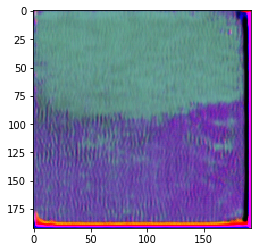

In [40]:
pred = pred.astype(int)
plt.imshow(pred[0])
plt.show()

In [41]:
ytest = ytest*127.5 + 127.5
ytest = ytest.astype(int)

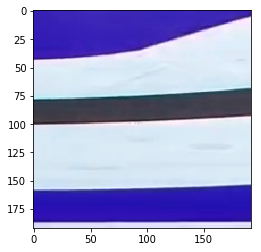

In [42]:
plt.imshow(ytest[0], interpolation='nearest')
plt.show()

In [43]:
frame1007 = np.load('../data/nparrs/frame1007.npy')
frame1007.shape

(200, 192, 192, 3)

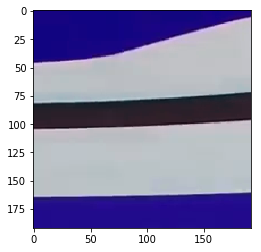

In [49]:
plt.imshow(frame1007[180], interpolation='nearest')
plt.show()